In [2]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

## 금융 데이터를 yfinance로부터 받아오기

In [3]:
import yfinance as yf
import datetime

def get_stocks_datas(ticker_names: list[str], start_date, end_date):
    # WARN: returns는 prices보다 길이가 1 작다.
    prices = {}
    returns = {}
    for name in ticker_names:
        data = yf.Ticker(name)
        data = data.history(start=start_date, end=end_date, interval="1d")
        prices[name] = data['Close']
        returns[name] = data['Close'].pct_change()[1:]
    return prices, returns

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 12, 31)
stock_prices, stock_returns = get_stocks_datas(["AAPL", "MSFT"], start_date, end_date)


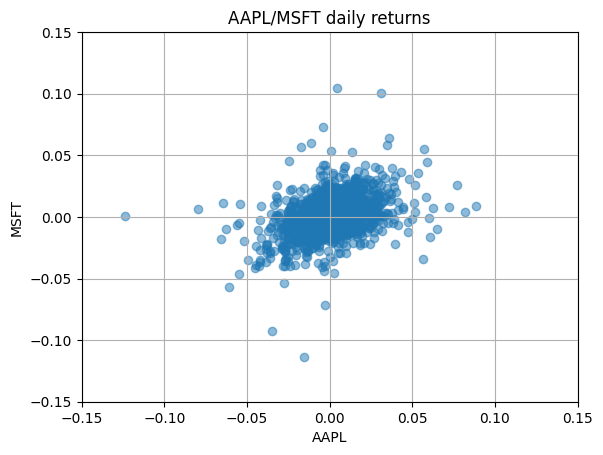

In [4]:
# 산점도 그리기
plt.scatter(stock_returns["AAPL"].values, stock_returns["MSFT"].values, alpha=0.5)
plt.title(f'AAPL/MSFT daily returns')
plt.xlabel('AAPL')
plt.ylabel('MSFT')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.grid(True)
plt.show()

## copula 변환/역변환 준비

역변환은 기존 분포를 normal distribution이라 가정

In [5]:
from scipy.stats import norm
import random

def probability_integral_transform(x, y):
    assert len(x) == len(y)
    n = len(x)
    x_sorted = sorted([(x, i) for i, x in enumerate(x)])
    y_sorted = sorted([(y, i) for i, y in enumerate(y)])
    xx = np.zeros(n)
    yy = np.zeros(n)

    for i in tqdm(range(n)):
        xx[x_sorted[i][1]] = i / n
        yy[y_sorted[i][1]] = i / n
        
    return xx, yy

def reverse_probability_integral_transform(x, y, x_mean, x_std, y_mean, y_std):
    assert(len(x) == len(y))
    n = len(x)
    xx = []
    yy = []
    for i in range(n):
        # 정규분포에서 면적이 x[i] 가 되는 z값
        xx.append(norm.ppf(x[i], loc=x_mean, scale=x_std))
        yy.append(norm.ppf(y[i], loc=y_mean, scale=y_std))
    return xx, yy

  0%|          | 0/2012 [00:00<?, ?it/s]

100%|██████████| 2012/2012 [00:00<00:00, 1660228.14it/s]


Text(0.5, 1.0, 'Copula space plot')

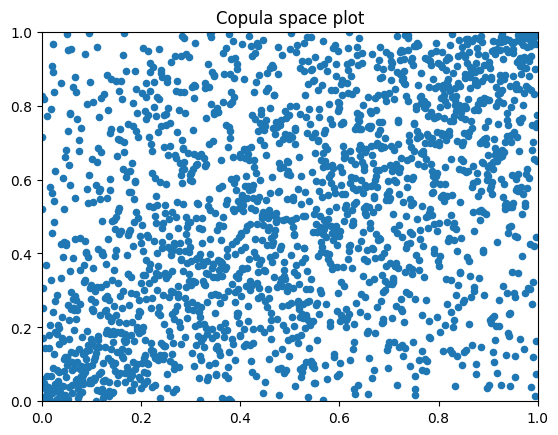

In [6]:
copula_x, copula_y = probability_integral_transform(stock_returns["AAPL"].values, stock_returns["MSFT"].values)
plt.scatter(copula_x, copula_y, s=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Copula space plot')

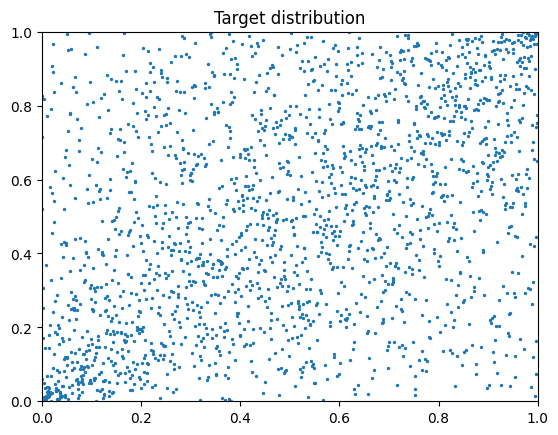

In [7]:
target_distribution = np.column_stack((copula_x, copula_y))
plt.scatter(target_distribution[:,0], target_distribution[:,1], s=2.0)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Target distribution')
plt.show()

In [8]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
noise_qubits = 6
code_qubits = 1
n_qubits = noise_qubits + code_qubits

n_layers = 1
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

BATCH_SIZE = 2048
MINIBATCH_SIZE = 16

dev = qml.device("default.qubit", wires=n_qubits, shots=1) # 제너레이터 돌려서 값 뽑아내는데 쓰임. 이중 몇개 골라서 판별자도 학습함.

n_qubits = 7 n_layers = 1


In [10]:
coeff = 0.2

def generator_init(generator_input):
    for i in range(noise_qubits//2):
        qml.Hadamard(wires=i)
    for i in range(noise_qubits//2):
        qml.CNOT(wires=[i, i+noise_qubits//2])

def generator_layer(params):
    for i in range(n_qubits-code_qubits):
        qml.RZ(params[i][0], wires=i)
        qml.RX(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits-code_qubits):
        qml.CNOT(wires=[i, (i+1)%(n_qubits-code_qubits)])
        qml.RX(params[i][3], wires=i)
        qml.CNOT(wires=[i, (i+1)%(n_qubits-code_qubits)])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    generator_init(generator_input)
    for param in params:
        generator_layer(param)
    return qml.sample(wires=range(n_qubits))


def generator_forward(params, generator_input):
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input]
    values = []
    for output in generator_output:
        gen_x = 0
        gen_y = 0
        for i in range(noise_qubits//2):
            gen_x += (0.5**(i+1)) * output[i]
        for i in range(noise_qubits//2, noise_qubits):
            gen_y += (0.5**(i-noise_qubits//2+1)) * output[i]
        gen_x += random.randint(0, (2**20)-1) / (2**23) + 0.5 ** 24
        gen_y += random.randint(0, (2**20)-1) / (2**23) + 0.5 ** 24
        values.append([gen_x, gen_y])
    generator_output = torch.tensor(values) # (-1, 2) 차원
    return generator_output


def generator_cost_fn(params, generator_input, use_mine = False, _qmine = False):
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (-1, code_qubits)

    generator_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (-1, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = -torch.log(disc_output).mean()
    
    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(len(code_input))]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return gan_loss

In [11]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.hidden_size = 32
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)
        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 32
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    #print("disc debug하자 ","real = ", disc_real.mean().item(), disc_real.std().item(), "fake = ", disc_fake.mean().item(), disc_fake.std().item())
    #print("항별 값 = ", torch.log(disc_real).mean() , torch.log(1.0 - disc_fake).mean())
    
    #loss = -0.5 * (torch.log(disc_real).mean() + torch.log(1.0 - disc_fake).mean())

    real_label = torch.ones((real_input.shape[0], 1)).to(device)
    fake_label = torch.zeros((fake_input.shape[0], 1)).to(device)
    
    a = disc_loss_fn(disc_real, real_label)
    b = disc_loss_fn(disc_fake, fake_label)
    return (a+b)/2

## custom spsa optimizer

구현 오류 제보 환영

In [12]:
spsa_a = 0.001
spsa_n_iter = 10
class SPSA_opt():
    def __init__(self, a=0.008, c=0.01, n_iter = 5, gamma=0.101):
        self.epoch = 1
        self.a = a
        self.c = c
        self.n_iter = n_iter
        self.gamma = gamma

    def step(self):
        self.epoch += 1
    
    def get_params(self):
        # (a, c) tuple return
        return self.a/self.epoch, self.c/(self.epoch**self.gamma)

def spsa_step(params):
    # 한 iter당 n_iter * 2 * MINIBATCH_SIZE 만큼 순회함
    # 기본값 = 5 * 2 * 16 = 160
    # return값: 평균 loss
    loss_sum = 0
    spsa_opt = SPSA_opt(a=spsa_a, n_iter=spsa_n_iter)
    for i in range(spsa_opt.n_iter):
        a, c = spsa_opt.get_params()
        delta = np.random.choice([-1, 1], size=params.shape)
        z = np.random.uniform(-1, 1, (MINIBATCH_SIZE, n_qubits))

        loss_plus = generator_cost_fn(params + c * delta, z) # 실제론 shot=MINIBATCH_SIZE
        loss_plus = loss_plus.detach().numpy()
        loss_minus = generator_cost_fn(params - c * delta, z) # 실제론 shot=MINIBATCH_SIZE
        loss_minus = loss_minus.detach().numpy()

        g = (loss_plus - loss_minus)/(2*c*delta)
        # print('param = ', params[0], 'delta =', (a*g)[0], 'aft =', (params-a*g)[0])
        params -= a*g
        loss_sum = loss_sum + (loss_plus + loss_minus)/2
        spsa_opt.step()
    
    return params, loss_sum / spsa_opt.n_iter

In [13]:
generator_params = Variable(torch.tensor(np.random.uniform(0, 2*np.pi, (n_layers, n_qubits, 4))))
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

D_lr = 0.0005
M_lr = 1e-4
use_mine = False
use_qmine = False
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

parameter shape:  torch.Size([1, 7, 4])


In [14]:
import os
title = f'spsa28_{use_mine}'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')

with open(f'result/{title}/param.txt', 'w') as f:
    f.write('spsa: a = {} n = {}\n'.format(spsa_a, spsa_n_iter))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('noise_qubits = {}\n'.format(noise_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [15]:
import warnings

def visualize_output(gen_outputs, gen_codes, rev, title, rep, recorder):
    warnings.simplefilter("ignore")
    plt.figure(figsize=(10 + 4 * code_qubits, 7))  # 전체 그림의 크기 지정
    
    plt.subplot(2, 2 + code_qubits, 1)
    plt.title('Target distribution')
    plt.scatter(stock_returns["AAPL"].values, stock_returns["MSFT"], s=10,  alpha=0.2)
    plt.xlim((-0.2, 0.2))
    plt.ylim((-0.2, 0.2))
    plt.grid()

    # 역변환
    rev_x, rev_y = rev
    plt.subplot(2, 2 + code_qubits, 2)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(rev_x, rev_y, s=10,  alpha=0.2)
    plt.xlim((-0.2, 0.2))
    plt.ylim((-0.2, 0.2))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(2, 2 + code_qubits, 3 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(rev_x, rev_y, s=10, c=gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((-0.2, 0.2))
        plt.ylim((-0.2, 0.2))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()
    
    
    plt.subplot(2, 2 + code_qubits, 3 + code_qubits)
    plt.title('Target copula'.format(rep))
    plt.scatter(copula_x, copula_y, s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(2, 2 + code_qubits, 4 + code_qubits)
    plt.title('Epoch {0} copula'.format(rep))
    plt.scatter(gen_outputs[:, 0], gen_outputs[:, 1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(2, 2 + code_qubits, 5 + code_qubits + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(gen_outputs[:, 0], gen_outputs[:, 1], s=10, c=gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=100)
    plt.clf()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')
        plt.plot(recorder['mi'], label='mi', marker='o')
        plt.plot(recorder['d_loss'], label='d_loss', marker='o')
        plt.plot(recorder['g_loss'], label='g_loss', marker='o')
        plt.plot(recorder['corr'], label='corr', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 2)
    plt.title(f'code - axis corr graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/corr_{rep}.png', dpi=100)
    plt.clf()

    plt.figure()
    plt.title('Epoch {0} KS stastics'.format(rep))
    plt.subplot(1, 2, 1)
    plt.plot(recorder['D_ks'], label='D_ks', marker='o')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(recorder['p-value'], label='p-value', marker='o')
    plt.yscale("log", base=10)  # 로그 스케일로 설정
    plt.legend()
    plt.savefig(f'result/{title}/ks_{rep}.png', dpi=100)
    plt.clf()


In [16]:
import ndtest
import openpyxl
epoch = 1500

recorder_keywords = ['d_loss', 'g_loss', 'mi', 'corr', 'D_ks', 'p-value']
for i in range(code_qubits):
    recorder_keywords.append(f'code{i}-x')
    recorder_keywords.append(f'code{i}-y')

recorder = {k: [] for k in recorder_keywords}
final_rep = 0

c_target = np.corrcoef(target_distribution[:,0], target_distribution[:,1])[0,1]
x_recorder = []

for rep in range(1, epoch+1):
    np.random.shuffle(target_distribution)
    iter_num = int(BATCH_SIZE  // MINIBATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    #iter_num = 16
    generator_seeds = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1 # seed = (2048, n_qubits)
    gen_outputs = generator_forward(generator_params, generator_seeds).detach() # 2048번 돌아간다

    D_loss_sum = 0.0
    mi_sum = 0.0
    log_gen_outputs = []
    log_gen_codes = []
    
    a_sum = 0
    b_sum = 0
    
    pbar = tqdm(range(iter_num))
    
    for i in pbar:
        x_indices = np.random.choice(len(target_distribution), size=MINIBATCH_SIZE)
        batch = torch.FloatTensor(target_distribution[x_indices])

        fake_input = gen_outputs[MINIBATCH_SIZE * i : MINIBATCH_SIZE * i + MINIBATCH_SIZE]
        generator_seed = generator_seeds[MINIBATCH_SIZE * i : MINIBATCH_SIZE * i + MINIBATCH_SIZE]

        # train discriminator
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(len(code_input))]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()

        D_loss_sum += disc_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.

        pbar.set_postfix({'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    # train generator
    generator_params, G_loss = spsa_step(generator_params)
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss)
    recorder['mi'].append(mi_sum/iter_num)
    
    gen_outputs = gen_outputs.numpy()
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss, mi_sum/iter_num))
    
    df = pd.DataFrame({'x': gen_outputs[:, 0], 'y': gen_outputs[:, 1]})
    for i in range(code_qubits):
        df[f'code{i}']=generator_seeds[:, i]
    corr_mat = df.corr().to_numpy()
    for i in range(code_qubits):
        recorder[f'code{i}-x'].append(corr_mat[0, i+2])
        recorder[f'code{i}-y'].append(corr_mat[1, i+2])
    
    rev_x, rev_y = reverse_probability_integral_transform(gen_outputs[:,0], gen_outputs[:,1],
                                                      stock_returns["AAPL"].mean(), stock_returns["AAPL"].std(),
                                                      stock_returns["MSFT"].mean(), stock_returns["MSFT"].std())
    rev_corr = np.corrcoef(rev_x, rev_y)[0,1]
    recorder['corr'].append(rev_corr)

    our_output = np.column_stack([rev_x, rev_y])
    p_value, D_ks = ndtest.ks2d2s(rev_x, rev_y,
                                  stock_returns["AAPL"].values, stock_returns["MSFT"].values, extra=True)

    print("진짜 corr = ", c_target, "현재 corr = ", rev_corr)
    print("D_ks:", D_ks, "p-value:", p_value)
    recorder['D_ks'].append(D_ks)
    recorder['p-value'].append(p_value)

    if rep % 5 == 0:
        visualize_output(gen_outputs, generator_seeds, (rev_x, rev_y), title, rep, recorder)
    with open(f'result/{title}/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)

    df = pd.DataFrame(recorder)
    output_filename = f'result/{title}/recorder.xlsx'
    df.to_excel(output_filename, index=False)

    final_rep = rep

100%|██████████| 128/128 [00:00<00:00, 274.68it/s, D_loss=0.692, MI=-.00272]


epoch: 1, D_loss: 0.6915922705084085, G_loss: 0.7011001229286193, MI = -0.0027234046792727895
진짜 corr =  0.40740304954170714 현재 corr =  -0.11183850795462773
D_ks: 0.1828715208747515 p-value: 2.4266302027915308e-20


100%|██████████| 128/128 [00:00<00:00, 282.91it/s, D_loss=0.684, MI=-.000755]


epoch: 2, D_loss: 0.6840637251734734, G_loss: 0.7017108500003815, MI = -0.0007550679292762652
진짜 corr =  0.40740304954170714 현재 corr =  -0.10750551269373963
D_ks: 0.17496777149602383 p-value: 1.1777048172979874e-18


100%|██████████| 128/128 [00:00<00:00, 283.64it/s, D_loss=0.675, MI=-6.07e-5]


epoch: 3, D_loss: 0.6750660873949528, G_loss: 0.715236485004425, MI = -6.06807298026979e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.13852545160362406
D_ks: 0.19163388807778325 p-value: 2.609001414526561e-22


100%|██████████| 128/128 [00:00<00:00, 271.96it/s, D_loss=0.662, MI=-.000769]


epoch: 4, D_loss: 0.6623327061533928, G_loss: 0.7367117404937744, MI = -0.0007686034659855068
진짜 corr =  0.40740304954170714 현재 corr =  -0.10551667841514274
D_ks: 0.20262070157181905 p-value: 7.150497422695619e-25


100%|██████████| 128/128 [00:00<00:00, 285.77it/s, D_loss=0.65, MI=-.000911]


epoch: 5, D_loss: 0.649526082444936, G_loss: 0.7455744504928589, MI = -0.0009108781814575195
진짜 corr =  0.40740304954170714 현재 corr =  -0.14265498966774892
D_ks: 0.16794496691724647 p-value: 3.095272692397349e-17


100%|██████████| 128/128 [00:00<00:00, 273.33it/s, D_loss=0.63, MI=-.00196] 


epoch: 6, D_loss: 0.6303200349211693, G_loss: 0.7579976558685303, MI = -0.0019559678621590137
진짜 corr =  0.40740304954170714 현재 corr =  -0.13595427835665622
D_ks: 0.18003793644383703 p-value: 9.686843126597572e-20


100%|██████████| 128/128 [00:00<00:00, 281.44it/s, D_loss=0.631, MI=-.0012]  


epoch: 7, D_loss: 0.6305217398330569, G_loss: 0.7703681230545044, MI = -0.0011984804878011346
진짜 corr =  0.40740304954170714 현재 corr =  -0.10428273543330312
D_ks: 0.1827016417122267 p-value: 2.6616148678959512e-20


100%|██████████| 128/128 [00:00<00:00, 284.12it/s, D_loss=0.603, MI=-.00155]


epoch: 8, D_loss: 0.6034760249312967, G_loss: 0.8265409171581268, MI = -0.0015463470481336117
진짜 corr =  0.40740304954170714 현재 corr =  -0.1321033499731313
D_ks: 0.17685051798583507 p-value: 4.633496147727029e-19


100%|██████████| 128/128 [00:00<00:00, 282.22it/s, D_loss=0.585, MI=-.00123] 


epoch: 9, D_loss: 0.5852824100293219, G_loss: 0.8202839195728302, MI = -0.0012339004315435886
진짜 corr =  0.40740304954170714 현재 corr =  -0.15263894109965281
D_ks: 0.20735547651590452 p-value: 4.6569487167261726e-26


100%|██████████| 128/128 [00:00<00:00, 281.40it/s, D_loss=0.573, MI=-6.5e-6] 


epoch: 10, D_loss: 0.5734216787386686, G_loss: 0.8877039849758148, MI = -6.504124030470848e-06
진짜 corr =  0.40740304954170714 현재 corr =  -0.1339241207869731
D_ks: 0.1980082396247515 p-value: 8.69391633726744e-24


100%|██████████| 128/128 [00:00<00:00, 269.92it/s, D_loss=0.57, MI=-.000124] 


epoch: 11, D_loss: 0.5703000375069678, G_loss: 0.9211064517498017, MI = -0.00012413132935762405
진짜 corr =  0.40740304954170714 현재 corr =  -0.08367883673215926
D_ks: 0.1919843245216203 p-value: 2.3035128420846027e-22


100%|██████████| 128/128 [00:00<00:00, 275.55it/s, D_loss=0.563, MI=-.000164]


epoch: 12, D_loss: 0.5626629358157516, G_loss: 0.90765860080719, MI = -0.0001636642264202237
진짜 corr =  0.40740304954170714 현재 corr =  -0.13678653730213394
D_ks: 0.1886745930666004 p-value: 1.2250319471330673e-21


100%|██████████| 128/128 [00:00<00:00, 267.75it/s, D_loss=0.531, MI=-9.08e-5]


epoch: 13, D_loss: 0.5313274615909904, G_loss: 0.9710773289203644, MI = -9.077764116227627e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.14188768847773756
D_ks: 0.18749708778578533 p-value: 2.2345698640785437e-21


100%|██████████| 128/128 [00:00<00:00, 279.91it/s, D_loss=0.52, MI=0.000474] 


epoch: 14, D_loss: 0.5202441848814487, G_loss: 1.0596741259098053, MI = 0.00047410838305950165
진짜 corr =  0.40740304954170714 현재 corr =  -0.11419234511205413
D_ks: 0.17878180137922467 p-value: 1.8401672504315915e-19


100%|██████████| 128/128 [00:00<00:00, 276.75it/s, D_loss=0.51, MI=-.000306] 


epoch: 15, D_loss: 0.510372007265687, G_loss: 1.0510401606559754, MI = -0.00030615704599767923
진짜 corr =  0.40740304954170714 현재 corr =  -0.12837424836869304
D_ks: 0.19467715193215712 p-value: 5.270316127902748e-23


100%|██████████| 128/128 [00:00<00:00, 279.98it/s, D_loss=0.521, MI=-.000411]


epoch: 16, D_loss: 0.5210428482387215, G_loss: 1.0352999687194824, MI = -0.0004108333960175514
진짜 corr =  0.40740304954170714 현재 corr =  -0.10863760372831854
D_ks: 0.18407911903578528 p-value: 1.325830455587149e-20


100%|██████████| 128/128 [00:00<00:00, 266.36it/s, D_loss=0.499, MI=-.000355]


epoch: 17, D_loss: 0.49884935002774, G_loss: 0.9494109511375427, MI = -0.0003546822117641568
진짜 corr =  0.40740304954170714 현재 corr =  -0.13889703531800493
D_ks: 0.1974937484468191 p-value: 1.1412684122441191e-23


100%|██████████| 128/128 [00:00<00:00, 281.23it/s, D_loss=0.496, MI=-.000443]


epoch: 18, D_loss: 0.49589722347445786, G_loss: 1.2145912289619445, MI = -0.0004428146639838815
진짜 corr =  0.40740304954170714 현재 corr =  -0.12400732367121388
D_ks: 0.17360291376739567 p-value: 2.2267165314589223e-18


100%|██████████| 128/128 [00:00<00:00, 269.21it/s, D_loss=0.495, MI=0.000119]


epoch: 19, D_loss: 0.49470702186226845, G_loss: 1.06679647564888, MI = 0.00011854688636958599
진짜 corr =  0.40740304954170714 현재 corr =  -0.14333444993947916
D_ks: 0.2003928576975646 p-value: 2.328340284270252e-24


100%|██████████| 128/128 [00:00<00:00, 277.28it/s, D_loss=0.468, MI=-.000317]


epoch: 20, D_loss: 0.4679164169356227, G_loss: 1.0070826530456543, MI = -0.0003170969430357218
진짜 corr =  0.40740304954170714 현재 corr =  -0.13978186438089862
D_ks: 0.19121647070700792 p-value: 3.2431396958338132e-22


100%|██████████| 128/128 [00:00<00:00, 266.17it/s, D_loss=0.456, MI=-.00036] 


epoch: 21, D_loss: 0.4562524995999411, G_loss: 1.1010842800140381, MI = -0.00035969086457043886
진짜 corr =  0.40740304954170714 현재 corr =  -0.12711585839883
D_ks: 0.18541776683648115 p-value: 6.59564174742403e-21


100%|██████████| 128/128 [00:00<00:00, 277.60it/s, D_loss=0.488, MI=-.000536]


epoch: 22, D_loss: 0.48780219559557736, G_loss: 1.1740713834762573, MI = -0.0005355721805244684
진짜 corr =  0.40740304954170714 현재 corr =  -0.09744835395194756
D_ks: 0.17820615370278325 p-value: 2.476069165035055e-19


100%|██████████| 128/128 [00:00<00:00, 276.28it/s, D_loss=0.469, MI=-.000747]


epoch: 23, D_loss: 0.4694321695715189, G_loss: 1.0905397176742553, MI = -0.0007471408462151885
진짜 corr =  0.40740304954170714 현재 corr =  -0.08656338138532661
D_ks: 0.18043108536282298 p-value: 8.365008422731662e-20


100%|██████████| 128/128 [00:00<00:00, 278.92it/s, D_loss=0.489, MI=0.000472]


epoch: 24, D_loss: 0.48885069321841, G_loss: 1.1422522217035294, MI = 0.00047157856170088053
진짜 corr =  0.40740304954170714 현재 corr =  -0.043442160406187875
D_ks: 0.18178672107977129 p-value: 4.3739642273792066e-20


100%|██████████| 128/128 [00:00<00:00, 278.23it/s, D_loss=0.472, MI=0.000407]


epoch: 25, D_loss: 0.47159170859958977, G_loss: 1.1132676005363464, MI = 0.0004071379080414772
진짜 corr =  0.40740304954170714 현재 corr =  -0.020524927511526788
D_ks: 0.20106849139537775 p-value: 1.7884501710631622e-24


100%|██████████| 128/128 [00:00<00:00, 275.58it/s, D_loss=0.477, MI=-.000351]


epoch: 26, D_loss: 0.47659109672531486, G_loss: 1.1186524689197541, MI = -0.00035122456029057503
진짜 corr =  0.40740304954170714 현재 corr =  -0.09753516682356085
D_ks: 0.1803422628292744 p-value: 8.664463162395357e-20


100%|██████████| 128/128 [00:00<00:00, 280.02it/s, D_loss=0.446, MI=0.000438]


epoch: 27, D_loss: 0.44600883475504816, G_loss: 1.3609301567077636, MI = 0.00043796643149107695
진짜 corr =  0.40740304954170714 현재 corr =  -0.05204587876470491
D_ks: 0.1755307995775348 p-value: 9.317128637191778e-19


100%|██████████| 128/128 [00:00<00:00, 278.73it/s, D_loss=0.488, MI=0.000137]


epoch: 28, D_loss: 0.48823821952100843, G_loss: 0.9947743833065033, MI = 0.0001371155958622694
진짜 corr =  0.40740304954170714 현재 corr =  -0.038548108255234574
D_ks: 0.17257344604249514 p-value: 3.836081764483699e-18


100%|██████████| 128/128 [00:00<00:00, 276.37it/s, D_loss=0.445, MI=2.56e-5] 


epoch: 29, D_loss: 0.4453378126490861, G_loss: 1.4338785231113433, MI = 2.562312874943018e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.05483437474311202
D_ks: 0.18826445623136184 p-value: 1.63114978913243e-21


100%|██████████| 128/128 [00:00<00:00, 279.52it/s, D_loss=0.444, MI=0.000211]


epoch: 30, D_loss: 0.4440298506524414, G_loss: 1.1869165897369385, MI = 0.00021063373424112797
진짜 corr =  0.40740304954170714 현재 corr =  -0.04235848992990879
D_ks: 0.1832505940916998 p-value: 2.104485634044402e-20


100%|██████████| 128/128 [00:00<00:00, 281.60it/s, D_loss=0.46, MI=0.000331] 


epoch: 31, D_loss: 0.45982588652987033, G_loss: 1.2420250475406647, MI = 0.00033111113589257
진짜 corr =  0.40740304954170714 현재 corr =  -0.022656138491776227
D_ks: 0.17551235555417488 p-value: 9.484937859545658e-19


100%|██████████| 128/128 [00:00<00:00, 275.19it/s, D_loss=0.44, MI=-.000437] 


epoch: 32, D_loss: 0.4396484325407073, G_loss: 1.2035927891731262, MI = -0.00043688539881259203
진짜 corr =  0.40740304954170714 현재 corr =  -0.13368191594297624
D_ks: 0.19217070623136184 p-value: 1.9793442120890906e-22


100%|██████████| 128/128 [00:00<00:00, 276.81it/s, D_loss=0.414, MI=-.000612]


epoch: 33, D_loss: 0.4141005201963708, G_loss: 1.2310993015766143, MI = -0.0006117930170148611
진짜 corr =  0.40740304954170714 현재 corr =  -0.14084514677862908
D_ks: 0.20463935139165013 p-value: 2.2062665849276426e-25


100%|██████████| 128/128 [00:00<00:00, 277.38it/s, D_loss=0.413, MI=0.000882]


epoch: 34, D_loss: 0.4127932375995442, G_loss: 1.5539855003356933, MI = 0.000881707645021379
진짜 corr =  0.40740304954170714 현재 corr =  -0.11938899177234996
D_ks: 0.19891927730492043 p-value: 5.3975648187446325e-24


100%|██████████| 128/128 [00:00<00:00, 274.46it/s, D_loss=0.414, MI=-.000386]


epoch: 35, D_loss: 0.414335927227512, G_loss: 1.3247069776058198, MI = -0.00038560270331799984
진짜 corr =  0.40740304954170714 현재 corr =  -0.08823536187408496
D_ks: 0.17618410629970183 p-value: 6.659920811578448e-19


100%|██████████| 128/128 [00:00<00:00, 280.08it/s, D_loss=0.418, MI=-.000115]


epoch: 36, D_loss: 0.4182732867775485, G_loss: 1.191665667295456, MI = -0.00011536863166838884
진짜 corr =  0.40740304954170714 현재 corr =  -0.1355495660765611
D_ks: 0.19563187282554678 p-value: 3.130573587628325e-23


100%|██████████| 128/128 [00:00<00:00, 277.14it/s, D_loss=0.427, MI=-.000182]


epoch: 37, D_loss: 0.42711125302594155, G_loss: 1.382392293214798, MI = -0.00018188985995948315
진짜 corr =  0.40740304954170714 현재 corr =  -0.11345169694707814
D_ks: 0.1832238987947316 p-value: 2.0298773032881197e-20


100%|██████████| 128/128 [00:00<00:00, 276.73it/s, D_loss=0.372, MI=-.00079] 


epoch: 38, D_loss: 0.37213204719591886, G_loss: 1.3665773510932921, MI = -0.0007901657372713089
진짜 corr =  0.40740304954170714 현재 corr =  -0.15554883855333462
D_ks: 0.2007321306535786 p-value: 1.893993467467486e-24


100%|██████████| 128/128 [00:00<00:00, 280.81it/s, D_loss=0.395, MI=-.000111]


epoch: 39, D_loss: 0.3948531592031941, G_loss: 1.1654217779636382, MI = -0.00011077267117798328
진짜 corr =  0.40740304954170714 현재 corr =  -0.10517599864153569
D_ks: 0.18525177062624254 p-value: 7.345992568743595e-21


100%|██████████| 128/128 [00:00<00:00, 279.59it/s, D_loss=0.434, MI=0.000426]


epoch: 40, D_loss: 0.4336194529896602, G_loss: 1.2972069561481476, MI = 0.00042551103979349136
진짜 corr =  0.40740304954170714 현재 corr =  -0.06867683296688168
D_ks: 0.19030057933648103 p-value: 5.627280080996882e-22


100%|██████████| 128/128 [00:00<00:00, 280.01it/s, D_loss=0.436, MI=0.000112]


epoch: 41, D_loss: 0.43615848652552813, G_loss: 1.35775066614151, MI = 0.00011152285151183605
진짜 corr =  0.40740304954170714 현재 corr =  -0.08275385168221222
D_ks: 0.17062905768513914 p-value: 9.372702151845004e-18


100%|██████████| 128/128 [00:00<00:00, 276.39it/s, D_loss=0.417, MI=-.000121]


epoch: 42, D_loss: 0.41658932575955987, G_loss: 1.5564767241477966, MI = -0.00012069358490407467
진짜 corr =  0.40740304954170714 현재 corr =  -0.09190378683626743
D_ks: 0.19080536313369784 p-value: 4.245908324755313e-22


100%|██████████| 128/128 [00:00<00:00, 274.87it/s, D_loss=0.444, MI=-.000338]


epoch: 43, D_loss: 0.44370599556714296, G_loss: 1.2785522520542145, MI = -0.00033802282996475697
진짜 corr =  0.40740304954170714 현재 corr =  -0.07723871866059635
D_ks: 0.17292097027211734 p-value: 3.1968884181456964e-18


100%|██████████| 128/128 [00:00<00:00, 275.76it/s, D_loss=0.439, MI=0.000467]


epoch: 44, D_loss: 0.4388379454612732, G_loss: 1.28088122010231, MI = 0.00046663801185786724
진짜 corr =  0.40740304954170714 현재 corr =  -0.06251295077434496
D_ks: 0.17639232961605367 p-value: 6.119807672463487e-19


100%|██████████| 128/128 [00:00<00:00, 277.52it/s, D_loss=0.459, MI=3e-5]    


epoch: 45, D_loss: 0.4589090214576572, G_loss: 1.5087830603122712, MI = 2.9988354071974754e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.04410714809623039
D_ks: 0.17302580998384698 p-value: 3.0909322691370995e-18


100%|██████████| 128/128 [00:00<00:00, 279.23it/s, D_loss=0.428, MI=0.000152]


epoch: 46, D_loss: 0.42834683356340975, G_loss: 1.4343613147735597, MI = 0.00015159486792981625
진짜 corr =  0.40740304954170714 현재 corr =  -0.03823717265940803
D_ks: 0.19510427668364816 p-value: 4.5260406293110167e-23


100%|██████████| 128/128 [00:00<00:00, 274.82it/s, D_loss=0.431, MI=0.000217]


epoch: 47, D_loss: 0.4310499165439978, G_loss: 1.339422583580017, MI = 0.00021656975150108337
진짜 corr =  0.40740304954170714 현재 corr =  -0.03549280442089715
D_ks: 0.2010898476329523 p-value: 1.7595976224650725e-24


100%|██████████| 128/128 [00:00<00:00, 275.96it/s, D_loss=0.471, MI=-.000939]


epoch: 48, D_loss: 0.47097950405441225, G_loss: 1.3028044253587723, MI = -0.0009391163475811481
진짜 corr =  0.40740304954170714 현재 corr =  0.013850354336303678
D_ks: 0.1807218214152585 p-value: 7.47704350216938e-20


100%|██████████| 128/128 [00:00<00:00, 278.26it/s, D_loss=0.467, MI=-.000293]


epoch: 49, D_loss: 0.46668177051469684, G_loss: 1.576910424232483, MI = -0.0002926797606050968
진짜 corr =  0.40740304954170714 현재 corr =  -0.026298733794682675
D_ks: 0.17619187220427435 p-value: 6.832092327569532e-19


100%|██████████| 128/128 [00:00<00:00, 278.09it/s, D_loss=0.459, MI=-.000144]


epoch: 50, D_loss: 0.4586679255589843, G_loss: 1.2668791651725768, MI = -0.00014385045506060123
진짜 corr =  0.40740304954170714 현재 corr =  -0.026159166457714867
D_ks: 0.1672368134940358 p-value: 4.613195398654068e-17


100%|██████████| 128/128 [00:00<00:00, 278.68it/s, D_loss=0.466, MI=-.00011] 


epoch: 51, D_loss: 0.4664281774312258, G_loss: 1.064058890938759, MI = -0.00011022062972187996
진짜 corr =  0.40740304954170714 현재 corr =  -0.01284430236042803
D_ks: 0.17523326835859843 p-value: 1.086124627562023e-18


100%|██████████| 128/128 [00:00<00:00, 273.69it/s, D_loss=0.534, MI=-.000582]


epoch: 52, D_loss: 0.5336513323709369, G_loss: 1.3425861120223999, MI = -0.0005822856910526752
진짜 corr =  0.40740304954170714 현재 corr =  0.05082817284065852
D_ks: 0.14921020750497022 p-value: 1.134749952523593e-13


100%|██████████| 128/128 [00:00<00:00, 272.05it/s, D_loss=0.441, MI=0.000244]


epoch: 53, D_loss: 0.44106391491368413, G_loss: 1.3015103220939637, MI = 0.00024391105398535728
진짜 corr =  0.40740304954170714 현재 corr =  0.05484842496858523
D_ks: 0.1444856253106362 p-value: 7.585024443285901e-13


100%|██████████| 128/128 [00:00<00:00, 272.75it/s, D_loss=0.471, MI=0.00023] 


epoch: 54, D_loss: 0.4712347744498402, G_loss: 1.0628850907087326, MI = 0.0002295132726430893
진짜 corr =  0.40740304954170714 현재 corr =  0.040300402976077544
D_ks: 0.14059976081013914 p-value: 3.472702207369312e-12


100%|██████████| 128/128 [00:00<00:00, 274.57it/s, D_loss=0.499, MI=-.00013] 


epoch: 55, D_loss: 0.498842510743998, G_loss: 1.1552914917469024, MI = -0.00013026082888245583
진짜 corr =  0.40740304954170714 현재 corr =  0.08564766071971908
D_ks: 0.18046020750497016 p-value: 8.251012288612657e-20


100%|██████████| 128/128 [00:00<00:00, 267.29it/s, D_loss=0.553, MI=-.000229]


epoch: 56, D_loss: 0.5529654017882422, G_loss: 1.2909103274345397, MI = -0.0002286355011165142
진짜 corr =  0.40740304954170714 현재 corr =  0.09604991631666468
D_ks: 0.14845206107107356 p-value: 1.5160393220454684e-13


100%|██████████| 128/128 [00:00<00:00, 275.43it/s, D_loss=0.59, MI=-.000469] 


epoch: 57, D_loss: 0.5902376419398934, G_loss: 1.2502868115901946, MI = -0.00046910648234188557
진짜 corr =  0.40740304954170714 현재 corr =  0.15768673386522447
D_ks: 0.13562521356237578 p-value: 2.1545510469439036e-11


100%|██████████| 128/128 [00:00<00:00, 266.97it/s, D_loss=0.572, MI=-.000369]


epoch: 58, D_loss: 0.5724098613718525, G_loss: 0.996936371922493, MI = -0.0003690181765705347
진짜 corr =  0.40740304954170714 현재 corr =  0.11535167256144516
D_ks: 0.13824135266525844 p-value: 8.298263892635655e-12


100%|██████████| 128/128 [00:00<00:00, 271.18it/s, D_loss=0.568, MI=-.000738]


epoch: 59, D_loss: 0.5676311978604645, G_loss: 1.1386039137840271, MI = -0.0007381504401564598
진짜 corr =  0.40740304954170714 현재 corr =  0.14693513022083982
D_ks: 0.13303091606610334 p-value: 5.653344763633932e-11


100%|██████████| 128/128 [00:00<00:00, 279.46it/s, D_loss=0.485, MI=-2.51e-5]


epoch: 60, D_loss: 0.4850882819155231, G_loss: 1.2638069212436676, MI = -2.5079352781176567e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.10225085701645148
D_ks: 0.14560973999751486 p-value: 4.751225079688822e-13


100%|██████████| 128/128 [00:00<00:00, 265.88it/s, D_loss=0.561, MI=-.000477]


epoch: 61, D_loss: 0.5606372130569071, G_loss: 1.151503324508667, MI = -0.0004766040947288275
진짜 corr =  0.40740304954170714 현재 corr =  0.10130887707654469
D_ks: 0.13128795585859837 p-value: 1.0920384148052457e-10


100%|██████████| 128/128 [00:00<00:00, 274.53it/s, D_loss=0.52, MI=-.00016]  


epoch: 62, D_loss: 0.5198935744119808, G_loss: 0.9804965406656265, MI = -0.00016008922830224037
진짜 corr =  0.40740304954170714 현재 corr =  0.08137736965415845
D_ks: 0.14220147862823063 p-value: 1.8422887438938875e-12


100%|██████████| 128/128 [00:00<00:00, 263.03it/s, D_loss=0.552, MI=0.000191]


epoch: 63, D_loss: 0.5519781558541581, G_loss: 0.9878306746482849, MI = 0.00019091391004621983
진짜 corr =  0.40740304954170714 현재 corr =  0.1549173519461373
D_ks: 0.1503537369532803 p-value: 6.653229884582385e-14


100%|██████████| 128/128 [00:00<00:00, 275.96it/s, D_loss=0.564, MI=1.38e-5] 


epoch: 64, D_loss: 0.5637620753841475, G_loss: 1.107755994796753, MI = 1.3835495337843895e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14748725279488156
D_ks: 0.13417444551441354 p-value: 3.715376587156862e-11


100%|██████████| 128/128 [00:00<00:00, 277.24it/s, D_loss=0.499, MI=-.00013] 


epoch: 65, D_loss: 0.4987942138686776, G_loss: 1.0758540213108063, MI = -0.00013010762631893158
진짜 corr =  0.40740304954170714 현재 corr =  0.05056072794964754
D_ks: 0.1583385429609841 p-value: 2.4245312980622517e-15


100%|██████████| 128/128 [00:00<00:00, 276.74it/s, D_loss=0.56, MI=3.89e-6]  


epoch: 66, D_loss: 0.5604481155751273, G_loss: 0.9309070020914078, MI = 3.889668732881546e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.0958091866249612
D_ks: 0.14219225661655066 p-value: 1.8362394930428157e-12


100%|██████████| 128/128 [00:00<00:00, 274.64it/s, D_loss=0.566, MI=-.000467]


epoch: 67, D_loss: 0.5664990487275645, G_loss: 0.9331718206405639, MI = -0.0004666910972446203
진짜 corr =  0.40740304954170714 현재 corr =  0.1077070116530326
D_ks: 0.12769040056535785 p-value: 3.9058181614073297e-10


100%|██████████| 128/128 [00:00<00:00, 277.92it/s, D_loss=0.532, MI=-.000545]


epoch: 68, D_loss: 0.5323495855554938, G_loss: 1.237378430366516, MI = -0.0005452290643006563
진짜 corr =  0.40740304954170714 현재 corr =  0.09271384131794755
D_ks: 0.14739250046595426 p-value: 2.334119951445377e-13


100%|██████████| 128/128 [00:00<00:00, 278.40it/s, D_loss=0.545, MI=-.000119]


epoch: 69, D_loss: 0.5448977261548862, G_loss: 1.23892183303833, MI = -0.00011871056631207466
진짜 corr =  0.40740304954170714 현재 corr =  0.11922513180755828
D_ks: 0.13875535847415504 p-value: 6.810437496818598e-12


100%|██████████| 128/128 [00:00<00:00, 275.57it/s, D_loss=0.492, MI=-.000636]


epoch: 70, D_loss: 0.4919592948863283, G_loss: 1.2026106297969819, MI = -0.0006360032130032778
진짜 corr =  0.40740304954170714 현재 corr =  0.08521762787282203
D_ks: 0.14844866348782298 p-value: 1.52690948510004e-13


100%|██████████| 128/128 [00:00<00:00, 277.39it/s, D_loss=0.507, MI=0.000178]


epoch: 71, D_loss: 0.5069625563919544, G_loss: 1.168371433019638, MI = 0.00017839018255472183
진짜 corr =  0.40740304954170714 현재 corr =  0.07291491143977116
D_ks: 0.1421432343439364 p-value: 1.8912075259071964e-12


100%|██████████| 128/128 [00:00<00:00, 276.41it/s, D_loss=0.484, MI=-.000134]


epoch: 72, D_loss: 0.4838699020911008, G_loss: 1.0762398362159729, MI = -0.00013441662304103374
진짜 corr =  0.40740304954170714 현재 corr =  0.03095923390137793
D_ks: 0.15793083297092442 p-value: 2.9083367567665144e-15


100%|██████████| 128/128 [00:00<00:00, 279.26it/s, D_loss=0.533, MI=0.000167]


epoch: 73, D_loss: 0.533421486208681, G_loss: 1.2058780908584594, MI = 0.0001669169869273901
진짜 corr =  0.40740304954170714 현재 corr =  0.08117837522533979
D_ks: 0.14947230678429418 p-value: 1.0072915531922707e-13


100%|██████████| 128/128 [00:00<00:00, 275.89it/s, D_loss=0.516, MI=-3.71e-5]


epoch: 74, D_loss: 0.5159185702214018, G_loss: 1.2243350505828858, MI = -3.7085264921188354e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.07489656327169215
D_ks: 0.1570503735400099 p-value: 4.1879289143214285e-15


100%|██████████| 128/128 [00:00<00:00, 276.75it/s, D_loss=0.541, MI=-.000229]


epoch: 75, D_loss: 0.5411202638642862, G_loss: 1.3199253737926484, MI = -0.00022881128825247288
진짜 corr =  0.40740304954170714 현재 corr =  0.0972214270452969
D_ks: 0.13419094806163023 p-value: 3.80374520416808e-11


100%|██████████| 128/128 [00:00<00:00, 273.79it/s, D_loss=0.555, MI=-.000273]


epoch: 76, D_loss: 0.5553437267662957, G_loss: 1.084100615978241, MI = -0.000272657023742795
진짜 corr =  0.40740304954170714 현재 corr =  0.09217915442110915
D_ks: 0.13341290149726637 p-value: 5.071706281620639e-11


100%|██████████| 128/128 [00:00<00:00, 269.21it/s, D_loss=0.527, MI=-6.43e-6]


epoch: 77, D_loss: 0.5273883069166914, G_loss: 0.9948357492685318, MI = -6.427755579352379e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.07200368156820562
D_ks: 0.14251114407306165 p-value: 1.6389606286137567e-12


100%|██████████| 128/128 [00:00<00:00, 276.24it/s, D_loss=0.495, MI=-.000188]


epoch: 78, D_loss: 0.49483960145153105, G_loss: 1.3577317893505096, MI = -0.0001875404268503189
진짜 corr =  0.40740304954170714 현재 corr =  0.06420448978092082
D_ks: 0.1534096204025845 p-value: 1.9802163851698918e-14


100%|██████████| 128/128 [00:00<00:00, 274.91it/s, D_loss=0.53, MI=0.000101] 


epoch: 79, D_loss: 0.5302446742425673, G_loss: 0.9753117382526397, MI = 0.00010141986422240734
진짜 corr =  0.40740304954170714 현재 corr =  0.07480080517084699
D_ks: 0.13515052264537775 p-value: 2.694081380366261e-11


100%|██████████| 128/128 [00:00<00:00, 272.74it/s, D_loss=0.517, MI=0.000264]


epoch: 80, D_loss: 0.5166632999898866, G_loss: 1.2219210863113403, MI = 0.0002641433384269476
진짜 corr =  0.40740304954170714 현재 corr =  0.07906515930659357
D_ks: 0.14004741084741545 p-value: 4.242766276762271e-12


100%|██████████| 128/128 [00:00<00:00, 277.47it/s, D_loss=0.49, MI=-.000184] 


epoch: 81, D_loss: 0.49033361102920026, G_loss: 1.087880128622055, MI = -0.00018393993377685547
진짜 corr =  0.40740304954170714 현재 corr =  0.0689974849002377
D_ks: 0.13240915833126238 p-value: 7.375268161459332e-11


100%|██████████| 128/128 [00:00<00:00, 266.05it/s, D_loss=0.55, MI=-.000254] 


epoch: 82, D_loss: 0.5500222910195589, G_loss: 0.8914515018463135, MI = -0.00025391532108187675
진짜 corr =  0.40740304954170714 현재 corr =  0.09235886491462685
D_ks: 0.12785494066848901 p-value: 3.711745973522927e-10


100%|██████████| 128/128 [00:00<00:00, 275.57it/s, D_loss=0.571, MI=-.000153]


epoch: 83, D_loss: 0.5708310112240724, G_loss: 1.2487234592437744, MI = -0.00015276833437383175
진짜 corr =  0.40740304954170714 현재 corr =  0.11485399307379623
D_ks: 0.14218012239065603 p-value: 1.825104542753738e-12


100%|██████████| 128/128 [00:00<00:00, 275.43it/s, D_loss=0.552, MI=0.000128]


epoch: 84, D_loss: 0.5516833903966472, G_loss: 1.307295560836792, MI = 0.00012829643674194813
진짜 corr =  0.40740304954170714 현재 corr =  0.08457517107904916
D_ks: 0.1340691204336481 p-value: 3.999986529275322e-11


100%|██████████| 128/128 [00:00<00:00, 276.94it/s, D_loss=0.472, MI=0.000399]


epoch: 85, D_loss: 0.4715086053474806, G_loss: 1.1215921223163605, MI = 0.0003994298167526722
진짜 corr =  0.40740304954170714 현재 corr =  0.04476158222780739
D_ks: 0.15637813742544732 p-value: 5.655668998690356e-15


100%|██████████| 128/128 [00:00<00:00, 273.33it/s, D_loss=0.524, MI=0.000431]


epoch: 86, D_loss: 0.5236685909330845, G_loss: 1.4946271061897278, MI = 0.000430903397500515
진짜 corr =  0.40740304954170714 현재 corr =  0.0671576611542425
D_ks: 0.1445297938928926 p-value: 7.422512869302481e-13


100%|██████████| 128/128 [00:00<00:00, 265.60it/s, D_loss=0.527, MI=-.000462]


epoch: 87, D_loss: 0.5274855248862877, G_loss: 1.0791802525520324, MI = -0.0004615632351487875
진짜 corr =  0.40740304954170714 현재 corr =  0.05999291858164763
D_ks: 0.17144544840332998 p-value: 6.4737778866209026e-18


100%|██████████| 128/128 [00:00<00:00, 275.68it/s, D_loss=0.559, MI=-.000379]


epoch: 88, D_loss: 0.5588736152276397, G_loss: 1.0201454401016234, MI = -0.00037859147414565086
진짜 corr =  0.40740304954170714 현재 corr =  0.07537073435836052
D_ks: 0.13938536748260433 p-value: 5.475141365895783e-12


100%|██████████| 128/128 [00:00<00:00, 268.14it/s, D_loss=0.556, MI=-.000315]


epoch: 89, D_loss: 0.5561337301624008, G_loss: 1.1833681344985962, MI = -0.0003150617703795433
진짜 corr =  0.40740304954170714 현재 corr =  0.07898164982563978
D_ks: 0.16343054951540759 p-value: 2.5358937430430047e-16


100%|██████████| 128/128 [00:00<00:00, 277.45it/s, D_loss=0.543, MI=-.000177]


epoch: 90, D_loss: 0.5434022224508226, G_loss: 1.0552854359149932, MI = -0.00017740693874657154
진짜 corr =  0.40740304954170714 현재 corr =  0.10587106388425056
D_ks: 0.16009072518016898 p-value: 1.0961088645893502e-15


100%|██████████| 128/128 [00:00<00:00, 265.82it/s, D_loss=0.553, MI=-.000423]


epoch: 91, D_loss: 0.552740094368346, G_loss: 0.9724706590175629, MI = -0.0004230004269629717
진짜 corr =  0.40740304954170714 현재 corr =  0.11362656778888873
D_ks: 0.1467712281001491 p-value: 2.961685445848632e-13


100%|██████████| 128/128 [00:00<00:00, 269.35it/s, D_loss=0.549, MI=-.000262]


epoch: 92, D_loss: 0.549197104643099, G_loss: 1.2283251464366913, MI = -0.00026247301138937473
진짜 corr =  0.40740304954170714 현재 corr =  0.1213931603788489
D_ks: 0.13479960083250503 p-value: 3.000377418739329e-11


100%|██████████| 128/128 [00:00<00:00, 274.87it/s, D_loss=0.526, MI=-.000471]


epoch: 93, D_loss: 0.5264685879810713, G_loss: 1.088184654712677, MI = -0.00047062686644494534
진짜 corr =  0.40740304954170714 현재 corr =  0.07813334393443257
D_ks: 0.17022620138543731 p-value: 1.1345966967110546e-17


100%|██████████| 128/128 [00:00<00:00, 273.40it/s, D_loss=0.525, MI=0.000304]


epoch: 94, D_loss: 0.5253356845350936, G_loss: 1.2882301449775695, MI = 0.000303708016872406
진짜 corr =  0.40740304954170714 현재 corr =  0.10444646337137878
D_ks: 0.16706547822440354 p-value: 4.803828930960338e-17


100%|██████████| 128/128 [00:00<00:00, 276.12it/s, D_loss=0.501, MI=-.000217]


epoch: 95, D_loss: 0.5010080334031954, G_loss: 1.2812419831752777, MI = -0.0002172449603676796
진짜 corr =  0.40740304954170714 현재 corr =  0.08901836210739532
D_ks: 0.1779984157554672 p-value: 2.7586636496081684e-19


100%|██████████| 128/128 [00:00<00:00, 275.05it/s, D_loss=0.517, MI=-.000174]


epoch: 96, D_loss: 0.5167789675761014, G_loss: 1.2695801645517348, MI = -0.0001741547603160143
진짜 corr =  0.40740304954170714 현재 corr =  0.1243056626495298
D_ks: 0.1440541322378231 p-value: 8.691528102717166e-13


100%|██████████| 128/128 [00:00<00:00, 256.91it/s, D_loss=0.587, MI=-.000199]


epoch: 97, D_loss: 0.5873057474382222, G_loss: 1.0523188352584838, MI = -0.00019883131608366966
진짜 corr =  0.40740304954170714 현재 corr =  0.14979245496658047
D_ks: 0.14033232247142147 p-value: 3.644378541905118e-12


100%|██████████| 128/128 [00:00<00:00, 272.21it/s, D_loss=0.574, MI=0.000215]


epoch: 98, D_loss: 0.5742133924504742, G_loss: 1.2268640160560609, MI = 0.00021498650312423706
진짜 corr =  0.40740304954170714 현재 corr =  0.15699264029784585
D_ks: 0.15053914792495038 p-value: 6.150590319985012e-14


100%|██████████| 128/128 [00:00<00:00, 272.61it/s, D_loss=0.61, MI=-.000286] 


epoch: 99, D_loss: 0.6103093540295959, G_loss: 1.0450466513633727, MI = -0.00028618238866329193
진짜 corr =  0.40740304954170714 현재 corr =  0.17605494870380772
D_ks: 0.12892226717818084 p-value: 2.4250869188838394e-10


100%|██████████| 128/128 [00:00<00:00, 275.73it/s, D_loss=0.597, MI=-.000183]


epoch: 100, D_loss: 0.5966000503394753, G_loss: 0.9763843595981598, MI = -0.00018276739865541458
진짜 corr =  0.40740304954170714 현재 corr =  0.12161722421569192
D_ks: 0.13139619315357853 p-value: 1.0393957678567051e-10


100%|██████████| 128/128 [00:00<00:00, 275.23it/s, D_loss=0.585, MI=-.000311]


epoch: 101, D_loss: 0.5852410502266139, G_loss: 1.0083624720573425, MI = -0.0003113257698714733
진짜 corr =  0.40740304954170714 현재 corr =  0.11951985046511505
D_ks: 0.13217181287276342 p-value: 7.861780384268849e-11


100%|██████████| 128/128 [00:00<00:00, 272.47it/s, D_loss=0.595, MI=-6.25e-5]


epoch: 102, D_loss: 0.5949916081735864, G_loss: 1.1191279947757722, MI = -6.24614767730236e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.15876930622519556
D_ks: 0.13511703218190857 p-value: 2.6003349024864847e-11


100%|██████████| 128/128 [00:00<00:00, 269.50it/s, D_loss=0.562, MI=8.24e-5] 


epoch: 103, D_loss: 0.5624345196411014, G_loss: 1.0196832180023194, MI = 8.242600597441196e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14543516359926287
D_ks: 0.13260767426689862 p-value: 6.603425384904387e-11


100%|██████████| 128/128 [00:00<00:00, 279.06it/s, D_loss=0.615, MI=-.000423]


epoch: 104, D_loss: 0.6154326894320548, G_loss: 1.028705558180809, MI = -0.0004229671321809292
진짜 corr =  0.40740304954170714 현재 corr =  0.1734818549999477
D_ks: 0.1373409931038767 p-value: 1.1177579434293594e-11


100%|██████████| 128/128 [00:00<00:00, 241.49it/s, D_loss=0.542, MI=-.000646]


epoch: 105, D_loss: 0.5420272380579263, G_loss: 0.9924025654792785, MI = -0.0006462843157351017
진짜 corr =  0.40740304954170714 현재 corr =  0.08973890488975014
D_ks: 0.13427394616674948 p-value: 3.701726840787923e-11


100%|██████████| 128/128 [00:00<00:00, 278.30it/s, D_loss=0.562, MI=-.000482]


epoch: 106, D_loss: 0.5616331229684874, G_loss: 0.9879289776086807, MI = -0.0004821671172976494
진짜 corr =  0.40740304954170714 현재 corr =  0.10699018353028383
D_ks: 0.13379779914264414 p-value: 4.3739258473077123e-11


100%|██████████| 128/128 [00:00<00:00, 274.02it/s, D_loss=0.59, MI=0.000222] 


epoch: 107, D_loss: 0.589947052882053, G_loss: 1.347845983505249, MI = 0.00022215512581169605
진짜 corr =  0.40740304954170714 현재 corr =  0.1474860268385047
D_ks: 0.13565676254970177 p-value: 2.1457912550687715e-11


100%|██████████| 128/128 [00:00<00:00, 274.74it/s, D_loss=0.588, MI=-.000141]


epoch: 108, D_loss: 0.5881322284694761, G_loss: 1.123641884326935, MI = -0.00014050467871129513
진짜 corr =  0.40740304954170714 현재 corr =  0.15906713110383677
D_ks: 0.13152093299577539 p-value: 9.697910594946048e-11


100%|██████████| 128/128 [00:00<00:00, 261.87it/s, D_loss=0.57, MI=-.000258] 


epoch: 109, D_loss: 0.5697721763281152, G_loss: 1.405045610666275, MI = -0.00025809486396610737
진짜 corr =  0.40740304954170714 현재 corr =  0.15110512326806697
D_ks: 0.13230480398856864 p-value: 7.343114025530464e-11


100%|██████████| 128/128 [00:00<00:00, 275.99it/s, D_loss=0.542, MI=-4.55e-5]


epoch: 110, D_loss: 0.5416072614025325, G_loss: 1.2908548891544342, MI = -4.546786658465862e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.06870619243009062
D_ks: 0.13385361658175954 p-value: 4.3545564239842246e-11


100%|██████████| 128/128 [00:00<00:00, 275.26it/s, D_loss=0.492, MI=-.000145]


epoch: 111, D_loss: 0.49246353562921286, G_loss: 0.9341914623975753, MI = -0.00014524650759994984
진짜 corr =  0.40740304954170714 현재 corr =  0.034292931214971366
D_ks: 0.1432639514475646 p-value: 1.2339193823264634e-12


100%|██████████| 128/128 [00:00<00:00, 273.58it/s, D_loss=0.578, MI=-6.8e-5] 


epoch: 112, D_loss: 0.5778587381355464, G_loss: 1.2318115472793578, MI = -6.801215931773186e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14413250215949097
D_ks: 0.1240768280939364 p-value: 1.3343800702643146e-09


100%|██████████| 128/128 [00:00<00:00, 274.02it/s, D_loss=0.498, MI=-1.16e-5]


epoch: 113, D_loss: 0.49822600302286446, G_loss: 1.0481061220169068, MI = -1.1579832062125206e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.04434455638573746
D_ks: 0.144174018389662 p-value: 8.604482779968328e-13


100%|██████████| 128/128 [00:00<00:00, 265.95it/s, D_loss=0.554, MI=-3.92e-5]


epoch: 114, D_loss: 0.5541698324959725, G_loss: 1.448694896697998, MI = -3.9180973544716835e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.08663048280879765
D_ks: 0.13488987947316106 p-value: 2.953188529715929e-11


100%|██████████| 128/128 [00:00<00:00, 270.14it/s, D_loss=0.53, MI=-.000162] 


epoch: 115, D_loss: 0.5298923172522336, G_loss: 1.359666082262993, MI = -0.00016218051314353943
진짜 corr =  0.40740304954170714 현재 corr =  0.015140603216604188
D_ks: 0.13662750062127235 p-value: 1.5750531335534536e-11


100%|██████████| 128/128 [00:00<00:00, 274.80it/s, D_loss=0.486, MI=-.000197]


epoch: 116, D_loss: 0.4864044295391068, G_loss: 0.9477793633937835, MI = -0.00019725249148905277
진짜 corr =  0.40740304954170714 현재 corr =  0.022625794548695694
D_ks: 0.1521811513730119 p-value: 3.3490720896063765e-14


100%|██████████| 128/128 [00:00<00:00, 279.60it/s, D_loss=0.493, MI=-.000236]


epoch: 117, D_loss: 0.49303001584485173, G_loss: 1.5971653819084168, MI = -0.00023572915233671665
진짜 corr =  0.40740304954170714 현재 corr =  0.04541500569589614
D_ks: 0.14510689767644136 p-value: 5.943711953261382e-13


100%|██████████| 128/128 [00:00<00:00, 276.03it/s, D_loss=0.484, MI=0.000424]


epoch: 118, D_loss: 0.4836722416803241, G_loss: 1.327867779135704, MI = 0.0004239245317876339
진짜 corr =  0.40740304954170714 현재 corr =  0.024985423987991563
D_ks: 0.1781192726453777 p-value: 2.68194366147543e-19


100%|██████████| 128/128 [00:00<00:00, 270.61it/s, D_loss=0.465, MI=6.71e-5] 


epoch: 119, D_loss: 0.4645462624030188, G_loss: 1.559843158721924, MI = 6.712810136377811e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.04092128239690634
D_ks: 0.1464906847974652 p-value: 3.423545110118166e-13


100%|██████████| 128/128 [00:00<00:00, 270.07it/s, D_loss=0.443, MI=-4.07e-6]


epoch: 120, D_loss: 0.4429865414276719, G_loss: 1.2593763947486878, MI = -4.074769094586372e-06
진짜 corr =  0.40740304954170714 현재 corr =  -0.00775449629952691
D_ks: 0.15845454616053678 p-value: 2.3247561282480467e-15


100%|██████████| 128/128 [00:00<00:00, 274.20it/s, D_loss=0.473, MI=0.000492]


epoch: 121, D_loss: 0.47270393988583237, G_loss: 1.5007062375545501, MI = 0.0004923255182802677
진짜 corr =  0.40740304954170714 현재 corr =  0.05827316056576344
D_ks: 0.1567062468936382 p-value: 4.890987885981498e-15


100%|██████████| 128/128 [00:00<00:00, 272.92it/s, D_loss=0.502, MI=0.000716]


epoch: 122, D_loss: 0.5018271321896464, G_loss: 1.1627746403217316, MI = 0.0007163791451603174
진짜 corr =  0.40740304954170714 현재 corr =  0.08645731068761066
D_ks: 0.1390247382890159 p-value: 6.253823598148392e-12


100%|██████████| 128/128 [00:00<00:00, 279.28it/s, D_loss=0.473, MI=0.000144]


epoch: 123, D_loss: 0.47342834947630763, G_loss: 1.4744812488555907, MI = 0.0001435352023690939
진짜 corr =  0.40740304954170714 현재 corr =  0.04672312245418513
D_ks: 0.14473898794731604 p-value: 6.876292430669695e-13


100%|██████████| 128/128 [00:00<00:00, 273.50it/s, D_loss=0.533, MI=0.0003]  


epoch: 124, D_loss: 0.532719359267503, G_loss: 1.3087390601634978, MI = 0.0002997438423335552
진짜 corr =  0.40740304954170714 현재 corr =  0.05702322083680031
D_ks: 0.13584654184269385 p-value: 2.0924397023789232e-11


100%|██████████| 128/128 [00:00<00:00, 266.82it/s, D_loss=0.481, MI=6.92e-5] 


epoch: 125, D_loss: 0.48102227272465825, G_loss: 1.2659623265266418, MI = 6.922148168087006e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.016159946135165127
D_ks: 0.12762536111456263 p-value: 4.095163275564517e-10


100%|██████████| 128/128 [00:00<00:00, 276.34it/s, D_loss=0.522, MI=-.00045] 


epoch: 126, D_loss: 0.5218608919531107, G_loss: 1.2646051704883576, MI = -0.0004500262439250946
진짜 corr =  0.40740304954170714 현재 corr =  0.04873801946086553
D_ks: 0.13299111580516898 p-value: 6.002052874330822e-11


100%|██████████| 128/128 [00:00<00:00, 276.87it/s, D_loss=0.519, MI=-.000326]


epoch: 127, D_loss: 0.5185642159194686, G_loss: 1.3316949367523194, MI = -0.000326147535815835
진짜 corr =  0.40740304954170714 현재 corr =  0.05214599611041662
D_ks: 0.12842185170228626 p-value: 3.08051985141686e-10


100%|██████████| 128/128 [00:00<00:00, 276.35it/s, D_loss=0.47, MI=-.000301] 


epoch: 128, D_loss: 0.47030978597467765, G_loss: 1.5123295545578004, MI = -0.00030053313821554184
진짜 corr =  0.40740304954170714 현재 corr =  -0.011818693812196112
D_ks: 0.13254166407803186 p-value: 7.10507542641403e-11


100%|██████████| 128/128 [00:00<00:00, 274.98it/s, D_loss=0.487, MI=0.000112]


epoch: 129, D_loss: 0.48669593181693926, G_loss: 1.370071104168892, MI = 0.00011230027303099632
진짜 corr =  0.40740304954170714 현재 corr =  0.005503122832436543
D_ks: 0.1539338189612326 p-value: 1.6085578858280622e-14


100%|██████████| 128/128 [00:00<00:00, 262.68it/s, D_loss=0.519, MI=6.92e-5] 


epoch: 130, D_loss: 0.5188525298144668, G_loss: 1.483187997341156, MI = 6.915256381034851e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.012722375263256164
D_ks: 0.14012264304796218 p-value: 4.187970751648782e-12


100%|██████████| 128/128 [00:00<00:00, 270.91it/s, D_loss=0.479, MI=-.000121]


epoch: 131, D_loss: 0.47856783983297646, G_loss: 0.9514459177851677, MI = -0.00012071942910552025
진짜 corr =  0.40740304954170714 현재 corr =  -0.025854291949718118
D_ks: 0.1546152770874752 p-value: 1.2036185888178887e-14


100%|██████████| 128/128 [00:00<00:00, 265.40it/s, D_loss=0.478, MI=6.95e-5] 


epoch: 132, D_loss: 0.47835878503974527, G_loss: 1.2422706991434098, MI = 6.9489236921072e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.02989059101135064
D_ks: 0.16175020191351885 p-value: 5.462809782863497e-16


100%|██████████| 128/128 [00:00<00:00, 267.30it/s, D_loss=0.522, MI=0.000227]


epoch: 133, D_loss: 0.522061126655899, G_loss: 1.142557629942894, MI = 0.00022663315758109093
진짜 corr =  0.40740304954170714 현재 corr =  0.036470795322111844
D_ks: 0.13231256989314116 p-value: 7.699441340477688e-11


100%|██████████| 128/128 [00:00<00:00, 273.60it/s, D_loss=0.508, MI=-.000585]


epoch: 134, D_loss: 0.5076679226476699, G_loss: 1.0197041809558869, MI = -0.0005853855982422829
진짜 corr =  0.40740304954170714 현재 corr =  0.032252453467209
D_ks: 0.13106711294731616 p-value: 1.20750263552544e-10


100%|██████████| 128/128 [00:00<00:00, 275.77it/s, D_loss=0.544, MI=3.78e-5] 


epoch: 135, D_loss: 0.544154510833323, G_loss: 1.293571275472641, MI = 3.7776073440909386e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.057896057798757936
D_ks: 0.13849859825422456 p-value: 7.720215704825161e-12


100%|██████████| 128/128 [00:00<00:00, 273.80it/s, D_loss=0.496, MI=-.000239]


epoch: 136, D_loss: 0.4960692171007395, G_loss: 1.2935289144515991, MI = -0.0002390833105891943
진짜 corr =  0.40740304954170714 현재 corr =  0.039472066016552156
D_ks: 0.13966882299950295 p-value: 4.965483052820073e-12


100%|██████████| 128/128 [00:00<00:00, 277.10it/s, D_loss=0.475, MI=-.000298]


epoch: 137, D_loss: 0.4748964153113775, G_loss: 1.3202102065086365, MI = -0.0002979452256113291
진짜 corr =  0.40740304954170714 현재 corr =  -0.000880919532915535
D_ks: 0.18239682995775353 p-value: 3.253164253023601e-20


100%|██████████| 128/128 [00:00<00:00, 264.27it/s, D_loss=0.488, MI=0.000192]


epoch: 138, D_loss: 0.4876875039190054, G_loss: 1.2690890610218049, MI = 0.00019246130250394344
진짜 corr =  0.40740304954170714 현재 corr =  0.017311334098459336
D_ks: 0.14116327426068587 p-value: 2.803695801973058e-12


100%|██████████| 128/128 [00:00<00:00, 275.58it/s, D_loss=0.559, MI=-7.17e-6]


epoch: 139, D_loss: 0.5591481775045395, G_loss: 1.175046408176422, MI = -7.169321179389954e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.09499813280225648
D_ks: 0.1513511703218191 p-value: 4.60809525210573e-14


100%|██████████| 128/128 [00:00<00:00, 272.72it/s, D_loss=0.483, MI=-.000287]


epoch: 140, D_loss: 0.4832752571674064, G_loss: 1.1484360575675965, MI = -0.00028657959774136543
진짜 corr =  0.40740304954170714 현재 corr =  0.01879313807905849
D_ks: 0.14533647723036774 p-value: 5.450914244012391e-13


100%|██████████| 128/128 [00:00<00:00, 272.83it/s, D_loss=0.463, MI=-.000123]


epoch: 141, D_loss: 0.46347248007077724, G_loss: 1.2551149904727936, MI = -0.00012306380085647106
진짜 corr =  0.40740304954170714 현재 corr =  0.08229056091545368
D_ks: 0.17065332613692846 p-value: 9.269658429682426e-18


100%|██████████| 128/128 [00:00<00:00, 273.92it/s, D_loss=0.473, MI=-5.65e-5]


epoch: 142, D_loss: 0.47343276580795646, G_loss: 1.2118175089359284, MI = -5.651544779539108e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.04766416711824179
D_ks: 0.138626735679672 p-value: 7.373915175477763e-12


100%|██████████| 128/128 [00:00<00:00, 261.61it/s, D_loss=0.457, MI=-1.55e-5]


epoch: 143, D_loss: 0.45728028821758926, G_loss: 1.1170728027820587, MI = -1.5450874343514442e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.07742609267832762
D_ks: 0.17145030209368783 p-value: 6.398836839055209e-18


100%|██████████| 128/128 [00:00<00:00, 275.39it/s, D_loss=0.481, MI=0.000108]


epoch: 144, D_loss: 0.48147768585477024, G_loss: 1.5157031118869781, MI = 0.00010808673687279224
진짜 corr =  0.40740304954170714 현재 corr =  0.07075590401270448
D_ks: 0.15871567470178927 p-value: 2.0413846181485845e-15


100%|██████████| 128/128 [00:00<00:00, 275.95it/s, D_loss=0.46, MI=-.0003]   


epoch: 145, D_loss: 0.4596285404986702, G_loss: 1.5493390142917634, MI = -0.0002999589778482914
진짜 corr =  0.40740304954170714 현재 corr =  0.055674986290524864
D_ks: 0.16586176301565603 p-value: 8.563077029756453e-17


100%|██████████| 128/128 [00:00<00:00, 271.91it/s, D_loss=0.455, MI=-.000233]


epoch: 146, D_loss: 0.45542624697554857, G_loss: 1.264766663312912, MI = -0.00023251399397850037
진짜 corr =  0.40740304954170714 현재 corr =  0.048351353750012954
D_ks: 0.16176282150844928 p-value: 5.405150862808945e-16


100%|██████████| 128/128 [00:00<00:00, 273.68it/s, D_loss=0.444, MI=7.18e-5] 


epoch: 147, D_loss: 0.444126634625718, G_loss: 1.3814476490020753, MI = 7.180264219641685e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.05851034790511057
D_ks: 0.15222580532430413 p-value: 3.2579724180372873e-14


100%|██████████| 128/128 [00:00<00:00, 256.96it/s, D_loss=0.51, MI=0.000152] 


epoch: 148, D_loss: 0.5100722400238737, G_loss: 1.1693087935447692, MI = 0.00015202048234641552
진짜 corr =  0.40740304954170714 현재 corr =  0.06253594618503679
D_ks: 0.15882148515159045 p-value: 1.9567066321380537e-15


100%|██████████| 128/128 [00:00<00:00, 275.84it/s, D_loss=0.421, MI=-.000137]


epoch: 149, D_loss: 0.42054957733489573, G_loss: 1.4686455845832824, MI = -0.0001366345677524805
진짜 corr =  0.40740304954170714 현재 corr =  0.01199769240164474
D_ks: 0.15225492746645125 p-value: 3.251291129358824e-14


100%|██████████| 128/128 [00:00<00:00, 275.81it/s, D_loss=0.432, MI=0.000436]


epoch: 150, D_loss: 0.43187504447996616, G_loss: 1.5607614398002625, MI = 0.0004363658372312784
진짜 corr =  0.40740304954170714 현재 corr =  0.0411155653734978
D_ks: 0.1462776077907555 p-value: 3.7287939171423346e-13


100%|██████████| 128/128 [00:00<00:00, 260.93it/s, D_loss=0.403, MI=0.000337]


epoch: 151, D_loss: 0.4033249838394113, G_loss: 1.594220507144928, MI = 0.00033705728128552437
진짜 corr =  0.40740304954170714 현재 corr =  -0.042078075790602035
D_ks: 0.1654089137052684 p-value: 1.0567843534346514e-16


100%|██████████| 128/128 [00:00<00:00, 270.13it/s, D_loss=0.402, MI=-.000161]


epoch: 152, D_loss: 0.4023476643487811, G_loss: 1.3001225471496582, MI = -0.00016124127432703972
진짜 corr =  0.40740304954170714 현재 corr =  -0.029485595146389067
D_ks: 0.182737073651839 p-value: 2.7336147981850105e-20


100%|██████████| 128/128 [00:00<00:00, 270.92it/s, D_loss=0.437, MI=-.000283]


epoch: 153, D_loss: 0.43741550855338573, G_loss: 1.3709301829338074, MI = -0.0002833132166415453
진짜 corr =  0.40740304954170714 현재 corr =  0.03839366250970095
D_ks: 0.15161375497017893 p-value: 4.228480306692394e-14


100%|██████████| 128/128 [00:00<00:00, 263.68it/s, D_loss=0.523, MI=3.45e-5] 


epoch: 154, D_loss: 0.5231553792254999, G_loss: 1.2937936544418336, MI = 3.4507131204009056e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.05606547971452136
D_ks: 0.16347665957380714 p-value: 2.511511758334638e-16


100%|██████████| 128/128 [00:00<00:00, 273.59it/s, D_loss=0.498, MI=-.000232]


epoch: 155, D_loss: 0.4984449561452493, G_loss: 1.1055643200874328, MI = -0.0002317526377737522
진짜 corr =  0.40740304954170714 현재 corr =  0.06510777507658401
D_ks: 0.16607192780815117 p-value: 7.750127940870999e-17


100%|██████████| 128/128 [00:00<00:00, 274.64it/s, D_loss=0.473, MI=-.000337]


epoch: 156, D_loss: 0.4730090235825628, G_loss: 1.2215810000896454, MI = -0.00033679953776299953
진짜 corr =  0.40740304954170714 현재 corr =  0.08539584043895426
D_ks: 0.1648410319333996 p-value: 1.3393554086438527e-16


100%|██████████| 128/128 [00:00<00:00, 253.49it/s, D_loss=0.486, MI=0.000107]


epoch: 157, D_loss: 0.4856241730740294, G_loss: 1.341488289833069, MI = 0.0001065677497535944
진짜 corr =  0.40740304954170714 현재 corr =  0.11374891939376096
D_ks: 0.13702259101640157 p-value: 1.3158139931622257e-11


100%|██████████| 128/128 [00:00<00:00, 269.56it/s, D_loss=0.455, MI=0.000557]


epoch: 158, D_loss: 0.4545879744691774, G_loss: 1.2213058948516846, MI = 0.0005572615191340446
진짜 corr =  0.40740304954170714 현재 corr =  0.12171543753848948
D_ks: 0.18851102370154071 p-value: 1.358147089793555e-21


100%|██████████| 128/128 [00:00<00:00, 273.26it/s, D_loss=0.461, MI=-.000258]


epoch: 159, D_loss: 0.46119798091240227, G_loss: 1.540047287940979, MI = -0.0002584645990282297
진짜 corr =  0.40740304954170714 현재 corr =  0.13155067916099664
D_ks: 0.16357324801192846 p-value: 2.2866970603715195e-16


100%|██████████| 128/128 [00:00<00:00, 272.12it/s, D_loss=0.468, MI=-.000276]


epoch: 160, D_loss: 0.46780613873852417, G_loss: 1.438845419883728, MI = -0.00027580675669014454
진짜 corr =  0.40740304954170714 현재 corr =  0.09567502400077603
D_ks: 0.161668659915507 p-value: 5.503461016701451e-16


100%|██████████| 128/128 [00:00<00:00, 275.69it/s, D_loss=0.495, MI=0.000136]


epoch: 161, D_loss: 0.49519468820653856, G_loss: 1.333065128326416, MI = 0.00013627647422254086
진짜 corr =  0.40740304954170714 현재 corr =  0.10535240868669699
D_ks: 0.15729985322440365 p-value: 3.693777484502436e-15


100%|██████████| 128/128 [00:00<00:00, 276.29it/s, D_loss=0.489, MI=-.000602]


epoch: 162, D_loss: 0.4892889230977744, G_loss: 1.2459168136119843, MI = -0.0006020441651344299
진짜 corr =  0.40740304954170714 현재 corr =  0.07462579683689835
D_ks: 0.16189872483846912 p-value: 5.032097093941345e-16


100%|██████████| 128/128 [00:00<00:00, 262.44it/s, D_loss=0.491, MI=-7.76e-5]


epoch: 163, D_loss: 0.4912985941627994, G_loss: 1.2488413244485854, MI = -7.762503810226917e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.05337188683850244
D_ks: 0.1576211675260934 p-value: 3.30418689636476e-15


100%|██████████| 128/128 [00:00<00:00, 275.19it/s, D_loss=0.464, MI=-6.51e-5]


epoch: 164, D_loss: 0.46417745540384203, G_loss: 0.983076086640358, MI = -6.507080979645252e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.06678105250824333
D_ks: 0.1530708328156064 p-value: 2.2805609352643684e-14


100%|██████████| 128/128 [00:00<00:00, 273.25it/s, D_loss=0.452, MI=-.000185]


epoch: 165, D_loss: 0.45245324389543384, G_loss: 1.143794685602188, MI = -0.0001850391272455454
진짜 corr =  0.40740304954170714 현재 corr =  0.03318311098988348
D_ks: 0.1727015834679424 p-value: 3.6160100779054705e-18


100%|██████████| 128/128 [00:00<00:00, 273.74it/s, D_loss=0.458, MI=-.000328]


epoch: 166, D_loss: 0.4582771669374779, G_loss: 1.4204065322875976, MI = -0.00032823672518134117
진짜 corr =  0.40740304954170714 현재 corr =  0.054568283634612774
D_ks: 0.1609051744222167 p-value: 7.879454415665752e-16


100%|██████████| 128/128 [00:00<00:00, 272.11it/s, D_loss=0.498, MI=0.000127]


epoch: 167, D_loss: 0.4984154460253194, G_loss: 0.9724212348461151, MI = 0.00012653949670493603
진짜 corr =  0.40740304954170714 현재 corr =  0.07479710710223912
D_ks: 0.14740220784666996 p-value: 2.345247704885694e-13


100%|██████████| 128/128 [00:00<00:00, 274.93it/s, D_loss=0.507, MI=0.000366]


epoch: 168, D_loss: 0.5074354547541589, G_loss: 1.445656383037567, MI = 0.00036636926233768463
진짜 corr =  0.40740304954170714 현재 corr =  0.09195081490749331
D_ks: 0.15323391681163018 p-value: 2.103269011238234e-14


100%|██████████| 128/128 [00:00<00:00, 263.26it/s, D_loss=0.537, MI=-.000539]


epoch: 169, D_loss: 0.5367570036323741, G_loss: 1.3297542452812194, MI = -0.0005394751206040382
진짜 corr =  0.40740304954170714 현재 corr =  0.09525470226702788
D_ks: 0.15372656638295235 p-value: 1.706180758021196e-14


100%|██████████| 128/128 [00:00<00:00, 260.65it/s, D_loss=0.481, MI=0.000172]


epoch: 170, D_loss: 0.4810885093174875, G_loss: 1.2434874296188354, MI = 0.0001718779094517231
진짜 corr =  0.40740304954170714 현재 corr =  0.06187523129628458
D_ks: 0.15341593020004973 p-value: 1.9767858246503244e-14


100%|██████████| 128/128 [00:00<00:00, 271.93it/s, D_loss=0.433, MI=0.000109]


epoch: 171, D_loss: 0.4330482363002375, G_loss: 1.174814486503601, MI = 0.00010863691568374634
진짜 corr =  0.40740304954170714 현재 corr =  0.031446936642244426
D_ks: 0.16799398918986086 p-value: 3.2547282393670914e-17


100%|██████████| 128/128 [00:00<00:00, 268.66it/s, D_loss=0.432, MI=-.000151]


epoch: 172, D_loss: 0.4316411168547347, G_loss: 1.2288304150104523, MI = -0.0001505962572991848
진짜 corr =  0.40740304954170714 현재 corr =  0.03805094956435637
D_ks: 0.16574818666128233 p-value: 9.071036303418349e-17


100%|██████████| 128/128 [00:00<00:00, 274.09it/s, D_loss=0.486, MI=0.000375]


epoch: 173, D_loss: 0.48636064713355154, G_loss: 1.5853066265583038, MI = 0.0003752259071916342
진짜 corr =  0.40740304954170714 현재 corr =  0.047190507464473376
D_ks: 0.16788672263295223 p-value: 3.403572062899636e-17


100%|██████████| 128/128 [00:00<00:00, 258.22it/s, D_loss=0.486, MI=7.29e-5] 


epoch: 174, D_loss: 0.4862159688491374, G_loss: 1.2488178968429566, MI = 7.287925109267235e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.043645241651705934
D_ks: 0.14157826478628227 p-value: 2.3772829236496565e-12


100%|██████████| 128/128 [00:00<00:00, 276.22it/s, D_loss=0.481, MI=-.000167]


epoch: 175, D_loss: 0.4810282459948212, G_loss: 1.5655022144317627, MI = -0.00016719894483685493
진짜 corr =  0.40740304954170714 현재 corr =  0.038204524131488914
D_ks: 0.15357270439860837 p-value: 1.8644257414848887e-14


100%|██████████| 128/128 [00:00<00:00, 275.13it/s, D_loss=0.479, MI=-.000115]


epoch: 176, D_loss: 0.47938315314240754, G_loss: 1.2822105884552002, MI = -0.00011494220234453678
진짜 corr =  0.40740304954170714 현재 corr =  0.012452526892805491
D_ks: 0.15455363521993049 p-value: 1.2374632897582024e-14


100%|██████████| 128/128 [00:00<00:00, 271.52it/s, D_loss=0.45, MI=0.000276] 


epoch: 177, D_loss: 0.45029132335912436, G_loss: 1.5366733908653258, MI = 0.00027634529396891594
진짜 corr =  0.40740304954170714 현재 corr =  -0.040633489413291854
D_ks: 0.13509664668240556 p-value: 2.7747925804796345e-11


100%|██████████| 128/128 [00:00<00:00, 275.75it/s, D_loss=0.424, MI=-3.86e-5]


epoch: 178, D_loss: 0.424133813532535, G_loss: 1.2139423072338105, MI = -3.8626138120889664e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.0452058008330205
D_ks: 0.15216464882579517 p-value: 3.356350036086935e-14


100%|██████████| 128/128 [00:00<00:00, 274.55it/s, D_loss=0.505, MI=-.000454]


epoch: 179, D_loss: 0.5053097667405382, G_loss: 1.3270025491714477, MI = -0.00045391079038381577
진짜 corr =  0.40740304954170714 현재 corr =  -0.01353417197510217
D_ks: 0.13905337506212717 p-value: 6.302948874527903e-12


100%|██████████| 128/128 [00:00<00:00, 278.32it/s, D_loss=0.468, MI=9.82e-5] 


epoch: 180, D_loss: 0.46841760678216815, G_loss: 1.3744665682315826, MI = 9.81625635176897e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.0011697305772335423
D_ks: 0.14635186925323057 p-value: 3.6368548922758833e-13


100%|██████████| 128/128 [00:00<00:00, 274.33it/s, D_loss=0.51, MI=-.000252] 


epoch: 181, D_loss: 0.5104386600432917, G_loss: 1.337713897228241, MI = -0.0002519425470381975
진짜 corr =  0.40740304954170714 현재 corr =  -0.007687628378889645
D_ks: 0.15382218408300197 p-value: 1.6859052610119483e-14


100%|██████████| 128/128 [00:00<00:00, 272.34it/s, D_loss=0.441, MI=0.000128]


epoch: 182, D_loss: 0.4406887193908915, G_loss: 1.1908171236515046, MI = 0.00012791715562343597
진짜 corr =  0.40740304954170714 현재 corr =  -0.0008721458244614241
D_ks: 0.14888646635810143 p-value: 1.305026210919073e-13


100%|██████████| 128/128 [00:00<00:00, 272.35it/s, D_loss=0.482, MI=-.000208]


epoch: 183, D_loss: 0.4823688995675184, G_loss: 1.3018519580364227, MI = -0.00020846491679549217
진짜 corr =  0.40740304954170714 현재 corr =  0.02198011902717283
D_ks: 0.14350372375124254 p-value: 1.1251378594171235e-12


100%|██████████| 128/128 [00:00<00:00, 272.03it/s, D_loss=0.461, MI=0.000208]


epoch: 184, D_loss: 0.4613365378463641, G_loss: 1.3464288592338562, MI = 0.00020837620832026005
진짜 corr =  0.40740304954170714 현재 corr =  0.027570108424255498
D_ks: 0.15628737341575544 p-value: 5.903626027495414e-15


100%|██████████| 128/128 [00:00<00:00, 274.03it/s, D_loss=0.481, MI=-.000277]


epoch: 185, D_loss: 0.48094929388025776, G_loss: 1.129986870288849, MI = -0.0002770642749965191
진짜 corr =  0.40740304954170714 현재 corr =  0.028955689810760094
D_ks: 0.13833697036530812 p-value: 8.260898329804055e-12


100%|██████████| 128/128 [00:00<00:00, 276.05it/s, D_loss=0.577, MI=-.000295]


epoch: 186, D_loss: 0.5772766943555325, G_loss: 1.307311749458313, MI = -0.00029488024301826954
진짜 corr =  0.40740304954170714 현재 corr =  0.09068107657347443
D_ks: 0.12382492156436388 p-value: 1.4916179537310013e-09


100%|██████████| 128/128 [00:00<00:00, 276.06it/s, D_loss=0.508, MI=-2.5e-5] 


epoch: 187, D_loss: 0.5083390381769277, G_loss: 0.902933943271637, MI = -2.4993205443024635e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.0282343674005495
D_ks: 0.15113712257703776 p-value: 5.163220108777242e-14


100%|██████████| 128/128 [00:00<00:00, 272.12it/s, D_loss=0.586, MI=3.48e-5] 


epoch: 188, D_loss: 0.5859003908699378, G_loss: 0.8234077632427216, MI = 3.4828903153538704e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.10350089583294042
D_ks: 0.13298043768638168 p-value: 5.908400132296495e-11


100%|██████████| 128/128 [00:00<00:00, 272.47it/s, D_loss=0.595, MI=0.00029] 


epoch: 189, D_loss: 0.5945440175710246, G_loss: 1.0491070330142975, MI = 0.0002901495900005102
진짜 corr =  0.40740304954170714 현재 corr =  0.12115832126691471
D_ks: 0.11740737217321069 p-value: 1.2305148299715446e-08


100%|██████████| 128/128 [00:00<00:00, 271.34it/s, D_loss=0.734, MI=-2.32e-5]


epoch: 190, D_loss: 0.7340952476952225, G_loss: 0.8004208862781524, MI = -2.3241853341460228e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23882945781804737
D_ks: 0.10800723005715708 p-value: 2.1054666307140856e-07


100%|██████████| 128/128 [00:00<00:00, 273.63it/s, D_loss=0.655, MI=-.000184]


epoch: 191, D_loss: 0.6552217616699636, G_loss: 0.806862723827362, MI = -0.00018413015641272068
진짜 corr =  0.40740304954170714 현재 corr =  0.19785015328285682
D_ks: 0.0989133558026839 p-value: 2.8785750184799687e-06


100%|██████████| 128/128 [00:00<00:00, 265.55it/s, D_loss=0.657, MI=-.000602]


epoch: 192, D_loss: 0.6569899015594274, G_loss: 0.9979347705841064, MI = -0.0006022891029715538
진짜 corr =  0.40740304954170714 현재 corr =  0.1662928652943994
D_ks: 0.09089020564115304 p-value: 2.365863224525163e-05


100%|██████████| 128/128 [00:00<00:00, 270.99it/s, D_loss=0.643, MI=-.000134]


epoch: 193, D_loss: 0.6428782201837748, G_loss: 0.7750376641750336, MI = -0.00013419706374406815
진짜 corr =  0.40740304954170714 현재 corr =  0.13834976829263881
D_ks: 0.09379805153454274 p-value: 1.1429945095506233e-05


100%|██████████| 128/128 [00:00<00:00, 275.42it/s, D_loss=0.697, MI=8.6e-5]  


epoch: 194, D_loss: 0.6969567815540358, G_loss: 0.9481801211833953, MI = 8.595711551606655e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23427829100538977
D_ks: 0.07841767752857853 p-value: 0.0004203657694501489


100%|██████████| 128/128 [00:00<00:00, 266.74it/s, D_loss=0.627, MI=-.000496]


epoch: 195, D_loss: 0.6265724722761661, G_loss: 0.8299375951290131, MI = -0.0004958445206284523
진짜 corr =  0.40740304954170714 현재 corr =  0.09538347355693563
D_ks: 0.11512953528827038 p-value: 2.5697104400058586e-08


100%|██████████| 128/128 [00:00<00:00, 272.62it/s, D_loss=0.609, MI=-7.25e-5]


epoch: 196, D_loss: 0.6089071326423436, G_loss: 1.0659296691417695, MI = -7.247366011142731e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17438620376181851
D_ks: 0.10389227137176937 p-value: 7.27404992533093e-07


100%|██████████| 128/128 [00:00<00:00, 270.40it/s, D_loss=0.604, MI=0.000208]


epoch: 197, D_loss: 0.6040814361767843, G_loss: 0.9097122430801392, MI = 0.00020761671476066113
진짜 corr =  0.40740304954170714 현재 corr =  0.09528781893066555
D_ks: 0.15234423536903574 p-value: 3.047192775997725e-14


100%|██████████| 128/128 [00:00<00:00, 277.40it/s, D_loss=0.566, MI=-6.97e-5]


epoch: 198, D_loss: 0.5659301170380786, G_loss: 1.0592948585748672, MI = -6.969296373426914e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.10033543672851888
D_ks: 0.1444880521558151 p-value: 7.430599144687493e-13


100%|██████████| 128/128 [00:00<00:00, 276.73it/s, D_loss=0.582, MI=-.000192]


epoch: 199, D_loss: 0.5815728468587622, G_loss: 1.0906956911087036, MI = -0.00019237026572227478
진짜 corr =  0.40740304954170714 현재 corr =  0.06485906651354872
D_ks: 0.12479857185014909 p-value: 1.0793649646239771e-09


100%|██████████| 128/128 [00:00<00:00, 276.24it/s, D_loss=0.595, MI=-7.27e-5]


epoch: 200, D_loss: 0.594675722764805, G_loss: 1.0439765512943269, MI = -7.269345223903656e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.09884808447781578
D_ks: 0.132007758138668 p-value: 8.431252873960574e-11


100%|██████████| 128/128 [00:00<00:00, 269.08it/s, D_loss=0.541, MI=-.000222]


epoch: 201, D_loss: 0.5411138173658401, G_loss: 0.8976967692375183, MI = -0.0002220135647803545
진짜 corr =  0.40740304954170714 현재 corr =  0.07368742573254485
D_ks: 0.12598384303553678 p-value: 7.164217088684416e-10


100%|██████████| 128/128 [00:00<00:00, 273.90it/s, D_loss=0.592, MI=-.000218]


epoch: 202, D_loss: 0.5915942962747067, G_loss: 0.9825224041938782, MI = -0.0002181357704102993
진짜 corr =  0.40740304954170714 현재 corr =  0.1646424133258839
D_ks: 0.1068423443712724 p-value: 3.112376909704815e-07


100%|██████████| 128/128 [00:00<00:00, 273.00it/s, D_loss=0.637, MI=0.000295]


epoch: 203, D_loss: 0.6372440366540104, G_loss: 0.735659483075142, MI = 0.00029463740065693855
진짜 corr =  0.40740304954170714 현재 corr =  0.17899575209172408
D_ks: 0.1102059517892644 p-value: 1.1329082463556448e-07


100%|██████████| 128/128 [00:00<00:00, 262.48it/s, D_loss=0.623, MI=-9.07e-5]


epoch: 204, D_loss: 0.6233559040119871, G_loss: 1.2106258988380432, MI = -9.067845530807972e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.20289110999259077
D_ks: 0.11614298583499007 p-value: 1.7585453762153937e-08


100%|██████████| 128/128 [00:00<00:00, 272.59it/s, D_loss=0.669, MI=-.000329]


epoch: 205, D_loss: 0.6688062120229006, G_loss: 1.1554825365543366, MI = -0.00032943952828645706
진짜 corr =  0.40740304954170714 현재 corr =  0.26592422286757134
D_ks: 0.09881288441227627 p-value: 2.8369875893922214e-06


100%|██████████| 128/128 [00:00<00:00, 277.22it/s, D_loss=0.651, MI=-.000429]


epoch: 206, D_loss: 0.650985510321334, G_loss: 0.832783442735672, MI = -0.00042859744280576706
진짜 corr =  0.40740304954170714 현재 corr =  0.2052014218072242
D_ks: 0.10189158020626239 p-value: 1.2597620159401703e-06


100%|██████████| 128/128 [00:00<00:00, 271.53it/s, D_loss=0.611, MI=6.03e-6] 


epoch: 207, D_loss: 0.6113468923140317, G_loss: 0.9876249551773071, MI = 6.026821210980415e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.17730912542563285
D_ks: 0.10372724589960236 p-value: 7.613264004818473e-07


100%|██████████| 128/128 [00:00<00:00, 274.42it/s, D_loss=0.647, MI=0.000268]


epoch: 208, D_loss: 0.6474010122474283, G_loss: 0.833073553442955, MI = 0.00026782508939504623
진짜 corr =  0.40740304954170714 현재 corr =  0.2268008796270295
D_ks: 0.10172121567470177 p-value: 1.3041627889834225e-06


100%|██████████| 128/128 [00:00<00:00, 274.47it/s, D_loss=0.621, MI=5.43e-5] 


epoch: 209, D_loss: 0.6207744022831321, G_loss: 0.8977683126926422, MI = 5.426211282610893e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.12208329026242166
D_ks: 0.11821696772490059 p-value: 9.468368655711919e-09


100%|██████████| 128/128 [00:00<00:00, 261.03it/s, D_loss=0.6, MI=0.000213]  


epoch: 210, D_loss: 0.5998964917380363, G_loss: 0.8894079089164734, MI = 0.0002134963870048523
진짜 corr =  0.40740304954170714 현재 corr =  0.13484706335378985
D_ks: 0.09795960564736583 p-value: 3.828459606299521e-06


100%|██████████| 128/128 [00:00<00:00, 275.23it/s, D_loss=0.557, MI=0.000378]


epoch: 211, D_loss: 0.5570549538824707, G_loss: 1.0209396123886108, MI = 0.00037803081795573235
진짜 corr =  0.40740304954170714 현재 corr =  0.13043698825396563
D_ks: 0.10589005032306165 p-value: 4.173432464321931e-07


100%|██████████| 128/128 [00:00<00:00, 270.97it/s, D_loss=0.589, MI=-.000462]


epoch: 212, D_loss: 0.5886598794022575, G_loss: 1.2094378650188446, MI = -0.00046178814955055714
진짜 corr =  0.40740304954170714 현재 corr =  0.12860430625721386
D_ks: 0.12123499238941345 p-value: 3.5026868932439857e-09


100%|██████████| 128/128 [00:00<00:00, 274.85it/s, D_loss=0.592, MI=-.000116]


epoch: 213, D_loss: 0.5915872596669942, G_loss: 0.9294351637363434, MI = -0.00011567259207367897
진짜 corr =  0.40740304954170714 현재 corr =  0.1424906267263504
D_ks: 0.1083353395253479 p-value: 2.0236936307241583e-07


100%|██████████| 128/128 [00:00<00:00, 257.84it/s, D_loss=0.606, MI=-.000138]


epoch: 214, D_loss: 0.6056091351201758, G_loss: 1.1262833714485168, MI = -0.0001384455244988203
진짜 corr =  0.40740304954170714 현재 corr =  0.17542208719237048
D_ks: 0.10537361766898608 p-value: 4.749023147008555e-07


100%|██████████| 128/128 [00:00<00:00, 271.91it/s, D_loss=0.581, MI=0.000199]


epoch: 215, D_loss: 0.5813051104778424, G_loss: 1.2701796382665633, MI = 0.00019912165589630604
진짜 corr =  0.40740304954170714 현재 corr =  0.09961452111953785
D_ks: 0.11287790833126243 p-value: 5.187012005061646e-08


100%|██████████| 128/128 [00:00<00:00, 265.95it/s, D_loss=0.558, MI=0.000123]


epoch: 216, D_loss: 0.5575276421150193, G_loss: 1.1408977687358857, MI = 0.0001226204913109541
진짜 corr =  0.40740304954170714 현재 corr =  0.10408135279370963
D_ks: 0.11600756787400596 p-value: 1.93959383193824e-08


100%|██████████| 128/128 [00:00<00:00, 270.56it/s, D_loss=0.552, MI=-.000264]


epoch: 217, D_loss: 0.5523978868732229, G_loss: 1.1085137605667115, MI = -0.0002644278574734926
진짜 corr =  0.40740304954170714 현재 corr =  0.06808896069163158
D_ks: 0.13252661763792245 p-value: 7.069445876086868e-11


100%|██████████| 128/128 [00:00<00:00, 262.48it/s, D_loss=0.553, MI=-.000212]


epoch: 218, D_loss: 0.5532566425390542, G_loss: 0.7164429396390914, MI = -0.0002117555122822523
진짜 corr =  0.40740304954170714 현재 corr =  0.07444694195357444
D_ks: 0.12128498540009938 p-value: 3.520006102316752e-09


100%|██████████| 128/128 [00:00<00:00, 274.94it/s, D_loss=0.655, MI=0.00038] 


epoch: 219, D_loss: 0.6554305419558659, G_loss: 0.8429030299186706, MI = 0.00038015982136130333
진짜 corr =  0.40740304954170714 현재 corr =  0.24911060577142138
D_ks: 0.10187168007579522 p-value: 1.231727663847098e-06


100%|██████████| 128/128 [00:00<00:00, 273.33it/s, D_loss=0.604, MI=-3.91e-5]


epoch: 220, D_loss: 0.604057424236089, G_loss: 1.2200485706329345, MI = -3.910320810973644e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1680660408506347
D_ks: 0.1135875178615805 p-value: 4.031841775603295e-08


100%|██████████| 128/128 [00:00<00:00, 258.44it/s, D_loss=0.608, MI=1.03e-5] 


epoch: 221, D_loss: 0.6076882088091224, G_loss: 0.9630546987056732, MI = 1.0312069207429886e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17395632087369695
D_ks: 0.10611914450795225 p-value: 3.8271248488831514e-07


100%|██████████| 128/128 [00:00<00:00, 272.16it/s, D_loss=0.632, MI=-5.77e-5]


epoch: 222, D_loss: 0.6318331838119775, G_loss: 0.9275463461875916, MI = -5.774642340838909e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.18261870646879827
D_ks: 0.10944003945079522 p-value: 1.4244802573204493e-07


100%|██████████| 128/128 [00:00<00:00, 281.76it/s, D_loss=0.584, MI=-.000289]


epoch: 223, D_loss: 0.5844720113091171, G_loss: 0.9735004603862762, MI = -0.0002888869494199753
진짜 corr =  0.40740304954170714 현재 corr =  0.15894278715044655
D_ks: 0.11482617964090464 p-value: 2.7481648866297277e-08


100%|██████████| 128/128 [00:00<00:00, 285.88it/s, D_loss=0.638, MI=-.000124]


epoch: 224, D_loss: 0.6375821720575914, G_loss: 0.8987689793109894, MI = -0.0001237615942955017
진짜 corr =  0.40740304954170714 현재 corr =  0.20831920101792428
D_ks: 0.13459623120651093 p-value: 3.0166212914439e-11


100%|██████████| 128/128 [00:00<00:00, 274.63it/s, D_loss=0.572, MI=-.000129]


epoch: 225, D_loss: 0.5716146250488237, G_loss: 0.8572607070207596, MI = -0.0001286054030060768
진짜 corr =  0.40740304954170714 현재 corr =  0.1779113911656229
D_ks: 0.11286431799826042 p-value: 5.019408725033847e-08


100%|██████████| 128/128 [00:00<00:00, 289.69it/s, D_loss=0.624, MI=-7.72e-5]


epoch: 226, D_loss: 0.6241664020344615, G_loss: 0.9313799917697907, MI = -7.723737508058548e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17721071312586745
D_ks: 0.12087824614811128 p-value: 3.830158770528261e-09


100%|██████████| 128/128 [00:00<00:00, 285.22it/s, D_loss=0.619, MI=0.000249]


epoch: 227, D_loss: 0.6192652065074071, G_loss: 1.0780875772237777, MI = 0.0002489075995981693
진짜 corr =  0.40740304954170714 현재 corr =  0.19139562711102273
D_ks: 0.12382783377857855 p-value: 1.405681840581335e-09


100%|██████████| 128/128 [00:00<00:00, 286.31it/s, D_loss=0.551, MI=-.000186]


epoch: 228, D_loss: 0.5507221561856568, G_loss: 1.1402471542358399, MI = -0.00018615066073834896
진짜 corr =  0.40740304954170714 현재 corr =  0.10664884173475
D_ks: 0.13969697440357853 p-value: 4.7886535360654594e-12


100%|██████████| 128/128 [00:00<00:00, 288.03it/s, D_loss=0.511, MI=-.000304]


epoch: 229, D_loss: 0.5110168758546934, G_loss: 1.382706868648529, MI = -0.00030436995439231396
진짜 corr =  0.40740304954170714 현재 corr =  0.047634648657445273
D_ks: 0.1346835976329523 p-value: 3.227576002622079e-11


100%|██████████| 128/128 [00:00<00:00, 292.37it/s, D_loss=0.528, MI=-.000553]


epoch: 230, D_loss: 0.5284631904214621, G_loss: 1.2949827075004579, MI = -0.0005532139912247658
진짜 corr =  0.40740304954170714 현재 corr =  0.07162119635978846
D_ks: 0.12066613987947317 p-value: 4.325143712957938e-09


100%|██████████| 128/128 [00:00<00:00, 287.50it/s, D_loss=0.499, MI=0.000509]


epoch: 231, D_loss: 0.4992870168061927, G_loss: 1.2353788912296295, MI = 0.0005093489307910204
진짜 corr =  0.40740304954170714 현재 corr =  0.011869607360271026
D_ks: 0.1437095202224155 p-value: 1.0386120604181006e-12


100%|██████████| 128/128 [00:00<00:00, 279.08it/s, D_loss=0.468, MI=0.000363]


epoch: 232, D_loss: 0.4680700442986563, G_loss: 1.4404794692993164, MI = 0.0003628227859735489
진짜 corr =  0.40740304954170714 현재 corr =  0.024843333131022764
D_ks: 0.15064544374378727 p-value: 6.33026503440104e-14


100%|██████████| 128/128 [00:00<00:00, 291.85it/s, D_loss=0.468, MI=4.7e-5] 


epoch: 233, D_loss: 0.4677566333557479, G_loss: 1.0421769499778748, MI = 4.698685370385647e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.04246402712656264
D_ks: 0.14183017131585485 p-value: 2.1563816056267724e-12


100%|██████████| 128/128 [00:00<00:00, 289.38it/s, D_loss=0.546, MI=-7.83e-5]


epoch: 234, D_loss: 0.5462502633454278, G_loss: 1.1961736649274826, MI = -7.826648652553558e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.029188683791139147
D_ks: 0.14176416112698803 p-value: 2.2180171502139084e-12


100%|██████████| 128/128 [00:00<00:00, 287.32it/s, D_loss=0.512, MI=-4.11e-5]


epoch: 235, D_loss: 0.5118056661449373, G_loss: 1.061672580242157, MI = -4.1126273572444916e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.023043185121529402
D_ks: 0.1402357340333002 p-value: 4.006135806568998e-12


100%|██████████| 128/128 [00:00<00:00, 282.14it/s, D_loss=0.519, MI=3.37e-5] 


epoch: 236, D_loss: 0.5192324974341318, G_loss: 1.3958649396896363, MI = 3.365590237081051e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.08048045016153411
D_ks: 0.13693279774478134 p-value: 1.3831072121122184e-11


100%|██████████| 128/128 [00:00<00:00, 287.40it/s, D_loss=0.509, MI=-.000228]


epoch: 237, D_loss: 0.5088647856609896, G_loss: 1.437486034631729, MI = -0.00022838241420686245
진짜 corr =  0.40740304954170714 현재 corr =  0.06214166004521465
D_ks: 0.14354740696446322 p-value: 1.095799754871628e-12


100%|██████████| 128/128 [00:00<00:00, 260.56it/s, D_loss=0.54, MI=0.000247] 


epoch: 238, D_loss: 0.5404249376151711, G_loss: 1.186560070514679, MI = 0.0002470891922712326
진짜 corr =  0.40740304954170714 현재 corr =  0.0368148490097343
D_ks: 0.15206611891153082 p-value: 3.504440722998069e-14


100%|██████████| 128/128 [00:00<00:00, 267.72it/s, D_loss=0.54, MI=-.000347] 


epoch: 239, D_loss: 0.5404270986327901, G_loss: 1.063801461458206, MI = -0.00034677772782742977
진짜 corr =  0.40740304954170714 현재 corr =  0.09562642387502429
D_ks: 0.1265730810449801 p-value: 5.796472422353623e-10


100%|██████████| 128/128 [00:00<00:00, 267.56it/s, D_loss=0.478, MI=0.000216]


epoch: 240, D_loss: 0.47828412312082946, G_loss: 1.418560266494751, MI = 0.00021581677719950676
진짜 corr =  0.40740304954170714 현재 corr =  0.03717722241448695
D_ks: 0.1568523429734095 p-value: 4.623779255981976e-15


100%|██████████| 128/128 [00:00<00:00, 270.97it/s, D_loss=0.529, MI=0.000214]


epoch: 241, D_loss: 0.5288404206512496, G_loss: 1.2057862639427186, MI = 0.000213677529245615
진짜 corr =  0.40740304954170714 현재 corr =  0.07703840626172705
D_ks: 0.15439443417619286 p-value: 1.2996862680321546e-14


100%|██████████| 128/128 [00:00<00:00, 266.06it/s, D_loss=0.497, MI=-9.53e-6]


epoch: 242, D_loss: 0.49735960352700204, G_loss: 1.2609069228172303, MI = -9.525567293167114e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.05376070365169056
D_ks: 0.15172684595551691 p-value: 4.0169428917192226e-14


100%|██████████| 128/128 [00:00<00:00, 252.11it/s, D_loss=0.52, MI=-.000259] 


epoch: 243, D_loss: 0.5195328692207113, G_loss: 1.1052672684192657, MI = -0.0002586841583251953
진짜 corr =  0.40740304954170714 현재 corr =  0.025728780655973726
D_ks: 0.1557971506896123 p-value: 7.282230641088028e-15


100%|██████████| 128/128 [00:00<00:00, 274.17it/s, D_loss=0.527, MI=-1.57e-5]


epoch: 244, D_loss: 0.527071216609329, G_loss: 1.3077590107917785, MI = -1.570954918861389e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.09796860380131293
D_ks: 0.12433601515904576 p-value: 1.2500440737567323e-09


100%|██████████| 128/128 [00:00<00:00, 275.13it/s, D_loss=0.486, MI=0.000129]


epoch: 245, D_loss: 0.4857902799267322, G_loss: 1.4171389281749724, MI = 0.00012884195894002914
진짜 corr =  0.40740304954170714 현재 corr =  0.04140641223032077
D_ks: 0.13807147350273358 p-value: 9.114205314414276e-12


100%|██████████| 128/128 [00:00<00:00, 259.30it/s, D_loss=0.428, MI=-.00037] 


epoch: 246, D_loss: 0.42803253314923495, G_loss: 1.5831691861152648, MI = -0.00037033180706202984
진짜 corr =  0.40740304954170714 현재 corr =  -0.028752780256490095
D_ks: 0.16506672853503973 p-value: 1.2380693007100596e-16


100%|██████████| 128/128 [00:00<00:00, 252.35it/s, D_loss=0.465, MI=-.000318]


epoch: 247, D_loss: 0.46461678319610655, G_loss: 1.397086924314499, MI = -0.00031822011806070805
진짜 corr =  0.40740304954170714 현재 corr =  0.005073473954041471
D_ks: 0.15980387208001984 p-value: 1.2911948841878333e-15


100%|██████████| 128/128 [00:00<00:00, 258.41it/s, D_loss=0.413, MI=-.000139]


epoch: 248, D_loss: 0.4133541287155822, G_loss: 1.4846359550952912, MI = -0.0001391647383570671
진짜 corr =  0.40740304954170714 현재 corr =  -0.10572760730144452
D_ks: 0.17967827798832006 p-value: 1.1938540097589902e-19


100%|██████████| 128/128 [00:00<00:00, 258.76it/s, D_loss=0.409, MI=-.000615]


epoch: 249, D_loss: 0.40922117832815275, G_loss: 1.4907671749591827, MI = -0.0006150191184133291
진짜 corr =  0.40740304954170714 현재 corr =  -0.09171805194044692
D_ks: 0.1686841839587475 p-value: 2.3018927210893567e-17


100%|██████████| 128/128 [00:00<00:00, 263.04it/s, D_loss=0.442, MI=-.000217]


epoch: 250, D_loss: 0.44164758175611496, G_loss: 1.4333013772964478, MI = -0.00021735928021371365
진짜 corr =  0.40740304954170714 현재 corr =  -0.030511636277474427
D_ks: 0.16302186878727631 p-value: 3.102250746241163e-16


100%|██████████| 128/128 [00:00<00:00, 279.16it/s, D_loss=0.445, MI=-.000245]


epoch: 251, D_loss: 0.44458028324879706, G_loss: 1.5406264901161193, MI = -0.0002449995372444391
진짜 corr =  0.40740304954170714 현재 corr =  -0.05840931105032286
D_ks: 0.1626335735586481 p-value: 3.6569061962919053e-16


100%|██████████| 128/128 [00:00<00:00, 276.10it/s, D_loss=0.433, MI=0.000197]


epoch: 252, D_loss: 0.43303362315054983, G_loss: 1.7181772708892822, MI = 0.00019736075773835182
진짜 corr =  0.40740304954170714 현재 corr =  -0.14447939756883615
D_ks: 0.19424517349030812 p-value: 6.490817153434187e-23


100%|██████████| 128/128 [00:00<00:00, 275.40it/s, D_loss=0.389, MI=-5.59e-5]


epoch: 253, D_loss: 0.3887693592114374, G_loss: 1.7255735278129578, MI = -5.586189217865467e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.0886719039084988
D_ks: 0.16216276559393633 p-value: 4.439560327548164e-16


100%|██████████| 128/128 [00:00<00:00, 279.61it/s, D_loss=0.401, MI=-.000379]


epoch: 254, D_loss: 0.40084802923956886, G_loss: 1.8299584150314332, MI = -0.00037868646904826164
진짜 corr =  0.40740304954170714 현재 corr =  -0.14521059817368012
D_ks: 0.20336137472042742 p-value: 4.481272591050212e-25


100%|██████████| 128/128 [00:00<00:00, 281.43it/s, D_loss=0.397, MI=5.35e-5] 


epoch: 255, D_loss: 0.3970342540415004, G_loss: 1.650747299194336, MI = 5.348445847630501e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.12014696211594594
D_ks: 0.16302623710859837 p-value: 2.951746865881298e-16


100%|██████████| 128/128 [00:00<00:00, 288.65it/s, D_loss=0.389, MI=-.000253]


epoch: 256, D_loss: 0.389403929351829, G_loss: 1.5978284001350402, MI = -0.00025341426953673363
진짜 corr =  0.40740304954170714 현재 corr =  -0.09212272262825277
D_ks: 0.16434595551689862 p-value: 1.6673947991603904e-16


100%|██████████| 128/128 [00:00<00:00, 293.22it/s, D_loss=0.365, MI=-.000292]


epoch: 257, D_loss: 0.36544402048457414, G_loss: 1.5364006966352464, MI = -0.0002924930304288864
진짜 corr =  0.40740304954170714 현재 corr =  -0.13496450233948387
D_ks: 0.18266718051068587 p-value: 2.6208424690050266e-20


100%|██████████| 128/128 [00:00<00:00, 280.26it/s, D_loss=0.36, MI=-.000229] 


epoch: 258, D_loss: 0.3603990119881928, G_loss: 1.7704782247543336, MI = -0.0002291100099682808
진짜 corr =  0.40740304954170714 현재 corr =  -0.1301970338389362
D_ks: 0.17296465348533796 p-value: 2.997119529539214e-18


100%|██████████| 128/128 [00:00<00:00, 282.28it/s, D_loss=0.345, MI=0.000141]


epoch: 259, D_loss: 0.3449237556196749, G_loss: 1.8880511045455932, MI = 0.00014140200801193714
진짜 corr =  0.40740304954170714 현재 corr =  -0.19988237826417446
D_ks: 0.16848032896371767 p-value: 2.243258764039507e-17


100%|██████████| 128/128 [00:00<00:00, 273.45it/s, D_loss=0.349, MI=-.000346]


epoch: 260, D_loss: 0.3494500698870979, G_loss: 1.5808022379875184, MI = -0.0003456035628914833
진짜 corr =  0.40740304954170714 현재 corr =  -0.20687558287920524
D_ks: 0.179047783610835 p-value: 1.4208481146672568e-19


100%|██████████| 128/128 [00:00<00:00, 290.61it/s, D_loss=0.35, MI=0.000397] 


epoch: 261, D_loss: 0.3496898317243904, G_loss: 1.4268808364868164, MI = 0.0003969247918576002
진짜 corr =  0.40740304954170714 현재 corr =  -0.15918625687136312
D_ks: 0.178835191973161 p-value: 1.7007166407213484e-19


100%|██████████| 128/128 [00:00<00:00, 281.37it/s, D_loss=0.317, MI=0.000104]


epoch: 262, D_loss: 0.31667665124405175, G_loss: 1.5896260380744933, MI = 0.00010394584387540817
진짜 corr =  0.40740304954170714 현재 corr =  -0.2291855117977593
D_ks: 0.18377333654324052 p-value: 1.2856732155387414e-20


100%|██████████| 128/128 [00:00<00:00, 282.03it/s, D_loss=0.316, MI=-.000319]


epoch: 263, D_loss: 0.31580919987754896, G_loss: 1.425272798538208, MI = -0.00031863292679190636
진짜 corr =  0.40740304954170714 현재 corr =  -0.23420342387404772
D_ks: 0.18229296098409542 p-value: 2.6827157815201843e-20


100%|██████████| 128/128 [00:00<00:00, 284.30it/s, D_loss=0.414, MI=0.000239]


epoch: 264, D_loss: 0.4141760982456617, G_loss: 1.0762802124023438, MI = 0.0002387678250670433
진짜 corr =  0.40740304954170714 현재 corr =  -0.12007152523556104
D_ks: 0.16628403407678927 p-value: 6.777633916574017e-17


100%|██████████| 128/128 [00:00<00:00, 297.45it/s, D_loss=0.458, MI=-.000209]


epoch: 265, D_loss: 0.45806034217821434, G_loss: 1.4779434680938721, MI = -0.00020858063362538815
진짜 corr =  0.40740304954170714 현재 corr =  -0.06592568459007055
D_ks: 0.15623398282181905 p-value: 5.9702789734908995e-15


100%|██████████| 128/128 [00:00<00:00, 296.32it/s, D_loss=0.425, MI=-.000338]


epoch: 266, D_loss: 0.4249289935687557, G_loss: 1.6048776268959046, MI = -0.0003377527464181185
진짜 corr =  0.40740304954170714 현재 corr =  -0.12917956061359406
D_ks: 0.16427315016153082 p-value: 1.6728630059217343e-16


100%|██████████| 128/128 [00:00<00:00, 283.62it/s, D_loss=0.329, MI=-.00031] 


epoch: 267, D_loss: 0.3285577486967668, G_loss: 1.7855237483978272, MI = -0.00030995369888842106
진짜 corr =  0.40740304954170714 현재 corr =  -0.18461535096843068
D_ks: 0.18852412866550694 p-value: 1.2306402143681733e-21


100%|██████████| 128/128 [00:00<00:00, 291.67it/s, D_loss=0.346, MI=-.00018] 


epoch: 268, D_loss: 0.34633673692587763, G_loss: 2.0208764553070067, MI = -0.00018023746088147163
진짜 corr =  0.40740304954170714 현재 corr =  -0.2338462585762796
D_ks: 0.17247297465208744 p-value: 3.2525870805435517e-18


100%|██████████| 128/128 [00:00<00:00, 290.92it/s, D_loss=0.321, MI=-.00014] 


epoch: 269, D_loss: 0.32096309890039265, G_loss: 1.7502811193466186, MI = -0.00014013703912496567
진짜 corr =  0.40740304954170714 현재 corr =  -0.26866571527378524
D_ks: 0.1770378704336481 p-value: 3.3547507817294523e-19


100%|██████████| 128/128 [00:00<00:00, 282.05it/s, D_loss=0.323, MI=-.000198]


epoch: 270, D_loss: 0.32279611489502713, G_loss: 1.982548177242279, MI = -0.00019825040362775326
진짜 corr =  0.40740304954170714 현재 corr =  -0.16966401247560758
D_ks: 0.18528720256585487 p-value: 6.650772779794299e-21


100%|██████████| 128/128 [00:00<00:00, 291.33it/s, D_loss=0.268, MI=-.000163]


epoch: 271, D_loss: 0.26792702899547294, G_loss: 2.0277828574180603, MI = -0.0001626173034310341
진짜 corr =  0.40740304954170714 현재 corr =  -0.27758832071168926
D_ks: 0.20598527972788272 p-value: 7.43843284251338e-26


100%|██████████| 128/128 [00:00<00:00, 294.54it/s, D_loss=0.309, MI=0.000151]


epoch: 272, D_loss: 0.30855588242411613, G_loss: 1.8940248131752013, MI = 0.00015113921836018562
진짜 corr =  0.40740304954170714 현재 corr =  -0.2894036893016268
D_ks: 0.19540860306908547 p-value: 2.51554708569868e-23


100%|██████████| 128/128 [00:00<00:00, 294.77it/s, D_loss=0.334, MI=0.000355]


epoch: 273, D_loss: 0.33392553409794345, G_loss: 1.9323435306549073, MI = 0.00035452423617243767
진짜 corr =  0.40740304954170714 현재 corr =  -0.21619831261200942
D_ks: 0.18084267830516898 p-value: 5.74293323542641e-20


100%|██████████| 128/128 [00:00<00:00, 284.82it/s, D_loss=0.266, MI=0.000106]


epoch: 274, D_loss: 0.26639755052747205, G_loss: 2.030011785030365, MI = 0.0001062008086591959
진짜 corr =  0.40740304954170714 현재 corr =  -0.2588077733011079
D_ks: 0.19576583467942346 p-value: 2.2650350349862617e-23


100%|██████████| 128/128 [00:00<00:00, 292.07it/s, D_loss=0.29, MI=7.39e-5]  


epoch: 275, D_loss: 0.2900277388980612, G_loss: 2.0799594163894652, MI = 7.39414244890213e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.2921120460454742
D_ks: 0.20319974683151093 p-value: 3.4215090446821636e-25


100%|██████████| 128/128 [00:00<00:00, 294.39it/s, D_loss=0.278, MI=-.00019] 


epoch: 276, D_loss: 0.2777826287201606, G_loss: 2.17662034034729, MI = -0.00018997164443135262
진짜 corr =  0.40740304954170714 현재 corr =  -0.3194125529428334
D_ks: 0.19939202674577533 p-value: 2.593659748897906e-24


100%|██████████| 128/128 [00:00<00:00, 298.40it/s, D_loss=0.254, MI=0.000409]


epoch: 277, D_loss: 0.2539059615810402, G_loss: 2.13934588432312, MI = 0.00040924292989075184
진짜 corr =  0.40740304954170714 현재 corr =  -0.36333047376572525
D_ks: 0.23759639429050697 p-value: 1.9083144016773402e-34


100%|██████████| 128/128 [00:00<00:00, 295.38it/s, D_loss=0.302, MI=-.000345]


epoch: 278, D_loss: 0.3017692578723654, G_loss: 1.7392741680145263, MI = -0.0003454068209975958
진짜 corr =  0.40740304954170714 현재 corr =  -0.3170226745923303
D_ks: 0.19855233831386682 p-value: 4.1522793316510295e-24


100%|██████████| 128/128 [00:00<00:00, 296.77it/s, D_loss=0.252, MI=-.00021] 


epoch: 279, D_loss: 0.2518391878111288, G_loss: 2.331695628166199, MI = -0.0002096181269735098
진짜 corr =  0.40740304954170714 현재 corr =  -0.3306326843139922
D_ks: 0.1980072688866799 p-value: 5.3371252619627836e-24


100%|██████████| 128/128 [00:00<00:00, 293.87it/s, D_loss=0.246, MI=-.000249]


epoch: 280, D_loss: 0.24649566010339186, G_loss: 1.9638860821723938, MI = -0.00024890433996915817
진짜 corr =  0.40740304954170714 현재 corr =  -0.3705282836504671
D_ks: 0.19928912851018887 p-value: 2.2573068232900157e-24


100%|██████████| 128/128 [00:00<00:00, 282.25it/s, D_loss=0.259, MI=-2.81e-5]


epoch: 281, D_loss: 0.25918586255284026, G_loss: 2.0612242937088014, MI = -2.8136884793639183e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.35419586563854827
D_ks: 0.20850919871396623 p-value: 1.311795079449264e-26


100%|██████████| 128/128 [00:00<00:00, 287.32it/s, D_loss=0.23, MI=0.000137] 


epoch: 282, D_loss: 0.22950829891487956, G_loss: 2.1136742889881135, MI = 0.00013657426461577415
진짜 corr =  0.40740304954170714 현재 corr =  -0.36258450861320213
D_ks: 0.20583190311257454 p-value: 5.89424803362506e-26


100%|██████████| 128/128 [00:00<00:00, 294.60it/s, D_loss=0.229, MI=0.000215]


epoch: 283, D_loss: 0.22873853900819086, G_loss: 2.03909285068512, MI = 0.00021487451158463955
진짜 corr =  0.40740304954170714 현재 corr =  -0.37534597236971556
D_ks: 0.21380991395377735 p-value: 5.32895436578002e-28


100%|██████████| 128/128 [00:00<00:00, 294.93it/s, D_loss=0.209, MI=-.000242]


epoch: 284, D_loss: 0.20931722776731476, G_loss: 2.0194697618484496, MI = -0.0002420535311102867
진짜 corr =  0.40740304954170714 현재 corr =  -0.3463756338136143
D_ks: 0.21679202130964215 p-value: 1.0279912575115923e-28


100%|██████████| 128/128 [00:00<00:00, 296.24it/s, D_loss=0.295, MI=0.000209]


epoch: 285, D_loss: 0.29491710546426475, G_loss: 1.7513333797454833, MI = 0.0002092455979436636
진짜 corr =  0.40740304954170714 현재 corr =  -0.29283453895255995
D_ks: 0.18654479373757454 p-value: 2.6724037880369235e-21


100%|██████████| 128/128 [00:00<00:00, 280.09it/s, D_loss=0.294, MI=0.0006]  


epoch: 286, D_loss: 0.294421604485251, G_loss: 1.9340275704860688, MI = 0.0005996676627546549
진짜 corr =  0.40740304954170714 현재 corr =  -0.23907628709554074
D_ks: 0.18482901419607356 p-value: 7.364609672095983e-21


100%|██████████| 128/128 [00:00<00:00, 293.74it/s, D_loss=0.276, MI=0.000117]


epoch: 287, D_loss: 0.2756439922959544, G_loss: 2.1202811717987062, MI = 0.00011676852591335773
진짜 corr =  0.40740304954170714 현재 corr =  -0.21246995914036512
D_ks: 0.17295106315233597 p-value: 2.6931995529480642e-18


100%|██████████| 128/128 [00:00<00:00, 285.17it/s, D_loss=0.22, MI=0.00017]  


epoch: 288, D_loss: 0.2195637832628563, G_loss: 2.0925723195075987, MI = 0.0001701456494629383
진짜 corr =  0.40740304954170714 현재 corr =  -0.309456296755382
D_ks: 0.20676575313742543 p-value: 4.271639420514287e-26


100%|██████████| 128/128 [00:00<00:00, 293.50it/s, D_loss=0.284, MI=-.00015] 


epoch: 289, D_loss: 0.2840397506952286, G_loss: 2.1526971817016602, MI = -0.00014988472685217857
진짜 corr =  0.40740304954170714 현재 corr =  -0.2621992315127876
D_ks: 0.1921653671719682 p-value: 1.5398339157566493e-22


100%|██████████| 128/128 [00:00<00:00, 294.96it/s, D_loss=0.251, MI=-5.63e-5]


epoch: 290, D_loss: 0.2510109930008184, G_loss: 1.9173015236854554, MI = -5.634361878037453e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.27621509376169523
D_ks: 0.18902211729622267 p-value: 7.743850514550812e-22


100%|██████████| 128/128 [00:00<00:00, 282.16it/s, D_loss=0.298, MI=-.000512]


epoch: 291, D_loss: 0.29843957000412047, G_loss: 2.0588453888893126, MI = -0.0005117766559123993
진짜 corr =  0.40740304954170714 현재 corr =  -0.19362792053102754
D_ks: 0.17820421222664012 p-value: 2.200045565721047e-19


100%|██████████| 128/128 [00:00<00:00, 295.09it/s, D_loss=0.263, MI=-.000264]


epoch: 292, D_loss: 0.263224056980107, G_loss: 2.1005557060241697, MI = -0.0002642280887812376
진짜 corr =  0.40740304954170714 현재 corr =  -0.24804772751851187
D_ks: 0.19712729482480118 p-value: 1.1152140715240912e-23


100%|██████████| 128/128 [00:00<00:00, 287.32it/s, D_loss=0.243, MI=0.00022] 


epoch: 293, D_loss: 0.24275641603162512, G_loss: 2.047632670402527, MI = 0.00021981238387525082
진짜 corr =  0.40740304954170714 현재 corr =  -0.25773181893687963
D_ks: 0.19109270160288272 p-value: 2.7459345441892574e-22


100%|██████████| 128/128 [00:00<00:00, 294.08it/s, D_loss=0.261, MI=-.000175]


epoch: 294, D_loss: 0.26064938426134177, G_loss: 2.074812853336334, MI = -0.00017534825019538403
진짜 corr =  0.40740304954170714 현재 corr =  -0.2772710793852959
D_ks: 0.19354381523359843 p-value: 7.095478578973884e-23


100%|██████████| 128/128 [00:00<00:00, 288.38it/s, D_loss=0.327, MI=0.000196]


epoch: 295, D_loss: 0.32745742570841685, G_loss: 1.8899316310882568, MI = 0.0001960541121661663
진짜 corr =  0.40740304954170714 현재 corr =  -0.2544991710282183
D_ks: 0.19425779308523858 p-value: 5.1543959250841236e-23


100%|██████████| 128/128 [00:00<00:00, 296.66it/s, D_loss=0.256, MI=0.000142]


epoch: 296, D_loss: 0.25600110861705616, G_loss: 2.2655585169792176, MI = 0.0001419533509761095
진짜 corr =  0.40740304954170714 현재 corr =  -0.2629954594703324
D_ks: 0.18975065621893644 p-value: 5.480720535481273e-22


100%|██████████| 128/128 [00:00<00:00, 286.21it/s, D_loss=0.235, MI=0.000557]


epoch: 297, D_loss: 0.23512781655881554, G_loss: 2.225382888317108, MI = 0.0005574200768023729
진짜 corr =  0.40740304954170714 현재 corr =  -0.34640441627858326
D_ks: 0.18640597819333993 p-value: 2.433908248845311e-21


100%|██████████| 128/128 [00:00<00:00, 294.97it/s, D_loss=0.19, MI=-4.12e-5] 


epoch: 298, D_loss: 0.19013149396050721, G_loss: 1.8942084550857543, MI = -4.118657670915127e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.3932339841081579
D_ks: 0.20384917060139163 p-value: 1.5882337527456843e-25


100%|██████████| 128/128 [00:00<00:00, 293.26it/s, D_loss=0.208, MI=0.000196]


epoch: 299, D_loss: 0.20755910573643632, G_loss: 2.2847510457038878, MI = 0.00019619916565716267
진짜 corr =  0.40740304954170714 현재 corr =  -0.3520682000461169
D_ks: 0.20140873508946322 p-value: 7.489705565660673e-25


100%|██████████| 128/128 [00:00<00:00, 291.98it/s, D_loss=0.207, MI=2.45e-5] 


epoch: 300, D_loss: 0.2068532128178049, G_loss: 1.8927999258041381, MI = 2.4541979655623436e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.34426963739835853
D_ks: 0.19084370728752484 p-value: 2.4092527897211262e-22


100%|██████████| 128/128 [00:00<00:00, 289.76it/s, D_loss=0.272, MI=4.95e-5] 


epoch: 301, D_loss: 0.27203709090827033, G_loss: 2.1667675733566285, MI = 4.9509573727846146e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.19883524048644993
D_ks: 0.18344377096794234 p-value: 1.6112882116137808e-20


100%|██████████| 128/128 [00:00<00:00, 291.46it/s, D_loss=0.346, MI=-.000343]


epoch: 302, D_loss: 0.3457889078708831, G_loss: 2.390773868560791, MI = -0.0003431935328990221
진짜 corr =  0.40740304954170714 현재 corr =  -0.22182783980624537
D_ks: 0.17917883325049705 p-value: 1.2954327452721494e-19


100%|██████████| 128/128 [00:00<00:00, 293.57it/s, D_loss=0.303, MI=-.000126]


epoch: 303, D_loss: 0.3031973984907381, G_loss: 1.48556706905365, MI = -0.000126363942399621
진짜 corr =  0.40740304954170714 현재 corr =  -0.2758412284919738
D_ks: 0.19336228721421472 p-value: 7.849369983800074e-23


100%|██████████| 128/128 [00:00<00:00, 289.43it/s, D_loss=0.306, MI=9.72e-6]


epoch: 304, D_loss: 0.30570288296439685, G_loss: 2.0731126070022583, MI = 9.716954082250595e-06
진짜 corr =  0.40740304954170714 현재 corr =  -0.21769885445204826
D_ks: 0.1707173948496521 p-value: 7.674292456135173e-18


100%|██████████| 128/128 [00:00<00:00, 293.05it/s, D_loss=0.346, MI=0.000158]


epoch: 305, D_loss: 0.3456772500358056, G_loss: 2.215208554267883, MI = 0.00015834160149097443
진짜 corr =  0.40740304954170714 현재 corr =  -0.1697598709242662
D_ks: 0.18332145797092442 p-value: 1.7989379844644113e-20


100%|██████████| 128/128 [00:00<00:00, 291.96it/s, D_loss=0.307, MI=-1.08e-5]


epoch: 306, D_loss: 0.30734729426330887, G_loss: 2.1536951303482055, MI = -1.0769348591566086e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.16349235653053396
D_ks: 0.18547989407306165 p-value: 6.0866907696954425e-21


100%|██████████| 128/128 [00:00<00:00, 290.45it/s, D_loss=0.328, MI=-7.9e-5] 


epoch: 307, D_loss: 0.3283541745040566, G_loss: 2.2930599451065063, MI = -7.900013588368893e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.19341952504736057
D_ks: 0.19157370231734594 p-value: 2.461604848116131e-22


100%|██████████| 128/128 [00:00<00:00, 295.68it/s, D_loss=0.279, MI=0.000219]


epoch: 308, D_loss: 0.27926735510118306, G_loss: 2.076952028274536, MI = 0.00021857721731066704
진짜 corr =  0.40740304954170714 현재 corr =  -0.2620836146027946
D_ks: 0.19851253805293245 p-value: 5.042905082192429e-24


100%|██████████| 128/128 [00:00<00:00, 292.51it/s, D_loss=0.295, MI=-.000408]


epoch: 309, D_loss: 0.2948889910185244, G_loss: 1.9971868515014648, MI = -0.00040833884850144386
진짜 corr =  0.40740304954170714 현재 corr =  -0.19952872736582866
D_ks: 0.18316419840333004 p-value: 1.852808148002044e-20


100%|██████████| 128/128 [00:00<00:00, 296.53it/s, D_loss=0.25, MI=-4.51e-5] 


epoch: 310, D_loss: 0.24968373504816554, G_loss: 2.351413977146149, MI = -4.5144231989979744e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.2454966309105484
D_ks: 0.1855570677497515 p-value: 5.0063769915565006e-21


100%|██████████| 128/128 [00:00<00:00, 293.88it/s, D_loss=0.294, MI=8.88e-5] 


epoch: 311, D_loss: 0.29419726703781635, G_loss: 2.151048791408539, MI = 8.884631097316742e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.19706492108729895
D_ks: 0.19691518855616297 p-value: 1.4098334915896397e-23


100%|██████████| 128/128 [00:00<00:00, 293.32it/s, D_loss=0.298, MI=-5.11e-5]


epoch: 312, D_loss: 0.2981219210778363, G_loss: 2.2763712882995604, MI = -5.111214704811573e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.15444069489799764
D_ks: 0.18972590239811132 p-value: 6.923540855670448e-22


100%|██████████| 128/128 [00:00<00:00, 294.92it/s, D_loss=0.41, MI=9.03e-7]  


epoch: 313, D_loss: 0.409647138643777, G_loss: 2.3909869313240053, MI = 9.026844054460526e-07
진짜 corr =  0.40740304954170714 현재 corr =  -0.07750988464071223
D_ks: 0.18336950950546715 p-value: 1.9454998867272845e-20


100%|██████████| 128/128 [00:00<00:00, 292.01it/s, D_loss=0.339, MI=-.00022] 


epoch: 314, D_loss: 0.33891680045053363, G_loss: 2.1183969736099244, MI = -0.00021950691007077694
진짜 corr =  0.40740304954170714 현재 corr =  -0.12024975794492565
D_ks: 0.17988601593563613 p-value: 1.0624790812624884e-19


100%|██████████| 128/128 [00:00<00:00, 290.01it/s, D_loss=0.276, MI=3.67e-5]


epoch: 315, D_loss: 0.2757032384397462, G_loss: 1.7600087165832519, MI = 3.667711280286312e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.14126605518015298
D_ks: 0.19753840239811138 p-value: 1.11012230044979e-23


100%|██████████| 128/128 [00:00<00:00, 283.68it/s, D_loss=0.29, MI=9.22e-5]  


epoch: 316, D_loss: 0.2901077931455802, G_loss: 1.8224670976400374, MI = 9.221560321748257e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.12367165195540897
D_ks: 0.19541928118787277 p-value: 3.5643971038830875e-23


100%|██████████| 128/128 [00:00<00:00, 296.36it/s, D_loss=0.292, MI=6.55e-5] 


epoch: 317, D_loss: 0.2924323108745739, G_loss: 1.9077567338943482, MI = 6.551411934196949e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.15376493831826155
D_ks: 0.20539798319458247 p-value: 1.4090743306660753e-25


100%|██████████| 128/128 [00:00<00:00, 293.57it/s, D_loss=0.288, MI=-2.37e-5]


epoch: 318, D_loss: 0.2876568747451529, G_loss: 2.1747176885604858, MI = -2.366909757256508e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.1880433832287417
D_ks: 0.20388654401714712 p-value: 3.0854684926485434e-25


100%|██████████| 128/128 [00:00<00:00, 293.80it/s, D_loss=0.226, MI=0.000113]


epoch: 319, D_loss: 0.22562218451639637, G_loss: 1.777329432964325, MI = 0.00011257082223892212
진짜 corr =  0.40740304954170714 현재 corr =  -0.18589873786992353
D_ks: 0.20268962397490053 p-value: 6.0493421004991045e-25


100%|██████████| 128/128 [00:00<00:00, 295.39it/s, D_loss=0.314, MI=2.52e-5]


epoch: 320, D_loss: 0.313775033748243, G_loss: 1.9371121525764465, MI = 2.517993561923504e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.12177951407204363
D_ks: 0.19417139739686878 p-value: 6.96001018035492e-23


100%|██████████| 128/128 [00:00<00:00, 295.10it/s, D_loss=0.458, MI=8.83e-5]


epoch: 321, D_loss: 0.4580891120713204, G_loss: 1.6965093731880188, MI = 8.83371103554964e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.012059038653354118
D_ks: 0.16753968377236578 p-value: 4.0230826878734635e-17


100%|██████████| 128/128 [00:00<00:00, 293.51it/s, D_loss=0.328, MI=0.000343]


epoch: 322, D_loss: 0.32817016285844147, G_loss: 1.9662734985351562, MI = 0.00034307781606912613
진짜 corr =  0.40740304954170714 현재 corr =  -0.0840992523974946
D_ks: 0.18090529091078533 p-value: 6.626242730325194e-20


100%|██████████| 128/128 [00:00<00:00, 293.68it/s, D_loss=0.283, MI=-5.4e-5] 


epoch: 323, D_loss: 0.2825341785501223, G_loss: 2.3368865251541138, MI = -5.4028118029236794e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.12002628901061727
D_ks: 0.19590756243787277 p-value: 2.755104863738253e-23


100%|██████████| 128/128 [00:00<00:00, 294.57it/s, D_loss=0.306, MI=-.0002]  


epoch: 324, D_loss: 0.3059068971197121, G_loss: 2.4047479748725893, MI = -0.0002000818494707346
진짜 corr =  0.40740304954170714 현재 corr =  -0.15392443198760497
D_ks: 0.20916978597167002 p-value: 1.6465385952291952e-26


100%|██████████| 128/128 [00:00<00:00, 293.44it/s, D_loss=0.272, MI=-4.99e-5]


epoch: 325, D_loss: 0.27208204532507807, G_loss: 1.8998847544193267, MI = -4.986557178199291e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.1982153167965807
D_ks: 0.1969836255902087 p-value: 1.3553100861094216e-23


100%|██████████| 128/128 [00:00<00:00, 291.39it/s, D_loss=0.284, MI=0.000506]


epoch: 326, D_loss: 0.2843868105846923, G_loss: 1.790632152557373, MI = 0.0005059947725385427
진짜 corr =  0.40740304954170714 현재 corr =  -0.11865594442534484
D_ks: 0.19247891556908547 p-value: 1.7140810768438508e-22


100%|██████████| 128/128 [00:00<00:00, 288.26it/s, D_loss=0.307, MI=-.00023] 


epoch: 327, D_loss: 0.3073597173206508, G_loss: 2.049839746952057, MI = -0.00023040571250021458
진짜 corr =  0.40740304954170714 현재 corr =  -0.10308792034555862
D_ks: 0.1820619253230616 p-value: 3.6691449237978244e-20


100%|██████████| 128/128 [00:00<00:00, 291.20it/s, D_loss=0.374, MI=-.000656]


epoch: 328, D_loss: 0.37359708646545187, G_loss: 1.77755765914917, MI = -0.0006564182695001364
진짜 corr =  0.40740304954170714 현재 corr =  -0.08449231042378946
D_ks: 0.184158719557654 p-value: 1.300717530505159e-20


100%|██████████| 128/128 [00:00<00:00, 294.10it/s, D_loss=0.309, MI=0.000115]


epoch: 329, D_loss: 0.3087382882949896, G_loss: 1.8850107073783875, MI = 0.00011519808322191238
진짜 corr =  0.40740304954170714 현재 corr =  -0.1196370832777273
D_ks: 0.20277844650844928 p-value: 6.436989252842095e-25


100%|██████████| 128/128 [00:00<00:00, 292.13it/s, D_loss=0.375, MI=-4.59e-5]


epoch: 330, D_loss: 0.37505786877591163, G_loss: 1.8118675589561462, MI = -4.5866239815950394e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.08631625828125737
D_ks: 0.18313362015407553 p-value: 2.17615227896146e-20


100%|██████████| 128/128 [00:00<00:00, 290.68it/s, D_loss=0.393, MI=4.71e-5] 


epoch: 331, D_loss: 0.3932063906104304, G_loss: 2.061682653427124, MI = 4.70941886305809e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.08978358818371172
D_ks: 0.19476937204895628 p-value: 5.2352758546897147e-23


100%|██████████| 128/128 [00:00<00:00, 294.76it/s, D_loss=0.386, MI=-.000138]


epoch: 332, D_loss: 0.38622640154790133, G_loss: 1.7913615584373475, MI = -0.00013848976232111454
진짜 corr =  0.40740304954170714 현재 corr =  -0.03559973769752382
D_ks: 0.18344765392022855 p-value: 1.9106391666032473e-20


100%|██████████| 128/128 [00:00<00:00, 294.66it/s, D_loss=0.385, MI=-3.62e-5]


epoch: 333, D_loss: 0.3850788263371214, G_loss: 1.6291420102119445, MI = -3.622635267674923e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.06509621755061318
D_ks: 0.16565159822316106 p-value: 9.381721966018264e-17


100%|██████████| 128/128 [00:00<00:00, 287.28it/s, D_loss=0.394, MI=-1.31e-5]


epoch: 334, D_loss: 0.39424976834561676, G_loss: 1.4470261454582214, MI = -1.3103010132908821e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.048940176938968016
D_ks: 0.16803524555790256 p-value: 3.1767125704368297e-17


100%|██████████| 128/128 [00:00<00:00, 293.26it/s, D_loss=0.451, MI=-.000102]


epoch: 335, D_loss: 0.45131037931423634, G_loss: 1.620963168144226, MI = -0.00010230252519249916
진짜 corr =  0.40740304954170714 현재 corr =  -0.013692622983559482
D_ks: 0.14645088453653077 p-value: 3.4934217154245e-13


100%|██████████| 128/128 [00:00<00:00, 293.47it/s, D_loss=0.483, MI=0.000173]


epoch: 336, D_loss: 0.48250677512260154, G_loss: 1.3776272892951966, MI = 0.0001733845565468073
진짜 corr =  0.40740304954170714 현재 corr =  0.0068926082511666905
D_ks: 0.17253218967445327 p-value: 3.933927827371181e-18


100%|██████████| 128/128 [00:00<00:00, 296.47it/s, D_loss=0.385, MI=-2.23e-5]


epoch: 337, D_loss: 0.38524900790071115, G_loss: 1.5249563574790954, MI = -2.2252555936574936e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.0051381432757023355
D_ks: 0.1407497398421968 p-value: 3.291463913164538e-12


100%|██████████| 128/128 [00:00<00:00, 289.61it/s, D_loss=0.384, MI=-.000518]


epoch: 338, D_loss: 0.3843215127126314, G_loss: 1.5370011270046233, MI = -0.0005180025473237038
진짜 corr =  0.40740304954170714 현재 corr =  -0.037163561175702395
D_ks: 0.1882309657678926 p-value: 1.672316783456226e-21


100%|██████████| 128/128 [00:00<00:00, 294.34it/s, D_loss=0.376, MI=2.46e-5]


epoch: 339, D_loss: 0.37566708493977785, G_loss: 1.499879491329193, MI = 2.4641165509819984e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.0412185465886652
D_ks: 0.1982484972974652 p-value: 8.306444158334937e-24


100%|██████████| 128/128 [00:00<00:00, 295.32it/s, D_loss=0.418, MI=-.000607]


epoch: 340, D_loss: 0.41764770227018744, G_loss: 1.4392423391342164, MI = -0.0006073818076401949
진짜 corr =  0.40740304954170714 현재 corr =  -0.04198683498661364
D_ks: 0.18730585238568592 p-value: 2.6867148596662052e-21


100%|██████████| 128/128 [00:00<00:00, 294.05it/s, D_loss=0.479, MI=2.66e-5] 


epoch: 341, D_loss: 0.47894036953221075, G_loss: 1.6119034051895142, MI = 2.6623252779245377e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.0057904827264513
D_ks: 0.15750031063618286 p-value: 3.5135890046598394e-15


100%|██████████| 128/128 [00:00<00:00, 294.79it/s, D_loss=0.378, MI=0.000116]


epoch: 342, D_loss: 0.37847143507678993, G_loss: 1.5379680395126343, MI = 0.00011611450463533401
진짜 corr =  0.40740304954170714 현재 corr =  -0.04260523429205257
D_ks: 0.1773902483536282 p-value: 3.8059216930526164e-19


100%|██████████| 128/128 [00:00<00:00, 292.92it/s, D_loss=0.416, MI=-.000425]


epoch: 343, D_loss: 0.4163739306968637, G_loss: 1.652869176864624, MI = -0.00042539904825389385
진짜 corr =  0.40740304954170714 현재 corr =  -0.019187225241195646
D_ks: 0.17300542448434392 p-value: 3.1405674566569005e-18


100%|██████████| 128/128 [00:00<00:00, 297.44it/s, D_loss=0.387, MI=0.00053] 


epoch: 344, D_loss: 0.38712021557148546, G_loss: 1.6117066979408263, MI = 0.0005303774960339069
진짜 corr =  0.40740304954170714 현재 corr =  -0.019822976220903284
D_ks: 0.17222446570576544 p-value: 4.542973206393278e-18


100%|██████████| 128/128 [00:00<00:00, 294.83it/s, D_loss=0.451, MI=5.24e-5]


epoch: 345, D_loss: 0.4507174269820098, G_loss: 1.8111995577812194, MI = 5.2393414080142975e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.001400906059576761
D_ks: 0.18813923102012925 p-value: 1.7647054602065315e-21


100%|██████████| 128/128 [00:00<00:00, 295.55it/s, D_loss=0.409, MI=-.000144]


epoch: 346, D_loss: 0.40861505520297214, G_loss: 1.5905907213687898, MI = -0.00014380179345607758
진짜 corr =  0.40740304954170714 현재 corr =  -0.007975488531807722
D_ks: 0.17136147956013914 p-value: 6.8276829216338644e-18


100%|██████████| 128/128 [00:00<00:00, 297.63it/s, D_loss=0.394, MI=1.03e-5]


epoch: 347, D_loss: 0.3935283541213721, G_loss: 1.300669938325882, MI = 1.0309042409062386e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.05145703900380121
D_ks: 0.1674134878230617 p-value: 4.223357082523115e-17


100%|██████████| 128/128 [00:00<00:00, 298.72it/s, D_loss=0.416, MI=-.000381]


epoch: 348, D_loss: 0.416034409601707, G_loss: 1.5454007983207703, MI = -0.00038069463334977627
진짜 corr =  0.40740304954170714 현재 corr =  -0.04048938836004267
D_ks: 0.15987522132828025 p-value: 1.2446490179125336e-15


100%|██████████| 128/128 [00:00<00:00, 293.51it/s, D_loss=0.405, MI=0.0001]  


epoch: 349, D_loss: 0.40542402054416016, G_loss: 1.649706530570984, MI = 0.00010024732910096645
진짜 corr =  0.40740304954170714 현재 corr =  -0.04738344132653085
D_ks: 0.16632529044483108 p-value: 6.95628867622109e-17


100%|██████████| 128/128 [00:00<00:00, 295.63it/s, D_loss=0.497, MI=-9.52e-5]


epoch: 350, D_loss: 0.4966384642175399, G_loss: 1.49401535987854, MI = -9.515276178717613e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.012143583752864564
D_ks: 0.14923884427808148 p-value: 1.129649643188221e-13


100%|██████████| 128/128 [00:00<00:00, 296.21it/s, D_loss=0.425, MI=-.000154]


epoch: 351, D_loss: 0.4249287733109668, G_loss: 1.6208740592002868, MI = -0.0001544165425002575
진짜 corr =  0.40740304954170714 현재 corr =  -0.05895706841823576
D_ks: 0.16843130669110346 p-value: 2.635871833073891e-17


100%|██████████| 128/128 [00:00<00:00, 298.57it/s, D_loss=0.389, MI=-4.06e-5]


epoch: 352, D_loss: 0.3891409908537753, G_loss: 1.6123353719711304, MI = -4.063802771270275e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.008435031767835454
D_ks: 0.1609983652770875 p-value: 7.638216131515297e-16


100%|██████████| 128/128 [00:00<00:00, 293.92it/s, D_loss=0.453, MI=0.000234]


epoch: 353, D_loss: 0.45255250902846456, G_loss: 1.9132908821105956, MI = 0.0002338397316634655
진짜 corr =  0.40740304954170714 현재 corr =  0.018252501766558606
D_ks: 0.15766339463220674 p-value: 3.2715165186106114e-15


100%|██████████| 128/128 [00:00<00:00, 295.52it/s, D_loss=0.401, MI=-.000141]


epoch: 354, D_loss: 0.4013575026183389, G_loss: 1.6373931288719177, MI = -0.00014141807332634926
진짜 corr =  0.40740304954170714 현재 corr =  9.441771749476968e-05
D_ks: 0.16498518653702782 p-value: 1.2884028465902088e-16


100%|██████████| 128/128 [00:00<00:00, 293.77it/s, D_loss=0.375, MI=0.000217]


epoch: 355, D_loss: 0.37540319754043594, G_loss: 1.7072938084602356, MI = 0.00021723867394030094
진짜 corr =  0.40740304954170714 현재 corr =  -0.03974198963295297
D_ks: 0.1640833708685387 p-value: 1.92361252588292e-16


100%|██████████| 128/128 [00:00<00:00, 293.42it/s, D_loss=0.345, MI=-.000204]


epoch: 356, D_loss: 0.3446314696338959, G_loss: 1.7379183530807496, MI = -0.00020408537238836288
진짜 corr =  0.40740304954170714 현재 corr =  -0.015253921748103656
D_ks: 0.17631030224900596 p-value: 6.464614954445838e-19


100%|██████████| 128/128 [00:00<00:00, 292.06it/s, D_loss=0.425, MI=0.000403]


epoch: 357, D_loss: 0.42521870011114515, G_loss: 1.763468199968338, MI = 0.00040286569856107235
진짜 corr =  0.40740304954170714 현재 corr =  -0.009864443209968458
D_ks: 0.16313059145129222 p-value: 2.9638858688089247e-16


100%|██████████| 128/128 [00:00<00:00, 290.26it/s, D_loss=0.396, MI=0.000194]


epoch: 358, D_loss: 0.3960598493576981, G_loss: 1.90793479681015, MI = 0.00019387854263186455
진짜 corr =  0.40740304954170714 현재 corr =  -0.018782850702221077
D_ks: 0.14543306566848907 p-value: 5.245221529315792e-13


100%|██████████| 128/128 [00:00<00:00, 291.64it/s, D_loss=0.404, MI=0.00047] 


epoch: 359, D_loss: 0.4040446246508509, G_loss: 1.4610596239566802, MI = 0.0004697199910879135
진짜 corr =  0.40740304954170714 현재 corr =  -0.019352919108830618
D_ks: 0.16487161018265406 p-value: 1.3544067110105312e-16


100%|██████████| 128/128 [00:00<00:00, 286.16it/s, D_loss=0.39, MI=-.000188] 


epoch: 360, D_loss: 0.38969753769924864, G_loss: 1.9139854788780213, MI = -0.0001883187796920538
진짜 corr =  0.40740304954170714 현재 corr =  -0.02831783551624699
D_ks: 0.18658750621272369 p-value: 3.898852407689476e-21


100%|██████████| 128/128 [00:00<00:00, 291.03it/s, D_loss=0.455, MI=0.000243]


epoch: 361, D_loss: 0.45530147914541885, G_loss: 1.6272322148084641, MI = 0.00024269800633192062
진짜 corr =  0.40740304954170714 현재 corr =  -0.020309467299547992
D_ks: 0.15456479870775358 p-value: 1.2306235886143265e-14


100%|██████████| 128/128 [00:00<00:00, 294.40it/s, D_loss=0.408, MI=4.04e-5] 


epoch: 362, D_loss: 0.4078224335680716, G_loss: 1.6430743932724, MI = 4.0380749851465225e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.016677208631126254
D_ks: 0.14905537478255465 p-value: 1.2171104350746545e-13


100%|██████████| 128/128 [00:00<00:00, 294.62it/s, D_loss=0.461, MI=-.00013] 


epoch: 363, D_loss: 0.4609368922538124, G_loss: 1.246714895963669, MI = -0.000129766296595335
진짜 corr =  0.40740304954170714 현재 corr =  -0.026149121844996178
D_ks: 0.15816769306038764 p-value: 2.627254416473631e-15


100%|██████████| 128/128 [00:00<00:00, 295.69it/s, D_loss=0.414, MI=0.000223]


epoch: 364, D_loss: 0.4144126365426928, G_loss: 1.6363484799861907, MI = 0.00022287270985543728
진짜 corr =  0.40740304954170714 현재 corr =  -0.017319455500278164
D_ks: 0.15075853472912532 p-value: 6.04729707149219e-14


100%|██████████| 128/128 [00:00<00:00, 294.30it/s, D_loss=0.442, MI=-.000213]


epoch: 365, D_loss: 0.4424302076222375, G_loss: 1.3507737666368484, MI = -0.00021337950602173805
진짜 corr =  0.40740304954170714 현재 corr =  -0.04203261714486598
D_ks: 0.15795170383946322 p-value: 2.874485189689483e-15


100%|██████████| 128/128 [00:00<00:00, 292.39it/s, D_loss=0.425, MI=-.000156]


epoch: 366, D_loss: 0.42476420127786696, G_loss: 1.9439702332019806, MI = -0.0001559932716190815
진짜 corr =  0.40740304954170714 현재 corr =  0.016837574985943436
D_ks: 0.17480857045228626 p-value: 1.3307577066734544e-18


100%|██████████| 128/128 [00:00<00:00, 293.13it/s, D_loss=0.39, MI=0.000184] 


epoch: 367, D_loss: 0.39020952372811735, G_loss: 1.5616807281970977, MI = 0.0001840407494455576
진짜 corr =  0.40740304954170714 현재 corr =  0.006152724680553343
D_ks: 0.1896875582442843 p-value: 7.91826865888001e-22


100%|██████████| 128/128 [00:00<00:00, 294.18it/s, D_loss=0.409, MI=-.000253]


epoch: 368, D_loss: 0.40892016782891005, G_loss: 1.6755719900131225, MI = -0.00025279074907302856
진짜 corr =  0.40740304954170714 현재 corr =  -0.000775451217832717
D_ks: 0.1842849155069583 p-value: 1.2603724567203679e-20


100%|██████████| 128/128 [00:00<00:00, 291.91it/s, D_loss=0.457, MI=0.000408]


epoch: 369, D_loss: 0.45726244209799916, G_loss: 1.390662145614624, MI = 0.00040761474519968033
진짜 corr =  0.40740304954170714 현재 corr =  0.0029587716161341275
D_ks: 0.16860555417495027 p-value: 2.4641355819320166e-17


100%|██████████| 128/128 [00:00<00:00, 294.56it/s, D_loss=0.433, MI=-.00021] 


epoch: 370, D_loss: 0.43345468712504953, G_loss: 1.5884438276290893, MI = -0.00020965305157005787
진짜 corr =  0.40740304954170714 현재 corr =  0.0030351074904138306
D_ks: 0.14807687080641152 p-value: 1.8139049447033788e-13


100%|██████████| 128/128 [00:00<00:00, 296.35it/s, D_loss=0.416, MI=0.00022] 


epoch: 371, D_loss: 0.4161341705475934, G_loss: 1.439539861679077, MI = 0.00021953159011900425
진짜 corr =  0.40740304954170714 현재 corr =  -0.0044150215618002095
D_ks: 0.18934634381212723 p-value: 9.453599512678365e-22


100%|██████████| 128/128 [00:00<00:00, 278.36it/s, D_loss=0.428, MI=-5.73e-5]


epoch: 372, D_loss: 0.42817441292572767, G_loss: 1.293114811182022, MI = -5.730148404836655e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.029769690791648325
D_ks: 0.16250203854995032 p-value: 3.912075922332278e-16


100%|██████████| 128/128 [00:00<00:00, 293.70it/s, D_loss=0.396, MI=-5.04e-5]


epoch: 373, D_loss: 0.39605678827501833, G_loss: 1.4695239424705506, MI = -5.0425995141267776e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.024351721202540314
D_ks: 0.17637097337847912 p-value: 6.268572987622676e-19


100%|██████████| 128/128 [00:00<00:00, 290.95it/s, D_loss=0.412, MI=-2.06e-5]


epoch: 374, D_loss: 0.4120599438319914, G_loss: 1.4258836388587952, MI = -2.0628562197089195e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.003052593995886434
D_ks: 0.16096341870651099 p-value: 7.758484035875271e-16


100%|██████████| 128/128 [00:00<00:00, 295.08it/s, D_loss=0.382, MI=8.91e-6] 


epoch: 375, D_loss: 0.38158895244123414, G_loss: 1.4901376754045486, MI = 8.907867595553398e-06
진짜 corr =  0.40740304954170714 현재 corr =  -0.021893755956588754
D_ks: 0.1668572549080517 p-value: 5.492416718769513e-17


100%|██████████| 128/128 [00:00<00:00, 291.64it/s, D_loss=0.404, MI=-.000403]


epoch: 376, D_loss: 0.40445342886960134, G_loss: 1.7422974467277528, MI = -0.0004027578979730606
진짜 corr =  0.40740304954170714 현재 corr =  0.014521041822947837
D_ks: 0.1792875559145129 p-value: 1.5164685696630355e-19


100%|██████████| 128/128 [00:00<00:00, 293.58it/s, D_loss=0.415, MI=-.000163]


epoch: 377, D_loss: 0.4150427879067138, G_loss: 1.5323737502098083, MI = -0.00016280007548630238
진짜 corr =  0.40740304954170714 현재 corr =  0.01168889782863099
D_ks: 0.17455472244657055 p-value: 1.5035220111933201e-18


100%|██████████| 128/128 [00:00<00:00, 295.24it/s, D_loss=0.436, MI=0.000406]


epoch: 378, D_loss: 0.436379361548461, G_loss: 1.9265036582946777, MI = 0.00040612579323351383
진짜 corr =  0.40740304954170714 현재 corr =  -0.01014606869006064
D_ks: 0.1728869944396123 p-value: 3.325308770928744e-18


100%|██████████| 128/128 [00:00<00:00, 294.15it/s, D_loss=0.412, MI=-.000225]


epoch: 379, D_loss: 0.4119774688151665, G_loss: 1.668762445449829, MI = -0.0002246072981506586
진짜 corr =  0.40740304954170714 현재 corr =  -0.008559598150327063
D_ks: 0.16870165724403574 p-value: 2.356552057547112e-17


100%|██████████| 128/128 [00:00<00:00, 293.10it/s, D_loss=0.395, MI=3.34e-6]


epoch: 380, D_loss: 0.3952784225111827, G_loss: 1.0981920272111894, MI = 3.344845026731491e-06
진짜 corr =  0.40740304954170714 현재 corr =  -0.04032721184837782
D_ks: 0.18127756896123254 p-value: 5.640851764534733e-20


100%|██████████| 128/128 [00:00<00:00, 295.02it/s, D_loss=0.389, MI=0.000252]


epoch: 381, D_loss: 0.3886700904695317, G_loss: 1.6037412226200103, MI = 0.00025240471586585045
진짜 corr =  0.40740304954170714 현재 corr =  -0.0821236389157016
D_ks: 0.19806891075422461 p-value: 8.919287085311176e-24


100%|██████████| 128/128 [00:00<00:00, 296.01it/s, D_loss=0.376, MI=-.000341]


epoch: 382, D_loss: 0.37577922714990564, G_loss: 1.647688055038452, MI = -0.0003411846701055765
진짜 corr =  0.40740304954170714 현재 corr =  -0.04881419657265605
D_ks: 0.19618033983598415 p-value: 2.530424286150025e-23


100%|██████████| 128/128 [00:00<00:00, 293.12it/s, D_loss=0.386, MI=-.000426]


epoch: 383, D_loss: 0.3859036228386685, G_loss: 1.6141457974910736, MI = -0.0004256949760019779
진짜 corr =  0.40740304954170714 현재 corr =  -0.03238857326057018
D_ks: 0.17967488040506963 p-value: 1.2490264511375305e-19


100%|██████████| 128/128 [00:00<00:00, 294.05it/s, D_loss=0.419, MI=-8.82e-5]


epoch: 384, D_loss: 0.4194923655304592, G_loss: 1.8493164598941803, MI = -8.815550245344639e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.00799408903401713
D_ks: 0.16457262285661028 p-value: 1.551762873774267e-16


100%|██████████| 128/128 [00:00<00:00, 288.43it/s, D_loss=0.42, MI=0.000341] 


epoch: 385, D_loss: 0.41981727234087884, G_loss: 1.7321369886398315, MI = 0.0003412701189517975
진짜 corr =  0.40740304954170714 현재 corr =  -0.06153346912344749
D_ks: 0.17478624347664012 p-value: 1.326079337310872e-18


100%|██████████| 128/128 [00:00<00:00, 291.59it/s, D_loss=0.379, MI=9.09e-5] 


epoch: 386, D_loss: 0.3789481425192207, G_loss: 1.827627718448639, MI = 9.094853885471821e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.06938310942874273
D_ks: 0.1746134520999006 p-value: 1.4344478654969998e-18


100%|██████████| 128/128 [00:00<00:00, 296.84it/s, D_loss=0.357, MI=-.000201]


epoch: 387, D_loss: 0.35688110609771684, G_loss: 1.947080135345459, MI = -0.00020089070312678814
진짜 corr =  0.40740304954170714 현재 corr =  -0.08549440461135935
D_ks: 0.20124662183151099 p-value: 1.5622304855700058e-24


100%|██████████| 128/128 [00:00<00:00, 294.05it/s, D_loss=0.44, MI=-2.06e-5] 


epoch: 388, D_loss: 0.43996799318119884, G_loss: 1.608651375770569, MI = -2.0596198737621307e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.07958305785812637
D_ks: 0.18378401466202782 p-value: 1.5769556346287414e-20


100%|██████████| 128/128 [00:00<00:00, 295.68it/s, D_loss=0.396, MI=0.000223]


epoch: 389, D_loss: 0.3962889255490154, G_loss: 1.6443332195281983, MI = 0.00022308016195893288
진짜 corr =  0.40740304954170714 현재 corr =  -0.08257158191509932
D_ks: 0.16106389009691846 p-value: 7.250003223143447e-16


100%|██████████| 128/128 [00:00<00:00, 285.69it/s, D_loss=0.451, MI=-.000223]


epoch: 390, D_loss: 0.4505162298446521, G_loss: 1.2192997545003892, MI = -0.0002233607228845358
진짜 corr =  0.40740304954170714 현재 corr =  -0.02852967847544857
D_ks: 0.1566713003230617 p-value: 5.006892097763261e-15


100%|██████████| 128/128 [00:00<00:00, 295.80it/s, D_loss=0.464, MI=0.000192]


epoch: 391, D_loss: 0.46364396187709644, G_loss: 1.7020227551460265, MI = 0.00019162893295288086
진짜 corr =  0.40740304954170714 현재 corr =  -0.08655666476286378
D_ks: 0.15809585844309143 p-value: 2.6496772407704503e-15


100%|██████████| 128/128 [00:00<00:00, 296.25it/s, D_loss=0.479, MI=0.000167]


epoch: 392, D_loss: 0.4790212963707745, G_loss: 1.9198856949806213, MI = 0.00016683340072631836
진짜 corr =  0.40740304954170714 현재 corr =  -0.06513716447962349
D_ks: 0.14578495821943338 p-value: 4.5085538335782813e-13


100%|██████████| 128/128 [00:00<00:00, 296.63it/s, D_loss=0.418, MI=-.000305]


epoch: 393, D_loss: 0.4183056952897459, G_loss: 1.6761229813098908, MI = -0.0003049364313483238
진짜 corr =  0.40740304954170714 현재 corr =  -0.11503846800025117
D_ks: 0.14978634055044726 p-value: 8.681486287916111e-14


100%|██████████| 128/128 [00:00<00:00, 296.78it/s, D_loss=0.363, MI=3.2e-5]  


epoch: 394, D_loss: 0.36270060861716047, G_loss: 1.5474105298519134, MI = 3.198673948645592e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.13739108936375763
D_ks: 0.1595951633946322 p-value: 1.32697734169354e-15


100%|██████████| 128/128 [00:00<00:00, 295.77it/s, D_loss=0.437, MI=-9.4e-5] 


epoch: 395, D_loss: 0.43705485633108765, G_loss: 1.787044310569763, MI = -9.402423165738583e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.10525029750775625
D_ks: 0.16991216761928435 p-value: 1.2885790520454574e-17


100%|██████████| 128/128 [00:00<00:00, 286.68it/s, D_loss=0.378, MI=5.26e-5] 


epoch: 396, D_loss: 0.37806925864424556, G_loss: 1.5166163921356202, MI = 5.263928323984146e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.1225202317582977
D_ks: 0.16465028190233605 p-value: 1.4196826199479293e-16


100%|██████████| 128/128 [00:00<00:00, 292.24it/s, D_loss=0.338, MI=-3.57e-5]


epoch: 397, D_loss: 0.3381220358714927, G_loss: 1.7736003339290618, MI = -3.5697827115654945e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.18035997372771503
D_ks: 0.18143677000497016 p-value: 4.549281256958673e-20


100%|██████████| 128/128 [00:00<00:00, 294.94it/s, D_loss=0.319, MI=0.000136]


epoch: 398, D_loss: 0.3193137677735649, G_loss: 1.8363570809364318, MI = 0.00013600941747426987
진짜 corr =  0.40740304954170714 현재 corr =  -0.11208044610080352
D_ks: 0.15721345753603372 p-value: 3.815547083800969e-15


100%|██████████| 128/128 [00:00<00:00, 296.40it/s, D_loss=0.381, MI=0.000257]


epoch: 399, D_loss: 0.3807476405054331, G_loss: 1.8860053658485412, MI = 0.0002571761142462492
진짜 corr =  0.40740304954170714 현재 corr =  -0.11956682912473318
D_ks: 0.16897977370154077 p-value: 1.9630860179201964e-17


100%|██████████| 128/128 [00:00<00:00, 295.37it/s, D_loss=0.431, MI=0.000229]


epoch: 400, D_loss: 0.4310235797893256, G_loss: 1.3667443543672562, MI = 0.00022850860841572285
진짜 corr =  0.40740304954170714 현재 corr =  -0.14511730921154486
D_ks: 0.1725617971856362 p-value: 3.568880550355176e-18


100%|██████████| 128/128 [00:00<00:00, 294.29it/s, D_loss=0.456, MI=-9.16e-5]


epoch: 401, D_loss: 0.455805724079255, G_loss: 1.915452480316162, MI = -9.15674027055502e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.05182448871970954
D_ks: 0.16728583576665013 p-value: 4.477304502839914e-17


100%|██████████| 128/128 [00:00<00:00, 292.08it/s, D_loss=0.342, MI=0.000419]


epoch: 402, D_loss: 0.34210118680493906, G_loss: 2.0415493190288543, MI = 0.000418579438701272
진짜 corr =  0.40740304954170714 현재 corr =  -0.10657044165112481
D_ks: 0.1683065668489065 p-value: 2.710264817212712e-17


100%|██████████| 128/128 [00:00<00:00, 293.95it/s, D_loss=0.311, MI=0.0003]  


epoch: 403, D_loss: 0.31148356493213214, G_loss: 2.021729665994644, MI = 0.00029992801137268543
진짜 corr =  0.40740304954170714 현재 corr =  -0.2092471888461464
D_ks: 0.1948247041190358 p-value: 4.237497115017598e-23


100%|██████████| 128/128 [00:00<00:00, 292.52it/s, D_loss=0.311, MI=0.000161]


epoch: 404, D_loss: 0.310585311264731, G_loss: 1.956283175945282, MI = 0.00016070110723376274
진짜 corr =  0.40740304954170714 현재 corr =  -0.17015857252546313
D_ks: 0.1747517822750994 p-value: 1.2165771282483042e-18


100%|██████████| 128/128 [00:00<00:00, 297.36it/s, D_loss=0.333, MI=-.000284]


epoch: 405, D_loss: 0.3331373224791605, G_loss: 2.014331614971161, MI = -0.0002843302208930254
진짜 corr =  0.40740304954170714 현재 corr =  -0.11853425960579167
D_ks: 0.1784760188866799 p-value: 2.1284027139248538e-19


100%|██████████| 128/128 [00:00<00:00, 296.33it/s, D_loss=0.333, MI=1.86e-5] 


epoch: 406, D_loss: 0.3332675455021672, G_loss: 1.952754932641983, MI = 1.8612481653690338e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.16324147541031617
D_ks: 0.17364077255218685 p-value: 2.0896707322358637e-18


100%|██████████| 128/128 [00:00<00:00, 278.79it/s, D_loss=0.346, MI=-.000491]


epoch: 407, D_loss: 0.3455498668481596, G_loss: 1.9059787273406983, MI = -0.0004912135191261768
진짜 corr =  0.40740304954170714 현재 corr =  -0.1569174287790269
D_ks: 0.16499149633449306 p-value: 1.1748562494294816e-16


100%|██████████| 128/128 [00:00<00:00, 296.99it/s, D_loss=0.397, MI=-.000738]


epoch: 408, D_loss: 0.39664381169131957, G_loss: 2.0667081594467165, MI = -0.0007379099261015654
진짜 corr =  0.40740304954170714 현재 corr =  -0.08762515359000464
D_ks: 0.1834495953963718 p-value: 1.854804607388226e-20


100%|██████████| 128/128 [00:00<00:00, 295.99it/s, D_loss=0.366, MI=-9.37e-5]


epoch: 409, D_loss: 0.3661112922709435, G_loss: 1.9338777899742126, MI = -9.374227374792099e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.09484385122649582
D_ks: 0.1737402732045229 p-value: 2.1399462715318854e-18


100%|██████████| 128/128 [00:00<00:00, 294.88it/s, D_loss=0.351, MI=0.000131]


epoch: 410, D_loss: 0.3508306147996336, G_loss: 1.775943434238434, MI = 0.00013066502287983894
진짜 corr =  0.40740304954170714 현재 corr =  -0.12749277296997993
D_ks: 0.16687715503851885 p-value: 5.1334251916122825e-17


100%|██████████| 128/128 [00:00<00:00, 292.95it/s, D_loss=0.362, MI=-8.91e-5]


epoch: 411, D_loss: 0.3621186820382718, G_loss: 1.498267149925232, MI = -8.91038216650486e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.09448183321021118
D_ks: 0.18328214307902585 p-value: 2.006445878593e-20


100%|██████████| 128/128 [00:00<00:00, 293.39it/s, D_loss=0.338, MI=8.82e-5]


epoch: 412, D_loss: 0.33787621298688464, G_loss: 2.1868667602539062, MI = 8.823792450129986e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.126315219421281
D_ks: 0.1924133907492545 p-value: 1.7580233055596504e-22


100%|██████████| 128/128 [00:00<00:00, 294.18it/s, D_loss=0.3, MI=-.000107]  


epoch: 413, D_loss: 0.2998991232016124, G_loss: 2.135960340499878, MI = -0.00010735983960330486
진짜 corr =  0.40740304954170714 현재 corr =  -0.12723542149386835
D_ks: 0.18841928895377735 p-value: 1.4148614209775724e-21


100%|██████████| 128/128 [00:00<00:00, 294.20it/s, D_loss=0.339, MI=-.000423]


epoch: 414, D_loss: 0.3394876017118804, G_loss: 1.7414389193058013, MI = -0.00042309798300266266
진짜 corr =  0.40740304954170714 현재 corr =  -0.15694257894944558
D_ks: 0.19500429066227631 p-value: 4.24493350181884e-23


100%|██████████| 128/128 [00:00<00:00, 295.39it/s, D_loss=0.395, MI=5.93e-5]


epoch: 415, D_loss: 0.3949233979219571, G_loss: 1.736695945262909, MI = 5.927868187427521e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.0750367884496401
D_ks: 0.17755187624254476 p-value: 3.462484139725447e-19


100%|██████████| 128/128 [00:00<00:00, 293.53it/s, D_loss=0.377, MI=0.000413]


epoch: 416, D_loss: 0.3766631720936857, G_loss: 1.8750281572341918, MI = 0.0004131502937525511
진짜 corr =  0.40740304954170714 현재 corr =  -0.060712645570594054
D_ks: 0.17590696058026833 p-value: 7.742537793967147e-19


100%|██████████| 128/128 [00:00<00:00, 294.26it/s, D_loss=0.399, MI=-.000111]


epoch: 417, D_loss: 0.3987353464763146, G_loss: 1.6741900324821473, MI = -0.00011066347360610962
진짜 corr =  0.40740304954170714 현재 corr =  -0.028162369887066517
D_ks: 0.17995687981486086 p-value: 1.0882266939851241e-19


100%|██████████| 128/128 [00:00<00:00, 290.10it/s, D_loss=0.392, MI=3.68e-5] 


epoch: 418, D_loss: 0.3918233254808001, G_loss: 1.4375368535518647, MI = 3.6774901673197746e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.00485199172397571
D_ks: 0.16396251397862827 p-value: 2.0422787157461587e-16


100%|██████████| 128/128 [00:00<00:00, 288.85it/s, D_loss=0.398, MI=1.77e-5] 


epoch: 419, D_loss: 0.3975084049452562, G_loss: 1.4312113285064698, MI = 1.7656246200203896e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.007888444812561233
D_ks: 0.16672911748260438 p-value: 5.83254822777587e-17


100%|██████████| 128/128 [00:00<00:00, 294.08it/s, D_loss=0.372, MI=-.000288]


epoch: 420, D_loss: 0.37182153086178005, G_loss: 1.778267765045166, MI = -0.0002876350190490484
진짜 corr =  0.40740304954170714 현재 corr =  -0.020927471614397546
D_ks: 0.170747002360835 p-value: 9.09256010961134e-18


100%|██████████| 128/128 [00:00<00:00, 294.10it/s, D_loss=0.399, MI=-.000111]


epoch: 421, D_loss: 0.39900388213573024, G_loss: 1.504780101776123, MI = -0.00011106743477284908
진짜 corr =  0.40740304954170714 현재 corr =  -0.03846657649104213
D_ks: 0.1784983458623261 p-value: 2.220565554007605e-19


100%|██████████| 128/128 [00:00<00:00, 292.83it/s, D_loss=0.396, MI=-.00012] 


epoch: 422, D_loss: 0.3962975307367742, G_loss: 1.7701394140720368, MI = -0.00012033083476126194
진짜 corr =  0.40740304954170714 현재 corr =  0.0030550706668133797
D_ks: 0.16699461434517887 p-value: 5.167026840528299e-17


100%|██████████| 128/128 [00:00<00:00, 295.94it/s, D_loss=0.458, MI=-.000257]


epoch: 423, D_loss: 0.4578349541989155, G_loss: 1.8838783383369446, MI = -0.00025738473050296307
진짜 corr =  0.40740304954170714 현재 corr =  0.02621911140580125
D_ks: 0.15334846390407558 p-value: 2.0536930093826385e-14


100%|██████████| 128/128 [00:00<00:00, 295.34it/s, D_loss=0.463, MI=4.26e-5] 


epoch: 424, D_loss: 0.4633399005688261, G_loss: 1.2489752173423767, MI = 4.258332774043083e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.023913623894593592
D_ks: 0.1702635748011928 p-value: 1.1390019177384168e-17


100%|██████████| 128/128 [00:00<00:00, 295.51it/s, D_loss=0.482, MI=-.000213]


epoch: 425, D_loss: 0.4824193791428115, G_loss: 1.7354716181755065, MI = -0.0002125196624547243
진짜 corr =  0.40740304954170714 현재 corr =  0.06846255500260542
D_ks: 0.14939901605989064 p-value: 1.0438690704788693e-13


100%|██████████| 128/128 [00:00<00:00, 296.87it/s, D_loss=0.485, MI=0.000237]


epoch: 426, D_loss: 0.4854558606748469, G_loss: 1.5898790895938872, MI = 0.00023731333203613758
진짜 corr =  0.40740304954170714 현재 corr =  0.0888791158445615
D_ks: 0.1572678188680417 p-value: 3.7848608747176576e-15


100%|██████████| 128/128 [00:00<00:00, 296.98it/s, D_loss=0.526, MI=-4.61e-5]


epoch: 427, D_loss: 0.52639804960927, G_loss: 1.7655743956565857, MI = -4.606042057275772e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.111653767302669
D_ks: 0.15215397070700792 p-value: 3.264767017260759e-14


100%|██████████| 128/128 [00:00<00:00, 291.96it/s, D_loss=0.467, MI=8.31e-5]


epoch: 428, D_loss: 0.46656191983493045, G_loss: 1.5878480672836304, MI = 8.314242586493492e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1057903096443044
D_ks: 0.1526495324925447 p-value: 2.6645112464855753e-14


100%|██████████| 128/128 [00:00<00:00, 297.21it/s, D_loss=0.457, MI=0.000127]


epoch: 429, D_loss: 0.457011055375915, G_loss: 1.6910610318183898, MI = 0.00012673111632466316
진짜 corr =  0.40740304954170714 현재 corr =  0.06844363172305969
D_ks: 0.15553213919607353 p-value: 8.048768042595711e-15


100%|██████████| 128/128 [00:00<00:00, 282.41it/s, D_loss=0.364, MI=-.000146]


epoch: 430, D_loss: 0.3636093364912085, G_loss: 1.6625332713127137, MI = -0.00014572427608072758
진짜 corr =  0.40740304954170714 현재 corr =  0.03233578974459085
D_ks: 0.19439369641525844 p-value: 6.62638125155403e-23


100%|██████████| 128/128 [00:00<00:00, 294.88it/s, D_loss=0.345, MI=-.000128]


epoch: 431, D_loss: 0.3454449816781562, G_loss: 1.4184290289878845, MI = -0.00012770318426191807
진짜 corr =  0.40740304954170714 현재 corr =  0.05094779301081947
D_ks: 0.18448488754970177 p-value: 1.1260098145410836e-20


100%|██████████| 128/128 [00:00<00:00, 291.03it/s, D_loss=0.454, MI=-5.75e-5]


epoch: 432, D_loss: 0.4536858109058812, G_loss: 1.618877649307251, MI = -5.751359276473522e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.12144403408134796
D_ks: 0.16408579771371762 p-value: 1.8329059680289482e-16


100%|██████████| 128/128 [00:00<00:00, 295.22it/s, D_loss=0.388, MI=0.00036] 


epoch: 433, D_loss: 0.3878860420663841, G_loss: 1.5501127034425735, MI = 0.00036018225364387035
진짜 corr =  0.40740304954170714 현재 corr =  0.06510805849833615
D_ks: 0.1680362162959741 p-value: 3.153400744666415e-17


100%|██████████| 128/128 [00:00<00:00, 294.89it/s, D_loss=0.445, MI=5.49e-5] 


epoch: 434, D_loss: 0.4446458620368503, G_loss: 1.7598214864730835, MI = 5.4926611483097076e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.0824385707608728
D_ks: 0.16636654681287277 p-value: 6.713342911443532e-17


100%|██████████| 128/128 [00:00<00:00, 293.79it/s, D_loss=0.387, MI=-.000279]


epoch: 435, D_loss: 0.3874759937170893, G_loss: 1.5029548764228822, MI = -0.00027897232212126255
진짜 corr =  0.40740304954170714 현재 corr =  0.040594415607464546
D_ks: 0.18988170585859843 p-value: 7.103132995847786e-22


100%|██████████| 128/128 [00:00<00:00, 298.83it/s, D_loss=0.387, MI=3.93e-5] 


epoch: 436, D_loss: 0.38721249299123883, G_loss: 1.6743674337863923, MI = 3.934255801141262e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.011454651842517862
D_ks: 0.1834651272055169 p-value: 1.9035716707823626e-20


100%|██████████| 128/128 [00:00<00:00, 289.83it/s, D_loss=0.373, MI=8.81e-5] 


epoch: 437, D_loss: 0.3727821055217646, G_loss: 1.5975577235221863, MI = 8.806702680885792e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.02027049495826097
D_ks: 0.18721460300695825 p-value: 2.8332499726509e-21


100%|██████████| 128/128 [00:00<00:00, 295.90it/s, D_loss=0.366, MI=0.000138]


epoch: 438, D_loss: 0.3661938736331649, G_loss: 1.5690742790699006, MI = 0.00013776286505162716
진짜 corr =  0.40740304954170714 현재 corr =  -0.0033666607875512734
D_ks: 0.19803978861207755 p-value: 9.385029233883009e-24


100%|██████████| 128/128 [00:00<00:00, 296.46it/s, D_loss=0.393, MI=-.000385]


epoch: 439, D_loss: 0.3931916432338767, G_loss: 1.5039534151554108, MI = -0.0003845167811959982
진짜 corr =  0.40740304954170714 현재 corr =  0.013193087203032014
D_ks: 0.18547406964463226 p-value: 6.896263096401014e-21


100%|██████████| 128/128 [00:00<00:00, 296.59it/s, D_loss=0.371, MI=1.79e-5] 


epoch: 440, D_loss: 0.37139158783247694, G_loss: 1.5393555343151093, MI = 1.7945421859622e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.01662387539690904
D_ks: 0.1884488964649602 p-value: 1.5022605688137117e-21


100%|██████████| 128/128 [00:00<00:00, 293.11it/s, D_loss=0.371, MI=6.97e-5] 


epoch: 441, D_loss: 0.3708554253098555, G_loss: 1.9322912633419036, MI = 6.970646791160107e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.05482385511193335
D_ks: 0.18826397086232605 p-value: 1.6315671065919044e-21


100%|██████████| 128/128 [00:00<00:00, 295.71it/s, D_loss=0.4, MI=-.000342]  


epoch: 442, D_loss: 0.4002030502888374, G_loss: 1.757058897614479, MI = -0.0003417960833758116
진짜 corr =  0.40740304954170714 현재 corr =  -0.021680252688196438
D_ks: 0.17713931256212717 p-value: 4.3233480430610034e-19


100%|██████████| 128/128 [00:00<00:00, 292.42it/s, D_loss=0.391, MI=0.000212]


epoch: 443, D_loss: 0.3905528262257576, G_loss: 1.6373737007379532, MI = 0.00021188822574913502
진짜 corr =  0.40740304954170714 현재 corr =  -0.007598421131234179
D_ks: 0.19436797185636184 p-value: 6.751136509265491e-23


100%|██████████| 128/128 [00:00<00:00, 292.79it/s, D_loss=0.422, MI=7.03e-5]


epoch: 444, D_loss: 0.421716871089302, G_loss: 1.486642748117447, MI = 7.027899846434593e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.012240473312003019
D_ks: 0.18083976609095437 p-value: 7.054123862459474e-20


100%|██████████| 128/128 [00:00<00:00, 299.73it/s, D_loss=0.365, MI=0.000365]


epoch: 445, D_loss: 0.36547265673289075, G_loss: 1.820113730430603, MI = 0.00036470056511461735
진짜 corr =  0.40740304954170714 현재 corr =  -0.029477907914718254
D_ks: 0.19139945483349896 p-value: 3.227203909792206e-22


100%|██████████| 128/128 [00:00<00:00, 293.88it/s, D_loss=0.394, MI=0.000132]


epoch: 446, D_loss: 0.39377339149359614, G_loss: 1.4920364797115326, MI = 0.00013234862126410007
진짜 corr =  0.40740304954170714 현재 corr =  -0.014134511312233705
D_ks: 0.18151539978876735 p-value: 5.043400428214791e-20


100%|██████████| 128/128 [00:00<00:00, 296.24it/s, D_loss=0.41, MI=-.000106] 


epoch: 447, D_loss: 0.4096380550181493, G_loss: 1.5350808382034302, MI = -0.00010572001338005066
진짜 corr =  0.40740304954170714 현재 corr =  -0.009687756517018335
D_ks: 0.17956615774105367 p-value: 1.3230658693118585e-19


100%|██████████| 128/128 [00:00<00:00, 298.94it/s, D_loss=0.432, MI=-6.48e-5]


epoch: 448, D_loss: 0.4322549767093733, G_loss: 1.6112055003643035, MI = -6.477208808064461e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.007991227380401584
D_ks: 0.1835777328218191 p-value: 1.7993485845967603e-20


100%|██████████| 128/128 [00:00<00:00, 294.51it/s, D_loss=0.465, MI=-.00075] 


epoch: 449, D_loss: 0.4646701253950596, G_loss: 1.5733367085456849, MI = -0.000749579630792141
진짜 corr =  0.40740304954170714 현재 corr =  0.047875082232957424
D_ks: 0.1737863832629224 p-value: 2.1505903986731863e-18


100%|██████████| 128/128 [00:00<00:00, 282.17it/s, D_loss=0.432, MI=-.000214]


epoch: 450, D_loss: 0.4316375160124153, G_loss: 1.9896137118339539, MI = -0.00021352502517402172
진짜 corr =  0.40740304954170714 현재 corr =  0.07796351308037325
D_ks: 0.17358544048210733 p-value: 2.3307725100375966e-18


100%|██████████| 128/128 [00:00<00:00, 296.67it/s, D_loss=0.461, MI=-.000508]


epoch: 451, D_loss: 0.4607157721184194, G_loss: 1.0477647244930268, MI = -0.000507748918607831
진짜 corr =  0.40740304954170714 현재 corr =  0.04130654873143825
D_ks: 0.18888718470427435 p-value: 1.1896780021183472e-21


100%|██████████| 128/128 [00:00<00:00, 293.82it/s, D_loss=0.503, MI=-3.4e-5] 


epoch: 452, D_loss: 0.5030852057680022, G_loss: 1.5698026269674301, MI = -3.399234265089035e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.09372854011980189
D_ks: 0.16330532430417494 p-value: 2.6580083825263104e-16


100%|██████████| 128/128 [00:00<00:00, 296.46it/s, D_loss=0.446, MI=9.67e-5] 


epoch: 453, D_loss: 0.44616231974214315, G_loss: 1.2385210365056991, MI = 9.672879241406918e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.045289193426797214
D_ks: 0.17679809812997016 p-value: 5.067678208087944e-19


100%|██████████| 128/128 [00:00<00:00, 295.17it/s, D_loss=0.565, MI=0.000255]


epoch: 454, D_loss: 0.5651200934080407, G_loss: 1.4948183178901673, MI = 0.00025477493181824684
진짜 corr =  0.40740304954170714 현재 corr =  0.14614662334093673
D_ks: 0.16695966777460236 p-value: 4.8498889606281145e-17


100%|██████████| 128/128 [00:00<00:00, 294.56it/s, D_loss=0.515, MI=0.000103]


epoch: 455, D_loss: 0.5149041152908467, G_loss: 1.5297348022460937, MI = 0.000102572375908494
진짜 corr =  0.40740304954170714 현재 corr =  0.11020326060405766
D_ks: 0.19065295725646125 p-value: 4.51646622396915e-22


100%|██████████| 128/128 [00:00<00:00, 294.05it/s, D_loss=0.539, MI=-.000351]


epoch: 456, D_loss: 0.5387533204047941, G_loss: 1.0394590824842453, MI = -0.0003507467918097973
진짜 corr =  0.40740304954170714 현재 corr =  0.13453267055689605
D_ks: 0.15727704087972166 p-value: 3.645055720730968e-15


100%|██████████| 128/128 [00:00<00:00, 286.76it/s, D_loss=0.636, MI=4.58e-5] 


epoch: 457, D_loss: 0.6357204256928526, G_loss: 1.1572144091129304, MI = 4.5751919969916344e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21763324413137694
D_ks: 0.13864323822688862 p-value: 6.523800858458559e-12


100%|██████████| 128/128 [00:00<00:00, 298.04it/s, D_loss=0.616, MI=1.77e-6] 


epoch: 458, D_loss: 0.6162279326235875, G_loss: 1.2592707216739654, MI = 1.7730053514242172e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.20869293974261907
D_ks: 0.12646775596421472 p-value: 5.584218364548758e-10


100%|██████████| 128/128 [00:00<00:00, 297.46it/s, D_loss=0.648, MI=-6.78e-5]


epoch: 459, D_loss: 0.6479210214456543, G_loss: 1.305001437664032, MI = -6.77711796015501e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.22427417741531952
D_ks: 0.11648080268389661 p-value: 1.5521775560723704e-08


100%|██████████| 128/128 [00:00<00:00, 291.35it/s, D_loss=0.625, MI=-4.83e-5]


epoch: 460, D_loss: 0.6254864310612902, G_loss: 1.4423240184783936, MI = -4.831422120332718e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1825454778890805
D_ks: 0.11980412447191847 p-value: 5.44316907888922e-09


100%|██████████| 128/128 [00:00<00:00, 293.95it/s, D_loss=0.619, MI=-7.27e-5]


epoch: 461, D_loss: 0.6187729815719649, G_loss: 1.1333247482776643, MI = -7.266178727149963e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19701043421967396
D_ks: 0.12113257952286284 p-value: 3.468440319984713e-09


100%|██████████| 128/128 [00:00<00:00, 294.12it/s, D_loss=0.593, MI=-.000376]


epoch: 462, D_loss: 0.592505440232344, G_loss: 1.1154035180807114, MI = -0.0003763057757169008
진짜 corr =  0.40740304954170714 현재 corr =  0.2071748298118738
D_ks: 0.15344893529448306 p-value: 1.7233018243865944e-14


100%|██████████| 128/128 [00:00<00:00, 294.77it/s, D_loss=0.643, MI=-.000427]


epoch: 463, D_loss: 0.6429205116583034, G_loss: 1.0054485082626343, MI = -0.0004266549367457628
진짜 corr =  0.40740304954170714 현재 corr =  0.2441688871345908
D_ks: 0.13504810977882703 p-value: 2.45082775851393e-11


100%|██████████| 128/128 [00:00<00:00, 292.73it/s, D_loss=0.613, MI=-3.54e-5]


epoch: 464, D_loss: 0.6129571386845782, G_loss: 0.9572414338588715, MI = -3.5438453778624535e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.28086501134619996
D_ks: 0.11829899509194831 p-value: 8.167413643871061e-09


100%|██████████| 128/128 [00:00<00:00, 294.28it/s, D_loss=0.605, MI=-3.7e-5] 


epoch: 465, D_loss: 0.6046340792672709, G_loss: 1.2716592758893968, MI = -3.7044985219836235e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23542162444991627
D_ks: 0.13434578078404574 p-value: 3.213535404216797e-11


100%|██████████| 128/128 [00:00<00:00, 291.06it/s, D_loss=0.655, MI=-.000172]


epoch: 466, D_loss: 0.6546009966405109, G_loss: 0.973755806684494, MI = -0.0001717698760330677
진짜 corr =  0.40740304954170714 현재 corr =  0.2584612165050415
D_ks: 0.1281107301503479 p-value: 2.9826532834348136e-10


100%|██████████| 128/128 [00:00<00:00, 292.14it/s, D_loss=0.642, MI=-.000489]


epoch: 467, D_loss: 0.641712112352252, G_loss: 1.0651545912027358, MI = -0.0004885902162641287
진짜 corr =  0.40740304954170714 현재 corr =  0.256175926935952
D_ks: 0.12338760406312128 p-value: 1.5376586767457637e-09


100%|██████████| 128/128 [00:00<00:00, 294.44it/s, D_loss=0.71, MI=-.000169] 


epoch: 468, D_loss: 0.7098436447558925, G_loss: 1.0479961276054381, MI = -0.00016899360343813896
진짜 corr =  0.40740304954170714 현재 corr =  0.2914769633132931
D_ks: 0.12240084881336984 p-value: 2.0645195377365e-09


100%|██████████| 128/128 [00:00<00:00, 298.25it/s, D_loss=0.662, MI=-1.71e-5]


epoch: 469, D_loss: 0.6616501926910132, G_loss: 1.3282345890998841, MI = -1.714564859867096e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2359649267542637
D_ks: 0.12296047931163023 p-value: 1.8144401003122506e-09


100%|██████████| 128/128 [00:00<00:00, 296.03it/s, D_loss=0.667, MI=-.000202]


epoch: 470, D_loss: 0.6666923846350983, G_loss: 1.1537627458572388, MI = -0.000201535876840353
진짜 corr =  0.40740304954170714 현재 corr =  0.2623926880623421
D_ks: 0.11879552761555663 p-value: 7.078426078385551e-09


100%|██████████| 128/128 [00:00<00:00, 294.10it/s, D_loss=0.582, MI=-5.33e-5]


epoch: 471, D_loss: 0.5820916235679761, G_loss: 0.9392931699752808, MI = -5.325349047780037e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1871169491033134
D_ks: 0.11706227478876738 p-value: 1.3245210648411442e-08


100%|██████████| 128/128 [00:00<00:00, 292.55it/s, D_loss=0.579, MI=0.000254]


epoch: 472, D_loss: 0.5787241866346449, G_loss: 1.3096489250659942, MI = 0.0002544035669416189
진짜 corr =  0.40740304954170714 현재 corr =  0.20944122083635283
D_ks: 0.1310501250310636 p-value: 1.100903355836582e-10


100%|██████████| 128/128 [00:00<00:00, 294.77it/s, D_loss=0.58, MI=-.000347] 


epoch: 473, D_loss: 0.5803362027509138, G_loss: 1.1151618599891662, MI = -0.00034744665026664734
진짜 corr =  0.40740304954170714 현재 corr =  0.209631610885653
D_ks: 0.12994396899850894 p-value: 1.6373080421583035e-10


100%|██████████| 128/128 [00:00<00:00, 294.14it/s, D_loss=0.587, MI=-.000445]


epoch: 474, D_loss: 0.5873157065943815, G_loss: 1.2305251002311706, MI = -0.0004449153784662485
진짜 corr =  0.40740304954170714 현재 corr =  0.21644561036068047
D_ks: 0.12141700577783306 p-value: 3.1045072157397466e-09


100%|██████████| 128/128 [00:00<00:00, 296.81it/s, D_loss=0.584, MI=-8.05e-5]


epoch: 475, D_loss: 0.5836493677925318, G_loss: 1.105047446489334, MI = -8.054403588175774e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2093882819825663
D_ks: 0.1226750823185885 p-value: 2.0471600709340527e-09


100%|██████████| 128/128 [00:00<00:00, 290.04it/s, D_loss=0.584, MI=0.000103]


epoch: 476, D_loss: 0.5837525388924405, G_loss: 1.172371906042099, MI = 0.00010250182822346687
진짜 corr =  0.40740304954170714 현재 corr =  0.2187857212551145
D_ks: 0.12315025860462221 p-value: 1.728971326101147e-09


100%|██████████| 128/128 [00:00<00:00, 294.11it/s, D_loss=0.563, MI=5.87e-5] 


epoch: 477, D_loss: 0.5628185897949152, G_loss: 1.316688644886017, MI = 5.874712951481342e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19960545711408684
D_ks: 0.14197917960984097 p-value: 1.8364885425135255e-12


100%|██████████| 128/128 [00:00<00:00, 295.63it/s, D_loss=0.592, MI=0.000304]


epoch: 478, D_loss: 0.5922367004677653, G_loss: 1.0531779170036315, MI = 0.000303877517580986
진짜 corr =  0.40740304954170714 현재 corr =  0.20785112936892486
D_ks: 0.1334866775907057 p-value: 4.5436500799095216e-11


100%|██████████| 128/128 [00:00<00:00, 285.98it/s, D_loss=0.632, MI=-.000364]


epoch: 479, D_loss: 0.63173274602741, G_loss: 1.2201001077890397, MI = -0.00036414223723113537
진짜 corr =  0.40740304954170714 현재 corr =  0.2192999831973378
D_ks: 0.13540097306784293 p-value: 2.2114348875346345e-11


100%|██████████| 128/128 [00:00<00:00, 294.93it/s, D_loss=0.591, MI=0.000119]


epoch: 480, D_loss: 0.5911163022974506, G_loss: 1.0111030519008637, MI = 0.0001188935711979866
진짜 corr =  0.40740304954170714 현재 corr =  0.26064326930103277
D_ks: 0.12280273437500001 p-value: 1.8663593024874685e-09


100%|██████████| 128/128 [00:00<00:00, 296.08it/s, D_loss=0.656, MI=-.000128]


epoch: 481, D_loss: 0.6558876166818663, G_loss: 0.9141175746917725, MI = -0.0001283541787415743
진짜 corr =  0.40740304954170714 현재 corr =  0.25394867197560816
D_ks: 0.13580334399850896 p-value: 1.8264692065774017e-11


100%|██████████| 128/128 [00:00<00:00, 290.81it/s, D_loss=0.587, MI=-.000197]


epoch: 482, D_loss: 0.5873651632573456, G_loss: 1.0937102735042572, MI = -0.00019693933427333832
진짜 corr =  0.40740304954170714 현재 corr =  0.23027323779917439
D_ks: 0.11390349310387678 p-value: 3.4976991666538025e-08


100%|██████████| 128/128 [00:00<00:00, 296.93it/s, D_loss=0.664, MI=-.000282]


epoch: 483, D_loss: 0.6636911809910089, G_loss: 1.3089769899845123, MI = -0.00028203194960951805
진짜 corr =  0.40740304954170714 현재 corr =  0.26900500659179055
D_ks: 0.12066128618911533 p-value: 3.796250850535904e-09


100%|██████████| 128/128 [00:00<00:00, 294.89it/s, D_loss=0.616, MI=4.57e-5] 


epoch: 484, D_loss: 0.6159597566584125, G_loss: 1.0513902366161347, MI = 4.5740511268377304e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2459498280650931
D_ks: 0.12280079289885688 p-value: 1.896390688096059e-09


100%|██████████| 128/128 [00:00<00:00, 293.68it/s, D_loss=0.628, MI=-.000389]


epoch: 485, D_loss: 0.6284584434470162, G_loss: 1.2048833966255188, MI = -0.00038939202204346657
진짜 corr =  0.40740304954170714 현재 corr =  0.23134856744764107
D_ks: 0.135274291749503 p-value: 2.287263181410166e-11


100%|██████████| 128/128 [00:00<00:00, 292.63it/s, D_loss=0.648, MI=-.000554]


epoch: 486, D_loss: 0.647566384403035, G_loss: 0.9892627656459808, MI = -0.0005536749958992004
진짜 corr =  0.40740304954170714 현재 corr =  0.2503615926893947
D_ks: 0.11891832598161035 p-value: 6.88058577378474e-09


100%|██████████| 128/128 [00:00<00:00, 292.81it/s, D_loss=0.565, MI=-.000237]


epoch: 487, D_loss: 0.5647571251029149, G_loss: 0.8437468141317368, MI = -0.00023684976622462273
진짜 corr =  0.40740304954170714 현재 corr =  0.2113698775718874
D_ks: 0.12695943479746521 p-value: 4.693162868312448e-10


100%|██████████| 128/128 [00:00<00:00, 292.21it/s, D_loss=0.605, MI=7.17e-5] 


epoch: 488, D_loss: 0.6054406031034887, G_loss: 1.4088056981563568, MI = 7.173721678555012e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2618359132049576
D_ks: 0.11844023748136186 p-value: 7.9552639750197e-09


100%|██████████| 128/128 [00:00<00:00, 292.36it/s, D_loss=0.623, MI=0.000192]


epoch: 489, D_loss: 0.623028397676535, G_loss: 1.1998331844806671, MI = 0.0001918715424835682
진짜 corr =  0.40740304954170714 현재 corr =  0.22759324863322863
D_ks: 0.13104332986456263 p-value: 1.083433829248251e-10


100%|██████████| 128/128 [00:00<00:00, 295.51it/s, D_loss=0.55, MI=6.78e-5]  


epoch: 490, D_loss: 0.5504533961648121, G_loss: 1.0020033091306686, MI = 6.779655814170837e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17474543958130953
D_ks: 0.12311045834368785 p-value: 1.8156603781794157e-09


100%|██████████| 128/128 [00:00<00:00, 290.94it/s, D_loss=0.621, MI=-.000107]


epoch: 491, D_loss: 0.6209356578765437, G_loss: 0.9840279012918473, MI = -0.0001074792817234993
진짜 corr =  0.40740304954170714 현재 corr =  0.19160677837639783
D_ks: 0.1346816561568091 p-value: 2.970884077440928e-11


100%|██████████| 128/128 [00:00<00:00, 285.25it/s, D_loss=0.57, MI=-.00031]  


epoch: 492, D_loss: 0.5696768362540752, G_loss: 1.0456404507160186, MI = -0.0003097930457442999
진짜 corr =  0.40740304954170714 현재 corr =  0.19629499706484207
D_ks: 0.1285990114003479 p-value: 2.673648612968772e-10


100%|██████████| 128/128 [00:00<00:00, 295.89it/s, D_loss=0.541, MI=-.000451]


epoch: 493, D_loss: 0.5410827026935294, G_loss: 1.1571871101856233, MI = -0.0004514767788350582
진짜 corr =  0.40740304954170714 현재 corr =  0.15233715301097425
D_ks: 0.12854950375869784 p-value: 2.815076830461227e-10


100%|██████████| 128/128 [00:00<00:00, 293.54it/s, D_loss=0.573, MI=-.000501]


epoch: 494, D_loss: 0.5727001507766545, G_loss: 0.8346306920051575, MI = -0.0005006939172744751
진짜 corr =  0.40740304954170714 현재 corr =  0.18358699563414027
D_ks: 0.13624502982107356 p-value: 1.6722804279225726e-11


100%|██████████| 128/128 [00:00<00:00, 287.48it/s, D_loss=0.59, MI=-.00094]  


epoch: 495, D_loss: 0.590344094496686, G_loss: 1.0693300515413284, MI = -0.0009400523267686367
진짜 corr =  0.40740304954170714 현재 corr =  0.1780752140450591
D_ks: 0.12729725164637173 p-value: 4.2899993303242145e-10


100%|██████████| 128/128 [00:00<00:00, 291.83it/s, D_loss=0.557, MI=-.000159]


epoch: 496, D_loss: 0.5570046991342679, G_loss: 1.4122012317180634, MI = -0.00015884824097156525
진짜 corr =  0.40740304954170714 현재 corr =  0.15370633062952582
D_ks: 0.15193749611704765 p-value: 3.4522072775974907e-14


100%|██████████| 128/128 [00:00<00:00, 295.19it/s, D_loss=0.564, MI=-.000539]


epoch: 497, D_loss: 0.5638773903483525, G_loss: 1.054344618320465, MI = -0.0005392830353230238
진짜 corr =  0.40740304954170714 현재 corr =  0.12743780136340915
D_ks: 0.1371817920601392 p-value: 1.2291175046290491e-11


100%|██████████| 128/128 [00:00<00:00, 296.03it/s, D_loss=0.579, MI=0.000114]


epoch: 498, D_loss: 0.578776350710541, G_loss: 1.2494229793548584, MI = 0.00011372659355401993
진짜 corr =  0.40740304954170714 현재 corr =  0.16527855920758092
D_ks: 0.14763615572191852 p-value: 2.002789896015503e-13


100%|██████████| 128/128 [00:00<00:00, 294.09it/s, D_loss=0.583, MI=4.49e-5] 


epoch: 499, D_loss: 0.5828440411714837, G_loss: 1.072048732638359, MI = 4.486367106437683e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14532986655938307
D_ks: 0.13703375450422467 p-value: 1.283673897441153e-11


100%|██████████| 128/128 [00:00<00:00, 292.96it/s, D_loss=0.609, MI=-.000245]


epoch: 500, D_loss: 0.6093332477612421, G_loss: 1.078983998298645, MI = -0.00024486961774528027
진짜 corr =  0.40740304954170714 현재 corr =  0.2074498810559761
D_ks: 0.12802142224776342 p-value: 3.2454363927519005e-10


100%|██████████| 128/128 [00:00<00:00, 297.80it/s, D_loss=0.616, MI=-.000278]


epoch: 501, D_loss: 0.6157073170179501, G_loss: 1.1520551085472106, MI = -0.0002784330863505602
진짜 corr =  0.40740304954170714 현재 corr =  0.21533354025995768
D_ks: 0.14133072657803175 p-value: 2.322947001661976e-12


100%|██████████| 128/128 [00:00<00:00, 285.88it/s, D_loss=0.678, MI=0.000296]


epoch: 502, D_loss: 0.6779469427419826, G_loss: 0.8435163408517837, MI = 0.00029635638929903507
진짜 corr =  0.40740304954170714 현재 corr =  0.28163540439455786
D_ks: 0.14621742203031807 p-value: 3.0531156965678073e-13


100%|██████████| 128/128 [00:00<00:00, 289.44it/s, D_loss=0.668, MI=-3.49e-5]


epoch: 503, D_loss: 0.6680547086289153, G_loss: 0.9434619069099426, MI = -3.491714596748352e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.282976127837875
D_ks: 0.1378860625310636 p-value: 7.99466696386825e-12


100%|██████████| 128/128 [00:00<00:00, 295.38it/s, D_loss=0.62, MI=-.000187] 


epoch: 504, D_loss: 0.6203519030241296, G_loss: 1.159377884864807, MI = -0.00018694018945097923
진짜 corr =  0.40740304954170714 현재 corr =  0.31727618691749365
D_ks: 0.14049492109840955 p-value: 2.773721825256392e-12


100%|██████████| 128/128 [00:00<00:00, 295.41it/s, D_loss=0.611, MI=-8.4e-5] 


epoch: 505, D_loss: 0.6108040292747319, G_loss: 1.0594074428081512, MI = -8.396385237574577e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.22112983006988826
D_ks: 0.13647558011307154 p-value: 1.4763568051430324e-11


100%|██████████| 128/128 [00:00<00:00, 292.27it/s, D_loss=0.601, MI=-.000231]


epoch: 506, D_loss: 0.6007451802724972, G_loss: 1.2295854568481446, MI = -0.000231453450396657
진짜 corr =  0.40740304954170714 현재 corr =  0.18266672448952115
D_ks: 0.14709691072316106 p-value: 2.44783576461366e-13


100%|██████████| 128/128 [00:00<00:00, 296.24it/s, D_loss=0.577, MI=6.56e-5] 


epoch: 507, D_loss: 0.5771207753568888, G_loss: 1.1333564639091491, MI = 6.560864858329296e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19606329870942324
D_ks: 0.1462310123633201 p-value: 3.4198372567838787e-13


100%|██████████| 128/128 [00:00<00:00, 287.75it/s, D_loss=0.546, MI=0.000166]


epoch: 508, D_loss: 0.5456889659399167, G_loss: 1.023293423652649, MI = 0.0001657551620155573
진짜 corr =  0.40740304954170714 현재 corr =  0.19958380994321773
D_ks: 0.13162188975521869 p-value: 9.03918936156717e-11


100%|██████████| 128/128 [00:00<00:00, 295.64it/s, D_loss=0.618, MI=-4.51e-5]


epoch: 509, D_loss: 0.6181250643567182, G_loss: 1.1779350817203522, MI = -4.51444648206234e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.18690197015482737
D_ks: 0.13835735586481107 p-value: 7.512362969098627e-12


100%|██████████| 128/128 [00:00<00:00, 294.65it/s, D_loss=0.563, MI=-.000403]


epoch: 510, D_loss: 0.5629131028545089, G_loss: 1.1685369968414308, MI = -0.0004031762946397066
진짜 corr =  0.40740304954170714 현재 corr =  0.17912115548469226
D_ks: 0.15844435341078528 p-value: 2.0972667450424968e-15


100%|██████████| 128/128 [00:00<00:00, 291.17it/s, D_loss=0.572, MI=0.00014] 


epoch: 511, D_loss: 0.572476135683246, G_loss: 0.92893126308918, MI = 0.0001403579954057932
진짜 corr =  0.40740304954170714 현재 corr =  0.1754320482143092
D_ks: 0.13791469930417505 p-value: 8.982260811137695e-12


100%|██████████| 128/128 [00:00<00:00, 290.02it/s, D_loss=0.555, MI=-.000399]


epoch: 512, D_loss: 0.5551728415302932, G_loss: 1.1210723578929902, MI = -0.0003988570533692837
진짜 corr =  0.40740304954170714 현재 corr =  0.1623051419157108
D_ks: 0.1469566390718191 p-value: 2.6439252426920076e-13


100%|██████████| 128/128 [00:00<00:00, 289.44it/s, D_loss=0.516, MI=8.08e-5] 


epoch: 513, D_loss: 0.51636379561387, G_loss: 1.2090225100517273, MI = 8.084229193627834e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14689960877674302
D_ks: 0.1422043908424453 p-value: 1.7673825280866042e-12


100%|██████████| 128/128 [00:00<00:00, 294.33it/s, D_loss=0.555, MI=8.76e-5] 


epoch: 514, D_loss: 0.5547032628091983, G_loss: 1.2608625531196593, MI = 8.76325648277998e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1802813607682179
D_ks: 0.14902673800944338 p-value: 1.1191305299806262e-13


100%|██████████| 128/128 [00:00<00:00, 293.74it/s, D_loss=0.496, MI=-.000195]


epoch: 515, D_loss: 0.4960969712701626, G_loss: 1.237691593170166, MI = -0.00019490416161715984
진짜 corr =  0.40740304954170714 현재 corr =  0.1320645248232132
D_ks: 0.14101475133573554 p-value: 2.8375514782846536e-12


100%|██████████| 128/128 [00:00<00:00, 197.86it/s, D_loss=0.533, MI=4.83e-5] 


epoch: 516, D_loss: 0.5325217334320769, G_loss: 1.1483569383621215, MI = 4.826602526009083e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.11679366282115139
D_ks: 0.13882331013916505 p-value: 6.6463193561838786e-12


100%|██████████| 128/128 [00:00<00:00, 322.21it/s, D_loss=0.502, MI=0.000289]


epoch: 517, D_loss: 0.5017375814495608, G_loss: 1.5339744567871094, MI = 0.00028922734782099724
진짜 corr =  0.40740304954170714 현재 corr =  0.08702015625091501
D_ks: 0.14155448170352886 p-value: 2.363356625460915e-12


100%|██████████| 128/128 [00:00<00:00, 324.73it/s, D_loss=0.504, MI=-7.26e-6]


epoch: 518, D_loss: 0.5037588236154988, G_loss: 1.444176322221756, MI = -7.2624534368515015e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.0802432701442036
D_ks: 0.14106474434642147 p-value: 2.8656397023934093e-12


100%|██████████| 128/128 [00:00<00:00, 326.46it/s, D_loss=0.51, MI=-6.7e-5] 


epoch: 519, D_loss: 0.5099637310486287, G_loss: 1.0804743766784668, MI = -6.704614497721195e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.05816736401112953
D_ks: 0.1559631468998509 p-value: 6.7245287608064705e-15


100%|██████████| 128/128 [00:00<00:00, 316.04it/s, D_loss=0.508, MI=7.67e-6]


epoch: 520, D_loss: 0.5083155149477534, G_loss: 1.2455114662647246, MI = 7.66851007938385e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.1363226138836413
D_ks: 0.15900495464711734 p-value: 1.7192856090893906e-15


100%|██████████| 128/128 [00:00<00:00, 328.36it/s, D_loss=0.488, MI=0.00031] 


epoch: 521, D_loss: 0.48838264134246856, G_loss: 1.3096058189868927, MI = 0.0003097446169704199
진짜 corr =  0.40740304954170714 현재 corr =  0.036431343125103835
D_ks: 0.15955584850273363 p-value: 1.4328362818513064e-15


100%|██████████| 128/128 [00:00<00:00, 321.37it/s, D_loss=0.547, MI=-.000118]


epoch: 522, D_loss: 0.5468929134076461, G_loss: 1.4132864713668822, MI = -0.00011832267045974731
진짜 corr =  0.40740304954170714 현재 corr =  0.13045492192776556
D_ks: 0.13581693433151093 p-value: 2.0452280629295967e-11


100%|██████████| 128/128 [00:00<00:00, 321.89it/s, D_loss=0.539, MI=-.000216]


epoch: 523, D_loss: 0.5389659237116575, G_loss: 1.2708528339862823, MI = -0.00021591037511825562
진짜 corr =  0.40740304954170714 현재 corr =  0.06293130171344542
D_ks: 0.15867975739314116 p-value: 2.0807972872960115e-15


100%|██████████| 128/128 [00:00<00:00, 326.44it/s, D_loss=0.524, MI=-.000286]


epoch: 524, D_loss: 0.5242164563969709, G_loss: 1.329331785440445, MI = -0.0002864501439034939
진짜 corr =  0.40740304954170714 현재 corr =  0.07080995021483306
D_ks: 0.14561459368787277 p-value: 4.815422359145696e-13


100%|██████████| 128/128 [00:00<00:00, 310.85it/s, D_loss=0.479, MI=-2.94e-5]


epoch: 525, D_loss: 0.4793285038904287, G_loss: 1.1778245985507965, MI = -2.9439106583595276e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.03565681734395084
D_ks: 0.14761431411530818 p-value: 2.179639126201931e-13


100%|██████████| 128/128 [00:00<00:00, 324.80it/s, D_loss=0.506, MI=0.000312]


epoch: 526, D_loss: 0.506164008169435, G_loss: 1.1180349826812743, MI = 0.0003119052853435278
진짜 corr =  0.40740304954170714 현재 corr =  0.08372021143509667
D_ks: 0.14642564534667002 p-value: 3.46103889616928e-13


100%|██████████| 128/128 [00:00<00:00, 323.66it/s, D_loss=0.5, MI=-.000357] 


epoch: 527, D_loss: 0.50015839911066, G_loss: 1.3815461903810502, MI = -0.0003566858358681202
진짜 corr =  0.40740304954170714 현재 corr =  0.07107967058079692
D_ks: 0.15892486875621276 p-value: 1.8634338311353362e-15


100%|██████████| 128/128 [00:00<00:00, 328.39it/s, D_loss=0.444, MI=-.000323]


epoch: 528, D_loss: 0.4435547291650437, G_loss: 1.2740733087062837, MI = -0.00032279733568429947
진짜 corr =  0.40740304954170714 현재 corr =  0.04527340398737181
D_ks: 0.1655389926068589 p-value: 9.952550023091081e-17


100%|██████████| 128/128 [00:00<00:00, 325.80it/s, D_loss=0.44, MI=-.000202]


epoch: 529, D_loss: 0.44037742947693914, G_loss: 1.2240866541862487, MI = -0.00020166882313787937
진짜 corr =  0.40740304954170714 현재 corr =  0.04352434738289607
D_ks: 0.17012475925695825 p-value: 1.2089958420907926e-17


100%|██████████| 128/128 [00:00<00:00, 329.13it/s, D_loss=0.473, MI=0.000172]


epoch: 530, D_loss: 0.47270716610364616, G_loss: 1.208162295818329, MI = 0.00017225416377186775
진짜 corr =  0.40740304954170714 현재 corr =  0.057815970209587605
D_ks: 0.1613706433275348 p-value: 6.407577074751556e-16


100%|██████████| 128/128 [00:00<00:00, 317.12it/s, D_loss=0.492, MI=-.000177]


epoch: 531, D_loss: 0.4915306175244041, G_loss: 1.6982114434242248, MI = -0.00017721159383654594
진짜 corr =  0.40740304954170714 현재 corr =  0.02524016795204184
D_ks: 0.14636545958623265 p-value: 3.6105618067909593e-13


100%|██████████| 128/128 [00:00<00:00, 327.71it/s, D_loss=0.462, MI=-.00051] 


epoch: 532, D_loss: 0.46178469934966415, G_loss: 1.3643782019615174, MI = -0.0005103135481476784
진짜 corr =  0.40740304954170714 현재 corr =  0.021059293129787878
D_ks: 0.15561902025347912 p-value: 7.862626033114624e-15


100%|██████████| 128/128 [00:00<00:00, 324.84it/s, D_loss=0.4, MI=-5.75e-5] 


epoch: 533, D_loss: 0.400255580956582, G_loss: 1.7376140475273132, MI = -5.752057768404484e-05
진짜 corr =  0.40740304954170714 현재 corr =  -0.031194747680032622
D_ks: 0.17225601469309143 p-value: 4.465633694754523e-18


100%|██████████| 128/128 [00:00<00:00, 319.34it/s, D_loss=0.422, MI=-.000467]


epoch: 534, D_loss: 0.4215750949806534, G_loss: 1.5054600596427918, MI = -0.0004671483766287565
진짜 corr =  0.40740304954170714 현재 corr =  -0.011676337227500652
D_ks: 0.17279283284666996 p-value: 3.4764489141203935e-18


100%|██████████| 128/128 [00:00<00:00, 314.14it/s, D_loss=0.507, MI=-.000205]


epoch: 535, D_loss: 0.5065728738554753, G_loss: 1.4677440226078033, MI = -0.0002048236783593893
진짜 corr =  0.40740304954170714 현재 corr =  0.05017063650034508
D_ks: 0.150906086916004 p-value: 5.651621272961e-14


100%|██████████| 128/128 [00:00<00:00, 315.12it/s, D_loss=0.396, MI=-6.07e-5]


epoch: 536, D_loss: 0.39626396098174155, G_loss: 1.4972007751464844, MI = -6.0747843235731125e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.03159082575377396
D_ks: 0.16489005420601388 p-value: 1.3401520303910158e-16


100%|██████████| 128/128 [00:00<00:00, 325.91it/s, D_loss=0.462, MI=-.000322]


epoch: 537, D_loss: 0.461956208338961, G_loss: 1.4508367240428925, MI = -0.0003219493664801121
진짜 corr =  0.40740304954170714 현재 corr =  0.0041560152431952425
D_ks: 0.16649662571446328 p-value: 6.486526895508851e-17


100%|██████████| 128/128 [00:00<00:00, 330.66it/s, D_loss=0.504, MI=5.64e-5] 


epoch: 538, D_loss: 0.5038649793132208, G_loss: 1.5031262814998627, MI = 5.6424178183078766e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.12640453634841126
D_ks: 0.14575340923210733 p-value: 4.4165413091342686e-13


100%|██████████| 128/128 [00:00<00:00, 322.11it/s, D_loss=0.598, MI=-.000246]


epoch: 539, D_loss: 0.597934840770904, G_loss: 1.2520777523517608, MI = -0.0002455811481922865
진짜 corr =  0.40740304954170714 현재 corr =  0.20281878037527065
D_ks: 0.16054017690730615 p-value: 8.111501100340926e-16


100%|██████████| 128/128 [00:00<00:00, 319.27it/s, D_loss=0.478, MI=-3.77e-5]


epoch: 540, D_loss: 0.4775101936538704, G_loss: 1.2563145220279694, MI = -3.766338340938091e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1341119238056296
D_ks: 0.1578599690916998 p-value: 2.834041566691279e-15


100%|██████████| 128/128 [00:00<00:00, 327.73it/s, D_loss=0.529, MI=-.000198]


epoch: 541, D_loss: 0.5288457053829916, G_loss: 1.748192173242569, MI = -0.00019791373051702976
진짜 corr =  0.40740304954170714 현재 corr =  0.15975229008276393
D_ks: 0.1452005739003479 p-value: 5.360573194275073e-13


100%|██████████| 128/128 [00:00<00:00, 323.49it/s, D_loss=0.548, MI=2.99e-5]


epoch: 542, D_loss: 0.5482297889539041, G_loss: 1.2478951245546341, MI = 2.9891030862927437e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.162215555569138
D_ks: 0.13746621831510936 p-value: 1.0764309644360625e-11


100%|██████████| 128/128 [00:00<00:00, 323.85it/s, D_loss=0.554, MI=-.000353]


epoch: 543, D_loss: 0.5541442347457632, G_loss: 1.3441239535808562, MI = -0.00035262363962829113
진짜 corr =  0.40740304954170714 현재 corr =  0.1362117760187047
D_ks: 0.14629411033797218 p-value: 3.530278511779459e-13


100%|██████████| 128/128 [00:00<00:00, 309.99it/s, D_loss=0.494, MI=0.000147]


epoch: 544, D_loss: 0.49371664359932765, G_loss: 1.1828715562820435, MI = 0.00014653103426098824
진짜 corr =  0.40740304954170714 현재 corr =  0.12167236906197335
D_ks: 0.14432011446943338 p-value: 7.837655201693826e-13


100%|██████████| 128/128 [00:00<00:00, 324.06it/s, D_loss=0.578, MI=4.86e-5]


epoch: 545, D_loss: 0.5777022871770896, G_loss: 1.0741733014583588, MI = 4.857615567743778e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.12525072040264815
D_ks: 0.15024889724155066 p-value: 7.124025973656087e-14


100%|██████████| 128/128 [00:00<00:00, 333.24it/s, D_loss=0.588, MI=-.000141]


epoch: 546, D_loss: 0.5878780893981457, G_loss: 1.4519724011421205, MI = -0.0001406087540090084
진짜 corr =  0.40740304954170714 현재 corr =  0.1901680463339695
D_ks: 0.14345081852634195 p-value: 1.0413470881806557e-12


100%|██████████| 128/128 [00:00<00:00, 326.84it/s, D_loss=0.615, MI=-.000583]


epoch: 547, D_loss: 0.6148185431957245, G_loss: 1.2939073503017426, MI = -0.0005828980356454849
진짜 corr =  0.40740304954170714 현재 corr =  0.1994372175698683
D_ks: 0.15010183042370767 p-value: 7.037162248203108e-14


100%|██████████| 128/128 [00:00<00:00, 315.75it/s, D_loss=0.534, MI=0.000124]


epoch: 548, D_loss: 0.5342424331465736, G_loss: 1.397233211994171, MI = 0.00012401421554386616
진짜 corr =  0.40740304954170714 현재 corr =  0.13231608110714196
D_ks: 0.1353257408672962 p-value: 2.4522951035385446e-11


100%|██████████| 128/128 [00:00<00:00, 328.86it/s, D_loss=0.566, MI=-.000287]


epoch: 549, D_loss: 0.5662992692668922, G_loss: 1.305609977245331, MI = -0.00028664316050708294
진짜 corr =  0.40740304954170714 현재 corr =  0.16431285321036204
D_ks: 0.1435352727385686 p-value: 1.033130168702019e-12


100%|██████████| 128/128 [00:00<00:00, 327.29it/s, D_loss=0.566, MI=-5.31e-5]


epoch: 550, D_loss: 0.5663313365075737, G_loss: 1.97406325340271, MI = -5.3144991397857666e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.12105217632333755
D_ks: 0.1428756562189364 p-value: 1.385078896712329e-12


100%|██████████| 128/128 [00:00<00:00, 327.77it/s, D_loss=0.483, MI=-.000179]


epoch: 551, D_loss: 0.48320393124595284, G_loss: 1.4195572078227996, MI = -0.00017922441475093365
진짜 corr =  0.40740304954170714 현재 corr =  -0.007096094477931909
D_ks: 0.14951501925944338 p-value: 1.0092315969574311e-13


100%|██████████| 128/128 [00:00<00:00, 309.48it/s, D_loss=0.502, MI=0.000496]


epoch: 552, D_loss: 0.5022313288063742, G_loss: 1.5849419593811036, MI = 0.0004957634955644608
진짜 corr =  0.40740304954170714 현재 corr =  0.05721088773049427
D_ks: 0.15960778298956263 p-value: 1.3914782684555788e-15


100%|██████████| 128/128 [00:00<00:00, 319.38it/s, D_loss=0.511, MI=-.000391]


epoch: 553, D_loss: 0.5110465019242838, G_loss: 1.3605940341949463, MI = -0.0003913971595466137
진짜 corr =  0.40740304954170714 현재 corr =  0.07572732708101614
D_ks: 0.1567693448682902 p-value: 4.723984604699296e-15


100%|██████████| 128/128 [00:00<00:00, 326.95it/s, D_loss=0.586, MI=0.000176]


epoch: 554, D_loss: 0.5857912150677294, G_loss: 1.0263329476118088, MI = 0.00017555034719407558
진짜 corr =  0.40740304954170714 현재 corr =  0.1698648049866011
D_ks: 0.15131331153702782 p-value: 4.405248053459445e-14


100%|██████████| 128/128 [00:00<00:00, 325.87it/s, D_loss=0.663, MI=5.92e-5] 


epoch: 555, D_loss: 0.6631081255618483, G_loss: 1.1281516700983047, MI = 5.919625982642174e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17803474596503258
D_ks: 0.1359979769818589 p-value: 1.8433881441856847e-11


100%|██████████| 128/128 [00:00<00:00, 308.80it/s, D_loss=0.623, MI=0.00041] 


epoch: 556, D_loss: 0.6230409143026918, G_loss: 0.8996012032032012, MI = 0.0004102329257875681
진짜 corr =  0.40740304954170714 현재 corr =  0.1613939874268761
D_ks: 0.13321535629970177 p-value: 5.229132226802275e-11


100%|██████████| 128/128 [00:00<00:00, 321.82it/s, D_loss=0.74, MI=8.71e-5] 


epoch: 557, D_loss: 0.7398825587006286, G_loss: 0.8818654984235763, MI = 8.705980144441128e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.31905314406577834
D_ks: 0.1282000380529324 p-value: 2.670203111069328e-10


100%|██████████| 128/128 [00:00<00:00, 307.37it/s, D_loss=0.662, MI=-.000274]


epoch: 558, D_loss: 0.6617978268768638, G_loss: 0.7964239895343781, MI = -0.0002740616910159588
진짜 corr =  0.40740304954170714 현재 corr =  0.22992436860227825
D_ks: 0.12879315901466198 p-value: 2.4171295906460533e-10


100%|██████████| 128/128 [00:00<00:00, 324.78it/s, D_loss=0.742, MI=-.00041]


epoch: 559, D_loss: 0.7418001150363125, G_loss: 0.9011989235877991, MI = -0.0004095539916306734
진짜 corr =  0.40740304954170714 현재 corr =  0.2931556557139273
D_ks: 0.13442780815109345 p-value: 2.8910173291564247e-11


100%|██████████| 128/128 [00:00<00:00, 315.85it/s, D_loss=0.649, MI=3.55e-6]


epoch: 560, D_loss: 0.6493482706137002, G_loss: 1.1509088456630707, MI = 3.54694202542305e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3337525165546135
D_ks: 0.141337036375497 p-value: 1.9389406595241566e-12


100%|██████████| 128/128 [00:00<00:00, 326.44it/s, D_loss=0.696, MI=1.11e-5]


epoch: 561, D_loss: 0.695795240229927, G_loss: 1.1186168789863586, MI = 1.1143740266561508e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33393165425755567
D_ks: 0.12691914916749503 p-value: 4.106174088191979e-10


100%|██████████| 128/128 [00:00<00:00, 328.63it/s, D_loss=0.741, MI=-.000178]


epoch: 562, D_loss: 0.7405476841377094, G_loss: 1.1375377178192139, MI = -0.0001781752798706293
진짜 corr =  0.40740304954170714 현재 corr =  0.3522134788209804
D_ks: 0.12281147101764418 p-value: 1.6553539263881868e-09


100%|██████████| 128/128 [00:00<00:00, 319.69it/s, D_loss=0.765, MI=-.000175]


epoch: 563, D_loss: 0.7645704704336822, G_loss: 0.8556277856230736, MI = -0.00017500203102827072
진짜 corr =  0.40740304954170714 현재 corr =  0.34343263819190206
D_ks: 0.1309734367234095 p-value: 9.504982748283203e-11


100%|██████████| 128/128 [00:00<00:00, 330.24it/s, D_loss=0.704, MI=-4.65e-5]


epoch: 564, D_loss: 0.7040475608082488, G_loss: 1.047832190990448, MI = -4.647928290069103e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33533084373959743
D_ks: 0.12678907026590458 p-value: 4.2891834427416904e-10


100%|██████████| 128/128 [00:00<00:00, 309.18it/s, D_loss=0.642, MI=-.000542]


epoch: 565, D_loss: 0.6416935415472835, G_loss: 0.8416472941637039, MI = -0.0005424502305686474
진짜 corr =  0.40740304954170714 현재 corr =  0.2581090362718199
D_ks: 0.12419331666252487 p-value: 1.165554887192722e-09


100%|██████████| 128/128 [00:00<00:00, 327.85it/s, D_loss=0.652, MI=-1.89e-5]


epoch: 566, D_loss: 0.6524715879932046, G_loss: 0.9344797760248185, MI = -1.886952668428421e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2859066702468117
D_ks: 0.11851304283672966 p-value: 7.573669728614339e-09


100%|██████████| 128/128 [00:00<00:00, 309.77it/s, D_loss=0.665, MI=0.000376]


epoch: 567, D_loss: 0.6653237348655239, G_loss: 0.984671026468277, MI = 0.00037630926817655563
진짜 corr =  0.40740304954170714 현재 corr =  0.3164331978636227
D_ks: 0.12913291733971172 p-value: 1.923019100550442e-10


100%|██████████| 128/128 [00:00<00:00, 330.35it/s, D_loss=0.618, MI=0.000388]


epoch: 568, D_loss: 0.6183194774203002, G_loss: 0.9195130050182343, MI = 0.0003882735036313534
진짜 corr =  0.40740304954170714 현재 corr =  0.25230732851018417
D_ks: 0.1320960953031809 p-value: 7.193937587136711e-11


100%|██████████| 128/128 [00:00<00:00, 318.49it/s, D_loss=0.608, MI=3.41e-5]


epoch: 569, D_loss: 0.6083920592209324, G_loss: 1.3003628432750702, MI = 3.405590541660786e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.22917751674495102
D_ks: 0.14087593579150104 p-value: 2.7260945272705336e-12


100%|██████████| 128/128 [00:00<00:00, 320.50it/s, D_loss=0.609, MI=0.000303]


epoch: 570, D_loss: 0.6090688102412969, G_loss: 0.8818947941064834, MI = 0.00030288659036159515
진짜 corr =  0.40740304954170714 현재 corr =  0.27379801438052925
D_ks: 0.12898585052186878 p-value: 2.146993454499494e-10


100%|██████████| 128/128 [00:00<00:00, 311.55it/s, D_loss=0.629, MI=0.000108]


epoch: 571, D_loss: 0.6288228930206969, G_loss: 1.0031064003705978, MI = 0.00010773795656859875
진짜 corr =  0.40740304954170714 현재 corr =  0.26606066758419034
D_ks: 0.13281055852385687 p-value: 5.4478874752542056e-11


100%|██████████| 128/128 [00:00<00:00, 320.87it/s, D_loss=0.6, MI=0.000101] 


epoch: 572, D_loss: 0.6000196486711502, G_loss: 1.0610065519809724, MI = 0.00010123918764293194
진짜 corr =  0.40740304954170714 현재 corr =  0.3086369652615135
D_ks: 0.12191742125372763 p-value: 2.3795540084780146e-09


100%|██████████| 128/128 [00:00<00:00, 322.90it/s, D_loss=0.621, MI=-.000151]


epoch: 573, D_loss: 0.6207348197931424, G_loss: 1.2141456604003906, MI = -0.00015053525567054749
진짜 corr =  0.40740304954170714 현재 corr =  0.3136846294017966
D_ks: 0.11914208110710735 p-value: 5.9636314529895205e-09


100%|██████████| 128/128 [00:00<00:00, 323.35it/s, D_loss=0.691, MI=0.000365]


epoch: 574, D_loss: 0.691184977767989, G_loss: 0.983620035648346, MI = 0.0003648269921541214
진짜 corr =  0.40740304954170714 현재 corr =  0.3191314884023261
D_ks: 0.11862467771496017 p-value: 7.022326838102494e-09


100%|██████████| 128/128 [00:00<00:00, 312.71it/s, D_loss=0.624, MI=8.59e-5]


epoch: 575, D_loss: 0.6243327277479693, G_loss: 1.194094705581665, MI = 8.586258627474308e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.274915164252844
D_ks: 0.1208248555541749 p-value: 3.5719208922345803e-09


100%|██████████| 128/128 [00:00<00:00, 317.85it/s, D_loss=0.657, MI=0.00027]


epoch: 576, D_loss: 0.6573006880935282, G_loss: 1.0431294322013855, MI = 0.00026985793374478817
진짜 corr =  0.40740304954170714 현재 corr =  0.28133080767179697
D_ks: 0.12291291314612325 p-value: 1.7567644788717872e-09


100%|██████████| 128/128 [00:00<00:00, 331.14it/s, D_loss=0.623, MI=-.000496]


epoch: 577, D_loss: 0.6233811102574691, G_loss: 0.9511509478092194, MI = -0.0004959260113537312
진짜 corr =  0.40740304954170714 현재 corr =  0.2858315842953665
D_ks: 0.11191250931908554 p-value: 6.184489420732352e-08


100%|██████████| 128/128 [00:00<00:00, 311.62it/s, D_loss=0.651, MI=-.000237]


epoch: 578, D_loss: 0.6510592442937195, G_loss: 0.9822413355112076, MI = -0.00023743021301925182
진짜 corr =  0.40740304954170714 현재 corr =  0.27965892222150307
D_ks: 0.12144564255094427 p-value: 2.887130944919534e-09


100%|██████████| 128/128 [00:00<00:00, 323.79it/s, D_loss=0.586, MI=0.00034]


epoch: 579, D_loss: 0.5861278241500258, G_loss: 1.0218332052230834, MI = 0.0003400810528546572
진짜 corr =  0.40740304954170714 현재 corr =  0.2566595697388785
D_ks: 0.12061129317842946 p-value: 3.910053625829002e-09


100%|██████████| 128/128 [00:00<00:00, 317.52it/s, D_loss=0.683, MI=-.00046]


epoch: 580, D_loss: 0.6833812335971743, G_loss: 0.9787432491779328, MI = -0.000459740636870265
진짜 corr =  0.40740304954170714 현재 corr =  0.32372116640248766
D_ks: 0.12088989500497017 p-value: 3.295418615151973e-09


100%|██████████| 128/128 [00:00<00:00, 325.40it/s, D_loss=0.595, MI=-5.61e-5]


epoch: 581, D_loss: 0.5949720724020153, G_loss: 1.1332272827625274, MI = -5.608866922557354e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2910318309210982
D_ks: 0.12101463484716697 p-value: 3.2918083930877177e-09


100%|██████████| 128/128 [00:00<00:00, 317.03it/s, D_loss=0.661, MI=0.000287]


epoch: 582, D_loss: 0.6610235007246956, G_loss: 0.9200834453105926, MI = 0.00028679356910288334
진짜 corr =  0.40740304954170714 현재 corr =  0.3204877926321869
D_ks: 0.12897226018886682 p-value: 2.0244539064088628e-10


100%|██████████| 128/128 [00:00<00:00, 319.81it/s, D_loss=0.699, MI=-7.67e-5]


epoch: 583, D_loss: 0.6993181542493403, G_loss: 0.915741604566574, MI = -7.674447260797024e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.327265358510294
D_ks: 0.14111473735710733 p-value: 2.140333576507811e-12


100%|██████████| 128/128 [00:00<00:00, 322.27it/s, D_loss=0.641, MI=0.00021]


epoch: 584, D_loss: 0.6411787290126085, G_loss: 1.0752940893173217, MI = 0.00020976131781935692
진짜 corr =  0.40740304954170714 현재 corr =  0.2940360347300407
D_ks: 0.13190194768886682 p-value: 7.312168930957338e-11


100%|██████████| 128/128 [00:00<00:00, 331.12it/s, D_loss=0.615, MI=-.000125]


epoch: 585, D_loss: 0.6153999770758674, G_loss: 0.786850842833519, MI = -0.0001246004831045866
진짜 corr =  0.40740304954170714 현재 corr =  0.25351842473723524
D_ks: 0.12378512130342945 p-value: 1.3466930220006548e-09


100%|██████████| 128/128 [00:00<00:00, 327.33it/s, D_loss=0.611, MI=0.000468]


epoch: 586, D_loss: 0.6113878169562668, G_loss: 0.8852589756250382, MI = 0.0004682946018874645
진짜 corr =  0.40740304954170714 현재 corr =  0.30005869588044276
D_ks: 0.13381187484468188 p-value: 3.595601296965243e-11


100%|██████████| 128/128 [00:00<00:00, 315.77it/s, D_loss=0.606, MI=-1.58e-5]


epoch: 587, D_loss: 0.6058902107179165, G_loss: 1.1881948947906493, MI = -1.579243689775467e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3110231709049304
D_ks: 0.14329744191103383 p-value: 9.33513019402215e-13


100%|██████████| 128/128 [00:00<00:00, 326.43it/s, D_loss=0.635, MI=-.000631]


epoch: 588, D_loss: 0.6348466566996649, G_loss: 1.097499716281891, MI = -0.0006314546335488558
진짜 corr =  0.40740304954170714 현재 corr =  0.29844655664803577
D_ks: 0.1342516191911034 p-value: 3.062475288337296e-11


100%|██████████| 128/128 [00:00<00:00, 318.53it/s, D_loss=0.616, MI=7.78e-5]


epoch: 589, D_loss: 0.6157666350482032, G_loss: 0.7876739948987961, MI = 7.779989391565323e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2909873862810928
D_ks: 0.14565585005591453 p-value: 3.7689532042551543e-13


100%|██████████| 128/128 [00:00<00:00, 324.31it/s, D_loss=0.624, MI=-.000222]


epoch: 590, D_loss: 0.6237878535175696, G_loss: 1.032063740491867, MI = -0.00022163940593600273
진짜 corr =  0.40740304954170714 현재 corr =  0.28559580146686586
D_ks: 0.1229449475024851 p-value: 1.7290713739388016e-09


100%|██████████| 128/128 [00:00<00:00, 314.95it/s, D_loss=0.615, MI=-7.61e-6]


epoch: 591, D_loss: 0.6147653295192868, G_loss: 1.1704510986804961, MI = -7.609603926539421e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.26973167870052733
D_ks: 0.1276705004348906 p-value: 3.4376416574794416e-10


100%|██████████| 128/128 [00:00<00:00, 330.05it/s, D_loss=0.632, MI=0.000497]


epoch: 592, D_loss: 0.632237020181492, G_loss: 1.0236069083213806, MI = 0.0004974550101906061
진짜 corr =  0.40740304954170714 현재 corr =  0.24423318706770897
D_ks: 0.1394028407678926 p-value: 4.722992631217756e-12


100%|██████████| 128/128 [00:00<00:00, 320.78it/s, D_loss=0.59, MI=-.000269]


epoch: 593, D_loss: 0.5899920522933826, G_loss: 0.8725538492202759, MI = -0.0002686574589461088
진짜 corr =  0.40740304954170714 현재 corr =  0.24814500664068928
D_ks: 0.1398032702224155 p-value: 4.028101221049691e-12


100%|██████████| 128/128 [00:00<00:00, 327.37it/s, D_loss=0.59, MI=-.000429] 


epoch: 594, D_loss: 0.5899523056577891, G_loss: 1.1255163908004762, MI = -0.0004293306265026331
진짜 corr =  0.40740304954170714 현재 corr =  0.2065495698686339
D_ks: 0.13031236409666996 p-value: 1.4392437510785288e-10


100%|██████████| 128/128 [00:00<00:00, 326.23it/s, D_loss=0.628, MI=-.000475]


epoch: 595, D_loss: 0.6281755844829604, G_loss: 0.9950161635875702, MI = -0.00047488766722381115
진짜 corr =  0.40740304954170714 현재 corr =  0.22806221855199912
D_ks: 0.12185723549329032 p-value: 2.6514654461370384e-09


100%|██████████| 128/128 [00:00<00:00, 324.63it/s, D_loss=0.623, MI=4.26e-5]


epoch: 596, D_loss: 0.6225326344138011, G_loss: 0.9379525601863861, MI = 4.264293238520622e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2856724948344525
D_ks: 0.13980375559145125 p-value: 3.81732785024874e-12


100%|██████████| 128/128 [00:00<00:00, 325.12it/s, D_loss=0.598, MI=8.09e-5]


epoch: 597, D_loss: 0.5979851423762739, G_loss: 1.1724210262298584, MI = 8.0921221524477e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2318474749565834
D_ks: 0.1360581627422962 p-value: 1.7056469178593184e-11


100%|██████████| 128/128 [00:00<00:00, 311.65it/s, D_loss=0.572, MI=0.000191]


epoch: 598, D_loss: 0.5721135332714766, G_loss: 1.128966462612152, MI = 0.00019056862220168114
진짜 corr =  0.40740304954170714 현재 corr =  0.21067434848071886
D_ks: 0.13767638310760433 p-value: 9.494419917558501e-12


100%|██████████| 128/128 [00:00<00:00, 325.39it/s, D_loss=0.62, MI=5.76e-5]  


epoch: 599, D_loss: 0.620495512499474, G_loss: 1.1557367265224456, MI = 5.764234811067581e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.245852337653181
D_ks: 0.12346089478752481 p-value: 1.5160200781977145e-09


100%|██████████| 128/128 [00:00<00:00, 322.35it/s, D_loss=0.554, MI=0.000278]


epoch: 600, D_loss: 0.5544178979471326, G_loss: 0.8628133594989776, MI = 0.0002783800009638071
진짜 corr =  0.40740304954170714 현재 corr =  0.20024228893959678
D_ks: 0.12942608023732605 p-value: 1.9867984146017622e-10


100%|██████████| 128/128 [00:00<00:00, 324.36it/s, D_loss=0.599, MI=9.65e-6]


epoch: 601, D_loss: 0.5994073507608846, G_loss: 0.8137701898813248, MI = 9.64687205851078e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.26544280086478406
D_ks: 0.14514232961605367 p-value: 4.826371449387144e-13


100%|██████████| 128/128 [00:00<00:00, 322.78it/s, D_loss=0.591, MI=9.28e-5]


epoch: 602, D_loss: 0.5908371462719515, G_loss: 1.4348844170570374, MI = 9.276298806071281e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21964562737863344
D_ks: 0.12779718175323063 p-value: 3.471687028586882e-10


100%|██████████| 128/128 [00:00<00:00, 324.54it/s, D_loss=0.653, MI=0.000293]


epoch: 603, D_loss: 0.653162460308522, G_loss: 0.9844039916992188, MI = 0.0002933270297944546
진짜 corr =  0.40740304954170714 현재 corr =  0.27742073792135047
D_ks: 0.11755443899105374 p-value: 1.0445581474458599e-08


100%|██████████| 128/128 [00:00<00:00, 315.19it/s, D_loss=0.637, MI=1.37e-6]


epoch: 604, D_loss: 0.6367798666469753, G_loss: 0.9694365501403809, MI = 1.3739336282014847e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.2938143712916959
D_ks: 0.12428602214835983 p-value: 1.0829780315562252e-09


100%|██████████| 128/128 [00:00<00:00, 312.34it/s, D_loss=0.642, MI=0.000117]


epoch: 605, D_loss: 0.6415485447505489, G_loss: 0.9824440181255341, MI = 0.00011704559437930584
진짜 corr =  0.40740304954170714 현재 corr =  0.3036677302621378
D_ks: 0.13340950391401585 p-value: 4.149281156901211e-11


100%|██████████| 128/128 [00:00<00:00, 324.63it/s, D_loss=0.616, MI=-.000227]


epoch: 606, D_loss: 0.6155070071108639, G_loss: 1.0275027275085449, MI = -0.0002272480633109808
진짜 corr =  0.40740304954170714 현재 corr =  0.2704451691684123
D_ks: 0.13786810387673953 p-value: 8.196278778270087e-12


100%|██████████| 128/128 [00:00<00:00, 313.25it/s, D_loss=0.631, MI=-.000117]


epoch: 607, D_loss: 0.6306808446533978, G_loss: 1.2285241544246674, MI = -0.0001172537449747324
진짜 corr =  0.40740304954170714 현재 corr =  0.24464779354325306
D_ks: 0.1311127376366799 p-value: 1.0369439210502429e-10


100%|██████████| 128/128 [00:00<00:00, 328.82it/s, D_loss=0.618, MI=1.97e-5] 


epoch: 608, D_loss: 0.6175320304464549, G_loss: 1.1485896050930022, MI = 1.9718194380402565e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.20544089169283009
D_ks: 0.13230917230989064 p-value: 7.004509881957466e-11


100%|██████████| 128/128 [00:00<00:00, 312.14it/s, D_loss=0.624, MI=0.000548]


epoch: 609, D_loss: 0.6239727844949812, G_loss: 0.9037099957466126, MI = 0.0005477603990584612
진짜 corr =  0.40740304954170714 현재 corr =  0.23316776859000388
D_ks: 0.14384979187375746 p-value: 8.453724850398892e-13


100%|██████████| 128/128 [00:00<00:00, 326.25it/s, D_loss=0.656, MI=-.000579]


epoch: 610, D_loss: 0.6556104983901605, G_loss: 0.9463251531124115, MI = -0.0005791741423308849
진짜 corr =  0.40740304954170714 현재 corr =  0.28629554190871304
D_ks: 0.14056238739438365 p-value: 2.843198932582824e-12


100%|██████████| 128/128 [00:00<00:00, 311.40it/s, D_loss=0.598, MI=-.000519]


epoch: 611, D_loss: 0.5983583052875474, G_loss: 0.8469051480293274, MI = -0.0005191962700337172
진짜 corr =  0.40740304954170714 현재 corr =  0.26100451009846926
D_ks: 0.13019102183772369 p-value: 1.417608280578412e-10


100%|██████████| 128/128 [00:00<00:00, 326.42it/s, D_loss=0.616, MI=4.65e-5] 


epoch: 612, D_loss: 0.6157158995047212, G_loss: 0.8139567732810974, MI = 4.650210030376911e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.22058576904642832
D_ks: 0.15673294219060635 p-value: 4.165197724276511e-15


100%|██████████| 128/128 [00:00<00:00, 329.79it/s, D_loss=0.67, MI=3.69e-5]  


epoch: 613, D_loss: 0.6704960591159761, G_loss: 1.0849344849586486, MI = 3.688945434987545e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2427021879150345
D_ks: 0.14849720039140163 p-value: 1.2843562620520246e-13


100%|██████████| 128/128 [00:00<00:00, 312.22it/s, D_loss=0.679, MI=-.000184]


epoch: 614, D_loss: 0.6788197208661586, G_loss: 0.983392471075058, MI = -0.0001841397024691105
진짜 corr =  0.40740304954170714 현재 corr =  0.26448367792909255
D_ks: 0.1593612155193837 p-value: 1.2335696212341466e-15


100%|██████████| 128/128 [00:00<00:00, 319.68it/s, D_loss=0.703, MI=-.000386]


epoch: 615, D_loss: 0.7034723449032754, G_loss: 0.6885129779577255, MI = -0.0003863635938614607
진짜 corr =  0.40740304954170714 현재 corr =  0.29556641521750326
D_ks: 0.12337352836108356 p-value: 1.476543115203074e-09


100%|██████████| 128/128 [00:00<00:00, 317.24it/s, D_loss=0.684, MI=0.000378]


epoch: 616, D_loss: 0.6840146059403196, G_loss: 0.8450910568237304, MI = 0.000378376804292202
진짜 corr =  0.40740304954170714 현재 corr =  0.2869842039871231
D_ks: 0.12155921890531812 p-value: 2.7559161134384905e-09


100%|██████████| 128/128 [00:00<00:00, 326.77it/s, D_loss=0.68, MI=-.00018] 


epoch: 617, D_loss: 0.679852626635693, G_loss: 1.1676061809062959, MI = -0.0001796975266188383
진짜 corr =  0.40740304954170714 현재 corr =  0.27113716549272543
D_ks: 0.12297309890656066 p-value: 1.7414532459215486e-09


100%|██████████| 128/128 [00:00<00:00, 314.58it/s, D_loss=0.68, MI=-1.57e-5]


epoch: 618, D_loss: 0.6801825623260811, G_loss: 0.7267044395208359, MI = -1.565460115671158e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.30107181418993634
D_ks: 0.12468645160288272 p-value: 9.34968899937455e-10


100%|██████████| 128/128 [00:00<00:00, 328.31it/s, D_loss=0.714, MI=-.000517]


epoch: 619, D_loss: 0.7135315580526367, G_loss: 1.0236848831176757, MI = -0.0005173010285943747
진짜 corr =  0.40740304954170714 현재 corr =  0.2997788676156245
D_ks: 0.12787581153702776 p-value: 3.0770634813039556e-10


100%|██████████| 128/128 [00:00<00:00, 328.15it/s, D_loss=0.684, MI=-.00053]


epoch: 620, D_loss: 0.6840536578092724, G_loss: 0.9411539018154145, MI = -0.0005295260343700647
진짜 corr =  0.40740304954170714 현재 corr =  0.3056024661940553
D_ks: 0.11344967305541755 p-value: 3.754796181619983e-08


100%|██████████| 128/128 [00:00<00:00, 311.39it/s, D_loss=0.666, MI=0.000195]


epoch: 621, D_loss: 0.665595700731501, G_loss: 1.0858712792396545, MI = 0.00019480264745652676
진짜 corr =  0.40740304954170714 현재 corr =  0.305187352891619
D_ks: 0.11791798039885683 p-value: 8.998864193480695e-09


100%|██████████| 128/128 [00:00<00:00, 328.33it/s, D_loss=0.644, MI=-.000336]


epoch: 622, D_loss: 0.6437456728890538, G_loss: 0.8954040467739105, MI = -0.000335809076204896
진짜 corr =  0.40740304954170714 현재 corr =  0.25045169029679715
D_ks: 0.13858305246645125 p-value: 6.413117356330087e-12


100%|██████████| 128/128 [00:00<00:00, 315.43it/s, D_loss=0.617, MI=-.000387]


epoch: 623, D_loss: 0.6167251945007592, G_loss: 0.9525504887104035, MI = -0.00038741808384656906
진짜 corr =  0.40740304954170714 현재 corr =  0.2408321980061303
D_ks: 0.15463566258697808 p-value: 9.925450746758154e-15


100%|██████████| 128/128 [00:00<00:00, 322.60it/s, D_loss=0.617, MI=-8.55e-5]


epoch: 624, D_loss: 0.6169009944424033, G_loss: 0.8509147047996521, MI = -8.548051118850708e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23384621602481692
D_ks: 0.13860926239438365 p-value: 6.4840880290702094e-12


100%|██████████| 128/128 [00:00<00:00, 309.17it/s, D_loss=0.661, MI=0.000409]


epoch: 625, D_loss: 0.6611154685961083, G_loss: 0.9747771143913269, MI = 0.0004094918258488178
진짜 corr =  0.40740304954170714 현재 corr =  0.27697273810774997
D_ks: 0.1216980344495527 p-value: 2.6607354892659004e-09


100%|██████████| 128/128 [00:00<00:00, 329.79it/s, D_loss=0.662, MI=-6.04e-5]


epoch: 626, D_loss: 0.6619079848751426, G_loss: 0.8100607305765152, MI = -6.037321873009205e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.27133353914910574
D_ks: 0.12658133231858848 p-value: 5.027274358065538e-10


100%|██████████| 128/128 [00:00<00:00, 312.73it/s, D_loss=0.668, MI=-8.95e-5]


epoch: 627, D_loss: 0.6677900584181771, G_loss: 1.144472524523735, MI = -8.95373523235321e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2732523951266422
D_ks: 0.1275156677124752 p-value: 3.6147850557201037e-10


100%|██████████| 128/128 [00:00<00:00, 326.93it/s, D_loss=0.613, MI=0.000196]


epoch: 628, D_loss: 0.6131488304818049, G_loss: 1.1464460134506225, MI = 0.0001963998656719923
진짜 corr =  0.40740304954170714 현재 corr =  0.23294374843394133
D_ks: 0.13830396527087474 p-value: 7.292557729939518e-12


100%|██████████| 128/128 [00:00<00:00, 321.93it/s, D_loss=0.647, MI=-.000613]


epoch: 629, D_loss: 0.6466070661554113, G_loss: 1.0999625682830811, MI = -0.0006133038550615311
진짜 corr =  0.40740304954170714 현재 corr =  0.2396399239329329
D_ks: 0.1306928934207257 p-value: 1.2132972429035384e-10


100%|██████████| 128/128 [00:00<00:00, 315.34it/s, D_loss=0.612, MI=-.000582]


epoch: 630, D_loss: 0.6115026973420754, G_loss: 1.100738340616226, MI = -0.0005816270131617785
진짜 corr =  0.40740304954170714 현재 corr =  0.2131503289178753
D_ks: 0.14018331417743535 p-value: 3.631820515340392e-12


100%|██████████| 128/128 [00:00<00:00, 326.38it/s, D_loss=0.668, MI=-.00047]


epoch: 631, D_loss: 0.6681884257122874, G_loss: 0.9618352085351944, MI = -0.00046976981684565544
진짜 corr =  0.40740304954170714 현재 corr =  0.23730860216276023
D_ks: 0.14228010841202782 p-value: 1.5606195934684892e-12


100%|██████████| 128/128 [00:00<00:00, 308.85it/s, D_loss=0.596, MI=-.000171]


epoch: 632, D_loss: 0.5962024991167709, G_loss: 1.1477144718170167, MI = -0.00017074355855584145
진짜 corr =  0.40740304954170714 현재 corr =  0.19131161261625743
D_ks: 0.15115265438618292 p-value: 4.598493791740695e-14


100%|██████████| 128/128 [00:00<00:00, 326.66it/s, D_loss=0.675, MI=-.000139]


epoch: 633, D_loss: 0.6750373286195099, G_loss: 0.8420962482690811, MI = -0.00013908720575273037
진짜 corr =  0.40740304954170714 현재 corr =  0.2225783075369702
D_ks: 0.11772577426068587 p-value: 1.0405629461039355e-08


100%|██████████| 128/128 [00:00<00:00, 320.66it/s, D_loss=0.653, MI=-.000144]


epoch: 634, D_loss: 0.6526994196465239, G_loss: 0.894877964258194, MI = -0.00014409027062356472
진짜 corr =  0.40740304954170714 현재 corr =  0.2533208986335161
D_ks: 0.11590321353131211 p-value: 1.820412735450382e-08


100%|██████████| 128/128 [00:00<00:00, 324.57it/s, D_loss=0.693, MI=-6.32e-5]


epoch: 635, D_loss: 0.6933977673761547, G_loss: 0.7510911345481872, MI = -6.322795525193214e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.24821928412176592
D_ks: 0.12699438136804175 p-value: 4.467517899680547e-10


100%|██████████| 128/128 [00:00<00:00, 325.52it/s, D_loss=0.662, MI=-.000218]


epoch: 636, D_loss: 0.6618011886021122, G_loss: 0.7359090805053711, MI = -0.00021813041530549526
진짜 corr =  0.40740304954170714 현재 corr =  0.26444718842690407
D_ks: 0.1211568479746521 p-value: 3.2336041701541445e-09


100%|██████████| 128/128 [00:00<00:00, 310.99it/s, D_loss=0.664, MI=0.000113]


epoch: 637, D_loss: 0.663620559615083, G_loss: 1.0279706329107285, MI = 0.0001125966664403677
진짜 corr =  0.40740304954170714 현재 corr =  0.24124672424771249
D_ks: 0.12881208840705766 p-value: 2.3722593915300906e-10


100%|██████████| 128/128 [00:00<00:00, 306.82it/s, D_loss=0.669, MI=-.00015] 


epoch: 638, D_loss: 0.6686107530258596, G_loss: 0.7535782575607299, MI = -0.0001500153448432684
진짜 corr =  0.40740304954170714 현재 corr =  0.24659618087731994
D_ks: 0.12058605398856859 p-value: 3.982780530564599e-09


100%|██████████| 128/128 [00:00<00:00, 303.02it/s, D_loss=0.662, MI=0.000166]


epoch: 639, D_loss: 0.6623057322576642, G_loss: 0.9001269102096557, MI = 0.00016615004278719425
진짜 corr =  0.40740304954170714 현재 corr =  0.2564470805298284
D_ks: 0.13215288348036774 p-value: 7.011425921669285e-11


100%|██████████| 128/128 [00:00<00:00, 287.23it/s, D_loss=0.659, MI=-.000105]


epoch: 640, D_loss: 0.6591788448859006, G_loss: 1.1692811965942382, MI = -0.00010452652350068092
진짜 corr =  0.40740304954170714 현재 corr =  0.2324108773295787
D_ks: 0.11861108738195825 p-value: 7.735755553515128e-09


100%|██████████| 128/128 [00:00<00:00, 292.21it/s, D_loss=0.629, MI=-.000359]


epoch: 641, D_loss: 0.6294328498188406, G_loss: 0.8910268723964692, MI = -0.00035867118276655674
진짜 corr =  0.40740304954170714 현재 corr =  0.26081026129044604
D_ks: 0.12138448605243542 p-value: 3.008087129102383e-09


100%|██████████| 128/128 [00:00<00:00, 285.62it/s, D_loss=0.695, MI=0.000158]


epoch: 642, D_loss: 0.6952936300076544, G_loss: 0.8641947329044342, MI = 0.00015773135237395763
진짜 corr =  0.40740304954170714 현재 corr =  0.28677232372684125
D_ks: 0.11318660303802187 p-value: 4.158400288696053e-08


100%|██████████| 128/128 [00:00<00:00, 309.28it/s, D_loss=0.664, MI=9.38e-5]


epoch: 643, D_loss: 0.6638230949174613, G_loss: 0.9821814477443696, MI = 9.376765228807926e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.20866434794107128
D_ks: 0.11534018544980118 p-value: 2.260900951071418e-08


100%|██████████| 128/128 [00:00<00:00, 307.01it/s, D_loss=0.665, MI=-.000181]


epoch: 644, D_loss: 0.6648772680200636, G_loss: 0.8812615990638732, MI = -0.0001806570217013359
진짜 corr =  0.40740304954170714 현재 corr =  0.1986471083311327
D_ks: 0.11401706945825052 p-value: 3.456745538182655e-08


100%|██████████| 128/128 [00:00<00:00, 307.85it/s, D_loss=0.69, MI=0.000114] 


epoch: 645, D_loss: 0.6900858300505206, G_loss: 1.0976740002632142, MI = 0.00011381530202925205
진짜 corr =  0.40740304954170714 현재 corr =  0.16832434828834944
D_ks: 0.11009237543489066 p-value: 1.1796301178577253e-07


100%|██████████| 128/128 [00:00<00:00, 313.70it/s, D_loss=0.64, MI=-.000332]


epoch: 646, D_loss: 0.6401833397103474, G_loss: 0.8858162581920623, MI = -0.0003315764479339123
진짜 corr =  0.40740304954170714 현재 corr =  0.17523760266884653
D_ks: 0.11407531374254476 p-value: 3.4466413545260163e-08


100%|██████████| 128/128 [00:00<00:00, 271.65it/s, D_loss=0.621, MI=-.000325]


epoch: 647, D_loss: 0.6209286762168631, G_loss: 1.1388127207756042, MI = -0.00032539665699005127
진짜 corr =  0.40740304954170714 현재 corr =  0.17424300334041695
D_ks: 0.11820143591575534 p-value: 9.244827921240546e-09


100%|██████████| 128/128 [00:00<00:00, 315.55it/s, D_loss=0.665, MI=0.000104]


epoch: 648, D_loss: 0.6653804077068344, G_loss: 0.8559287875890732, MI = 0.00010418961755931377
진짜 corr =  0.40740304954170714 현재 corr =  0.17023169664361787
D_ks: 0.13738322020999005 p-value: 1.1032080492295845e-11


100%|██████████| 128/128 [00:00<00:00, 282.26it/s, D_loss=0.661, MI=-3.92e-5]


epoch: 649, D_loss: 0.6605034788371995, G_loss: 0.8221694469451905, MI = -3.920006565749645e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19195419991501192
D_ks: 0.1146577565854871 p-value: 2.8392137735740757e-08


100%|██████████| 128/128 [00:00<00:00, 285.80it/s, D_loss=0.631, MI=-3.34e-5]


epoch: 650, D_loss: 0.6314235660247505, G_loss: 1.0803961277008056, MI = -3.3369287848472595e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.20645434594489004
D_ks: 0.11548239857728632 p-value: 2.1646662435985096e-08


100%|██████████| 128/128 [00:00<00:00, 316.01it/s, D_loss=0.63, MI=0.000274]


epoch: 651, D_loss: 0.6297316008713096, G_loss: 0.9333363562822342, MI = 0.0002741212956607342
진짜 corr =  0.40740304954170714 현재 corr =  0.17766185526892744
D_ks: 0.1336347151466203 p-value: 4.425390502105139e-11


100%|██████████| 128/128 [00:00<00:00, 304.26it/s, D_loss=0.673, MI=-.00038] 


epoch: 652, D_loss: 0.6733715974260122, G_loss: 0.8675890177488327, MI = -0.0003796587698161602
진짜 corr =  0.40740304954170714 현재 corr =  0.2519919958319764
D_ks: 0.1400522645377733 p-value: 3.640561948655409e-12


100%|██████████| 128/128 [00:00<00:00, 299.48it/s, D_loss=0.66, MI=-1.71e-5]


epoch: 653, D_loss: 0.6599428214831278, G_loss: 0.9631101131439209, MI = -1.7064157873392105e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21500636834628623
D_ks: 0.14142488817097415 p-value: 2.2402480741891998e-12


100%|██████████| 128/128 [00:00<00:00, 311.06it/s, D_loss=0.659, MI=-.000335]


epoch: 654, D_loss: 0.6594564320985228, G_loss: 0.8825957417488098, MI = -0.0003348670434206724
진짜 corr =  0.40740304954170714 현재 corr =  0.24332648311512062
D_ks: 0.12332499145750504 p-value: 1.5917819217302178e-09


100%|██████████| 128/128 [00:00<00:00, 313.87it/s, D_loss=0.669, MI=-.000145]


epoch: 655, D_loss: 0.6686207669554278, G_loss: 1.0137780755758286, MI = -0.00014536315575242043
진짜 corr =  0.40740304954170714 현재 corr =  0.2459052780756551
D_ks: 0.1424223215395129 p-value: 1.459162630242566e-12


100%|██████████| 128/128 [00:00<00:00, 310.33it/s, D_loss=0.649, MI=-6.86e-5]


epoch: 656, D_loss: 0.6485567401396111, G_loss: 0.9424963891506195, MI = -6.858725100755692e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2330310802085414
D_ks: 0.11165720520626243 p-value: 7.011120669512324e-08


100%|██████████| 128/128 [00:00<00:00, 324.88it/s, D_loss=0.705, MI=6.1e-5] 


epoch: 657, D_loss: 0.704885512823239, G_loss: 0.8358085453510284, MI = 6.099953316152096e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21007525315874656
D_ks: 0.130787055013668 p-value: 1.2095663887162074e-10


100%|██████████| 128/128 [00:00<00:00, 291.51it/s, D_loss=0.645, MI=-.000245]


epoch: 658, D_loss: 0.6447132345056161, G_loss: 0.7444462060928345, MI = -0.0002454190980643034
진짜 corr =  0.40740304954170714 현재 corr =  0.2243880974989215
D_ks: 0.12274351935263417 p-value: 1.9740405810057073e-09


100%|██████████| 128/128 [00:00<00:00, 294.97it/s, D_loss=0.694, MI=-.000166]


epoch: 659, D_loss: 0.6936555181164294, G_loss: 0.7497758865356445, MI = -0.0001658166293054819
진짜 corr =  0.40740304954170714 현재 corr =  0.23872945484255478
D_ks: 0.11443448682902586 p-value: 2.9391738466691035e-08


100%|██████████| 128/128 [00:00<00:00, 286.10it/s, D_loss=0.709, MI=-.000523]


epoch: 660, D_loss: 0.7086639229673892, G_loss: 0.8979608118534088, MI = -0.0005228605587035418
진짜 corr =  0.40740304954170714 현재 corr =  0.27393356814422054
D_ks: 0.10778347493166007 p-value: 2.1869388126095047e-07


100%|██████████| 128/128 [00:00<00:00, 317.13it/s, D_loss=0.654, MI=-.000239]


epoch: 661, D_loss: 0.6539501633960754, G_loss: 0.8481669187545776, MI = -0.00023930124007165432
진짜 corr =  0.40740304954170714 현재 corr =  0.23607104932199663
D_ks: 0.10874110803926441 p-value: 1.6947971764938349e-07


100%|██████████| 128/128 [00:00<00:00, 312.73it/s, D_loss=0.671, MI=-.000467]


epoch: 662, D_loss: 0.6708079368108884, G_loss: 0.9844828009605407, MI = -0.0004672568757086992
진짜 corr =  0.40740304954170714 현재 corr =  0.21145124791143677
D_ks: 0.12008806535785288 p-value: 4.848220873921326e-09


100%|██████████| 128/128 [00:00<00:00, 313.22it/s, D_loss=0.67, MI=-.00025] 


epoch: 663, D_loss: 0.670330323278904, G_loss: 0.8204602777957917, MI = -0.0002496361266821623
진짜 corr =  0.40740304954170714 현재 corr =  0.21990334835755235
D_ks: 0.11473395952410537 p-value: 2.715641628900214e-08


100%|██████████| 128/128 [00:00<00:00, 323.83it/s, D_loss=0.682, MI=0.000145]


epoch: 664, D_loss: 0.6817643088288605, G_loss: 0.8668104410171509, MI = 0.0001453254371881485
진짜 corr =  0.40740304954170714 현재 corr =  0.21779096084072894
D_ks: 0.1433886912897614 p-value: 1.0342927206765248e-12


100%|██████████| 128/128 [00:00<00:00, 315.82it/s, D_loss=0.684, MI=0.000117]


epoch: 665, D_loss: 0.6835173622239381, G_loss: 0.8664877533912658, MI = 0.00011713500134646893
진짜 corr =  0.40740304954170714 현재 corr =  0.25413879180769666
D_ks: 0.12820780395750492 p-value: 2.8964331789934107e-10


100%|██████████| 128/128 [00:00<00:00, 320.44it/s, D_loss=0.639, MI=0.00057]


epoch: 666, D_loss: 0.6392229376360774, G_loss: 0.8847119867801666, MI = 0.0005701014306396246
진짜 corr =  0.40740304954170714 현재 corr =  0.2227224291968197
D_ks: 0.11511497421719681 p-value: 2.4019366449197225e-08


100%|██████████| 128/128 [00:00<00:00, 297.50it/s, D_loss=0.664, MI=5.74e-5]


epoch: 667, D_loss: 0.6638396631460637, G_loss: 0.8503599047660828, MI = 5.740509368479252e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2428430301556445
D_ks: 0.1199269228379722 p-value: 4.972865833214143e-09


100%|██████████| 128/128 [00:00<00:00, 322.14it/s, D_loss=0.679, MI=7.03e-5]


epoch: 668, D_loss: 0.6793568625580519, G_loss: 0.8566689968109131, MI = 7.029715925455093e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.24753981140251402
D_ks: 0.11494024136431409 p-value: 2.4859490455953433e-08


100%|██████████| 128/128 [00:00<00:00, 307.29it/s, D_loss=0.663, MI=-.000187]


epoch: 669, D_loss: 0.6633430011570454, G_loss: 0.6958282381296158, MI = -0.00018748012371361256
진짜 corr =  0.40740304954170714 현재 corr =  0.22934673980902123
D_ks: 0.12797822440357853 p-value: 3.226020599367554e-10


100%|██████████| 128/128 [00:00<00:00, 310.90it/s, D_loss=0.677, MI=0.000315]


epoch: 670, D_loss: 0.676946704974398, G_loss: 0.7971216678619385, MI = 0.00031527108512818813
진짜 corr =  0.40740304954170714 현재 corr =  0.26872343206945
D_ks: 0.11535426115183896 p-value: 2.1370297620467993e-08


100%|██████████| 128/128 [00:00<00:00, 321.30it/s, D_loss=0.657, MI=-6.84e-5]


epoch: 671, D_loss: 0.6568857968086377, G_loss: 0.8392444312572479, MI = -6.837188266217709e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23114278700541255
D_ks: 0.11698510111207751 p-value: 1.3123304287659184e-08


100%|██████████| 128/128 [00:00<00:00, 319.33it/s, D_loss=0.626, MI=0.000284]


epoch: 672, D_loss: 0.626300242729485, G_loss: 1.0548848867416383, MI = 0.00028440216556191444
진짜 corr =  0.40740304954170714 현재 corr =  0.18442993156386336
D_ks: 0.14555392255839955 p-value: 4.544108394871119e-13


100%|██████████| 128/128 [00:00<00:00, 277.43it/s, D_loss=0.667, MI=-.000613]


epoch: 673, D_loss: 0.667066162917763, G_loss: 0.9279099375009536, MI = -0.0006130605470389128
진짜 corr =  0.40740304954170714 현재 corr =  0.24070466017593603
D_ks: 0.13948535350397612 p-value: 4.59638273922103e-12


100%|██████████| 128/128 [00:00<00:00, 316.36it/s, D_loss=0.636, MI=-.000343]


epoch: 674, D_loss: 0.6358583337860182, G_loss: 0.9852328360080719, MI = -0.0003425031900405884
진짜 corr =  0.40740304954170714 현재 corr =  0.1744145575880186
D_ks: 0.1272336683026839 p-value: 4.3987884002994744e-10


100%|██████████| 128/128 [00:00<00:00, 310.95it/s, D_loss=0.609, MI=0.00016]


epoch: 675, D_loss: 0.6090536065166816, G_loss: 0.908933687210083, MI = 0.00016042240895330906
진짜 corr =  0.40740304954170714 현재 corr =  0.13330071629240586
D_ks: 0.15696300711356853 p-value: 4.1780843925812225e-15


100%|██████████| 128/128 [00:00<00:00, 314.82it/s, D_loss=0.621, MI=0.00012]


epoch: 676, D_loss: 0.6210908119101077, G_loss: 0.9002106130123139, MI = 0.00011985283344984055
진짜 corr =  0.40740304954170714 현재 corr =  0.1810895252624234
D_ks: 0.13378809176192846 p-value: 4.17055206435495e-11


100%|██████████| 128/128 [00:00<00:00, 298.59it/s, D_loss=0.606, MI=8.37e-5]


epoch: 677, D_loss: 0.6064910776913166, G_loss: 0.9787160217761993, MI = 8.366280235350132e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21221921628243115
D_ks: 0.13331194473782304 p-value: 4.8232183051920425e-11


100%|██████████| 128/128 [00:00<00:00, 316.94it/s, D_loss=0.581, MI=-1.32e-5]


epoch: 678, D_loss: 0.5811767030972987, G_loss: 0.9343576431274414, MI = -1.323712058365345e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19533837999868117
D_ks: 0.12957994222166996 p-value: 1.889144076614066e-10


100%|██████████| 128/128 [00:00<00:00, 298.27it/s, D_loss=0.559, MI=-8e-5]   


epoch: 679, D_loss: 0.5586549512809142, G_loss: 1.0488911151885987, MI = -8.003110997378826e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.14629631670870075
D_ks: 0.13490783812748508 p-value: 2.8362318780828028e-11


100%|██████████| 128/128 [00:00<00:00, 327.84it/s, D_loss=0.605, MI=-.000404]


epoch: 680, D_loss: 0.6045729524921626, G_loss: 0.813805365562439, MI = -0.00040394021198153496
진짜 corr =  0.40740304954170714 현재 corr =  0.18499539944460217
D_ks: 0.1496824715767892 p-value: 8.50643777737547e-14


100%|██████████| 128/128 [00:00<00:00, 283.24it/s, D_loss=0.658, MI=-.000152]


epoch: 681, D_loss: 0.6583016244694591, G_loss: 0.9885454058647156, MI = -0.00015246146358549595
진짜 corr =  0.40740304954170714 현재 corr =  0.24516542570051797
D_ks: 0.1326838772055169 p-value: 5.854841828463408e-11


100%|██████████| 128/128 [00:00<00:00, 309.71it/s, D_loss=0.633, MI=0.000294]


epoch: 682, D_loss: 0.6329050890635699, G_loss: 0.9768256843090057, MI = 0.0002936422824859619
진짜 corr =  0.40740304954170714 현재 corr =  0.18346611180861483
D_ks: 0.14220099325919477 p-value: 1.7126351180609215e-12


100%|██████████| 128/128 [00:00<00:00, 295.30it/s, D_loss=0.656, MI=-6.8e-5] 


epoch: 683, D_loss: 0.6559399764519185, G_loss: 0.8974282085895539, MI = -6.804149597883224e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.25708303781622494
D_ks: 0.14108464447688868 p-value: 2.4232414188452444e-12


100%|██████████| 128/128 [00:00<00:00, 307.00it/s, D_loss=0.676, MI=-1.97e-5]


epoch: 684, D_loss: 0.6755870198830962, G_loss: 0.7536904633045196, MI = -1.9690487533807755e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.26924423016305643
D_ks: 0.11210956914761434 p-value: 5.911865141639329e-08


100%|██████████| 128/128 [00:00<00:00, 300.32it/s, D_loss=0.704, MI=0.000188]


epoch: 685, D_loss: 0.7036160095594823, G_loss: 1.0437748849391937, MI = 0.00018794951029121876
진짜 corr =  0.40740304954170714 현재 corr =  0.2727583717901962
D_ks: 0.11514361099030819 p-value: 2.2760126956985557e-08


100%|██████████| 128/128 [00:00<00:00, 290.59it/s, D_loss=0.669, MI=-2.21e-6]


epoch: 686, D_loss: 0.6687501752749085, G_loss: 1.0659861862659454, MI = -2.2070016711950302e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.2120201539178963
D_ks: 0.12758992917495032 p-value: 3.761161593407628e-10


100%|██████████| 128/128 [00:00<00:00, 305.07it/s, D_loss=0.658, MI=8.46e-5]


epoch: 687, D_loss: 0.6582021490903571, G_loss: 0.9165021300315856, MI = 8.457992225885391e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.208079955592438
D_ks: 0.12866550695825046 p-value: 2.58383658188557e-10


100%|██████████| 128/128 [00:00<00:00, 318.78it/s, D_loss=0.691, MI=-3.61e-5]


epoch: 688, D_loss: 0.6906589653808624, G_loss: 0.9800112426280976, MI = -3.6106910556554794e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2659864851675975
D_ks: 0.1297469091699801 p-value: 1.65218845388349e-10


100%|██████████| 128/128 [00:00<00:00, 313.76it/s, D_loss=0.667, MI=-.000252]


epoch: 689, D_loss: 0.6667703427374363, G_loss: 1.012438988685608, MI = -0.00025198119692504406
진짜 corr =  0.40740304954170714 현재 corr =  0.2809119437950041
D_ks: 0.12549216420228626 p-value: 7.258791696932844e-10


100%|██████████| 128/128 [00:00<00:00, 328.46it/s, D_loss=0.707, MI=9.89e-5] 


epoch: 690, D_loss: 0.7071224129758775, G_loss: 0.8552369236946106, MI = 9.885919280350208e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.306337625535601
D_ks: 0.114938299888171 p-value: 2.344957618865221e-08


100%|██████████| 128/128 [00:00<00:00, 324.38it/s, D_loss=0.712, MI=0.000503]


epoch: 691, D_loss: 0.7121614008210599, G_loss: 0.8099473416805267, MI = 0.0005032748449593782
진짜 corr =  0.40740304954170714 현재 corr =  0.28650723958026575
D_ks: 0.10270845629348903 p-value: 9.451791610769063e-07


100%|██████████| 128/128 [00:00<00:00, 326.87it/s, D_loss=0.733, MI=0.000348]


epoch: 692, D_loss: 0.732683596201241, G_loss: 0.7975708305835724, MI = 0.00034841662272810936
진짜 corr =  0.40740304954170714 현재 corr =  0.33130804242735123
D_ks: 0.1112616294420974 p-value: 7.20354747163276e-08


100%|██████████| 128/128 [00:00<00:00, 326.06it/s, D_loss=0.776, MI=-.000493]


epoch: 693, D_loss: 0.775937793077901, G_loss: 0.7904414892196655, MI = -0.0004927534610033035
진짜 corr =  0.40740304954170714 현재 corr =  0.36863794613428147
D_ks: 0.10558184098533797 p-value: 3.805556500645438e-07


100%|██████████| 128/128 [00:00<00:00, 303.78it/s, D_loss=0.757, MI=-1.66e-5]


epoch: 694, D_loss: 0.7574975525494665, G_loss: 0.6882050305604934, MI = -1.6639940440654755e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3295522749397414
D_ks: 0.11080635328653078 p-value: 8.302304467731349e-08


100%|██████████| 128/128 [00:00<00:00, 327.05it/s, D_loss=0.738, MI=1.07e-5]


epoch: 695, D_loss: 0.7382869063876569, G_loss: 0.7587187469005585, MI = 1.0733027011156082e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3221426205637711
D_ks: 0.10330254799329026 p-value: 7.731223857806367e-07


100%|██████████| 128/128 [00:00<00:00, 323.07it/s, D_loss=0.733, MI=-.00034]


epoch: 696, D_loss: 0.7331215611193329, G_loss: 0.8893640577793122, MI = -0.00033958209678530693
진짜 corr =  0.40740304954170714 현재 corr =  0.3108120368284849
D_ks: 0.1159003013170974 p-value: 1.7163049960081417e-08


100%|██████████| 128/128 [00:00<00:00, 316.79it/s, D_loss=0.732, MI=-.000191]


epoch: 697, D_loss: 0.7317305181641132, G_loss: 0.8552301168441773, MI = -0.000191371887922287
진짜 corr =  0.40740304954170714 현재 corr =  0.3026724370861689
D_ks: 0.11606047309890656 p-value: 1.6455788101858452e-08


100%|██████████| 128/128 [00:00<00:00, 322.40it/s, D_loss=0.72, MI=0.000115]


epoch: 698, D_loss: 0.719970818143338, G_loss: 0.6700704574584961, MI = 0.00011521833948791027
진짜 corr =  0.40740304954170714 현재 corr =  0.32171744484058834
D_ks: 0.12261392582007953 p-value: 1.848335111936165e-09


100%|██████████| 128/128 [00:00<00:00, 329.08it/s, D_loss=0.721, MI=0.000568]


epoch: 699, D_loss: 0.7207468124106526, G_loss: 0.786774319410324, MI = 0.0005684942007064819
진짜 corr =  0.40740304954170714 현재 corr =  0.3591693830777744
D_ks: 0.1283602098347415 p-value: 2.3697966498949124e-10


100%|██████████| 128/128 [00:00<00:00, 317.92it/s, D_loss=0.783, MI=-4.52e-5]


epoch: 700, D_loss: 0.7829963667318225, G_loss: 0.7188981592655181, MI = -4.520337097346783e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39356265430604814
D_ks: 0.12237415351640159 p-value: 1.7996770575052415e-09


100%|██████████| 128/128 [00:00<00:00, 325.95it/s, D_loss=0.752, MI=-6.71e-6]


epoch: 701, D_loss: 0.7519155933987349, G_loss: 0.7412295997142792, MI = -6.7069195210933685e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.321247620252754
D_ks: 0.1262459423148608 p-value: 5.295737946663949e-10


100%|██████████| 128/128 [00:00<00:00, 328.57it/s, D_loss=0.73, MI=-.000402] 


epoch: 702, D_loss: 0.7302919374778867, G_loss: 0.8225152373313904, MI = -0.0004019159823656082
진짜 corr =  0.40740304954170714 현재 corr =  0.31454076446076185
D_ks: 0.1022954072440358 p-value: 1.0368798327934233e-06


100%|██████████| 128/128 [00:00<00:00, 310.24it/s, D_loss=0.69, MI=-.000756] 


epoch: 703, D_loss: 0.6902933642268181, G_loss: 0.8573855400085449, MI = -0.000755776884034276
진짜 corr =  0.40740304954170714 현재 corr =  0.2857748498580814
D_ks: 0.11425392954771374 p-value: 2.9771911293252205e-08


100%|██████████| 128/128 [00:00<00:00, 314.56it/s, D_loss=0.706, MI=0.000283]


epoch: 704, D_loss: 0.7059658421203494, G_loss: 0.7523393511772156, MI = 0.0002825097180902958
진짜 corr =  0.40740304954170714 현재 corr =  0.3193580066905355
D_ks: 0.09971955377112325 p-value: 2.120562788253401e-06


100%|██████████| 128/128 [00:00<00:00, 322.60it/s, D_loss=0.727, MI=-7.65e-5]


epoch: 705, D_loss: 0.7268180085811764, G_loss: 0.8201700806617737, MI = -7.650558836758137e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2927930965238366
D_ks: 0.11290800121148109 p-value: 4.508593064833654e-08


100%|██████████| 128/128 [00:00<00:00, 322.93it/s, D_loss=0.692, MI=-7.78e-5]


epoch: 706, D_loss: 0.6924113249406219, G_loss: 0.7612065076828003, MI = -7.778545841574669e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3167795503202194
D_ks: 0.10804800105616304 p-value: 1.9406640663261328e-07


100%|██████████| 128/128 [00:00<00:00, 320.87it/s, D_loss=0.745, MI=0.000138]


epoch: 707, D_loss: 0.745112411910668, G_loss: 0.683043685555458, MI = 0.00013834889978170395
진짜 corr =  0.40740304954170714 현재 corr =  0.31839316502889287
D_ks: 0.12945859996272369 p-value: 1.7066242066016378e-10


100%|██████████| 128/128 [00:00<00:00, 310.34it/s, D_loss=0.701, MI=0.000312]


epoch: 708, D_loss: 0.7010071761906147, G_loss: 0.8701197504997253, MI = 0.00031156139448285103
진짜 corr =  0.40740304954170714 현재 corr =  0.29652931703961094
D_ks: 0.11174942532306166 p-value: 6.434677622913143e-08


100%|██████████| 128/128 [00:00<00:00, 327.58it/s, D_loss=0.691, MI=8.81e-5] 


epoch: 709, D_loss: 0.6905323464889079, G_loss: 0.8754901170730591, MI = 8.812546730041504e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2934003968707896
D_ks: 0.09870027879597416 p-value: 2.8658865163285753e-06


100%|██████████| 128/128 [00:00<00:00, 312.17it/s, D_loss=0.702, MI=-.000229]


epoch: 710, D_loss: 0.701670102076605, G_loss: 0.9140955030918121, MI = -0.00022945809178054333
진짜 corr =  0.40740304954170714 현재 corr =  0.2794508434975573
D_ks: 0.11830724636555663 p-value: 8.157837788333429e-09


100%|██████████| 128/128 [00:00<00:00, 309.95it/s, D_loss=0.729, MI=-9.64e-8]


epoch: 711, D_loss: 0.7285293403547257, G_loss: 0.888425487279892, MI = -9.639188647270203e-08
진짜 corr =  0.40740304954170714 현재 corr =  0.28220208044648537
D_ks: 0.10638367063245525 p-value: 3.283794097623262e-07


100%|██████████| 128/128 [00:00<00:00, 322.19it/s, D_loss=0.665, MI=0.000304]


epoch: 712, D_loss: 0.6653786005917937, G_loss: 0.8537427335977554, MI = 0.00030439975671470165
진짜 corr =  0.40740304954170714 현재 corr =  0.247860081075636
D_ks: 0.10945848347415504 p-value: 1.353517591986054e-07


100%|██████████| 128/128 [00:00<00:00, 327.52it/s, D_loss=0.713, MI=-6.79e-5]


epoch: 713, D_loss: 0.712731122970581, G_loss: 0.7863432586193084, MI = -6.794603541493416e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3085113271961884
D_ks: 0.11318757377609341 p-value: 4.063240086699103e-08


100%|██████████| 128/128 [00:00<00:00, 318.48it/s, D_loss=0.7, MI=-3.78e-5] 


epoch: 714, D_loss: 0.6996996807865798, G_loss: 0.8803213775157929, MI = -3.7777004763484e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23823085663808852
D_ks: 0.11455243150472162 p-value: 2.833055130182511e-08


100%|██████████| 128/128 [00:00<00:00, 320.02it/s, D_loss=0.676, MI=-.00026]


epoch: 715, D_loss: 0.6762712856288999, G_loss: 0.8927742421627045, MI = -0.0002601139713078737
진짜 corr =  0.40740304954170714 현재 corr =  0.23819013152050122
D_ks: 0.09769702099900596 p-value: 3.90926793073316e-06


100%|██████████| 128/128 [00:00<00:00, 329.25it/s, D_loss=0.654, MI=-.000118]


epoch: 716, D_loss: 0.6544671130832285, G_loss: 0.9376976549625397, MI = -0.00011786259710788727
진짜 corr =  0.40740304954170714 현재 corr =  0.22049010261790994
D_ks: 0.12962362543489064 p-value: 1.8163140101503124e-10


100%|██████████| 128/128 [00:00<00:00, 322.79it/s, D_loss=0.683, MI=-.00027]


epoch: 717, D_loss: 0.6832621208159253, G_loss: 0.8721022605895996, MI = -0.0002702560741454363
진짜 corr =  0.40740304954170714 현재 corr =  0.2577752598655428
D_ks: 0.13057058042370773 p-value: 1.2416065586104687e-10


100%|██████████| 128/128 [00:00<00:00, 325.65it/s, D_loss=0.687, MI=4.17e-5]


epoch: 718, D_loss: 0.6868326214607805, G_loss: 0.7479131758213043, MI = 4.1744671761989594e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.24999277487238789
D_ks: 0.11948281017022866 p-value: 5.717972360982697e-09


100%|██████████| 128/128 [00:00<00:00, 327.10it/s, D_loss=0.64, MI=-9.13e-5] 


epoch: 719, D_loss: 0.640094687230885, G_loss: 0.7383930921554566, MI = -9.134248830378056e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.236990679656428
D_ks: 0.14193161344433397 p-value: 1.7894354314789843e-12


100%|██████████| 128/128 [00:00<00:00, 307.72it/s, D_loss=0.651, MI=-.000202]


epoch: 720, D_loss: 0.6512985453009605, G_loss: 0.9197812497615814, MI = -0.00020219339057803154
진짜 corr =  0.40740304954170714 현재 corr =  0.21386055846361474
D_ks: 0.11168826882455268 p-value: 7.045774972377319e-08


100%|██████████| 128/128 [00:00<00:00, 327.30it/s, D_loss=0.655, MI=0.000242]


epoch: 721, D_loss: 0.6547590849222615, G_loss: 0.8662087559700012, MI = 0.0002421813551336527
진짜 corr =  0.40740304954170714 현재 corr =  0.25057941349589286
D_ks: 0.11600465565979125 p-value: 1.766806436002236e-08


100%|██████████| 128/128 [00:00<00:00, 312.20it/s, D_loss=0.678, MI=0.000293]


epoch: 722, D_loss: 0.6777833041269332, G_loss: 0.8698801398277283, MI = 0.0002930110786110163
진짜 corr =  0.40740304954170714 현재 corr =  0.23815070616092368
D_ks: 0.12023804438991054 p-value: 4.506418884493493e-09


100%|██████████| 128/128 [00:00<00:00, 330.34it/s, D_loss=0.699, MI=-.000348]


epoch: 723, D_loss: 0.6989533975720406, G_loss: 0.8189499884843826, MI = -0.0003475155681371689
진짜 corr =  0.40740304954170714 현재 corr =  0.2850107165185623
D_ks: 0.12216059114065604 p-value: 2.2562287640388876e-09


100%|██████████| 128/128 [00:00<00:00, 309.10it/s, D_loss=0.709, MI=-6e-5]  


epoch: 724, D_loss: 0.7092936902772635, G_loss: 0.7620371103286743, MI = -5.998159758746624e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2964884118018306
D_ks: 0.11860138000124255 p-value: 7.270558145619887e-09


100%|██████████| 128/128 [00:00<00:00, 299.52it/s, D_loss=0.7, MI=-.000266]  


epoch: 725, D_loss: 0.7002168518956751, G_loss: 0.7204769790172577, MI = -0.00026649096980690956
진짜 corr =  0.40740304954170714 현재 corr =  0.2918618047265876
D_ks: 0.1151256523359841 p-value: 2.2445529777690135e-08


100%|██████████| 128/128 [00:00<00:00, 313.83it/s, D_loss=0.692, MI=-.000105]


epoch: 726, D_loss: 0.6921018725261092, G_loss: 0.674034309387207, MI = -0.00010467274114489555
진짜 corr =  0.40740304954170714 현재 corr =  0.2893298806344666
D_ks: 0.10929345800198804 p-value: 1.371675901301807e-07


100%|██████████| 128/128 [00:00<00:00, 324.04it/s, D_loss=0.738, MI=9.69e-5]


epoch: 727, D_loss: 0.7377721057273448, G_loss: 0.7620626926422119, MI = 9.685289114713669e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3474479920137522
D_ks: 0.1473769686568091 p-value: 1.684921066038694e-13


100%|██████████| 128/128 [00:00<00:00, 320.92it/s, D_loss=0.73, MI=0.000177]


epoch: 728, D_loss: 0.7295075133442879, G_loss: 0.7411096066236496, MI = 0.0001767782960087061
진짜 corr =  0.40740304954170714 현재 corr =  0.3541788536910765
D_ks: 0.1289955579025845 p-value: 1.9046199095100035e-10


100%|██████████| 128/128 [00:00<00:00, 322.95it/s, D_loss=0.732, MI=-.000175]


epoch: 729, D_loss: 0.731540240580216, G_loss: 0.72034672498703, MI = -0.0001745913177728653
진짜 corr =  0.40740304954170714 현재 corr =  0.4010693942633905
D_ks: 0.14041192299329025 p-value: 2.4250430998282123e-12


100%|██████████| 128/128 [00:00<00:00, 322.18it/s, D_loss=0.714, MI=-.000413]


epoch: 730, D_loss: 0.7135615842416883, G_loss: 0.7251832246780395, MI = -0.000412544934079051
진짜 corr =  0.40740304954170714 현재 corr =  0.33264391516777997
D_ks: 0.10092035676565604 p-value: 1.500979066748037e-06


100%|██████████| 128/128 [00:00<00:00, 319.50it/s, D_loss=0.735, MI=-.000224]


epoch: 731, D_loss: 0.7354177669622004, G_loss: 0.7270428836345673, MI = -0.00022371835075318813
진짜 corr =  0.40740304954170714 현재 corr =  0.3753937069016808
D_ks: 0.11408550649229622 p-value: 2.8200143317316036e-08


100%|██████████| 128/128 [00:00<00:00, 324.88it/s, D_loss=0.71, MI=3.21e-5] 


epoch: 732, D_loss: 0.709965884918347, G_loss: 0.8412161290645599, MI = 3.211642615497112e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3786673938821528
D_ks: 0.10340253401466205 p-value: 7.080916659053917e-07


100%|██████████| 128/128 [00:00<00:00, 310.91it/s, D_loss=0.723, MI=-9.13e-5]


epoch: 733, D_loss: 0.7230370428878814, G_loss: 0.710613077878952, MI = -9.130127727985382e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.34805438239117287
D_ks: 0.11466212490680912 p-value: 2.435259739487241e-08


100%|██████████| 128/128 [00:00<00:00, 311.16it/s, D_loss=0.726, MI=7.74e-5]


epoch: 734, D_loss: 0.7255800543352962, G_loss: 0.8036502182483674, MI = 7.735565304756165e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.34413912558626625
D_ks: 0.10807081340084497 p-value: 1.8716942835611792e-07


100%|██████████| 128/128 [00:00<00:00, 318.17it/s, D_loss=0.739, MI=-.000226]


epoch: 735, D_loss: 0.7390720038674772, G_loss: 0.8112090229988098, MI = -0.00022598844952881336
진짜 corr =  0.40740304954170714 현재 corr =  0.3713858260244177
D_ks: 0.1132977525472167 p-value: 3.636189624815705e-08


100%|██████████| 128/128 [00:00<00:00, 291.58it/s, D_loss=0.717, MI=0.000105]


epoch: 736, D_loss: 0.7166254711337388, G_loss: 0.6930666655302048, MI = 0.00010547996498644352
진짜 corr =  0.40740304954170714 현재 corr =  0.34587325774171157
D_ks: 0.10076843625745525 p-value: 1.5462578577830293e-06


100%|██████████| 128/128 [00:00<00:00, 325.23it/s, D_loss=0.715, MI=-.000216]


epoch: 737, D_loss: 0.7149005320388824, G_loss: 0.7394537687301636, MI = -0.0002159301657229662
진짜 corr =  0.40740304954170714 현재 corr =  0.3701983459127643
D_ks: 0.10377966575546717 p-value: 6.414005680971934e-07


100%|██████████| 128/128 [00:00<00:00, 316.81it/s, D_loss=0.725, MI=-.000113]


epoch: 738, D_loss: 0.7251487567555159, G_loss: 0.7532540321350097, MI = -0.00011322880163788795
진짜 corr =  0.40740304954170714 현재 corr =  0.37791090182977866
D_ks: 0.10901873912773359 p-value: 1.35121158437457e-07


100%|██████████| 128/128 [00:00<00:00, 324.64it/s, D_loss=0.717, MI=-.000503]


epoch: 739, D_loss: 0.7167853794526309, G_loss: 0.7430791884660721, MI = -0.0005030198954045773
진짜 corr =  0.40740304954170714 현재 corr =  0.35094289368589165
D_ks: 0.1120464711729622 p-value: 5.520459568073276e-08


100%|██████████| 128/128 [00:00<00:00, 299.87it/s, D_loss=0.698, MI=-.000346]


epoch: 740, D_loss: 0.6977135867346078, G_loss: 0.7854166805744172, MI = -0.0003459868021309376
진짜 corr =  0.40740304954170714 현재 corr =  0.35345111492342407
D_ks: 0.10563765842445329 p-value: 3.808636351307751e-07


100%|██████████| 128/128 [00:00<00:00, 309.11it/s, D_loss=0.734, MI=-.000298]


epoch: 741, D_loss: 0.733502583578229, G_loss: 0.7467297434806823, MI = -0.0002980451099574566
진짜 corr =  0.40740304954170714 현재 corr =  0.3910084433136814
D_ks: 0.12262266246272364 p-value: 1.660634065638522e-09


100%|██████████| 128/128 [00:00<00:00, 319.43it/s, D_loss=0.715, MI=-.000667]


epoch: 742, D_loss: 0.7150413158815354, G_loss: 0.7104237794876098, MI = -0.0006665068212896585
진짜 corr =  0.40740304954170714 현재 corr =  0.3801156142787662
D_ks: 0.13504277071943338 p-value: 1.9815166715485384e-11


100%|██████████| 128/128 [00:00<00:00, 308.53it/s, D_loss=0.717, MI=0.000401]


epoch: 743, D_loss: 0.7170190936885774, G_loss: 0.7135809242725373, MI = 0.0004013623110949993
진짜 corr =  0.40740304954170714 현재 corr =  0.37305209698592307
D_ks: 0.11368070871645126 p-value: 3.215519312743936e-08


100%|██████████| 128/128 [00:00<00:00, 324.70it/s, D_loss=0.685, MI=-.000582]


epoch: 744, D_loss: 0.6849027422722429, G_loss: 0.8257139801979065, MI = -0.0005818491335958242
진짜 corr =  0.40740304954170714 현재 corr =  0.33466761587585725
D_ks: 0.08960009474403581 p-value: 2.9693830329061843e-05


100%|██████████| 128/128 [00:00<00:00, 330.42it/s, D_loss=0.712, MI=0.000268]


epoch: 745, D_loss: 0.7117008424829692, G_loss: 0.836540961265564, MI = 0.00026757316663861275
진짜 corr =  0.40740304954170714 현재 corr =  0.39566603878274126
D_ks: 0.11858730429920478 p-value: 6.3817129756022e-09


100%|██████████| 128/128 [00:00<00:00, 319.09it/s, D_loss=0.728, MI=0.000368]


epoch: 746, D_loss: 0.7283986508846283, G_loss: 0.775848513841629, MI = 0.00036765425466001034
진짜 corr =  0.40740304954170714 현재 corr =  0.364843643678123
D_ks: 0.10307539528454274 p-value: 7.898095417879879e-07


100%|██████████| 128/128 [00:00<00:00, 319.03it/s, D_loss=0.687, MI=-.000194]


epoch: 747, D_loss: 0.6869018003344536, G_loss: 0.7571355938911438, MI = -0.00019423756748437881
진짜 corr =  0.40740304954170714 현재 corr =  0.3159050216221969
D_ks: 0.11709188229995032 p-value: 1.1621135016877827e-08


100%|██████████| 128/128 [00:00<00:00, 321.14it/s, D_loss=0.692, MI=-.000251]


epoch: 748, D_loss: 0.6922712493687868, G_loss: 0.7937757313251496, MI = -0.00025063403882086277
진짜 corr =  0.40740304954170714 현재 corr =  0.28004683507588723
D_ks: 0.10307733676068588 p-value: 8.556868267326359e-07


100%|██████████| 128/128 [00:00<00:00, 326.65it/s, D_loss=0.697, MI=0.000276]


epoch: 749, D_loss: 0.6972239862661809, G_loss: 0.7302909195423126, MI = 0.0002757115289568901
진짜 corr =  0.40740304954170714 현재 corr =  0.3547881396682532
D_ks: 0.1063205726578031 p-value: 3.1113503236593634e-07


100%|██████████| 128/128 [00:00<00:00, 326.78it/s, D_loss=0.692, MI=-3e-5]  


epoch: 750, D_loss: 0.6922821225598454, G_loss: 0.752664041519165, MI = -3.0004652217030525e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3688947274334558
D_ks: 0.11970510918861828 p-value: 4.592173789814781e-09


100%|██████████| 128/128 [00:00<00:00, 311.49it/s, D_loss=0.721, MI=-3.85e-5]


epoch: 751, D_loss: 0.72143568797037, G_loss: 0.7860454499721528, MI = -3.849226050078869e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.34030488770604106
D_ks: 0.09298942672092449 p-value: 1.2545218254360674e-05


100%|██████████| 128/128 [00:00<00:00, 312.16it/s, D_loss=0.694, MI=0.000292]


epoch: 752, D_loss: 0.6935798525810242, G_loss: 0.8156285881996155, MI = 0.00029168114997446537
진짜 corr =  0.40740304954170714 현재 corr =  0.3131438513818796
D_ks: 0.11658273018141159 p-value: 1.3744705826469188e-08


100%|██████████| 128/128 [00:00<00:00, 320.88it/s, D_loss=0.69, MI=-.000287]


epoch: 753, D_loss: 0.6895283821504563, G_loss: 0.7579319715499878, MI = -0.0002867362927645445
진짜 corr =  0.40740304954170714 현재 corr =  0.3203355999886356
D_ks: 0.09528959058151094 p-value: 7.000843609885816e-06


100%|██████████| 128/128 [00:00<00:00, 327.75it/s, D_loss=0.732, MI=-.000359]


epoch: 754, D_loss: 0.7321423636749387, G_loss: 0.8074405789375305, MI = -0.0003589086700230837
진짜 corr =  0.40740304954170714 현재 corr =  0.34200782874039876
D_ks: 0.11873437111704772 p-value: 6.575991694004308e-09


100%|██████████| 128/128 [00:00<00:00, 320.85it/s, D_loss=0.707, MI=-.000392]


epoch: 755, D_loss: 0.7071863373275846, G_loss: 0.749118709564209, MI = -0.0003921906463801861
진짜 corr =  0.40740304954170714 현재 corr =  0.3449412895688328
D_ks: 0.12057877345303182 p-value: 3.5529472911859065e-09


100%|██████████| 128/128 [00:00<00:00, 327.38it/s, D_loss=0.702, MI=-5.48e-6]


epoch: 756, D_loss: 0.7024690643884242, G_loss: 0.808777117729187, MI = -5.475711077451706e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3316634454750619
D_ks: 0.1143262495340457 p-value: 2.7647923714284643e-08


100%|██████████| 128/128 [00:00<00:00, 325.40it/s, D_loss=0.663, MI=-.000154]


epoch: 757, D_loss: 0.6630154044833034, G_loss: 0.6933818280696868, MI = -0.0001535110641270876
진짜 corr =  0.40740304954170714 현재 corr =  0.2535237870279348
D_ks: 0.11300119206635191 p-value: 4.5468473235953424e-08


100%|██████████| 128/128 [00:00<00:00, 321.23it/s, D_loss=0.658, MI=-.000447]


epoch: 758, D_loss: 0.6581976150628179, G_loss: 0.8338569074869155, MI = -0.0004469065461307764
진짜 corr =  0.40740304954170714 현재 corr =  0.2933162186107962
D_ks: 0.11536008558026835 p-value: 2.0799016939773633e-08


100%|██████████| 128/128 [00:00<00:00, 327.16it/s, D_loss=0.681, MI=-3.29e-5]


epoch: 759, D_loss: 0.6808848902583122, G_loss: 0.8876112997531891, MI = -3.286893479526043e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.31600519206350125
D_ks: 0.09893956573061626 p-value: 2.63514413397626e-06


100%|██████████| 128/128 [00:00<00:00, 315.18it/s, D_loss=0.689, MI=-.000246]


epoch: 760, D_loss: 0.6890010589268059, G_loss: 0.8206973910331726, MI = -0.0002455734647810459
진짜 corr =  0.40740304954170714 현재 corr =  0.2680146271634402
D_ks: 0.09626129939115309 p-value: 5.628221698019455e-06


100%|██████████| 128/128 [00:00<00:00, 306.68it/s, D_loss=0.707, MI=-.000542]


epoch: 761, D_loss: 0.7069956280756742, G_loss: 0.918176406621933, MI = -0.0005422232206910849
진짜 corr =  0.40740304954170714 현재 corr =  0.35017205066306567
D_ks: 0.1269419615121769 p-value: 3.972888287175397e-10


100%|██████████| 128/128 [00:00<00:00, 303.67it/s, D_loss=0.683, MI=-.000223]


epoch: 762, D_loss: 0.682806660188362, G_loss: 0.771306723356247, MI = -0.00022275187075138092
진짜 corr =  0.40740304954170714 현재 corr =  0.29453584606827493
D_ks: 0.13748854529075544 p-value: 9.138848724095112e-12


100%|██████████| 128/128 [00:00<00:00, 321.11it/s, D_loss=0.67, MI=0.000191]


epoch: 763, D_loss: 0.6701936826575547, G_loss: 0.7784682512283325, MI = 0.0001909821294248104
진짜 corr =  0.40740304954170714 현재 corr =  0.2897338966892135
D_ks: 0.11870816118911533 p-value: 7.074560529210093e-09


100%|██████████| 128/128 [00:00<00:00, 320.17it/s, D_loss=0.64, MI=-6.92e-5]


epoch: 764, D_loss: 0.6400224403478205, G_loss: 0.9018635392189026, MI = -6.922543980181217e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21940651307707873
D_ks: 0.12303231392892645 p-value: 1.7984468391513982e-09


100%|██████████| 128/128 [00:00<00:00, 329.57it/s, D_loss=0.638, MI=-.00046] 


epoch: 765, D_loss: 0.6383106946013868, G_loss: 0.8644712805747986, MI = -0.000460238428786397
진짜 corr =  0.40740304954170714 현재 corr =  0.24562715829888754
D_ks: 0.12407294514165014 p-value: 1.2307066476510566e-09


100%|██████████| 128/128 [00:00<00:00, 315.88it/s, D_loss=0.647, MI=-8.19e-5]


epoch: 766, D_loss: 0.6474015058483928, G_loss: 0.8850056529045105, MI = -8.186581544578075e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2574576482425615
D_ks: 0.12802384909294234 p-value: 3.079138916982313e-10


100%|██████████| 128/128 [00:00<00:00, 317.57it/s, D_loss=0.678, MI=-8.28e-5]


epoch: 767, D_loss: 0.6781022769864649, G_loss: 0.7770375549793244, MI = -8.280482143163681e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2551158456965898
D_ks: 0.1179315707318588 p-value: 9.451882420685039e-09


100%|██████████| 128/128 [00:00<00:00, 328.59it/s, D_loss=0.639, MI=-.000701]


epoch: 768, D_loss: 0.6385936983861029, G_loss: 0.8124753296375274, MI = -0.0007006623782217503
진짜 corr =  0.40740304954170714 현재 corr =  0.1891127662394776
D_ks: 0.11376758977385688 p-value: 3.7618487917641686e-08


100%|██████████| 128/128 [00:00<00:00, 323.22it/s, D_loss=0.626, MI=-.000281]


epoch: 769, D_loss: 0.6262598873581737, G_loss: 0.9541523814201355, MI = -0.0002808410208672285
진짜 corr =  0.40740304954170714 현재 corr =  0.21870657813339459
D_ks: 0.13363034682529817 p-value: 4.262103980474853e-11


100%|██████████| 128/128 [00:00<00:00, 312.72it/s, D_loss=0.666, MI=0.000263]


epoch: 770, D_loss: 0.666162271052599, G_loss: 0.8738140761852264, MI = 0.0002628734800964594
진짜 corr =  0.40740304954170714 현재 corr =  0.2606074673166795
D_ks: 0.12951781498508952 p-value: 1.8049080307586928e-10


100%|██████████| 128/128 [00:00<00:00, 328.41it/s, D_loss=0.655, MI=-.000146]


epoch: 771, D_loss: 0.65461863623932, G_loss: 0.7557560116052627, MI = -0.0001456630416214466
진짜 corr =  0.40740304954170714 현재 corr =  0.3012218831044539
D_ks: 0.11441215985337973 p-value: 2.786225237335413e-08


100%|██████████| 128/128 [00:00<00:00, 319.54it/s, D_loss=0.647, MI=0.000147]


epoch: 772, D_loss: 0.646610195050016, G_loss: 0.8575718820095062, MI = 0.00014717038720846176
진짜 corr =  0.40740304954170714 현재 corr =  0.2504298275782788
D_ks: 0.12723415367171964 p-value: 4.0976329770651716e-10


100%|██████████| 128/128 [00:00<00:00, 323.93it/s, D_loss=0.649, MI=-.000466]


epoch: 773, D_loss: 0.6494840949308127, G_loss: 0.8101814091205597, MI = -0.00046616652980446815
진짜 corr =  0.40740304954170714 현재 corr =  0.25865718137837335
D_ks: 0.11722293193961238 p-value: 1.1851965538128298e-08


100%|██████████| 128/128 [00:00<00:00, 309.58it/s, D_loss=0.649, MI=0.000409]


epoch: 774, D_loss: 0.6490460555069149, G_loss: 0.8757912158966065, MI = 0.00040928786620497704
진짜 corr =  0.40740304954170714 현재 corr =  0.23686111312455643
D_ks: 0.11608085859840962 p-value: 1.745537438365388e-08


100%|██████████| 128/128 [00:00<00:00, 305.55it/s, D_loss=0.651, MI=-5.72e-5]


epoch: 775, D_loss: 0.6511541442014277, G_loss: 0.7546469748020173, MI = -5.717482417821884e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2194790609733575
D_ks: 0.11747144088593438 p-value: 1.1327503096175753e-08


100%|██████████| 128/128 [00:00<00:00, 309.22it/s, D_loss=0.626, MI=-7.98e-5]


epoch: 776, D_loss: 0.626219684490934, G_loss: 0.818549108505249, MI = -7.978477515280247e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17739615951400586
D_ks: 0.12207031249999996 p-value: 2.572566478652353e-09


100%|██████████| 128/128 [00:00<00:00, 304.76it/s, D_loss=0.675, MI=-8e-5]  


epoch: 777, D_loss: 0.6753042393829674, G_loss: 0.7351185142993927, MI = -7.998640649020672e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2723100634739132
D_ks: 0.12229795057778332 p-value: 2.185524948317279e-09


100%|██████████| 128/128 [00:00<00:00, 309.57it/s, D_loss=0.658, MI=5.56e-5]


epoch: 778, D_loss: 0.6582092866301537, G_loss: 0.8791423320770264, MI = 5.5570388212800026e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.25102646686613544
D_ks: 0.11827860959244536 p-value: 8.475426961252356e-09


100%|██████████| 128/128 [00:00<00:00, 320.22it/s, D_loss=0.648, MI=-.000535]


epoch: 779, D_loss: 0.6477816253900528, G_loss: 0.8810242891311646, MI = -0.0005354960449039936
진짜 corr =  0.40740304954170714 현재 corr =  0.23013904328307452
D_ks: 0.1350107363630716 p-value: 2.5264449351232557e-11


100%|██████████| 128/128 [00:00<00:00, 316.00it/s, D_loss=0.666, MI=0.000352]


epoch: 780, D_loss: 0.6656933699268848, G_loss: 0.8792743802070617, MI = 0.0003517966251820326
진짜 corr =  0.40740304954170714 현재 corr =  0.279018142561475
D_ks: 0.11257406731486082 p-value: 5.0718130649294455e-08


100%|██████████| 128/128 [00:00<00:00, 320.23it/s, D_loss=0.66, MI=-.000326]


epoch: 781, D_loss: 0.6604137413669378, G_loss: 0.8341311991214753, MI = -0.00032636174000799656
진짜 corr =  0.40740304954170714 현재 corr =  0.26615549620449214
D_ks: 0.1191415957380716 p-value: 6.29434793608297e-09


100%|██████████| 128/128 [00:00<00:00, 308.96it/s, D_loss=0.655, MI=0.000174]


epoch: 782, D_loss: 0.6553956535644829, G_loss: 0.7996901750564576, MI = 0.00017440784722566605
진짜 corr =  0.40740304954170714 현재 corr =  0.27311127648164024
D_ks: 0.11745057001739558 p-value: 1.0851997199911744e-08


100%|██████████| 128/128 [00:00<00:00, 308.95it/s, D_loss=0.646, MI=-4.84e-5]


epoch: 783, D_loss: 0.6459340655710548, G_loss: 0.8617136001586914, MI = -4.839734174311161e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21298147509928267
D_ks: 0.1192207108909046 p-value: 6.442338669532801e-09


100%|██████████| 128/128 [00:00<00:00, 329.97it/s, D_loss=0.663, MI=0.00015] 


epoch: 784, D_loss: 0.6626296769827604, G_loss: 0.8154744625091552, MI = 0.00014973385259509087
진짜 corr =  0.40740304954170714 현재 corr =  0.2545857942921323
D_ks: 0.11424033921471173 p-value: 3.081372026879751e-08


100%|██████████| 128/128 [00:00<00:00, 325.56it/s, D_loss=0.63, MI=-.000114]


epoch: 785, D_loss: 0.6295987891498953, G_loss: 0.9023487865924835, MI = -0.00011435081250965595
진짜 corr =  0.40740304954170714 현재 corr =  0.24483766317966912
D_ks: 0.14579660707629227 p-value: 3.826930502268769e-13


100%|██████████| 128/128 [00:00<00:00, 327.57it/s, D_loss=0.663, MI=-.000168]


epoch: 786, D_loss: 0.6625837062019855, G_loss: 0.9179217398166657, MI = -0.00016794190742075443
진짜 corr =  0.40740304954170714 현재 corr =  0.2741406472958424
D_ks: 0.13036284247639163 p-value: 1.3111483328893542e-10


100%|██████████| 128/128 [00:00<00:00, 314.36it/s, D_loss=0.659, MI=-2.87e-5]


epoch: 787, D_loss: 0.6587487768847495, G_loss: 0.9809647023677825, MI = -2.867169678211212e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2523773690912391
D_ks: 0.13717354078653082 p-value: 1.0929722327814763e-11


100%|██████████| 128/128 [00:00<00:00, 327.70it/s, D_loss=0.669, MI=7.36e-5]


epoch: 788, D_loss: 0.6685305675491691, G_loss: 0.7223672926425934, MI = 7.360661402344704e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2986925838936329
D_ks: 0.11679192423583497 p-value: 1.306314560349295e-08


100%|██████████| 128/128 [00:00<00:00, 326.62it/s, D_loss=0.662, MI=-.000239]


epoch: 789, D_loss: 0.6615899172611535, G_loss: 0.7620334982872009, MI = -0.00023875362239778042
진짜 corr =  0.40740304954170714 현재 corr =  0.28162678129019025
D_ks: 0.1124197199614811 p-value: 5.3073363709606406e-08


100%|██████████| 128/128 [00:00<00:00, 321.50it/s, D_loss=0.675, MI=0.000287]


epoch: 790, D_loss: 0.6752904036547989, G_loss: 0.7048168063163758, MI = 0.00028689252212643623
진짜 corr =  0.40740304954170714 현재 corr =  0.29522877673059256
D_ks: 0.11367051596669987 p-value: 3.542413430817621e-08


100%|██████████| 128/128 [00:00<00:00, 317.50it/s, D_loss=0.649, MI=-.00055]


epoch: 791, D_loss: 0.6493286932818592, G_loss: 0.7542916774749756, MI = -0.0005500463303178549
진짜 corr =  0.40740304954170714 현재 corr =  0.28824394212506754
D_ks: 0.10893234343936377 p-value: 1.53093628592873e-07


100%|██████████| 128/128 [00:00<00:00, 319.65it/s, D_loss=0.7, MI=-.00011]  


epoch: 792, D_loss: 0.7000343776308, G_loss: 0.7897763073444366, MI = -0.00011039641685783863
진짜 corr =  0.40740304954170714 현재 corr =  0.3381495418293583
D_ks: 0.11390543458001991 p-value: 3.133327612116774e-08


100%|██████████| 128/128 [00:00<00:00, 328.49it/s, D_loss=0.703, MI=-.000104]


epoch: 793, D_loss: 0.7033787416294217, G_loss: 0.8147584974765778, MI = -0.00010352185927331448
진짜 corr =  0.40740304954170714 현재 corr =  0.35409697055227735
D_ks: 0.10718986860089465 p-value: 2.407177027980551e-07


100%|██████████| 128/128 [00:00<00:00, 314.83it/s, D_loss=0.697, MI=0.000337]


epoch: 794, D_loss: 0.6965111417230219, G_loss: 0.7140382766723633, MI = 0.0003367688041180372
진짜 corr =  0.40740304954170714 현재 corr =  0.32064527382085184
D_ks: 0.13105255187624254 p-value: 9.575869250263624e-11


100%|██████████| 128/128 [00:00<00:00, 327.67it/s, D_loss=0.693, MI=-.0001] 


epoch: 795, D_loss: 0.693086541024968, G_loss: 0.764447170495987, MI = -0.00010038167238235474
진짜 corr =  0.40740304954170714 현재 corr =  0.3118512656556345
D_ks: 0.10408447750994033 p-value: 6.238098059579058e-07


100%|██████████| 128/128 [00:00<00:00, 308.04it/s, D_loss=0.669, MI=-.000101]


epoch: 796, D_loss: 0.668689108453691, G_loss: 0.7099574208259583, MI = -0.00010050693526864052
진짜 corr =  0.40740304954170714 현재 corr =  0.3366823794418432
D_ks: 0.1155678235275845 p-value: 1.850645197749875e-08


100%|██████████| 128/128 [00:00<00:00, 325.48it/s, D_loss=0.693, MI=1.61e-5]


epoch: 797, D_loss: 0.692614839412272, G_loss: 0.7871061086654663, MI = 1.6062986105680466e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3679970732590463
D_ks: 0.12894410878479123 p-value: 1.895340344080297e-10


100%|██████████| 128/128 [00:00<00:00, 323.49it/s, D_loss=0.681, MI=0.000161]


epoch: 798, D_loss: 0.6813860693946481, G_loss: 0.7900923013687133, MI = 0.00016066385433077812
진짜 corr =  0.40740304954170714 현재 corr =  0.33270022332770044
D_ks: 0.11254251832753477 p-value: 4.835793821284086e-08


100%|██████████| 128/128 [00:00<00:00, 322.93it/s, D_loss=0.692, MI=-.000179]


epoch: 799, D_loss: 0.6922724796459079, G_loss: 0.7330612659454345, MI = -0.0001788041554391384
진짜 corr =  0.40740304954170714 현재 corr =  0.36172678299291916
D_ks: 0.11366226469309144 p-value: 3.283569120907992e-08


100%|██████████| 128/128 [00:00<00:00, 326.99it/s, D_loss=0.691, MI=-.000311]


epoch: 800, D_loss: 0.6905303690582514, G_loss: 0.7669590651988983, MI = -0.0003106440417468548
진짜 corr =  0.40740304954170714 현재 corr =  0.3131778857549026
D_ks: 0.10611720303180912 p-value: 3.4505780304787654e-07


100%|██████████| 128/128 [00:00<00:00, 323.22it/s, D_loss=0.677, MI=5.31e-5]


epoch: 801, D_loss: 0.6767370523884892, G_loss: 0.7597197592258453, MI = 5.30807301402092e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.30471666036618966
D_ks: 0.12771806660039753 p-value: 3.231575155877333e-10


100%|██████████| 128/128 [00:00<00:00, 326.07it/s, D_loss=0.678, MI=0.000169]


epoch: 802, D_loss: 0.6780177135951817, G_loss: 0.764360785484314, MI = 0.00016869930550456047
진짜 corr =  0.40740304954170714 현재 corr =  0.32540750125852114
D_ks: 0.10606672465208751 p-value: 3.4596800888656635e-07


100%|██████████| 128/128 [00:00<00:00, 329.69it/s, D_loss=0.657, MI=-.000478]


epoch: 803, D_loss: 0.6570958215743303, G_loss: 0.7804449439048767, MI = -0.00047760060988366604
진짜 corr =  0.40740304954170714 현재 corr =  0.31609646607551034
D_ks: 0.120720501211481 p-value: 3.521987247478848e-09


100%|██████████| 128/128 [00:00<00:00, 312.21it/s, D_loss=0.706, MI=-.000229]


epoch: 804, D_loss: 0.7064749794080853, G_loss: 0.767129534482956, MI = -0.00022867904044687748
진짜 corr =  0.40740304954170714 현재 corr =  0.364631621477845
D_ks: 0.13046137239065603 p-value: 1.104016611873651e-10


100%|██████████| 128/128 [00:00<00:00, 318.33it/s, D_loss=0.668, MI=0.000286]


epoch: 805, D_loss: 0.6677379158791155, G_loss: 0.8220437109470368, MI = 0.0002857246436178684
진짜 corr =  0.40740304954170714 현재 corr =  0.2974021497315469
D_ks: 0.10473778423210735 p-value: 5.234963187804336e-07


100%|██████████| 128/128 [00:00<00:00, 331.52it/s, D_loss=0.676, MI=5.71e-5] 


epoch: 806, D_loss: 0.6764455197844654, G_loss: 0.8275624632835388, MI = 5.712290294468403e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.31852687885098263
D_ks: 0.12892954771371767 p-value: 2.061487309454885e-10


100%|██████████| 128/128 [00:00<00:00, 322.21it/s, D_loss=0.686, MI=0.000362]


epoch: 807, D_loss: 0.6855981424450874, G_loss: 0.7441497206687927, MI = 0.0003623140510171652
진짜 corr =  0.40740304954170714 현재 corr =  0.32894718416485763
D_ks: 0.11026128385934393 p-value: 9.81604703985968e-08


100%|██████████| 128/128 [00:00<00:00, 328.09it/s, D_loss=0.671, MI=-4.52e-5]


epoch: 808, D_loss: 0.6708596085663885, G_loss: 0.726508766412735, MI = -4.524877294898033e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3751856710769322
D_ks: 0.11346229265034787 p-value: 3.434890436627152e-08


100%|██████████| 128/128 [00:00<00:00, 330.01it/s, D_loss=0.682, MI=0.000154]


epoch: 809, D_loss: 0.6818025812972337, G_loss: 0.7636629164218902, MI = 0.00015439698472619057
진짜 corr =  0.40740304954170714 현재 corr =  0.3371272155151974
D_ks: 0.10578860819458247 p-value: 3.708531879194374e-07


100%|██████████| 128/128 [00:00<00:00, 312.05it/s, D_loss=0.688, MI=-.00022]


epoch: 810, D_loss: 0.6875481200404465, G_loss: 0.7439415633678437, MI = -0.00022019934840500355
진짜 corr =  0.40740304954170714 현재 corr =  0.3669343724782943
D_ks: 0.12440153997887678 p-value: 9.380151405825307e-10


100%|██████████| 128/128 [00:00<00:00, 330.58it/s, D_loss=0.665, MI=0.000122]


epoch: 811, D_loss: 0.6648998432792723, G_loss: 0.7548801004886627, MI = 0.00012202630750834942
진짜 corr =  0.40740304954170714 현재 corr =  0.3868336956513015
D_ks: 0.13139182483225648 p-value: 7.559465893587343e-11


100%|██████████| 128/128 [00:00<00:00, 322.73it/s, D_loss=0.683, MI=-.000207]


epoch: 812, D_loss: 0.6832369267940521, G_loss: 0.8195988237857819, MI = -0.00020680739544332027
진짜 corr =  0.40740304954170714 현재 corr =  0.37636589218363226
D_ks: 0.12082631166128231 p-value: 3.1221571282299283e-09


100%|██████████| 128/128 [00:00<00:00, 316.55it/s, D_loss=0.685, MI=-5.8e-5]


epoch: 813, D_loss: 0.6850464271847159, G_loss: 0.7342957675457, MI = -5.799345672130585e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39348840420281034
D_ks: 0.10920366473036781 p-value: 1.2519025499967495e-07


100%|██████████| 128/128 [00:00<00:00, 312.19it/s, D_loss=0.69, MI=0.000742]


epoch: 814, D_loss: 0.6904261701274663, G_loss: 0.8494208514690399, MI = 0.0007415760774165392
진짜 corr =  0.40740304954170714 현재 corr =  0.4159767157382618
D_ks: 0.11935224589960237 p-value: 4.791164773318868e-09


100%|██████████| 128/128 [00:00<00:00, 318.09it/s, D_loss=0.672, MI=-.000495]


epoch: 815, D_loss: 0.6716331313364208, G_loss: 0.7881123900413514, MI = -0.0004952428862452507
진짜 corr =  0.40740304954170714 현재 corr =  0.39959098797445897
D_ks: 0.10982445172713713 p-value: 1.0276331411112288e-07


100%|██████████| 128/128 [00:00<00:00, 300.33it/s, D_loss=0.692, MI=0.000236]


epoch: 816, D_loss: 0.6924816123209894, G_loss: 0.8440516352653503, MI = 0.00023624533787369728
진짜 corr =  0.40740304954170714 현재 corr =  0.4111708948229524
D_ks: 0.11902510716948307 p-value: 5.384299948057532e-09


100%|██████████| 128/128 [00:00<00:00, 325.42it/s, D_loss=0.66, MI=0.000134]


epoch: 817, D_loss: 0.6604271673131734, G_loss: 0.8034171640872956, MI = 0.0001337737776339054
진짜 corr =  0.40740304954170714 현재 corr =  0.374697425326358
D_ks: 0.12276730243538765 p-value: 1.623288581515639e-09


100%|██████████| 128/128 [00:00<00:00, 302.75it/s, D_loss=0.663, MI=1.23e-5]


epoch: 818, D_loss: 0.6626400027889758, G_loss: 0.7836549997329711, MI = 1.227203756570816e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.36823288149452194
D_ks: 0.11440924763916506 p-value: 2.5697743930337113e-08


100%|██████████| 128/128 [00:00<00:00, 323.37it/s, D_loss=0.71, MI=0.000151]


epoch: 819, D_loss: 0.7102689624298364, G_loss: 0.7589696884155274, MI = 0.00015131174586713314
진짜 corr =  0.40740304954170714 현재 corr =  0.40616527280387793
D_ks: 0.10252207458374747 p-value: 8.820757625915921e-07


100%|██████████| 128/128 [00:00<00:00, 329.30it/s, D_loss=0.689, MI=-5.14e-5]


epoch: 820, D_loss: 0.6888920981436968, G_loss: 0.7634110808372497, MI = -5.1432522013783455e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35146396777040767
D_ks: 0.10731703528827037 p-value: 2.3247741044644648e-07


100%|██████████| 128/128 [00:00<00:00, 325.35it/s, D_loss=0.684, MI=0.000101]


epoch: 821, D_loss: 0.6841846252791584, G_loss: 0.7159825146198273, MI = 0.00010092835873365402
진짜 corr =  0.40740304954170714 현재 corr =  0.41382765848874614
D_ks: 0.11653953233722665 p-value: 1.2119134366731127e-08


100%|██████████| 128/128 [00:00<00:00, 318.95it/s, D_loss=0.668, MI=0.00014]


epoch: 822, D_loss: 0.668205349938944, G_loss: 0.7665198385715485, MI = 0.00013966066762804985
진짜 corr =  0.40740304954170714 현재 corr =  0.3857357392002662
D_ks: 0.1212403314488071 p-value: 2.6764462172145225e-09


100%|██████████| 128/128 [00:00<00:00, 298.41it/s, D_loss=0.696, MI=-.000141]


epoch: 823, D_loss: 0.6963026775047183, G_loss: 0.7144039034843445, MI = -0.0001405144575983286
진짜 corr =  0.40740304954170714 현재 corr =  0.36199881464856165
D_ks: 0.11039815792743542 p-value: 9.055128600204346e-08


100%|██████████| 128/128 [00:00<00:00, 318.97it/s, D_loss=0.667, MI=1.77e-5]


epoch: 824, D_loss: 0.6672433151397854, G_loss: 0.7391831159591675, MI = 1.7710961401462555e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33523937857041486
D_ks: 0.1143112030939364 p-value: 2.765971842611602e-08


100%|██████████| 128/128 [00:00<00:00, 327.10it/s, D_loss=0.686, MI=-7.98e-5]


epoch: 825, D_loss: 0.6855263167526573, G_loss: 0.7905414283275605, MI = -7.979967631399632e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3506934539544328
D_ks: 0.11761753696570572 p-value: 9.370160399362689e-09


100%|██████████| 128/128 [00:00<00:00, 329.93it/s, D_loss=0.679, MI=-.00023] 


epoch: 826, D_loss: 0.6789136095903814, G_loss: 0.7014832437038422, MI = -0.0002302986104041338
진짜 corr =  0.40740304954170714 현재 corr =  0.3664119477472795
D_ks: 0.108794013264165 p-value: 1.467070734508629e-07


100%|██████████| 128/128 [00:00<00:00, 318.36it/s, D_loss=0.696, MI=-.000215]


epoch: 827, D_loss: 0.6956555377691984, G_loss: 0.758950388431549, MI = -0.00021519348956644535
진짜 corr =  0.40740304954170714 현재 corr =  0.37219782547268343
D_ks: 0.11138831076043738 p-value: 6.590098349523447e-08


100%|██████████| 128/128 [00:00<00:00, 323.05it/s, D_loss=0.665, MI=-.000153]


epoch: 828, D_loss: 0.6649428636301309, G_loss: 0.7636832177639008, MI = -0.0001534388866275549
진짜 corr =  0.40740304954170714 현재 corr =  0.3553049157046055
D_ks: 0.1264580485834989 p-value: 4.671045661619327e-10


100%|██████████| 128/128 [00:00<00:00, 318.68it/s, D_loss=0.675, MI=-.000226]


epoch: 829, D_loss: 0.6750302510336041, G_loss: 0.804109126329422, MI = -0.00022572348825633526
진짜 corr =  0.40740304954170714 현재 corr =  0.32417556852740814
D_ks: 0.09452270750497023 p-value: 8.536539902372886e-06


100%|██████████| 128/128 [00:00<00:00, 316.23it/s, D_loss=0.68, MI=-7.98e-5]


epoch: 830, D_loss: 0.6803822335787117, G_loss: 0.837736314535141, MI = -7.982458919286728e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.34886899761445467
D_ks: 0.12286922993290257 p-value: 1.6311598908453785e-09


100%|██████████| 128/128 [00:00<00:00, 309.47it/s, D_loss=0.685, MI=-2.74e-6]


epoch: 831, D_loss: 0.6845297331456095, G_loss: 0.7953080594539642, MI = -2.7441419661045074e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.35485401065644306
D_ks: 0.11468396651341951 p-value: 2.3972307869821194e-08


100%|██████████| 128/128 [00:00<00:00, 313.69it/s, D_loss=0.669, MI=8.48e-5]


epoch: 832, D_loss: 0.6691558726597577, G_loss: 0.8051424741744995, MI = 8.476665243506432e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3037271138075718
D_ks: 0.10901582691351885 p-value: 1.4707189957133872e-07


100%|██████████| 128/128 [00:00<00:00, 321.23it/s, D_loss=0.7, MI=0.000299] 


epoch: 833, D_loss: 0.7000492240767926, G_loss: 0.7906455278396607, MI = 0.00029921461828053
진짜 corr =  0.40740304954170714 현재 corr =  0.3359983494178843
D_ks: 0.10905174422216703 p-value: 1.406196795783161e-07


100%|██████████| 128/128 [00:00<00:00, 311.53it/s, D_loss=0.688, MI=-4.8e-5] 


epoch: 834, D_loss: 0.6881915035191923, G_loss: 0.7048756778240204, MI = -4.7990819439291954e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33658710058489677
D_ks: 0.10790044886928425 p-value: 1.9861078282441072e-07


100%|██████████| 128/128 [00:00<00:00, 300.27it/s, D_loss=0.703, MI=0.000155]


epoch: 835, D_loss: 0.7027173379901797, G_loss: 0.7950941860675812, MI = 0.00015509920194745064
진짜 corr =  0.40740304954170714 현재 corr =  0.31386115970403167
D_ks: 0.11677250947440361 p-value: 1.2917227521521056e-08


100%|██████████| 128/128 [00:00<00:00, 300.84it/s, D_loss=0.676, MI=0.000105]


epoch: 836, D_loss: 0.6761179026216269, G_loss: 0.7604333639144898, MI = 0.0001048652920871973
진짜 corr =  0.40740304954170714 현재 corr =  0.32572183265740945
D_ks: 0.10753448061630218 p-value: 2.2410566091491236e-07


100%|██████████| 128/128 [00:00<00:00, 322.00it/s, D_loss=0.683, MI=-.000536]


epoch: 837, D_loss: 0.6826198478229344, G_loss: 0.8123939394950866, MI = -0.0005364073440432549
진짜 corr =  0.40740304954170714 현재 corr =  0.3366550053943495
D_ks: 0.12289641059890656 p-value: 1.644899516412622e-09


100%|██████████| 128/128 [00:00<00:00, 310.58it/s, D_loss=0.679, MI=-.000602]


epoch: 838, D_loss: 0.678709696047008, G_loss: 0.7262664020061493, MI = -0.0006017528939992189
진짜 corr =  0.40740304954170714 현재 corr =  0.35503636301967534
D_ks: 0.12285078590954275 p-value: 1.626458079240423e-09


100%|██████████| 128/128 [00:00<00:00, 306.52it/s, D_loss=0.693, MI=-.000583]


epoch: 839, D_loss: 0.6934544823598117, G_loss: 0.8101419270038605, MI = -0.0005831439048051834
진짜 corr =  0.40740304954170714 현재 corr =  0.37508751837596566
D_ks: 0.11582555448558653 p-value: 1.6185698421110986e-08


100%|██████████| 128/128 [00:00<00:00, 321.94it/s, D_loss=0.687, MI=-.000127]


epoch: 840, D_loss: 0.6865941432770342, G_loss: 0.7228577733039856, MI = -0.00012705917470157146
진짜 corr =  0.40740304954170714 현재 corr =  0.3251905015626522
D_ks: 0.12138448605243536 p-value: 2.7864342852119942e-09


100%|██████████| 128/128 [00:00<00:00, 312.46it/s, D_loss=0.679, MI=-.000116]


epoch: 841, D_loss: 0.6789893715176731, G_loss: 0.8141777038574218, MI = -0.00011606677435338497
진짜 corr =  0.40740304954170714 현재 corr =  0.29198973148755264
D_ks: 0.12018999285536776 p-value: 4.32767347636553e-09


100%|██████████| 128/128 [00:00<00:00, 320.79it/s, D_loss=0.701, MI=-.000397]


epoch: 842, D_loss: 0.7008010288700461, G_loss: 0.8117074549198151, MI = -0.0003971615806221962
진짜 corr =  0.40740304954170714 현재 corr =  0.35931219192856123
D_ks: 0.12411371614065604 p-value: 1.0484032624313535e-09


100%|██████████| 128/128 [00:00<00:00, 314.44it/s, D_loss=0.69, MI=0.000461]


epoch: 843, D_loss: 0.6896720288787037, G_loss: 0.7651131570339202, MI = 0.00046099466271698475
진짜 corr =  0.40740304954170714 현재 corr =  0.33740129989080614
D_ks: 0.1127371513108847 p-value: 4.525636145084748e-08


100%|██████████| 128/128 [00:00<00:00, 316.04it/s, D_loss=0.667, MI=-.000186]


epoch: 844, D_loss: 0.6670652292668819, G_loss: 0.7484248995780944, MI = -0.0001858521718531847
진짜 corr =  0.40740304954170714 현재 corr =  0.2477525773586576
D_ks: 0.10638949506088469 p-value: 3.3721187968172327e-07


100%|██████████| 128/128 [00:00<00:00, 298.87it/s, D_loss=0.687, MI=0.000358]


epoch: 845, D_loss: 0.68717773957178, G_loss: 0.7772256195545196, MI = 0.00035823299549520016
진짜 corr =  0.40740304954170714 현재 corr =  0.3044788694536342
D_ks: 0.11466115416873758 p-value: 2.5658473848652172e-08


100%|██████████| 128/128 [00:00<00:00, 310.27it/s, D_loss=0.667, MI=0.000134]


epoch: 846, D_loss: 0.6668416941538453, G_loss: 0.8372441589832306, MI = 0.00013433932326734066
진짜 corr =  0.40740304954170714 현재 corr =  0.269919473480928
D_ks: 0.10670983862450296 p-value: 3.015127664687165e-07


100%|██████████| 128/128 [00:00<00:00, 325.26it/s, D_loss=0.668, MI=-1.55e-5]


epoch: 847, D_loss: 0.6680407125968486, G_loss: 0.8423849582672119, MI = -1.5493016690015793e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.24471952713339507
D_ks: 0.10240607138419484 p-value: 1.0629948666489569e-06


100%|██████████| 128/128 [00:00<00:00, 318.90it/s, D_loss=0.646, MI=-.000271]


epoch: 848, D_loss: 0.645788560854271, G_loss: 0.7190836906433106, MI = -0.00027129403315484524
진짜 corr =  0.40740304954170714 현재 corr =  0.24204340399377858
D_ks: 0.12321675416252488 p-value: 1.6535109579724084e-09


100%|██████████| 128/128 [00:00<00:00, 323.28it/s, D_loss=0.672, MI=0.000145]


epoch: 849, D_loss: 0.6723973427433521, G_loss: 0.7643519163131713, MI = 0.00014502578414976597
진짜 corr =  0.40740304954170714 현재 corr =  0.28663043325054915
D_ks: 0.12375114547092443 p-value: 1.312260651605833e-09


100%|██████████| 128/128 [00:00<00:00, 324.85it/s, D_loss=0.672, MI=-.00039]


epoch: 850, D_loss: 0.6724829140584916, G_loss: 0.7776009976863861, MI = -0.00039038248360157013
진짜 corr =  0.40740304954170714 현재 corr =  0.25216094118182736
D_ks: 0.10801208374751488 p-value: 2.0806866903576687e-07


100%|██████████| 128/128 [00:00<00:00, 321.03it/s, D_loss=0.665, MI=-.000194]


epoch: 851, D_loss: 0.6651754460763186, G_loss: 0.8121122121810913, MI = -0.00019414396956562996
진짜 corr =  0.40740304954170714 현재 corr =  0.2554501219701209
D_ks: 0.10800868616426441 p-value: 2.0772677591184957e-07


100%|██████████| 128/128 [00:00<00:00, 316.44it/s, D_loss=0.671, MI=0.000367]


epoch: 852, D_loss: 0.6714334248099476, G_loss: 0.7637488186359406, MI = 0.00036748312413692474
진짜 corr =  0.40740304954170714 현재 corr =  0.2322034786014919
D_ks: 0.11024089835984087 p-value: 1.0814206993160008e-07


100%|██████████| 128/128 [00:00<00:00, 316.13it/s, D_loss=0.657, MI=0.000123]


epoch: 853, D_loss: 0.6569422944448888, G_loss: 0.7840491652488708, MI = 0.00012272410094738007
진짜 corr =  0.40740304954170714 현재 corr =  0.26031478052904644
D_ks: 0.10939004644010937 p-value: 1.3675425119992544e-07


100%|██████████| 128/128 [00:00<00:00, 313.99it/s, D_loss=0.668, MI=-.000135]


epoch: 854, D_loss: 0.6680641539860517, G_loss: 0.6845479726791381, MI = -0.00013523222878575325
진짜 corr =  0.40740304954170714 현재 corr =  0.3108981364958443
D_ks: 0.11018896387301193 p-value: 1.0232069380576046e-07


100%|██████████| 128/128 [00:00<00:00, 322.11it/s, D_loss=0.683, MI=-.000319]


epoch: 855, D_loss: 0.6825721431523561, G_loss: 0.7335673034191131, MI = -0.0003194434102624655
진짜 corr =  0.40740304954170714 현재 corr =  0.33966101083849604
D_ks: 0.11492131197191853 p-value: 2.2664497509630095e-08


100%|██████████| 128/128 [00:00<00:00, 331.29it/s, D_loss=0.64, MI=0.000136] 


epoch: 856, D_loss: 0.6404126924462616, G_loss: 0.7085601985454559, MI = 0.0001363812480121851
진짜 corr =  0.40740304954170714 현재 corr =  0.2752555608891153
D_ks: 0.10912454957753472 p-value: 1.4622376929821257e-07


100%|██████████| 128/128 [00:00<00:00, 303.98it/s, D_loss=0.677, MI=-.000329]


epoch: 857, D_loss: 0.6769314659759402, G_loss: 0.7508747816085816, MI = -0.00032945675775408745
진짜 corr =  0.40740304954170714 현재 corr =  0.27657005174262245
D_ks: 0.10461110291376731 p-value: 5.528866740170746e-07


100%|██████████| 128/128 [00:00<00:00, 309.04it/s, D_loss=0.681, MI=0.000176]


epoch: 858, D_loss: 0.6807597812730819, G_loss: 0.7803473770618439, MI = 0.00017567607574164867
진짜 corr =  0.40740304954170714 현재 corr =  0.30785068131451315
D_ks: 0.10606769539015905 p-value: 3.5191346353759465e-07


100%|██████████| 128/128 [00:00<00:00, 311.45it/s, D_loss=0.699, MI=-.000326]


epoch: 859, D_loss: 0.6992534729652107, G_loss: 0.7483623564243317, MI = -0.0003262788522988558
진짜 corr =  0.40740304954170714 현재 corr =  0.3077481285589032
D_ks: 0.10299967771496023 p-value: 8.542387268410042e-07


100%|██████████| 128/128 [00:00<00:00, 313.17it/s, D_loss=0.688, MI=-.00049] 


epoch: 860, D_loss: 0.6879564262926579, G_loss: 0.7726457118988037, MI = -0.0004901813808828592
진짜 corr =  0.40740304954170714 현재 corr =  0.2989833931900452
D_ks: 0.09743152413643148 p-value: 4.0239646009899344e-06


100%|██████████| 128/128 [00:00<00:00, 313.01it/s, D_loss=0.674, MI=0.000108]


epoch: 861, D_loss: 0.6744583158288151, G_loss: 0.78544961810112, MI = 0.0001077649649232626
진짜 corr =  0.40740304954170714 현재 corr =  0.3282723282392279
D_ks: 0.11372050897738568 p-value: 3.361031932022672e-08


100%|██████████| 128/128 [00:00<00:00, 322.83it/s, D_loss=0.687, MI=-.000188]


epoch: 862, D_loss: 0.6869369205087423, G_loss: 0.8134591281414032, MI = -0.00018796883523464203
진짜 corr =  0.40740304954170714 현재 corr =  0.3223991712093134
D_ks: 0.11444370884070577 p-value: 2.6933469661267334e-08


100%|██████████| 128/128 [00:00<00:00, 326.83it/s, D_loss=0.658, MI=6.85e-5] 


epoch: 863, D_loss: 0.6578856739215553, G_loss: 0.7013345062732697, MI = 6.852252408862114e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3026871489529176
D_ks: 0.1101394562313618 p-value: 1.0475625507182726e-07


100%|██████████| 128/128 [00:00<00:00, 322.26it/s, D_loss=0.65, MI=0.000193]


epoch: 864, D_loss: 0.6502033493015915, G_loss: 0.7914089858531952, MI = 0.00019313907250761986
진짜 corr =  0.40740304954170714 현재 corr =  0.2701209218482248
D_ks: 0.10283853519507953 p-value: 9.230530454772097e-07


100%|██████████| 128/128 [00:00<00:00, 324.24it/s, D_loss=0.677, MI=-3.81e-5]


epoch: 865, D_loss: 0.6769332238472998, G_loss: 0.74047292470932, MI = -3.812648355960846e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.31964587247364773
D_ks: 0.11988518110089465 p-value: 4.629844775243377e-09


100%|██████████| 128/128 [00:00<00:00, 320.43it/s, D_loss=0.681, MI=-.000353]


epoch: 866, D_loss: 0.681255237897858, G_loss: 0.7767458081245422, MI = -0.0003530043177306652
진짜 corr =  0.40740304954170714 현재 corr =  0.3216575063512342
D_ks: 0.11766219091699799 p-value: 9.5889435915359e-09


100%|██████████| 128/128 [00:00<00:00, 313.17it/s, D_loss=0.66, MI=-.000124]


epoch: 867, D_loss: 0.6596843004226685, G_loss: 0.7920864462852478, MI = -0.00012439792044460773
진짜 corr =  0.40740304954170714 현재 corr =  0.31391546538166837
D_ks: 0.11430295182032801 p-value: 2.8437099354181682e-08


100%|██████████| 128/128 [00:00<00:00, 303.97it/s, D_loss=0.678, MI=0.000297]


epoch: 868, D_loss: 0.6781164777930826, G_loss: 0.7383306086063385, MI = 0.00029656896367669106
진짜 corr =  0.40740304954170714 현재 corr =  0.3325086148985102
D_ks: 0.10902068060387672 p-value: 1.424940736467858e-07


100%|██████████| 128/128 [00:00<00:00, 299.33it/s, D_loss=0.697, MI=-.000477]


epoch: 869, D_loss: 0.6968882253859192, G_loss: 0.6421936810016632, MI = -0.00047745113261044025
진짜 corr =  0.40740304954170714 현재 corr =  0.3802539499557338
D_ks: 0.1179262316724652 p-value: 8.121297373958368e-09


100%|██████████| 128/128 [00:00<00:00, 314.03it/s, D_loss=0.684, MI=-7.59e-5]


epoch: 870, D_loss: 0.6836543148383498, G_loss: 0.6912122011184693, MI = -7.585040293633938e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35525685456220585
D_ks: 0.1274050035723161 p-value: 3.347025455903855e-10


100%|██████████| 128/128 [00:00<00:00, 314.69it/s, D_loss=0.706, MI=-.000192]


epoch: 871, D_loss: 0.7055099038407207, G_loss: 0.7143311500549316, MI = -0.00019191205501556396
진짜 corr =  0.40740304954170714 현재 corr =  0.37289266822309153
D_ks: 0.11082625341699802 p-value: 7.831068221977432e-08


100%|██████████| 128/128 [00:00<00:00, 304.99it/s, D_loss=0.69, MI=0.000366] 


epoch: 872, D_loss: 0.6900472980923951, G_loss: 0.6935874819755554, MI = 0.0003661913797259331
진짜 corr =  0.40740304954170714 현재 corr =  0.36941166370378387
D_ks: 0.11217218175323057 p-value: 5.185650034694998e-08


100%|██████████| 128/128 [00:00<00:00, 319.33it/s, D_loss=0.711, MI=-.000144]


epoch: 873, D_loss: 0.7108208825811744, G_loss: 0.7679986119270324, MI = -0.00014446303248405457
진짜 corr =  0.40740304954170714 현재 corr =  0.3508141093355197
D_ks: 0.10852317734219681 p-value: 1.6216367479572629e-07


100%|██████████| 128/128 [00:00<00:00, 321.96it/s, D_loss=0.681, MI=0.000238]


epoch: 874, D_loss: 0.6805474273860455, G_loss: 0.7781078100204468, MI = 0.00023774756118655205
진짜 corr =  0.40740304954170714 현재 corr =  0.3168428120601195
D_ks: 0.1178534263170974 p-value: 9.06309377019674e-09


100%|██████████| 128/128 [00:00<00:00, 316.10it/s, D_loss=0.681, MI=-1.92e-5]


epoch: 875, D_loss: 0.6805465458892286, G_loss: 0.7607156157493591, MI = -1.9177095964550972e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33749320332318994
D_ks: 0.11028797915631218 p-value: 9.64296088208598e-08


100%|██████████| 128/128 [00:00<00:00, 321.28it/s, D_loss=0.71, MI=0.000241]


epoch: 876, D_loss: 0.7104108915664256, G_loss: 0.719632363319397, MI = 0.00024137343280017376
진짜 corr =  0.40740304954170714 현재 corr =  0.4072395826006063
D_ks: 0.12338080889662024 p-value: 1.245833575891036e-09


100%|██████████| 128/128 [00:00<00:00, 325.92it/s, D_loss=0.689, MI=-.000368]


epoch: 877, D_loss: 0.6892057051882148, G_loss: 0.7065315335988999, MI = -0.0003680335357785225
진짜 corr =  0.40740304954170714 현재 corr =  0.3209961566582221
D_ks: 0.09644185667246515 p-value: 5.15427462023777e-06


100%|██████████| 128/128 [00:00<00:00, 311.29it/s, D_loss=0.681, MI=-.000138]


epoch: 878, D_loss: 0.6810711999423802, G_loss: 0.759462696313858, MI = -0.00013795029371976852
진짜 corr =  0.40740304954170714 현재 corr =  0.36534699797808173
D_ks: 0.10688602758449305 p-value: 2.6004406306773443e-07


100%|██████████| 128/128 [00:00<00:00, 326.54it/s, D_loss=0.707, MI=-7.17e-6]


epoch: 879, D_loss: 0.7069028012920171, G_loss: 0.7729354441165924, MI = -7.165363058447838e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3589162568965275
D_ks: 0.09675589043861828 p-value: 4.582402540275328e-06


100%|██████████| 128/128 [00:00<00:00, 305.95it/s, D_loss=0.687, MI=-.000267]


epoch: 880, D_loss: 0.6872412499506027, G_loss: 0.7281780481338501, MI = -0.0002665736246854067
진짜 corr =  0.40740304954170714 현재 corr =  0.3873886312135861
D_ks: 0.11045348999751493 p-value: 8.616247769634122e-08


100%|██████████| 128/128 [00:00<00:00, 316.42it/s, D_loss=0.704, MI=0.00024]


epoch: 881, D_loss: 0.7035364070907235, G_loss: 0.7258399307727814, MI = 0.00023971404880285263
진짜 corr =  0.40740304954170714 현재 corr =  0.34816626402546735
D_ks: 0.10428202270750499 p-value: 5.683203906289193e-07


100%|██████████| 128/128 [00:00<00:00, 312.17it/s, D_loss=0.706, MI=0.000341]


epoch: 882, D_loss: 0.7056848246138543, G_loss: 0.7671741843223572, MI = 0.0003413402009755373
진짜 corr =  0.40740304954170714 현재 corr =  0.33653133153386694
D_ks: 0.10591043582256461 p-value: 3.58063920007731e-07


100%|██████████| 128/128 [00:00<00:00, 327.96it/s, D_loss=0.716, MI=-8.29e-6]


epoch: 883, D_loss: 0.715592072578147, G_loss: 0.7875670790672302, MI = -8.287839591503143e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3727360060918798
D_ks: 0.1073665429299205 p-value: 2.234358619208092e-07


100%|██████████| 128/128 [00:00<00:00, 320.72it/s, D_loss=0.706, MI=7.79e-6]


epoch: 884, D_loss: 0.705843748524785, G_loss: 0.7192338943481446, MI = 7.789814844727516e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3618792239049656
D_ks: 0.11326280597664014 p-value: 3.722899240902995e-08


100%|██████████| 128/128 [00:00<00:00, 324.38it/s, D_loss=0.698, MI=-.000113]


epoch: 885, D_loss: 0.6977626951411366, G_loss: 0.7527190446853638, MI = -0.00011289468966424465
진짜 corr =  0.40740304954170714 현재 corr =  0.4074820953364405
D_ks: 0.12113403562997023 p-value: 2.676061059936731e-09


100%|██████████| 128/128 [00:00<00:00, 323.51it/s, D_loss=0.703, MI=0.000434]


epoch: 886, D_loss: 0.7027596775442362, G_loss: 0.7023747742176056, MI = 0.0004340042360126972
진짜 corr =  0.40740304954170714 현재 corr =  0.38781198178782883
D_ks: 0.1123372072253976 p-value: 4.804914658818234e-08


100%|██████████| 128/128 [00:00<00:00, 327.55it/s, D_loss=0.703, MI=0.000339]


epoch: 887, D_loss: 0.7028587968088686, G_loss: 0.7277341783046722, MI = 0.0003394526429474354
진짜 corr =  0.40740304954170714 현재 corr =  0.3872797055219463
D_ks: 0.10511006228255466 p-value: 4.273677992793988e-07


100%|██████████| 128/128 [00:00<00:00, 305.25it/s, D_loss=0.692, MI=0.000116]


epoch: 888, D_loss: 0.6920593760441989, G_loss: 0.7830664396286011, MI = 0.00011632544919848442
진짜 corr =  0.40740304954170714 현재 corr =  0.381854820154518
D_ks: 0.1177083009753976 p-value: 8.701110250448955e-09


100%|██████████| 128/128 [00:00<00:00, 318.24it/s, D_loss=0.694, MI=-9.94e-5]


epoch: 889, D_loss: 0.6935359330382198, G_loss: 0.8465271949768066, MI = -9.940029121935368e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35544249053102894
D_ks: 0.10733062562127237 p-value: 2.3049115761337752e-07


100%|██████████| 128/128 [00:00<00:00, 319.76it/s, D_loss=0.689, MI=5.6e-5] 


epoch: 890, D_loss: 0.688592586433515, G_loss: 0.7402519583702087, MI = 5.596783012151718e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3553086930170748
D_ks: 0.09524687810636186 p-value: 6.871730409970281e-06


100%|██████████| 128/128 [00:00<00:00, 309.18it/s, D_loss=0.69, MI=5.91e-5] 


epoch: 891, D_loss: 0.6896595803555101, G_loss: 0.7615241646766663, MI = 5.9107085689902306e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35742989456101437
D_ks: 0.11343462661530819 p-value: 3.5474724050900847e-08


100%|██████████| 128/128 [00:00<00:00, 303.30it/s, D_loss=0.686, MI=0.000115]


epoch: 892, D_loss: 0.6855781797785312, G_loss: 0.7526174306869506, MI = 0.00011541321873664856
진짜 corr =  0.40740304954170714 현재 corr =  0.33688195152702993
D_ks: 0.12590569862077533 p-value: 5.829529428703626e-10


100%|██████████| 128/128 [00:00<00:00, 321.27it/s, D_loss=0.685, MI=2.92e-5]


epoch: 893, D_loss: 0.6853835468646139, G_loss: 0.8012444317340851, MI = 2.915109507739544e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35556918727931214
D_ks: 0.12513881554423456 p-value: 7.398512235993923e-10


100%|██████████| 128/128 [00:00<00:00, 308.37it/s, D_loss=0.693, MI=-.00021] 


epoch: 894, D_loss: 0.6929689841344953, G_loss: 0.7375689923763276, MI = -0.0002096185926347971
진짜 corr =  0.40740304954170714 현재 corr =  0.3917169977421673
D_ks: 0.11932457986456262 p-value: 5.0314614684935974e-09


100%|██████████| 128/128 [00:00<00:00, 311.60it/s, D_loss=0.679, MI=1.01e-5]


epoch: 895, D_loss: 0.6793064989615232, G_loss: 0.7056479573249816, MI = 1.0112999007105827e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.41053048068417153
D_ks: 0.10549738677311134 p-value: 3.705145305214113e-07


100%|██████████| 128/128 [00:00<00:00, 319.00it/s, D_loss=0.698, MI=-.000129]


epoch: 896, D_loss: 0.6978836699854583, G_loss: 0.710712730884552, MI = -0.00012941728346049786
진짜 corr =  0.40740304954170714 현재 corr =  0.38872551156946217
D_ks: 0.10411262891401586 p-value: 5.702251561925818e-07


100%|██████████| 128/128 [00:00<00:00, 325.60it/s, D_loss=0.718, MI=-.000205]


epoch: 897, D_loss: 0.7180144761223346, G_loss: 0.7738194286823272, MI = -0.00020536663942039013
진짜 corr =  0.40740304954170714 현재 corr =  0.4021993843888997
D_ks: 0.1162536499751491 p-value: 1.3542009604951554e-08


100%|██████████| 128/128 [00:00<00:00, 326.47it/s, D_loss=0.684, MI=-.000126]


epoch: 898, D_loss: 0.683909161714837, G_loss: 0.7031555473804474, MI = -0.00012552016414701939
진짜 corr =  0.40740304954170714 현재 corr =  0.37272164604481206
D_ks: 0.11517564534666998 p-value: 2.000424395773847e-08


100%|██████████| 128/128 [00:00<00:00, 323.70it/s, D_loss=0.704, MI=-.000355]


epoch: 899, D_loss: 0.703632035292685, G_loss: 0.7298919498920441, MI = -0.00035475241020321846
진짜 corr =  0.40740304954170714 현재 corr =  0.3757851555169741
D_ks: 0.12287359825422468 p-value: 1.5627600254325351e-09


100%|██████████| 128/128 [00:00<00:00, 324.49it/s, D_loss=0.674, MI=-3.91e-5]


epoch: 900, D_loss: 0.6739976527169347, G_loss: 0.7275094270706177, MI = -3.907340578734875e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3608370878628871
D_ks: 0.12777922309890655 p-value: 2.9051635673241967e-10


100%|██████████| 128/128 [00:00<00:00, 328.55it/s, D_loss=0.709, MI=-.000371]


epoch: 901, D_loss: 0.7085705867502838, G_loss: 0.7477717339992523, MI = -0.00037097628228366375
진짜 corr =  0.40740304954170714 현재 corr =  0.39322837452027526
D_ks: 0.1173083568899105 p-value: 9.746274887544678e-09


100%|██████████| 128/128 [00:00<00:00, 329.95it/s, D_loss=0.693, MI=-.000207]


epoch: 902, D_loss: 0.6927192313596606, G_loss: 0.7219387412071228, MI = -0.0002074013464152813
진짜 corr =  0.40740304954170714 현재 corr =  0.3587864711038143
D_ks: 0.10792520269010931 p-value: 1.922538821583606e-07


100%|██████████| 128/128 [00:00<00:00, 318.18it/s, D_loss=0.699, MI=0.00021]


epoch: 903, D_loss: 0.6990129086188972, G_loss: 0.7881779253482819, MI = 0.00021029217168688774
진짜 corr =  0.40740304954170714 현재 corr =  0.38286995544501706
D_ks: 0.11344530473409543 p-value: 3.4169716893009885e-08


100%|██████████| 128/128 [00:00<00:00, 322.90it/s, D_loss=0.684, MI=0.000128]


epoch: 904, D_loss: 0.6842661185655743, G_loss: 0.6755405485630035, MI = 0.00012765522114932537
진짜 corr =  0.40740304954170714 현재 corr =  0.42635837174593233
D_ks: 0.1307564767644135 p-value: 8.81079681887968e-11


100%|██████████| 128/128 [00:00<00:00, 313.36it/s, D_loss=0.706, MI=-.000309]


epoch: 905, D_loss: 0.7055351713206619, G_loss: 0.7690006613731384, MI = -0.00030859257094562054
진짜 corr =  0.40740304954170714 현재 corr =  0.42728246830312616
D_ks: 0.11535571725894629 p-value: 1.73860028006081e-08


100%|██████████| 128/128 [00:00<00:00, 307.73it/s, D_loss=0.738, MI=0.000355]


epoch: 906, D_loss: 0.7375531285069883, G_loss: 0.7400980234146118, MI = 0.00035452074371278286
진짜 corr =  0.40740304954170714 현재 corr =  0.4458779676206765
D_ks: 0.11204550043489066 p-value: 4.824121863449009e-08


100%|██████████| 128/128 [00:00<00:00, 323.98it/s, D_loss=0.683, MI=-.000133]


epoch: 907, D_loss: 0.6828812172170728, G_loss: 0.7359808564186097, MI = -0.00013290788047015667
진짜 corr =  0.40740304954170714 현재 corr =  0.4260759783790207
D_ks: 0.11939738521993042 p-value: 4.6384472710933515e-09


100%|██████████| 128/128 [00:00<00:00, 320.85it/s, D_loss=0.696, MI=5.86e-5]


epoch: 908, D_loss: 0.6955187397543341, G_loss: 0.7316627979278565, MI = 5.862419493496418e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38152255266787677
D_ks: 0.11049474636555663 p-value: 8.574275330951933e-08


100%|██████████| 128/128 [00:00<00:00, 306.83it/s, D_loss=0.718, MI=-3.55e-5]


epoch: 909, D_loss: 0.7182775114197284, G_loss: 0.7172533333301544, MI = -3.5510165616869926e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40779661649163956
D_ks: 0.11307059983846919 p-value: 3.709617662448629e-08


100%|██████████| 128/128 [00:00<00:00, 326.85it/s, D_loss=0.693, MI=7.95e-5] 


epoch: 910, D_loss: 0.6928006641101092, G_loss: 0.748011338710785, MI = 7.947534322738647e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.417943842324847
D_ks: 0.13483309129597415 p-value: 1.9826692639394837e-11


100%|██████████| 128/128 [00:00<00:00, 324.08it/s, D_loss=0.706, MI=0.000142]


epoch: 911, D_loss: 0.7055412638001144, G_loss: 0.7191201210021972, MI = 0.00014198105782270432
진짜 corr =  0.40740304954170714 현재 corr =  0.41533469131386036
D_ks: 0.12718464603006957 p-value: 3.2539686795497383e-10


100%|██████████| 128/128 [00:00<00:00, 309.71it/s, D_loss=0.716, MI=-.000664]


epoch: 912, D_loss: 0.7155805383808911, G_loss: 0.7443365395069123, MI = -0.0006636432372033596
진짜 corr =  0.40740304954170714 현재 corr =  0.3974766077788679
D_ks: 0.11626821104622266 p-value: 1.3576557870417814e-08


100%|██████████| 128/128 [00:00<00:00, 312.64it/s, D_loss=0.706, MI=-.000101]


epoch: 913, D_loss: 0.7064171188976616, G_loss: 0.725558876991272, MI = -0.00010077515617012978
진짜 corr =  0.40740304954170714 현재 corr =  0.45389320875345573
D_ks: 0.10790384645253477 p-value: 1.7016801979875885e-07


100%|██████████| 128/128 [00:00<00:00, 326.63it/s, D_loss=0.717, MI=-.000623]


epoch: 914, D_loss: 0.7174660670571029, G_loss: 0.7414548695087433, MI = -0.0006234252359718084
진짜 corr =  0.40740304954170714 현재 corr =  0.4184094746478088
D_ks: 0.12392199537152083 p-value: 1.013298012966373e-09


100%|██████████| 128/128 [00:00<00:00, 314.04it/s, D_loss=0.709, MI=-.000372]


epoch: 915, D_loss: 0.7088458957150578, G_loss: 0.6703221440315247, MI = -0.00037214881740510464
진짜 corr =  0.40740304954170714 현재 corr =  0.4236625621868678
D_ks: 0.1345641968501491 p-value: 2.1660634916680382e-11


100%|██████████| 128/128 [00:00<00:00, 314.69it/s, D_loss=0.679, MI=-2.81e-7]


epoch: 916, D_loss: 0.679071756079793, G_loss: 0.724494606256485, MI = -2.8079375624656677e-07
진짜 corr =  0.40740304954170714 현재 corr =  0.3832169816973862
D_ks: 0.11123687562127238 p-value: 6.806281867670174e-08


100%|██████████| 128/128 [00:00<00:00, 323.87it/s, D_loss=0.691, MI=-.000258]


epoch: 917, D_loss: 0.6913832149002701, G_loss: 0.6927673697471619, MI = -0.0002583612222224474
진짜 corr =  0.40740304954170714 현재 corr =  0.4186301362687592
D_ks: 0.10480864811133202 p-value: 4.4857983945592915e-07


100%|██████████| 128/128 [00:00<00:00, 326.40it/s, D_loss=0.71, MI=-5.34e-5]


epoch: 918, D_loss: 0.7097899806685746, G_loss: 0.7827812850475311, MI = -5.338783375918865e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4423657293137992
D_ks: 0.11433401543861828 p-value: 2.3530154316801323e-08


100%|██████████| 128/128 [00:00<00:00, 307.89it/s, D_loss=0.707, MI=0.000192]


epoch: 919, D_loss: 0.7073559821583331, G_loss: 0.7792752265930176, MI = 0.00019172928296029568
진짜 corr =  0.40740304954170714 현재 corr =  0.44943818882842207
D_ks: 0.11761850770377731 p-value: 8.017095427648876e-09


100%|██████████| 128/128 [00:00<00:00, 312.15it/s, D_loss=0.721, MI=-.000286]


epoch: 920, D_loss: 0.7211063331924379, G_loss: 0.8291622459888458, MI = -0.0002863684203475714
진짜 corr =  0.40740304954170714 현재 corr =  0.43441244669921963
D_ks: 0.10873673971794236 p-value: 1.3619584182945317e-07


100%|██████████| 128/128 [00:00<00:00, 313.93it/s, D_loss=0.695, MI=0.00018]


epoch: 921, D_loss: 0.694998606108129, G_loss: 0.7965927481651306, MI = 0.00018018390983343124
진짜 corr =  0.40740304954170714 현재 corr =  0.3875868499684138
D_ks: 0.11285266914140159 p-value: 4.09014679554939e-08


100%|██████████| 128/128 [00:00<00:00, 324.64it/s, D_loss=0.723, MI=9.14e-5]


epoch: 922, D_loss: 0.7232291682157665, G_loss: 0.7348002195358276, MI = 9.143422357738018e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.46204142483504346
D_ks: 0.13147239609219685 p-value: 6.264317007953411e-11


100%|██████████| 128/128 [00:00<00:00, 312.91it/s, D_loss=0.708, MI=-.000264]


epoch: 923, D_loss: 0.7081288155168295, G_loss: 0.7518447458744049, MI = -0.0002639584708958864
진짜 corr =  0.40740304954170714 현재 corr =  0.42218553067762615
D_ks: 0.1171214898111332 p-value: 9.89090298107533e-09


100%|██████████| 128/128 [00:00<00:00, 313.39it/s, D_loss=0.684, MI=0.000317]


epoch: 924, D_loss: 0.6841239558998495, G_loss: 0.7129635095596314, MI = 0.0003172548022121191
진짜 corr =  0.40740304954170714 현재 corr =  0.4051730323576317
D_ks: 0.11389427109219681 p-value: 2.8706977166352102e-08


100%|██████████| 128/128 [00:00<00:00, 308.84it/s, D_loss=0.717, MI=-.000124]


epoch: 925, D_loss: 0.7166152372956276, G_loss: 0.8134159684181214, MI = -0.00012363586574792862
진짜 corr =  0.40740304954170714 현재 corr =  0.43995969131540447
D_ks: 0.11655894709865806 p-value: 1.15297616873398e-08


100%|██████████| 128/128 [00:00<00:00, 324.86it/s, D_loss=0.71, MI=-6.23e-5]


epoch: 926, D_loss: 0.7098509347997606, G_loss: 0.7207817256450653, MI = -6.227660924196243e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4085376960139498
D_ks: 0.1236137860337972 p-value: 1.1472539640859256e-09


100%|██████████| 128/128 [00:00<00:00, 316.07it/s, D_loss=0.716, MI=0.000377]


epoch: 927, D_loss: 0.7158457133919001, G_loss: 0.6752285242080689, MI = 0.0003770282492041588
진짜 corr =  0.40740304954170714 현재 corr =  0.4179533018939323
D_ks: 0.14112104715457252 p-value: 1.765973452920587e-12


100%|██████████| 128/128 [00:00<00:00, 312.49it/s, D_loss=0.716, MI=-.000151]


epoch: 928, D_loss: 0.7159469309262931, G_loss: 0.6813945055007935, MI = -0.0001512579619884491
진짜 corr =  0.40740304954170714 현재 corr =  0.4321286626594923
D_ks: 0.11805922278827037 p-value: 7.150152599039357e-09


100%|██████████| 128/128 [00:00<00:00, 315.79it/s, D_loss=0.71, MI=0.00015] 


epoch: 929, D_loss: 0.7101018049288541, G_loss: 0.7300471127033233, MI = 0.00015029939822852612
진짜 corr =  0.40740304954170714 현재 corr =  0.4100426265569898
D_ks: 0.1055061234157555 p-value: 3.6979958912627687e-07


100%|██████████| 128/128 [00:00<00:00, 315.67it/s, D_loss=0.703, MI=-9.31e-5]


epoch: 930, D_loss: 0.7025534452404827, G_loss: 0.6996413111686707, MI = -9.312550537288189e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43603361783961375
D_ks: 0.11928623571073556 p-value: 4.729421704636265e-09


100%|██████████| 128/128 [00:00<00:00, 313.14it/s, D_loss=0.704, MI=-.000335]


epoch: 931, D_loss: 0.703670927323401, G_loss: 0.7100121319293976, MI = -0.0003347187303006649
진짜 corr =  0.40740304954170714 현재 corr =  0.43691118579828964
D_ks: 0.12273187049577534 p-value: 1.4741565066656829e-09


100%|██████████| 128/128 [00:00<00:00, 328.28it/s, D_loss=0.704, MI=-.000236]


epoch: 932, D_loss: 0.7041663737036288, G_loss: 0.7303999781608581, MI = -0.00023577827960252762
진짜 corr =  0.40740304954170714 현재 corr =  0.4092348825742273
D_ks: 0.12659492265159045 p-value: 4.054887441613488e-10


100%|██████████| 128/128 [00:00<00:00, 329.55it/s, D_loss=0.704, MI=0.000264]


epoch: 933, D_loss: 0.7042094613425434, G_loss: 0.7245566666126251, MI = 0.0002635789569467306
진짜 corr =  0.40740304954170714 현재 corr =  0.4323749274881737
D_ks: 0.1122279991923459 p-value: 4.655296591641536e-08


100%|██████████| 128/128 [00:00<00:00, 314.42it/s, D_loss=0.716, MI=-4.41e-5]


epoch: 934, D_loss: 0.7162510978523642, G_loss: 0.7467649459838868, MI = -4.4146785512566566e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4184644396785235
D_ks: 0.12858202348409542 p-value: 1.9654193461309442e-10


100%|██████████| 128/128 [00:00<00:00, 309.57it/s, D_loss=0.698, MI=-.000205]


epoch: 935, D_loss: 0.6981111411005259, G_loss: 0.716011929512024, MI = -0.00020471005700528622
진짜 corr =  0.40740304954170714 현재 corr =  0.39517438035329316
D_ks: 0.09935504162524851 p-value: 2.1750647232789874e-06


100%|██████████| 128/128 [00:00<00:00, 318.92it/s, D_loss=0.695, MI=0.000105]


epoch: 936, D_loss: 0.6946464704815298, G_loss: 0.7560685098171234, MI = 0.00010543782263994217
진짜 corr =  0.40740304954170714 현재 corr =  0.4053602596459314
D_ks: 0.1262629302311133 p-value: 4.5905834095964776e-10


100%|██████████| 128/128 [00:00<00:00, 326.50it/s, D_loss=0.693, MI=-.000155]


epoch: 937, D_loss: 0.6930293431505561, G_loss: 0.7733354270458221, MI = -0.0001546456478536129
진짜 corr =  0.40740304954170714 현재 corr =  0.4192490686702
D_ks: 0.1171054726329523 p-value: 9.991174156950635e-09


100%|██████████| 128/128 [00:00<00:00, 313.65it/s, D_loss=0.717, MI=-.000451]


epoch: 938, D_loss: 0.717227675486356, G_loss: 0.7443577408790588, MI = -0.00045136199332773685
진짜 corr =  0.40740304954170714 현재 corr =  0.41839898778382384
D_ks: 0.12167279525969184 p-value: 2.1882889205754313e-09


100%|██████████| 128/128 [00:00<00:00, 316.14it/s, D_loss=0.726, MI=-.000306]


epoch: 939, D_loss: 0.7262535791378468, G_loss: 0.7447866499423981, MI = -0.00030588265508413315
진짜 corr =  0.40740304954170714 현재 corr =  0.4225131717337083
D_ks: 0.12791998011928424 p-value: 2.4704521502851506e-10


100%|██████████| 128/128 [00:00<00:00, 327.16it/s, D_loss=0.709, MI=-1.72e-5]


epoch: 940, D_loss: 0.7094260875601321, G_loss: 0.7238227963447571, MI = -1.7242273315787315e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39431705591270794
D_ks: 0.11661524990680917 p-value: 1.2191405016964589e-08


100%|██████████| 128/128 [00:00<00:00, 306.06it/s, D_loss=0.688, MI=2.03e-5]


epoch: 941, D_loss: 0.6878082589246333, G_loss: 0.7273216128349305, MI = 2.027023583650589e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3683050620445683
D_ks: 0.11514700857355865 p-value: 2.0312005813546408e-08


100%|██████████| 128/128 [00:00<00:00, 300.33it/s, D_loss=0.728, MI=0.000124]


epoch: 942, D_loss: 0.7280920189805329, G_loss: 0.6968401968479156, MI = 0.00012391945347189903
진짜 corr =  0.40740304954170714 현재 corr =  0.3972096105147947
D_ks: 0.1320431900782803 p-value: 5.836616776513429e-11


100%|██████████| 128/128 [00:00<00:00, 317.19it/s, D_loss=0.695, MI=-.000198]


epoch: 943, D_loss: 0.6945027860347182, G_loss: 0.7363625884056091, MI = -0.00019753281958401203
진짜 corr =  0.40740304954170714 현재 corr =  0.3504901277147501
D_ks: 0.1042810519694334 p-value: 5.670781877844247e-07


100%|██████████| 128/128 [00:00<00:00, 309.70it/s, D_loss=0.704, MI=-.000438]


epoch: 944, D_loss: 0.7036295039579272, G_loss: 0.7472000598907471, MI = -0.00043753907084465027
진짜 corr =  0.40740304954170714 현재 corr =  0.39203012099156914
D_ks: 0.12074428429423457 p-value: 3.1306138365782648e-09


100%|██████████| 128/128 [00:00<00:00, 313.45it/s, D_loss=0.719, MI=-8.36e-5]


epoch: 945, D_loss: 0.7192823891527951, G_loss: 0.7700068950653076, MI = -8.362624794244766e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.36038118502310473
D_ks: 0.11879989593687874 p-value: 6.273765890983856e-09


100%|██████████| 128/128 [00:00<00:00, 319.37it/s, D_loss=0.694, MI=-.000152]


epoch: 946, D_loss: 0.6941942358389497, G_loss: 0.7408723056316375, MI = -0.00015163724310696125
진짜 corr =  0.40740304954170714 현재 corr =  0.3595127219609195
D_ks: 0.12039190637425447 p-value: 3.7037902419304157e-09


100%|██████████| 128/128 [00:00<00:00, 324.45it/s, D_loss=0.705, MI=0.000543]


epoch: 947, D_loss: 0.7048228806816041, G_loss: 0.7079016149044037, MI = 0.0005429037846624851
진짜 corr =  0.40740304954170714 현재 corr =  0.40217368679887283
D_ks: 0.13010268467321073 p-value: 1.1732172660716328e-10


100%|██████████| 128/128 [00:00<00:00, 320.67it/s, D_loss=0.693, MI=-7.39e-5]


epoch: 948, D_loss: 0.6934175249189138, G_loss: 0.7174684524536132, MI = -7.391185499727726e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3819148992971015
D_ks: 0.11724331743911527 p-value: 1.0126655977103771e-08


100%|██████████| 128/128 [00:00<00:00, 327.08it/s, D_loss=0.706, MI=-6.9e-5]


epoch: 949, D_loss: 0.7055592462420464, G_loss: 0.6924553215503693, MI = -6.900192238390446e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40928558740982773
D_ks: 0.11147858940109347 p-value: 6.089492951316797e-08


100%|██████████| 128/128 [00:00<00:00, 327.07it/s, D_loss=0.722, MI=-.000569]


epoch: 950, D_loss: 0.72199493390508, G_loss: 0.7703374326229095, MI = -0.0005688797682523727
진짜 corr =  0.40740304954170714 현재 corr =  0.4311587148231263
D_ks: 0.1325581666252485 p-value: 4.499274623401978e-11


100%|██████████| 128/128 [00:00<00:00, 327.82it/s, D_loss=0.703, MI=-.000235]


epoch: 951, D_loss: 0.7025094977580011, G_loss: 0.7401784837245942, MI = -0.00023490958847105503
진짜 corr =  0.40740304954170714 현재 corr =  0.4287630847756469
D_ks: 0.12654832722415504 p-value: 3.97019001248285e-10


100%|██████████| 128/128 [00:00<00:00, 321.51it/s, D_loss=0.71, MI=-.000945]


epoch: 952, D_loss: 0.7095558580476791, G_loss: 0.7035354375839233, MI = -0.0009453184902667999
진짜 corr =  0.40740304954170714 현재 corr =  0.4392643860428636
D_ks: 0.13383711403454274 p-value: 2.746470290125873e-11


100%|██████████| 128/128 [00:00<00:00, 326.13it/s, D_loss=0.693, MI=-.000348]


epoch: 953, D_loss: 0.6928089610300958, G_loss: 0.7302657783031463, MI = -0.00034809974022209644
진짜 corr =  0.40740304954170714 현재 corr =  0.41409541772708885
D_ks: 0.12848737652211728 p-value: 2.050755781759248e-10


100%|██████████| 128/128 [00:00<00:00, 308.35it/s, D_loss=0.707, MI=-.000134]


epoch: 954, D_loss: 0.707431121962145, G_loss: 0.8172794699668884, MI = -0.00013391138054430485
진짜 corr =  0.40740304954170714 현재 corr =  0.4199468654179271
D_ks: 0.12368610602012921 p-value: 1.0961367611962762e-09


100%|██████████| 128/128 [00:00<00:00, 321.72it/s, D_loss=0.703, MI=-.000361]


epoch: 955, D_loss: 0.7028740267269313, G_loss: 0.7740455329418182, MI = -0.0003610788844525814
진짜 corr =  0.40740304954170714 현재 corr =  0.4257922580818935
D_ks: 0.12489564565730617 p-value: 7.12924420511441e-10


100%|██████████| 128/128 [00:00<00:00, 316.97it/s, D_loss=0.713, MI=-1.38e-5]


epoch: 956, D_loss: 0.7125674420967698, G_loss: 0.7240374267101288, MI = -1.3765646144747734e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3689743070675421
D_ks: 0.10397041578653084 p-value: 6.079015235355773e-07


100%|██████████| 128/128 [00:00<00:00, 312.05it/s, D_loss=0.714, MI=-.000159]


epoch: 957, D_loss: 0.7137592891231179, G_loss: 0.7651807427406311, MI = -0.00015882658772170544
진짜 corr =  0.40740304954170714 현재 corr =  0.39747270045673677
D_ks: 0.11938525099403575 p-value: 4.886030900758927e-09


100%|██████████| 128/128 [00:00<00:00, 316.97it/s, D_loss=0.696, MI=-.00039]


epoch: 958, D_loss: 0.6962894224561751, G_loss: 0.7900988221168518, MI = -0.00039034755900502205
진짜 corr =  0.40740304954170714 현재 corr =  0.41442157082193976
D_ks: 0.12239890733722665 p-value: 1.7215364432013078e-09


100%|██████████| 128/128 [00:00<00:00, 299.47it/s, D_loss=0.692, MI=0.000286]


epoch: 959, D_loss: 0.69213887443766, G_loss: 0.729315459728241, MI = 0.0002862033434212208
진짜 corr =  0.40740304954170714 현재 corr =  0.4357940517762055
D_ks: 0.12212855678429425 p-value: 1.815594074473152e-09


100%|██████████| 128/128 [00:00<00:00, 321.97it/s, D_loss=0.709, MI=0.000389]


epoch: 960, D_loss: 0.7085200117435306, G_loss: 0.7609536349773407, MI = 0.00038936780765652657
진짜 corr =  0.40740304954170714 현재 corr =  0.39734931589303635
D_ks: 0.10449509971421468 p-value: 5.050215112535152e-07


100%|██████████| 128/128 [00:00<00:00, 307.29it/s, D_loss=0.705, MI=-.000161]


epoch: 961, D_loss: 0.7053129049018025, G_loss: 0.7415373265743256, MI = -0.0001608557067811489
진짜 corr =  0.40740304954170714 현재 corr =  0.4327204862052798
D_ks: 0.13736429081759444 p-value: 7.335656229825576e-12


100%|██████████| 128/128 [00:00<00:00, 311.52it/s, D_loss=0.691, MI=-.000368]


epoch: 962, D_loss: 0.6907351869158447, G_loss: 0.6534100592136383, MI = -0.0003681778907775879
진짜 corr =  0.40740304954170714 현재 corr =  0.44690096423501113
D_ks: 0.14113706433275347 p-value: 1.6332903601391308e-12


100%|██████████| 128/128 [00:00<00:00, 307.27it/s, D_loss=0.689, MI=-.000177]


epoch: 963, D_loss: 0.6889975499361753, G_loss: 0.750032901763916, MI = -0.00017667654901742935
진짜 corr =  0.40740304954170714 현재 corr =  0.4072054124487192
D_ks: 0.1226265454150099 p-value: 1.6132239897049022e-09


100%|██████████| 128/128 [00:00<00:00, 311.99it/s, D_loss=0.707, MI=0.00075]


epoch: 964, D_loss: 0.7074952071998268, G_loss: 0.7513379335403443, MI = 0.000749741680920124
진짜 corr =  0.40740304954170714 현재 corr =  0.45775383526721564
D_ks: 0.1200502065730616 p-value: 3.518550749935941e-09


100%|██████████| 128/128 [00:00<00:00, 311.73it/s, D_loss=0.725, MI=-.000139]


epoch: 965, D_loss: 0.7252444075420499, G_loss: 0.6966160953044891, MI = -0.0001391707919538021
진짜 corr =  0.40740304954170714 현재 corr =  0.44549864761697355
D_ks: 0.11850624767022862 p-value: 6.024186210390112e-09


100%|██████████| 128/128 [00:00<00:00, 311.66it/s, D_loss=0.717, MI=0.000462]


epoch: 966, D_loss: 0.7173238242976367, G_loss: 0.755722600221634, MI = 0.00046243960969150066
진짜 corr =  0.40740304954170714 현재 corr =  0.44843594278502136
D_ks: 0.11750881430168987 p-value: 8.326343597080287e-09


100%|██████████| 128/128 [00:00<00:00, 321.81it/s, D_loss=0.707, MI=-.00036]


epoch: 967, D_loss: 0.707199469441548, G_loss: 0.7902848124504089, MI = -0.000360061414539814
진짜 corr =  0.40740304954170714 현재 corr =  0.4591319894327024
D_ks: 0.11280413223782305 p-value: 3.717863850647775e-08


100%|██████████| 128/128 [00:00<00:00, 311.61it/s, D_loss=0.699, MI=-.000703]


epoch: 968, D_loss: 0.6985125567298383, G_loss: 0.6973759949207305, MI = -0.0007032989524304867
진짜 corr =  0.40740304954170714 현재 corr =  0.42276961928988754
D_ks: 0.12982019989438365 p-value: 1.2473639085044605e-10


100%|██████████| 128/128 [00:00<00:00, 320.84it/s, D_loss=0.715, MI=-.000189]


epoch: 969, D_loss: 0.7152505044359714, G_loss: 0.7279415667057038, MI = -0.00018936675041913986
진짜 corr =  0.40740304954170714 현재 corr =  0.41123799877996137
D_ks: 0.11347345613817096 p-value: 3.2500305058642666e-08


100%|██████████| 128/128 [00:00<00:00, 315.31it/s, D_loss=0.692, MI=0.000138]


epoch: 970, D_loss: 0.6918678230140358, G_loss: 0.7459747910499572, MI = 0.00013795634731650352
진짜 corr =  0.40740304954170714 현재 corr =  0.4146778276254039
D_ks: 0.12391956852634196 p-value: 1.0210990063498485e-09


100%|██████████| 128/128 [00:00<00:00, 329.00it/s, D_loss=0.7, MI=-.000103]  


epoch: 971, D_loss: 0.7001894148997962, G_loss: 0.716581529378891, MI = -0.00010292348451912403
진짜 corr =  0.40740304954170714 현재 corr =  0.42192446328807043
D_ks: 0.12277555370899602 p-value: 1.4933388686017081e-09


100%|██████████| 128/128 [00:00<00:00, 326.40it/s, D_loss=0.707, MI=-.000231]


epoch: 972, D_loss: 0.7071523228660226, G_loss: 0.8214380025863648, MI = -0.00023055262863636017
진짜 corr =  0.40740304954170714 현재 corr =  0.42049249890993984
D_ks: 0.11012149757703778 p-value: 9.10893676358603e-08


100%|██████████| 128/128 [00:00<00:00, 315.09it/s, D_loss=0.687, MI=0.00038] 


epoch: 973, D_loss: 0.6865954813547432, G_loss: 0.7415628135204315, MI = 0.0003803642466664314
진짜 corr =  0.40740304954170714 현재 corr =  0.3995457440918877
D_ks: 0.11522224077410538 p-value: 1.8955840326819136e-08


100%|██████████| 128/128 [00:00<00:00, 312.99it/s, D_loss=0.686, MI=0.000104]


epoch: 974, D_loss: 0.6856183840427548, G_loss: 0.7562063694000244, MI = 0.00010442757047712803
진짜 corr =  0.40740304954170714 현재 corr =  0.3873017149289609
D_ks: 0.10744662882082502 p-value: 2.1425897070208503e-07


100%|██████████| 128/128 [00:00<00:00, 312.50it/s, D_loss=0.687, MI=0.000334]


epoch: 975, D_loss: 0.686526934383437, G_loss: 0.7180719673633575, MI = 0.00033407448790967464
진짜 corr =  0.40740304954170714 현재 corr =  0.4030087865155946
D_ks: 0.12179899120899602 p-value: 2.153455291465452e-09


100%|██████████| 128/128 [00:00<00:00, 321.42it/s, D_loss=0.706, MI=-3.84e-5]


epoch: 976, D_loss: 0.7059869461227208, G_loss: 0.7337112069129944, MI = -3.837700933218002e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.37272984145131716
D_ks: 0.11337977991426441 p-value: 3.537105375480123e-08


100%|██████████| 128/128 [00:00<00:00, 319.12it/s, D_loss=0.688, MI=7e-5]   


epoch: 977, D_loss: 0.6875833170488477, G_loss: 0.7473755717277527, MI = 7.001985795795918e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.37909040464653326
D_ks: 0.10672100211232605 p-value: 2.686365878726909e-07


100%|██████████| 128/128 [00:00<00:00, 314.44it/s, D_loss=0.706, MI=0.000117]


epoch: 978, D_loss: 0.7055926760658622, G_loss: 0.7465817213058472, MI = 0.00011704722419381142
진짜 corr =  0.40740304954170714 현재 corr =  0.3856264472491095
D_ks: 0.10777959197937374 p-value: 1.9435596256840484e-07


100%|██████████| 128/128 [00:00<00:00, 324.03it/s, D_loss=0.703, MI=-.000368]


epoch: 979, D_loss: 0.7030566863249987, G_loss: 0.7413100242614746, MI = -0.0003680461086332798
진짜 corr =  0.40740304954170714 현재 corr =  0.39938777611529086
D_ks: 0.12973962863444333 p-value: 1.345007068878788e-10


100%|██████████| 128/128 [00:00<00:00, 308.17it/s, D_loss=0.692, MI=3.05e-5]


epoch: 980, D_loss: 0.6920636962167919, G_loss: 0.7368763387203217, MI = 3.052246756851673e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3984595143935552
D_ks: 0.10370686040009942 p-value: 6.337023953643035e-07


100%|██████████| 128/128 [00:00<00:00, 323.42it/s, D_loss=0.686, MI=-.000271]


epoch: 981, D_loss: 0.6859778338111937, G_loss: 0.7197911322116852, MI = -0.00027084676548838615
진짜 corr =  0.40740304954170714 현재 corr =  0.3626560333706301
D_ks: 0.10322974263792246 p-value: 7.574694272055401e-07


100%|██████████| 128/128 [00:00<00:00, 323.87it/s, D_loss=0.691, MI=-.000567]


epoch: 982, D_loss: 0.6909733419306576, G_loss: 0.7114288091659546, MI = -0.0005667016375809908
진짜 corr =  0.40740304954170714 현재 corr =  0.37606151919978514
D_ks: 0.11627209399850892 p-value: 1.3996273700284419e-08


100%|██████████| 128/128 [00:00<00:00, 319.44it/s, D_loss=0.706, MI=0.000277]


epoch: 983, D_loss: 0.706008410314098, G_loss: 0.7422121703624726, MI = 0.00027657486498355865
진짜 corr =  0.40740304954170714 현재 corr =  0.38331396441964044
D_ks: 0.1177447036530815 p-value: 8.579301103572484e-09


100%|██████████| 128/128 [00:00<00:00, 313.66it/s, D_loss=0.703, MI=-5.47e-5]


epoch: 984, D_loss: 0.7031234186142683, G_loss: 0.76843820810318, MI = -5.4678646847605705e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38519170114319407
D_ks: 0.10953905473409543 p-value: 1.1429450457165567e-07


100%|██████████| 128/128 [00:00<00:00, 322.33it/s, D_loss=0.679, MI=-.00033]


epoch: 985, D_loss: 0.6793646034784615, G_loss: 0.7185993909835815, MI = -0.00032965349964797497
진짜 corr =  0.40740304954170714 현재 corr =  0.3845655665224059
D_ks: 0.12209603705889661 p-value: 2.007638188750138e-09


100%|██████████| 128/128 [00:00<00:00, 314.90it/s, D_loss=0.694, MI=-6.15e-5]


epoch: 986, D_loss: 0.6937619606032968, G_loss: 0.7716523170471191, MI = -6.149057298898697e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38348985836900173
D_ks: 0.11865379985710735 p-value: 6.3624718191003986e-09


100%|██████████| 128/128 [00:00<00:00, 320.31it/s, D_loss=0.71, MI=-.000266]


epoch: 987, D_loss: 0.7101044920273125, G_loss: 0.7678454935550689, MI = -0.00026569003239274025
진짜 corr =  0.40740304954170714 현재 corr =  0.36980519765496056
D_ks: 0.11074907974030819 p-value: 8.051066755911766e-08


100%|██████████| 128/128 [00:00<00:00, 321.63it/s, D_loss=0.71, MI=0.000102]


epoch: 988, D_loss: 0.7098978995345533, G_loss: 0.791775381565094, MI = 0.00010170950554311275
진짜 corr =  0.40740304954170714 현재 corr =  0.3738684695480466
D_ks: 0.11974636555666003 p-value: 4.495963169228294e-09


100%|██████████| 128/128 [00:00<00:00, 306.38it/s, D_loss=0.711, MI=-3.56e-5]


epoch: 989, D_loss: 0.7107815616764128, G_loss: 0.726919537782669, MI = -3.55658121407032e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39726829327932056
D_ks: 0.11831258542495028 p-value: 6.968810853243356e-09


100%|██████████| 128/128 [00:00<00:00, 318.09it/s, D_loss=0.698, MI=0.000108]


epoch: 990, D_loss: 0.6982705905102193, G_loss: 0.7035112142562866, MI = 0.00010836077854037285
진짜 corr =  0.40740304954170714 현재 corr =  0.3573371454778414
D_ks: 0.11285412524850898 p-value: 4.256964329316483e-08


100%|██████████| 128/128 [00:00<00:00, 313.32it/s, D_loss=0.713, MI=5.34e-5]


epoch: 991, D_loss: 0.7132612797431648, G_loss: 0.8089225828647614, MI = 5.337921902537346e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38879170904856125
D_ks: 0.11846062298086481 p-value: 6.7257478693526514e-09


100%|██████████| 128/128 [00:00<00:00, 314.27it/s, D_loss=0.687, MI=-.000176]


epoch: 992, D_loss: 0.6872355767991394, G_loss: 0.7425227880477905, MI = -0.0001759121660143137
진짜 corr =  0.40740304954170714 현재 corr =  0.34759642554828657
D_ks: 0.09983070328031808 p-value: 2.003455413788397e-06


100%|██████████| 128/128 [00:00<00:00, 314.39it/s, D_loss=0.702, MI=-.000283]


epoch: 993, D_loss: 0.7020305602345616, G_loss: 0.7517489194869995, MI = -0.00028308480978012085
진짜 corr =  0.40740304954170714 현재 corr =  0.38732114796974
D_ks: 0.1139675618166004 p-value: 2.8788893916433576e-08


100%|██████████| 128/128 [00:00<00:00, 322.47it/s, D_loss=0.707, MI=-.00039]


epoch: 994, D_loss: 0.7071942563634366, G_loss: 0.6909923732280732, MI = -0.00038964347913861275
진짜 corr =  0.40740304954170714 현재 corr =  0.3537896655640396
D_ks: 0.11357683974279321 p-value: 3.408032900960641e-08


100%|██████████| 128/128 [00:00<00:00, 316.23it/s, D_loss=0.7, MI=-1.91e-5] 


epoch: 995, D_loss: 0.7004792704246938, G_loss: 0.8013223290443421, MI = -1.9088154658675194e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.395611168921798
D_ks: 0.12809034465084496 p-value: 2.447634240155002e-10


100%|██████████| 128/128 [00:00<00:00, 319.33it/s, D_loss=0.685, MI=-.000166]


epoch: 996, D_loss: 0.6851206952705979, G_loss: 0.6905264437198639, MI = -0.0001664268784224987
진짜 corr =  0.40740304954170714 현재 corr =  0.37958002914614897
D_ks: 0.11923478659294236 p-value: 5.282143043884937e-09


100%|██████████| 128/128 [00:00<00:00, 313.38it/s, D_loss=0.701, MI=-.000113]


epoch: 997, D_loss: 0.7005026508122683, G_loss: 0.7205500125885009, MI = -0.00011300086043775082
진짜 corr =  0.40740304954170714 현재 corr =  0.37578996076482013
D_ks: 0.12582755420601388 p-value: 5.633043014346251e-10


100%|██████████| 128/128 [00:00<00:00, 309.14it/s, D_loss=0.7, MI=-.000256]  


epoch: 998, D_loss: 0.7004202920943499, G_loss: 0.7830951929092407, MI = -0.00025622989051043987
진짜 corr =  0.40740304954170714 현재 corr =  0.38466209609971536
D_ks: 0.10728597166998012 p-value: 2.2553225439180812e-07


100%|██████████| 128/128 [00:00<00:00, 317.88it/s, D_loss=0.693, MI=-9.34e-5]


epoch: 999, D_loss: 0.6934110566508025, G_loss: 0.7688651144504547, MI = -9.341607801616192e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35429224539943427
D_ks: 0.11103010841202783 p-value: 7.528666744080503e-08


100%|██████████| 128/128 [00:00<00:00, 312.44it/s, D_loss=0.684, MI=0.000239]


epoch: 1000, D_loss: 0.6835770197212696, G_loss: 0.794401741027832, MI = 0.00023887003771960735
진짜 corr =  0.40740304954170714 현재 corr =  0.371320607285021
D_ks: 0.1115324653640656 p-value: 6.309710048785579e-08


100%|██████████| 128/128 [00:00<00:00, 317.82it/s, D_loss=0.689, MI=-.000368]


epoch: 1001, D_loss: 0.6892157066613436, G_loss: 0.7475852251052857, MI = -0.0003681783564388752
진짜 corr =  0.40740304954170714 현재 corr =  0.3758479620298964
D_ks: 0.10734227447813117 p-value: 2.242085082173133e-07


100%|██████████| 128/128 [00:00<00:00, 297.33it/s, D_loss=0.694, MI=-.000187]


epoch: 1002, D_loss: 0.6940792663954198, G_loss: 0.7092327177524567, MI = -0.00018694112077355385
진짜 corr =  0.40740304954170714 현재 corr =  0.36840181544948947
D_ks: 0.12922707893265406 p-value: 1.7113626447272116e-10


100%|██████████| 128/128 [00:00<00:00, 325.62it/s, D_loss=0.704, MI=-.00011]


epoch: 1003, D_loss: 0.7035231073386967, G_loss: 0.7392257034778595, MI = -0.00010975915938615799
진짜 corr =  0.40740304954170714 현재 corr =  0.385028462550384
D_ks: 0.12566641168613318 p-value: 5.866509743599818e-10


100%|██████████| 128/128 [00:00<00:00, 308.49it/s, D_loss=0.718, MI=-.00078]


epoch: 1004, D_loss: 0.7177643408067524, G_loss: 0.7579141914844513, MI = -0.0007800073362886906
진짜 corr =  0.40740304954170714 현재 corr =  0.38744132792887137
D_ks: 0.12223873555541749 p-value: 1.9037103759398202e-09


100%|██████████| 128/128 [00:00<00:00, 321.55it/s, D_loss=0.696, MI=-5.84e-5]


epoch: 1005, D_loss: 0.6957084955647588, G_loss: 0.8666060745716095, MI = -5.836179479956627e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3781608557640818
D_ks: 0.10725976174204772 p-value: 2.2914163939555072e-07


100%|██████████| 128/128 [00:00<00:00, 318.02it/s, D_loss=0.726, MI=0.000144]


epoch: 1006, D_loss: 0.7261386592872441, G_loss: 0.7323641240596771, MI = 0.00014419527724385262
진짜 corr =  0.40740304954170714 현재 corr =  0.41900386940607937
D_ks: 0.12094085875372763 p-value: 2.799822726144947e-09


100%|██████████| 128/128 [00:00<00:00, 312.28it/s, D_loss=0.709, MI=-.000382]


epoch: 1007, D_loss: 0.7087526072282344, G_loss: 0.7080469489097595, MI = -0.0003815044183284044
진짜 corr =  0.40740304954170714 현재 corr =  0.3660655528344543
D_ks: 0.11580905193836978 p-value: 1.6478595260927138e-08


100%|██████████| 128/128 [00:00<00:00, 327.08it/s, D_loss=0.698, MI=0.000183]


epoch: 1008, D_loss: 0.6984053396154195, G_loss: 0.7853846490383148, MI = 0.00018303003162145615
진짜 corr =  0.40740304954170714 현재 corr =  0.37870233287627003
D_ks: 0.1081707994222167 p-value: 1.7434131781760006e-07


100%|██████████| 128/128 [00:00<00:00, 307.36it/s, D_loss=0.695, MI=0.000283]


epoch: 1009, D_loss: 0.6951578226871789, G_loss: 0.736456698179245, MI = 0.00028302776627242565
진짜 corr =  0.40740304954170714 현재 corr =  0.3838169410971752
D_ks: 0.13494812375745524 p-value: 2.0382464818519355e-11


100%|██████████| 128/128 [00:00<00:00, 310.57it/s, D_loss=0.707, MI=1.93e-5]


epoch: 1010, D_loss: 0.7069246787577868, G_loss: 0.7497559785842896, MI = 1.9259518012404442e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.37099242520922554
D_ks: 0.11172564224030819 p-value: 5.945507999135569e-08


100%|██████████| 128/128 [00:00<00:00, 308.22it/s, D_loss=0.707, MI=-6.8e-5] 


epoch: 1011, D_loss: 0.707207215949893, G_loss: 0.7208449244499207, MI = -6.804009899497032e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39712486448828194
D_ks: 0.11692200313742541 p-value: 1.0987651955503115e-08


100%|██████████| 128/128 [00:00<00:00, 320.66it/s, D_loss=0.71, MI=4.98e-5] 


epoch: 1012, D_loss: 0.710309349000454, G_loss: 0.7826367259025574, MI = 4.975101910531521e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40405795481599877
D_ks: 0.11386029525969184 p-value: 2.9066305224784795e-08


100%|██████████| 128/128 [00:00<00:00, 325.19it/s, D_loss=0.708, MI=0.000115]


epoch: 1013, D_loss: 0.7081859256140888, G_loss: 0.6952499151229858, MI = 0.00011468958109617233
진짜 corr =  0.40740304954170714 현재 corr =  0.3702658682250944
D_ks: 0.10963370169607357 p-value: 1.1319042827322778e-07


100%|██████████| 128/128 [00:00<00:00, 312.02it/s, D_loss=0.711, MI=-.000141]


epoch: 1014, D_loss: 0.7113575246185064, G_loss: 0.6847594141960144, MI = -0.00014137267135083675
진짜 corr =  0.40740304954170714 현재 corr =  0.3862555712081607
D_ks: 0.11872563447440355 p-value: 6.187144843438054e-09


100%|██████████| 128/128 [00:00<00:00, 315.75it/s, D_loss=0.697, MI=0.000511]


epoch: 1015, D_loss: 0.6970859260763973, G_loss: 0.7620938658714295, MI = 0.0005106644239276648
진짜 corr =  0.40740304954170714 현재 corr =  0.39475857815750476
D_ks: 0.1312646581448807 p-value: 7.799841869107963e-11


100%|██████████| 128/128 [00:00<00:00, 324.63it/s, D_loss=0.703, MI=-.000288]


epoch: 1016, D_loss: 0.70270438445732, G_loss: 0.746639084815979, MI = -0.00028756028041243553
진짜 corr =  0.40740304954170714 현재 corr =  0.41414321526945447
D_ks: 0.137310900223658 p-value: 7.812839983166435e-12


100%|██████████| 128/128 [00:00<00:00, 312.08it/s, D_loss=0.688, MI=-.000668]


epoch: 1017, D_loss: 0.6881762775592506, G_loss: 0.6632589757442474, MI = -0.0006675668992102146
진짜 corr =  0.40740304954170714 현재 corr =  0.35156894145150863
D_ks: 0.10518529448310139 p-value: 4.3560616415169177e-07


100%|██████████| 128/128 [00:00<00:00, 320.58it/s, D_loss=0.705, MI=-.000302]


epoch: 1018, D_loss: 0.7045285424683243, G_loss: 0.7937489748001099, MI = -0.00030184583738446236
진짜 corr =  0.40740304954170714 현재 corr =  0.36758890157823754
D_ks: 0.12497815839338967 p-value: 7.674852645258516e-10


100%|██████████| 128/128 [00:00<00:00, 315.93it/s, D_loss=0.705, MI=-.00021]


epoch: 1019, D_loss: 0.7052846064325422, G_loss: 0.7624595701694489, MI = -0.00021014339290559292
진짜 corr =  0.40740304954170714 현재 corr =  0.35048596200295234
D_ks: 0.12474275441103379 p-value: 8.553594321428452e-10


100%|██████████| 128/128 [00:00<00:00, 321.55it/s, D_loss=0.699, MI=-.00012]


epoch: 1020, D_loss: 0.699101657839492, G_loss: 0.7428618967533112, MI = -0.00012020068243145943
진짜 corr =  0.40740304954170714 현재 corr =  0.3726995749546411
D_ks: 0.11580565435511932 p-value: 1.634472179675335e-08


100%|██████████| 128/128 [00:00<00:00, 333.10it/s, D_loss=0.699, MI=2.07e-5] 


epoch: 1021, D_loss: 0.6988739951048046, G_loss: 0.7352441012859344, MI = 2.065347507596016e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3656157984839023
D_ks: 0.13269406995526833 p-value: 4.8762848590660315e-11


100%|██████████| 128/128 [00:00<00:00, 297.05it/s, D_loss=0.696, MI=-2.94e-5]


epoch: 1022, D_loss: 0.6956121509429067, G_loss: 0.7142134666442871, MI = -2.9369257390499115e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3401478489676568
D_ks: 0.10726801301565604 p-value: 2.388788017993642e-07


100%|██████████| 128/128 [00:00<00:00, 302.68it/s, D_loss=0.694, MI=-.000122]


epoch: 1023, D_loss: 0.6943672229535878, G_loss: 0.7545960247516632, MI = -0.00012173387221992016
진짜 corr =  0.40740304954170714 현재 corr =  0.31251455951563134
D_ks: 0.12490195545477135 p-value: 8.549613067931667e-10


100%|██████████| 128/128 [00:00<00:00, 311.94it/s, D_loss=0.717, MI=0.000248]


epoch: 1024, D_loss: 0.7165286098606884, G_loss: 0.7362547159194947, MI = 0.00024843448773026466
진짜 corr =  0.40740304954170714 현재 corr =  0.35586714612838516
D_ks: 0.12766273453031812 p-value: 3.052353898377038e-10


100%|██████████| 128/128 [00:00<00:00, 314.49it/s, D_loss=0.702, MI=3.69e-5]


epoch: 1025, D_loss: 0.7017202056013048, G_loss: 0.7360032260417938, MI = 3.686780110001564e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33652320804138147
D_ks: 0.10675643405193837 p-value: 2.7909012665822695e-07


100%|██████████| 128/128 [00:00<00:00, 319.69it/s, D_loss=0.712, MI=-.000117]


epoch: 1026, D_loss: 0.7119346507824957, G_loss: 0.7436900079250336, MI = -0.00011705467477440834
진짜 corr =  0.40740304954170714 현재 corr =  0.3711562717915747
D_ks: 0.10627397723036776 p-value: 3.0954937504555584e-07


100%|██████████| 128/128 [00:00<00:00, 328.96it/s, D_loss=0.72, MI=0.000738] 


epoch: 1027, D_loss: 0.720099028898403, G_loss: 0.7175255715847015, MI = 0.0007376542780548334
진짜 corr =  0.40740304954170714 현재 corr =  0.3829325026401971
D_ks: 0.10407428476018889 p-value: 5.805533004714871e-07


100%|██████████| 128/128 [00:00<00:00, 329.38it/s, D_loss=0.712, MI=-.000438]


epoch: 1028, D_loss: 0.7119485654402524, G_loss: 0.7646244108676911, MI = -0.00043797679245471954
진짜 corr =  0.40740304954170714 현재 corr =  0.35521541639930043
D_ks: 0.09175416252485093 p-value: 1.7001264606124198e-05


100%|██████████| 128/128 [00:00<00:00, 320.92it/s, D_loss=0.695, MI=0.000187]


epoch: 1029, D_loss: 0.6950344885699451, G_loss: 0.6675654172897338, MI = 0.0001866379752755165
진짜 corr =  0.40740304954170714 현재 corr =  0.3345860501237176
D_ks: 0.1004364438369781 p-value: 1.7146645661674886e-06


100%|██████████| 128/128 [00:00<00:00, 318.76it/s, D_loss=0.694, MI=-1.49e-5]


epoch: 1030, D_loss: 0.6937836976721883, G_loss: 0.703461354970932, MI = -1.4906283468008041e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3714136673274174
D_ks: 0.1173651450670974 p-value: 9.883100951542872e-09


100%|██████████| 128/128 [00:00<00:00, 313.57it/s, D_loss=0.694, MI=4.6e-5] 


epoch: 1031, D_loss: 0.6940694022923708, G_loss: 0.7221064686775207, MI = 4.602968692779541e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3508677778675946
D_ks: 0.10841008635685885 p-value: 1.6776373087066574e-07


100%|██████████| 128/128 [00:00<00:00, 312.84it/s, D_loss=0.707, MI=0.000605]


epoch: 1032, D_loss: 0.706963446456939, G_loss: 0.6930570960044861, MI = 0.0006053133402019739
진짜 corr =  0.40740304954170714 현재 corr =  0.3915812846301785
D_ks: 0.11229546548832005 p-value: 4.842472720725679e-08


100%|██████████| 128/128 [00:00<00:00, 321.09it/s, D_loss=0.706, MI=3.15e-5]


epoch: 1033, D_loss: 0.7059286679141223, G_loss: 0.6699136912822723, MI = 3.1475676223635674e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4132715656637833
D_ks: 0.10412379240183896 p-value: 5.513847270140181e-07


100%|██████████| 128/128 [00:00<00:00, 308.22it/s, D_loss=0.695, MI=-.000136]


epoch: 1034, D_loss: 0.6947453743778169, G_loss: 0.6825113832950592, MI = -0.0001355807762593031
진짜 corr =  0.40740304954170714 현재 corr =  0.37085512531875325
D_ks: 0.1276010926627733 p-value: 3.042948207699043e-10


100%|██████████| 128/128 [00:00<00:00, 288.18it/s, D_loss=0.7, MI=9.55e-5]   


epoch: 1035, D_loss: 0.7000726372934878, G_loss: 0.7519654750823974, MI = 9.547499939799309e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3718847787154798
D_ks: 0.12427631476764413 p-value: 9.716933013156818e-10


100%|██████████| 128/128 [00:00<00:00, 311.78it/s, D_loss=0.682, MI=-.000471]


epoch: 1036, D_loss: 0.682157568866387, G_loss: 0.7038446247577668, MI = -0.00047081499360501766
진짜 corr =  0.40740304954170714 현재 corr =  0.37559475868550585
D_ks: 0.11585661810387678 p-value: 1.6013176570546827e-08


100%|██████████| 128/128 [00:00<00:00, 312.96it/s, D_loss=0.713, MI=-.000121]


epoch: 1037, D_loss: 0.7131481282413006, G_loss: 0.7233910292387009, MI = -0.00012124283239245415
진짜 corr =  0.40740304954170714 현재 corr =  0.38818256337339485
D_ks: 0.12088358520750493 p-value: 3.0060785723184905e-09


100%|██████████| 128/128 [00:00<00:00, 317.07it/s, D_loss=0.722, MI=-8.64e-5]


epoch: 1038, D_loss: 0.7216639709658921, G_loss: 0.6734790503978729, MI = -8.644605986773968e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3947652119267007
D_ks: 0.09650010095675944 p-value: 4.736485650048802e-06


100%|██████████| 128/128 [00:00<00:00, 314.08it/s, D_loss=0.69, MI=0.000318]


epoch: 1039, D_loss: 0.6897891976404935, G_loss: 0.7280453383922577, MI = 0.0003177565522491932
진짜 corr =  0.40740304954170714 현재 corr =  0.3643392664767468
D_ks: 0.11680308772365801 p-value: 1.1983843891862255e-08


100%|██████████| 128/128 [00:00<00:00, 321.33it/s, D_loss=0.701, MI=-.000322]


epoch: 1040, D_loss: 0.7012104829773307, G_loss: 0.805270540714264, MI = -0.00032204436138272285
진짜 corr =  0.40740304954170714 현재 corr =  0.3702708138362446
D_ks: 0.10526343889786284 p-value: 4.169409388292969e-07


100%|██████████| 128/128 [00:00<00:00, 314.54it/s, D_loss=0.71, MI=1.67e-6] 


epoch: 1041, D_loss: 0.7102413419634104, G_loss: 0.7248463928699493, MI = 1.6740523278713226e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.4159731504185391
D_ks: 0.13020024384940354 p-value: 1.1019644127546533e-10


100%|██████████| 128/128 [00:00<00:00, 306.29it/s, D_loss=0.72, MI=0.000222]


epoch: 1042, D_loss: 0.7195280925370753, G_loss: 0.7808798789978028, MI = 0.00022247596643865108
진짜 corr =  0.40740304954170714 현재 corr =  0.38789357183099743
D_ks: 0.11638809719806166 p-value: 1.3250027601641719e-08


100%|██████████| 128/128 [00:00<00:00, 325.08it/s, D_loss=0.722, MI=-6.4e-5]


epoch: 1043, D_loss: 0.7217094134539366, G_loss: 0.7028810858726502, MI = -6.401934660971165e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38503936822953183
D_ks: 0.11407385763543738 p-value: 2.792542866996856e-08


100%|██████████| 128/128 [00:00<00:00, 309.56it/s, D_loss=0.708, MI=-.000178]


epoch: 1044, D_loss: 0.7081218492239714, G_loss: 0.6815148055553436, MI = -0.000177877489477396
진짜 corr =  0.40740304954170714 현재 corr =  0.3628290995476271
D_ks: 0.10240558601515905 p-value: 9.581046605930801e-07


100%|██████████| 128/128 [00:00<00:00, 298.19it/s, D_loss=0.709, MI=-.000277]


epoch: 1045, D_loss: 0.709038655506447, G_loss: 0.758863890171051, MI = -0.0002770456485450268
진짜 corr =  0.40740304954170714 현재 corr =  0.4119335717603582
D_ks: 0.11312738801565604 p-value: 3.6213515507033793e-08


100%|██████████| 128/128 [00:00<00:00, 316.61it/s, D_loss=0.701, MI=-.000364]


epoch: 1046, D_loss: 0.7005020517390221, G_loss: 0.7079833686351776, MI = -0.0003636979963630438
진짜 corr =  0.40740304954170714 현재 corr =  0.42201219979160315
D_ks: 0.10944634924826042 p-value: 1.1175277671634365e-07


100%|██████████| 128/128 [00:00<00:00, 305.97it/s, D_loss=0.719, MI=0.00015] 


epoch: 1047, D_loss: 0.7191951286513358, G_loss: 0.7155524432659149, MI = 0.0001499159261584282
진짜 corr =  0.40740304954170714 현재 corr =  0.3936885545197424
D_ks: 0.12245326866923457 p-value: 1.7514708339534323e-09


100%|██████████| 128/128 [00:00<00:00, 306.69it/s, D_loss=0.707, MI=-1.22e-5]


epoch: 1048, D_loss: 0.7065884105395526, G_loss: 0.6755788147449493, MI = -1.2246659025549889e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4298310571929226
D_ks: 0.13314643389662023 p-value: 3.6282098478368015e-11


100%|██████████| 128/128 [00:00<00:00, 311.06it/s, D_loss=0.716, MI=1.74e-5]


epoch: 1049, D_loss: 0.7156158043071628, G_loss: 0.7915942132472992, MI = 1.7375685274600983e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4095140624760368
D_ks: 0.11991139102882704 p-value: 4.020128758353726e-09


100%|██████████| 128/128 [00:00<00:00, 327.78it/s, D_loss=0.718, MI=0.000329]


epoch: 1050, D_loss: 0.718060924904421, G_loss: 0.7287636876106263, MI = 0.0003285317216068506
진짜 corr =  0.40740304954170714 현재 corr =  0.45636979410102063
D_ks: 0.11051658797216704 p-value: 7.63145508409882e-08


100%|██████████| 128/128 [00:00<00:00, 319.84it/s, D_loss=0.716, MI=0.000431]


epoch: 1051, D_loss: 0.7162206037901342, G_loss: 0.6967983186244965, MI = 0.0004309487994760275
진짜 corr =  0.40740304954170714 현재 corr =  0.42867519085999894
D_ks: 0.12359873959368785 p-value: 1.1114522968348706e-09


100%|██████████| 128/128 [00:00<00:00, 297.96it/s, D_loss=0.715, MI=0.000406]


epoch: 1052, D_loss: 0.7152816457673907, G_loss: 0.7493027210235595, MI = 0.00040636514313519
진짜 corr =  0.40740304954170714 현재 corr =  0.4661347345730823
D_ks: 0.12775980833747513 p-value: 2.3867838695407506e-10


100%|██████████| 128/128 [00:00<00:00, 296.51it/s, D_loss=0.715, MI=-.000494]


epoch: 1053, D_loss: 0.7148055545985699, G_loss: 0.727123498916626, MI = -0.0004943094681948423
진짜 corr =  0.40740304954170714 현재 corr =  0.43889666268990596
D_ks: 0.1157910932840457 p-value: 1.481845093605013e-08


100%|██████████| 128/128 [00:00<00:00, 312.88it/s, D_loss=0.695, MI=4.11e-5]


epoch: 1054, D_loss: 0.695024277549237, G_loss: 0.7521902799606324, MI = 4.10773791372776e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4216599231223337
D_ks: 0.12288718858722665 p-value: 1.4380145080972856e-09


100%|██████████| 128/128 [00:00<00:00, 303.68it/s, D_loss=0.711, MI=-8.75e-5]


epoch: 1055, D_loss: 0.7110728765837848, G_loss: 0.764189749956131, MI = -8.752685971558094e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4411498269216186
D_ks: 0.11994779370651094 p-value: 3.7567654008973435e-09


100%|██████████| 128/128 [00:00<00:00, 297.49it/s, D_loss=0.69, MI=-.000113]


epoch: 1056, D_loss: 0.6895479389932007, G_loss: 0.707535183429718, MI = -0.00011259154416620731
진짜 corr =  0.40740304954170714 현재 corr =  0.448246298336156
D_ks: 0.13566744066848907 p-value: 1.3502935760354944e-11


100%|██████████| 128/128 [00:00<00:00, 284.70it/s, D_loss=0.701, MI=8.22e-5]


epoch: 1057, D_loss: 0.7014300683513284, G_loss: 0.7829969763755799, MI = 8.220947347581387e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.44179151682580653
D_ks: 0.1396741620588966 p-value: 2.937084325998974e-12


100%|██████████| 128/128 [00:00<00:00, 301.87it/s, D_loss=0.699, MI=-5.05e-5]


epoch: 1058, D_loss: 0.6994801086839288, G_loss: 0.7060375034809112, MI = -5.0512608140707016e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40788383526054045
D_ks: 0.12397392985834989 p-value: 1.0144734111721757e-09


100%|██████████| 128/128 [00:00<00:00, 306.68it/s, D_loss=0.719, MI=-8.29e-5]


epoch: 1059, D_loss: 0.7190952347591519, G_loss: 0.7694219052791595, MI = -8.291006088256836e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4345834963722443
D_ks: 0.1117766059890656 p-value: 5.342317082734142e-08


100%|██████████| 128/128 [00:00<00:00, 313.37it/s, D_loss=0.715, MI=0.000248]


epoch: 1060, D_loss: 0.7151059203315526, G_loss: 0.7759320735931396, MI = 0.00024785567075014114
진짜 corr =  0.40740304954170714 현재 corr =  0.4185956360533096
D_ks: 0.11931001879348903 p-value: 4.837333505236609e-09


100%|██████████| 128/128 [00:00<00:00, 289.53it/s, D_loss=0.694, MI=-.000311]


epoch: 1061, D_loss: 0.6940979601349682, G_loss: 0.7526093244552612, MI = -0.00031079002656042576
진짜 corr =  0.40740304954170714 현재 corr =  0.40280519588630687
D_ks: 0.11970607992668987 p-value: 4.353411457516287e-09


100%|██████████| 128/128 [00:00<00:00, 297.55it/s, D_loss=0.702, MI=9.84e-5] 


epoch: 1062, D_loss: 0.7017007232643664, G_loss: 0.7660197854042053, MI = 9.838584810495377e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4179307235783019
D_ks: 0.1379918729808648 p-value: 5.965477231907158e-12


100%|██████████| 128/128 [00:00<00:00, 310.57it/s, D_loss=0.699, MI=-.000453]


epoch: 1063, D_loss: 0.6992343896999955, G_loss: 0.7452810108661652, MI = -0.0004532791208475828
진짜 corr =  0.40740304954170714 현재 corr =  0.40450417088560126
D_ks: 0.12287505436133202 p-value: 1.488847287851923e-09


100%|██████████| 128/128 [00:00<00:00, 306.76it/s, D_loss=0.705, MI=-.000332]


epoch: 1064, D_loss: 0.7045077309012413, G_loss: 0.7548709452152252, MI = -0.00033199391327798367
진짜 corr =  0.40740304954170714 현재 corr =  0.41779798543813307
D_ks: 0.13307411391028823 p-value: 3.824841157419411e-11


100%|██████████| 128/128 [00:00<00:00, 288.12it/s, D_loss=0.686, MI=0.000174]


epoch: 1065, D_loss: 0.6855638658162206, G_loss: 0.6954513490200043, MI = 0.00017423368990421295
진짜 corr =  0.40740304954170714 현재 corr =  0.39321350790738097
D_ks: 0.13578878292743535 p-value: 1.457478621683282e-11


100%|██████████| 128/128 [00:00<00:00, 286.49it/s, D_loss=0.706, MI=-2.92e-5]


epoch: 1066, D_loss: 0.7064514551311731, G_loss: 0.7370128512382508, MI = -2.9193004593253136e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.42952309733164806
D_ks: 0.1065346204025845 p-value: 2.6576999462934983e-07


100%|██████████| 128/128 [00:00<00:00, 290.49it/s, D_loss=0.686, MI=2.76e-5]


epoch: 1067, D_loss: 0.686185983940959, G_loss: 0.7590186715126037, MI = 2.7589034289121628e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3796307920336271
D_ks: 0.1108097508697813 p-value: 7.80212518332684e-08


100%|██████████| 128/128 [00:00<00:00, 290.62it/s, D_loss=0.73, MI=0.000449] 


epoch: 1068, D_loss: 0.729592393618077, G_loss: 0.6993552625179291, MI = 0.0004490800201892853
진짜 corr =  0.40740304954170714 현재 corr =  0.4096340591174023
D_ks: 0.10748254612947312 p-value: 2.0586643023033705e-07


100%|██████████| 128/128 [00:00<00:00, 305.88it/s, D_loss=0.689, MI=-7.94e-5]


epoch: 1069, D_loss: 0.6887907753698528, G_loss: 0.7027843773365021, MI = -7.940735667943954e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.37445842473102703
D_ks: 0.12978137037152082 p-value: 1.3872537684137205e-10


100%|██████████| 128/128 [00:00<00:00, 287.21it/s, D_loss=0.697, MI=-4.01e-6]


epoch: 1070, D_loss: 0.6973188573028892, G_loss: 0.6864019811153412, MI = -4.0065497159957886e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3740304798375293
D_ks: 0.12141894725397613 p-value: 2.5670538865024656e-09


100%|██████████| 128/128 [00:00<00:00, 300.44it/s, D_loss=0.708, MI=9e-5]    


epoch: 1071, D_loss: 0.707695466466248, G_loss: 0.7182029128074646, MI = 9.004119783639908e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3995250229549056
D_ks: 0.11622064488071569 p-value: 1.374391332005174e-08


100%|██████████| 128/128 [00:00<00:00, 288.51it/s, D_loss=0.718, MI=-.000263]


epoch: 1072, D_loss: 0.718081793980673, G_loss: 0.7156245291233063, MI = -0.00026274705305695534
진짜 corr =  0.40740304954170714 현재 corr =  0.4202426786862413
D_ks: 0.126953125 p-value: 3.498719328760075e-10


100%|██████████| 128/128 [00:00<00:00, 300.72it/s, D_loss=0.696, MI=-.000186]


epoch: 1073, D_loss: 0.6955138724297285, G_loss: 0.7255017638206482, MI = -0.0001864901278167963
진짜 corr =  0.40740304954170714 현재 corr =  0.40923238049067073
D_ks: 0.1387699195452286 p-value: 4.507243231545758e-12


100%|██████████| 128/128 [00:00<00:00, 293.95it/s, D_loss=0.71, MI=-.000342] 


epoch: 1074, D_loss: 0.7101130101364106, G_loss: 0.7317068040370941, MI = -0.00034212530590593815
진짜 corr =  0.40740304954170714 현재 corr =  0.41708048104911283
D_ks: 0.11481744299826042 p-value: 2.1005040356220402e-08


100%|██████████| 128/128 [00:00<00:00, 296.48it/s, D_loss=0.706, MI=0.000335]


epoch: 1075, D_loss: 0.7062958627939224, G_loss: 0.7517962038516999, MI = 0.0003351436462253332
진짜 corr =  0.40740304954170714 현재 corr =  0.4406802971950759
D_ks: 0.12409430137922463 p-value: 9.150991094486754e-10


100%|██████████| 128/128 [00:00<00:00, 296.56it/s, D_loss=0.693, MI=-.000159]


epoch: 1076, D_loss: 0.6933745392598212, G_loss: 0.7734778046607971, MI = -0.00015887734480202198
진짜 corr =  0.40740304954170714 현재 corr =  0.39903105336886446
D_ks: 0.11041077752236579 p-value: 8.592836362649521e-08


100%|██████████| 128/128 [00:00<00:00, 291.37it/s, D_loss=0.702, MI=-.00011] 


epoch: 1077, D_loss: 0.7024859313387424, G_loss: 0.7992110311985016, MI = -0.00010961457155644894
진짜 corr =  0.40740304954170714 현재 corr =  0.41408584830634204
D_ks: 0.10620408408921468 p-value: 2.994035075586917e-07


100%|██████████| 128/128 [00:00<00:00, 307.35it/s, D_loss=0.7, MI=0.000287]  


epoch: 1078, D_loss: 0.6998336613178253, G_loss: 0.7776934027671814, MI = 0.00028701010160148144
진짜 corr =  0.40740304954170714 현재 corr =  0.42430932207743155
D_ks: 0.12634350149105367 p-value: 4.3050317441355923e-10


100%|██████████| 128/128 [00:00<00:00, 294.44it/s, D_loss=0.713, MI=-.000135]


epoch: 1079, D_loss: 0.7128614217508584, G_loss: 0.7238725423812866, MI = -0.00013480521738529205
진짜 corr =  0.40740304954170714 현재 corr =  0.41213127227746205
D_ks: 0.1292751304671968 p-value: 1.551441609760545e-10


100%|██████████| 128/128 [00:00<00:00, 292.19it/s, D_loss=0.694, MI=1.76e-5] 


epoch: 1080, D_loss: 0.6944627941120416, G_loss: 0.7211057722568512, MI = 1.760595478117466e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4706772796493521
D_ks: 0.11981820017395624 p-value: 3.7089982809913893e-09


100%|██████████| 128/128 [00:00<00:00, 305.38it/s, D_loss=0.721, MI=-.000504]


epoch: 1081, D_loss: 0.7211451788898557, G_loss: 0.7448408842086792, MI = -0.0005035474896430969
진짜 corr =  0.40740304954170714 현재 corr =  0.4387272225063279
D_ks: 0.11211587894507953 p-value: 4.7734993531103486e-08


100%|██████████| 128/128 [00:00<00:00, 289.75it/s, D_loss=0.711, MI=-.00031] 


epoch: 1082, D_loss: 0.7110061254352331, G_loss: 0.7995904445648193, MI = -0.00031046243384480476
진짜 corr =  0.40740304954170714 현재 corr =  0.437486946223389
D_ks: 0.11954202519259442 p-value: 4.331488052687867e-09


100%|██████████| 128/128 [00:00<00:00, 289.56it/s, D_loss=0.699, MI=-.000517]


epoch: 1083, D_loss: 0.6987244992051274, G_loss: 0.7381997048854828, MI = -0.0005174938123673201
진짜 corr =  0.40740304954170714 현재 corr =  0.39536910136468173
D_ks: 0.11007878510188863 p-value: 9.56197763674234e-08


100%|██████████| 128/128 [00:00<00:00, 302.33it/s, D_loss=0.688, MI=-.000173]


epoch: 1084, D_loss: 0.6878066079225391, G_loss: 0.8130405306816101, MI = -0.00017297896556556225
진짜 corr =  0.40740304954170714 현재 corr =  0.40217428420154316
D_ks: 0.11012246831510931 p-value: 9.347018210177756e-08


100%|██████████| 128/128 [00:00<00:00, 289.89it/s, D_loss=0.691, MI=3.29e-5] 


epoch: 1085, D_loss: 0.6907188445329666, G_loss: 0.7585325002670288, MI = 3.290688619017601e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.42091139094011903
D_ks: 0.1126284286468688 p-value: 4.179470651663735e-08


100%|██████████| 128/128 [00:00<00:00, 307.66it/s, D_loss=0.715, MI=-.000176]


epoch: 1086, D_loss: 0.715462772641331, G_loss: 0.7581650018692017, MI = -0.0001763547770678997
진짜 corr =  0.40740304954170714 현재 corr =  0.44396712198451926
D_ks: 0.14478703948185884 p-value: 3.8300446319062416e-13


100%|██████████| 128/128 [00:00<00:00, 298.70it/s, D_loss=0.687, MI=-9.97e-5]


epoch: 1087, D_loss: 0.6867560560349375, G_loss: 0.7274637818336487, MI = -9.968830272555351e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.431309622691657
D_ks: 0.12927076214587474 p-value: 1.4948133135868008e-10


100%|██████████| 128/128 [00:00<00:00, 307.31it/s, D_loss=0.709, MI=-.000343]


epoch: 1088, D_loss: 0.7093996684998274, G_loss: 0.7570229530334472, MI = -0.0003427292685955763
진짜 corr =  0.40740304954170714 현재 corr =  0.43258968269381287
D_ks: 0.11739717942345924 p-value: 8.880549452586814e-09


100%|██████████| 128/128 [00:00<00:00, 298.49it/s, D_loss=0.675, MI=-.000349]


epoch: 1089, D_loss: 0.6747050487902015, G_loss: 0.7471826314926148, MI = -0.0003493188414722681
진짜 corr =  0.40740304954170714 현재 corr =  0.39308522775695565
D_ks: 0.13973871614065603 p-value: 3.208858912714477e-12


100%|██████████| 128/128 [00:00<00:00, 292.27it/s, D_loss=0.714, MI=-.000637]


epoch: 1090, D_loss: 0.7135687370318919, G_loss: 0.7816987454891204, MI = -0.0006368597969412804
진짜 corr =  0.40740304954170714 현재 corr =  0.4378265391024748
D_ks: 0.11788740214960237 p-value: 7.491557815729122e-09


100%|██████████| 128/128 [00:00<00:00, 293.23it/s, D_loss=0.699, MI=-.00016] 


epoch: 1091, D_loss: 0.6988789045717567, G_loss: 0.7813693404197692, MI = -0.00016023521311581135
진짜 corr =  0.40740304954170714 현재 corr =  0.4484620948474406
D_ks: 0.11930516510313117 p-value: 4.594603663388571e-09


100%|██████████| 128/128 [00:00<00:00, 291.85it/s, D_loss=0.703, MI=-.000234]


epoch: 1092, D_loss: 0.7026148200966418, G_loss: 0.777318811416626, MI = -0.00023382063955068588
진짜 corr =  0.40740304954170714 현재 corr =  0.470331660378006
D_ks: 0.1249184580019881 p-value: 6.462392065498379e-10


100%|██████████| 128/128 [00:00<00:00, 294.92it/s, D_loss=0.699, MI=-.000223]


epoch: 1093, D_loss: 0.6991203718353063, G_loss: 0.6933758020401001, MI = -0.00022251810878515244
진짜 corr =  0.40740304954170714 현재 corr =  0.4177413788922642
D_ks: 0.12157377997639164 p-value: 2.265627704269002e-09


100%|██████████| 128/128 [00:00<00:00, 274.62it/s, D_loss=0.712, MI=0.000297]


epoch: 1094, D_loss: 0.7119222774636, G_loss: 0.7358358204364777, MI = 0.0002974630333483219
진짜 corr =  0.40740304954170714 현재 corr =  0.4376739544957801
D_ks: 0.11888629162524851 p-value: 5.386249662503206e-09


100%|██████████| 128/128 [00:00<00:00, 289.21it/s, D_loss=0.7, MI=0.000141]  


epoch: 1095, D_loss: 0.7004438294097781, G_loss: 0.6891455948352814, MI = 0.00014130515046417713
진짜 corr =  0.40740304954170714 현재 corr =  0.43978267922779724
D_ks: 0.1201598999751491 p-value: 3.507648144902143e-09


100%|██████████| 128/128 [00:00<00:00, 305.28it/s, D_loss=0.685, MI=-4.78e-5]


epoch: 1096, D_loss: 0.6850394327193499, G_loss: 0.7834079504013062, MI = -4.7846464440226555e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40907706736999333
D_ks: 0.12621439332753476 p-value: 4.637575970316874e-10


100%|██████████| 128/128 [00:00<00:00, 301.69it/s, D_loss=0.701, MI=9.88e-5] 


epoch: 1097, D_loss: 0.7009947570040822, G_loss: 0.766657042503357, MI = 9.875837713479996e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43824074024027637
D_ks: 0.13452827954150098 p-value: 2.1247795013129687e-11


100%|██████████| 128/128 [00:00<00:00, 309.03it/s, D_loss=0.697, MI=0.000234]


epoch: 1098, D_loss: 0.697203965857625, G_loss: 0.7461533784866333, MI = 0.00023408746346831322
진짜 corr =  0.40740304954170714 현재 corr =  0.445723060023458
D_ks: 0.11237118305790257 p-value: 4.356917366079897e-08


100%|██████████| 128/128 [00:00<00:00, 290.55it/s, D_loss=0.696, MI=8e-5]    


epoch: 1099, D_loss: 0.6962139050010592, G_loss: 0.6941266000270844, MI = 7.996498607099056e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.48073496082424655
D_ks: 0.11563868740680917 p-value: 1.444277040775259e-08


100%|██████████| 128/128 [00:00<00:00, 289.67it/s, D_loss=0.689, MI=-.000203]


epoch: 1100, D_loss: 0.6894242293201387, G_loss: 0.7468186676502228, MI = -0.000202579190954566
진짜 corr =  0.40740304954170714 현재 corr =  0.41815182230200515
D_ks: 0.12961488879224653 p-value: 1.3561456265568647e-10


100%|██████████| 128/128 [00:00<00:00, 289.87it/s, D_loss=0.693, MI=0.000227]


epoch: 1101, D_loss: 0.6933889435604215, G_loss: 0.7336293578147888, MI = 0.00022709486074745655
진짜 corr =  0.40740304954170714 현재 corr =  0.45335976517206417
D_ks: 0.1269419615121769 p-value: 3.2841340622295606e-10


100%|██████████| 128/128 [00:00<00:00, 297.51it/s, D_loss=0.698, MI=-.000114]


epoch: 1102, D_loss: 0.6977112572640181, G_loss: 0.6706165492534637, MI = -0.00011393404565751553
진짜 corr =  0.40740304954170714 현재 corr =  0.457583898281408
D_ks: 0.11952261043116304 p-value: 4.200345832412542e-09


100%|██████████| 128/128 [00:00<00:00, 298.62it/s, D_loss=0.699, MI=-.000543]


epoch: 1103, D_loss: 0.6986985863186419, G_loss: 0.7824906349182129, MI = -0.0005425657145678997
진짜 corr =  0.40740304954170714 현재 corr =  0.46905153466132526
D_ks: 0.1123270144756461 p-value: 4.248074689057509e-08


100%|██████████| 128/128 [00:00<00:00, 303.14it/s, D_loss=0.696, MI=0.000177]


epoch: 1104, D_loss: 0.6964709365274757, G_loss: 0.7737328410148621, MI = 0.00017654639668762684
진짜 corr =  0.40740304954170714 현재 corr =  0.45285128666790153
D_ks: 0.14047550633697808 p-value: 2.0867299395899796e-12


100%|██████████| 128/128 [00:00<00:00, 283.27it/s, D_loss=0.697, MI=-9.74e-5]


epoch: 1105, D_loss: 0.6967235265765339, G_loss: 0.7482454776763916, MI = -9.735627099871635e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.480899250936084
D_ks: 0.12611440730616297 p-value: 4.145917715906863e-10


100%|██████████| 128/128 [00:00<00:00, 302.54it/s, D_loss=0.694, MI=0.000152]


epoch: 1106, D_loss: 0.6938318139873445, G_loss: 0.7790669500827789, MI = 0.00015210546553134918
진짜 corr =  0.40740304954170714 현재 corr =  0.4357618225407976
D_ks: 0.12015164870154073 p-value: 3.5432594306019267e-09


100%|██████████| 128/128 [00:00<00:00, 284.94it/s, D_loss=0.698, MI=-.000499]


epoch: 1107, D_loss: 0.697836015606299, G_loss: 0.7122798979282379, MI = -0.0004989616572856903
진짜 corr =  0.40740304954170714 현재 corr =  0.45467696479094855
D_ks: 0.10249246707256461 p-value: 8.351431075916119e-07


100%|██████████| 128/128 [00:00<00:00, 306.68it/s, D_loss=0.706, MI=-.000303]


epoch: 1108, D_loss: 0.706226812209934, G_loss: 0.7416793644428253, MI = -0.0003032977692782879
진짜 corr =  0.40740304954170714 현재 corr =  0.5017164895802861
D_ks: 0.13635472322316106 p-value: 9.053769315349438e-12


100%|██████████| 128/128 [00:00<00:00, 293.94it/s, D_loss=0.689, MI=-3.93e-5]


epoch: 1109, D_loss: 0.6887722581159323, G_loss: 0.7998321056365967, MI = -3.928365185856819e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4425735321012944
D_ks: 0.1384437515531809 p-value: 4.7276513411484775e-12


100%|██████████| 128/128 [00:00<00:00, 291.03it/s, D_loss=0.695, MI=9.94e-5] 


epoch: 1110, D_loss: 0.6951350937597454, G_loss: 0.7811051726341247, MI = 9.943079203367233e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.45718932397668494
D_ks: 0.1460422038083996 p-value: 2.216860017525686e-13


100%|██████████| 128/128 [00:00<00:00, 288.26it/s, D_loss=0.702, MI=-.000538]


epoch: 1111, D_loss: 0.7021529593039304, G_loss: 0.7429102718830108, MI = -0.0005381209775805473
진짜 corr =  0.40740304954170714 현재 corr =  0.45491713887385166
D_ks: 0.1248708918364811 p-value: 6.787325298804291e-10


100%|██████████| 128/128 [00:00<00:00, 281.42it/s, D_loss=0.706, MI=-.000219]


epoch: 1112, D_loss: 0.705760016804561, G_loss: 0.7617436051368713, MI = -0.00021875719539821148
진짜 corr =  0.40740304954170714 현재 corr =  0.47397191117131837
D_ks: 0.11892512114811134 p-value: 4.967521555824869e-09


100%|██████████| 128/128 [00:00<00:00, 299.36it/s, D_loss=0.705, MI=-.00032] 


epoch: 1113, D_loss: 0.7047964471857995, G_loss: 0.7760676920413971, MI = -0.0003198047634214163
진짜 corr =  0.40740304954170714 현재 corr =  0.46618730931035096
D_ks: 0.12368125232977135 p-value: 1.002819351910168e-09


100%|██████████| 128/128 [00:00<00:00, 293.96it/s, D_loss=0.69, MI=0.000264] 


epoch: 1114, D_loss: 0.6900210801977664, G_loss: 0.7608691990375519, MI = 0.00026393448933959007
진짜 corr =  0.40740304954170714 현재 corr =  0.47590232096884766
D_ks: 0.11149217973409543 p-value: 5.453859285609764e-08


100%|██████████| 128/128 [00:00<00:00, 280.43it/s, D_loss=0.698, MI=-.000277]


epoch: 1115, D_loss: 0.6976211406290531, G_loss: 0.7148905873298645, MI = -0.0002772591542452574
진짜 corr =  0.40740304954170714 현재 corr =  0.4247805998266173
D_ks: 0.11138879612947312 p-value: 6.119530314728032e-08


100%|██████████| 128/128 [00:00<00:00, 297.13it/s, D_loss=0.695, MI=-.000142]


epoch: 1116, D_loss: 0.6950018440838903, G_loss: 0.7933304309844971, MI = -0.00014204904437065125
진짜 corr =  0.40740304954170714 현재 corr =  0.43084683538651647
D_ks: 0.1294139460114314 p-value: 1.4208867623110223e-10


100%|██████████| 128/128 [00:00<00:00, 296.98it/s, D_loss=0.706, MI=0.000364]


epoch: 1117, D_loss: 0.7058903742581606, G_loss: 0.7626258313655854, MI = 0.00036406097933650017
진짜 corr =  0.40740304954170714 현재 corr =  0.4447258649048162
D_ks: 0.1265162928677932 p-value: 3.8881579938154085e-10


100%|██████████| 128/128 [00:00<00:00, 302.64it/s, D_loss=0.676, MI=-.000149]


epoch: 1118, D_loss: 0.6756817810237408, G_loss: 0.7765242159366608, MI = -0.00014918111264705658
진짜 corr =  0.40740304954170714 현재 corr =  0.45176450542861046
D_ks: 0.11893531389786278 p-value: 5.165090634510286e-09


100%|██████████| 128/128 [00:00<00:00, 294.92it/s, D_loss=0.703, MI=0.000478]


epoch: 1119, D_loss: 0.7029006760567427, G_loss: 0.7066609025001526, MI = 0.000478104455396533
진짜 corr =  0.40740304954170714 현재 corr =  0.4667481714077926
D_ks: 0.13452488195825046 p-value: 1.9880834508539464e-11


100%|██████████| 128/128 [00:00<00:00, 305.22it/s, D_loss=0.703, MI=0.000364]


epoch: 1120, D_loss: 0.703050818759948, G_loss: 0.7287634909152985, MI = 0.00036392943002283573
진짜 corr =  0.40740304954170714 현재 corr =  0.4806557612475618
D_ks: 0.1363639452348409 p-value: 9.549123361384606e-12


100%|██████████| 128/128 [00:00<00:00, 273.68it/s, D_loss=0.696, MI=-5.27e-5]


epoch: 1121, D_loss: 0.6957581136375666, G_loss: 0.7616601586341858, MI = -5.27228694409132e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.5116098518489706
D_ks: 0.13439334694955263 p-value: 1.858428070120288e-11


100%|██████████| 128/128 [00:00<00:00, 276.42it/s, D_loss=0.706, MI=0.000291]


epoch: 1122, D_loss: 0.7059154608286917, G_loss: 0.7359913408756256, MI = 0.00029113912023603916
진짜 corr =  0.40740304954170714 현재 corr =  0.5109682541986591
D_ks: 0.124226807125994 p-value: 7.511774109325972e-10


100%|██████████| 128/128 [00:00<00:00, 277.16it/s, D_loss=0.7, MI=2.7e-5]   


epoch: 1123, D_loss: 0.700303369667381, G_loss: 0.750000822544098, MI = 2.6974594220519066e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.47801232719690384
D_ks: 0.12844272257082506 p-value: 1.8183771250899635e-10


100%|██████████| 128/128 [00:00<00:00, 279.10it/s, D_loss=0.689, MI=-.000128]


epoch: 1124, D_loss: 0.6893337981309742, G_loss: 0.7597430348396301, MI = -0.00012753531336784363
진짜 corr =  0.40740304954170714 현재 corr =  0.43080167714384604
D_ks: 0.12618575655442343 p-value: 4.493493573756136e-10


100%|██████████| 128/128 [00:00<00:00, 276.42it/s, D_loss=0.683, MI=8.32e-5] 


epoch: 1125, D_loss: 0.6827878141775727, G_loss: 0.7279004037380219, MI = 8.318969048559666e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.46458004575659567
D_ks: 0.1372128556784294 p-value: 7.190527365544728e-12


100%|██████████| 128/128 [00:00<00:00, 278.18it/s, D_loss=0.691, MI=2.62e-7] 


epoch: 1126, D_loss: 0.6907132822088897, G_loss: 0.7606871008872986, MI = 2.621673047542572e-07
진짜 corr =  0.40740304954170714 현재 corr =  0.44007994162938396
D_ks: 0.11546977898235584 p-value: 1.640561854678767e-08


100%|██████████| 128/128 [00:00<00:00, 302.47it/s, D_loss=0.689, MI=0.000146]


epoch: 1127, D_loss: 0.6888720376882702, G_loss: 0.6464095056056977, MI = 0.00014556990936398506
진짜 corr =  0.40740304954170714 현재 corr =  0.44228022350209284
D_ks: 0.12005554563245525 p-value: 3.6159781852312018e-09


100%|██████████| 128/128 [00:00<00:00, 290.11it/s, D_loss=0.693, MI=-.000231]


epoch: 1128, D_loss: 0.6928352823015302, G_loss: 0.6887174308300018, MI = -0.00023138686083257198
진짜 corr =  0.40740304954170714 현재 corr =  0.4550227489588147
D_ks: 0.1374938843501491 p-value: 6.612110953428404e-12


100%|██████████| 128/128 [00:00<00:00, 274.00it/s, D_loss=0.707, MI=-.000221]


epoch: 1129, D_loss: 0.7072351528331637, G_loss: 0.7521301627159118, MI = -0.00022138981148600578
진짜 corr =  0.40740304954170714 현재 corr =  0.44079752895322855
D_ks: 0.10333312624254472 p-value: 6.683954565507505e-07


100%|██████████| 128/128 [00:00<00:00, 288.40it/s, D_loss=0.685, MI=-5.46e-5]


epoch: 1130, D_loss: 0.684693863382563, G_loss: 0.7052098333835601, MI = -5.460833199322224e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.44824875266116776
D_ks: 0.11374574816724649 p-value: 2.810286006752689e-08


100%|██████████| 128/128 [00:00<00:00, 265.43it/s, D_loss=0.703, MI=-.000259]


epoch: 1131, D_loss: 0.7026585673447698, G_loss: 0.7238448858261108, MI = -0.00025881058536469936
진짜 corr =  0.40740304954170714 현재 corr =  0.4541553253935137
D_ks: 0.12946345365308148 p-value: 1.3276603116223327e-10


100%|██████████| 128/128 [00:00<00:00, 294.85it/s, D_loss=0.688, MI=0.000254]


epoch: 1132, D_loss: 0.6881402609869838, G_loss: 0.8077302932739258, MI = 0.0002538403496146202
진짜 corr =  0.40740304954170714 현재 corr =  0.3980760543558029
D_ks: 0.12191208219433398 p-value: 2.089790605280977e-09


100%|██████████| 128/128 [00:00<00:00, 278.56it/s, D_loss=0.706, MI=3.33e-5] 


epoch: 1133, D_loss: 0.7057645397726446, G_loss: 0.7011647999286652, MI = 3.3267075195908546e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43041162719132564
D_ks: 0.12125392178180912 p-value: 2.4680415979786814e-09


100%|██████████| 128/128 [00:00<00:00, 279.27it/s, D_loss=0.701, MI=-.0004]  


epoch: 1134, D_loss: 0.700944141484797, G_loss: 0.6818070232868194, MI = -0.00040015880949795246
진짜 corr =  0.40740304954170714 현재 corr =  0.40990583453299284
D_ks: 0.11150382859095427 p-value: 6.0365067358146e-08


100%|██████████| 128/128 [00:00<00:00, 287.68it/s, D_loss=0.694, MI=0.000303]


epoch: 1135, D_loss: 0.6943828212097287, G_loss: 0.7571226775646209, MI = 0.00030337623320519924
진짜 corr =  0.40740304954170714 현재 corr =  0.4021394524805712
D_ks: 0.11793545368414511 p-value: 7.827954249453818e-09


100%|██████████| 128/128 [00:00<00:00, 275.89it/s, D_loss=0.691, MI=-.000313]


epoch: 1136, D_loss: 0.6911825933493674, G_loss: 0.7360743284225464, MI = -0.0003131988923996687
진짜 corr =  0.40740304954170714 현재 corr =  0.41509345458390223
D_ks: 0.12698613009443338 p-value: 3.492587184100029e-10


100%|██████████| 128/128 [00:00<00:00, 272.54it/s, D_loss=0.697, MI=0.000214]


epoch: 1137, D_loss: 0.6973535823635757, G_loss: 0.732835590839386, MI = 0.00021397974342107773
진짜 corr =  0.40740304954170714 현재 corr =  0.4154761039266158
D_ks: 0.11624491333250493 p-value: 1.3299059270981334e-08


100%|██████████| 128/128 [00:00<00:00, 279.16it/s, D_loss=0.689, MI=-.00047] 


epoch: 1138, D_loss: 0.6886361576616764, G_loss: 0.7809854686260224, MI = -0.0004701062571257353
진짜 corr =  0.40740304954170714 현재 corr =  0.3787646946280704
D_ks: 0.114949463375994 p-value: 2.1322428454896243e-08


100%|██████████| 128/128 [00:00<00:00, 293.90it/s, D_loss=0.686, MI=2.07e-5] 


epoch: 1139, D_loss: 0.6859259707853198, G_loss: 0.7341099321842194, MI = 2.0652078092098236e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3707747893856605
D_ks: 0.11567266323931409 p-value: 1.710463049963365e-08


100%|██████████| 128/128 [00:00<00:00, 267.42it/s, D_loss=0.68, MI=-.00037]  


epoch: 1140, D_loss: 0.6802262412384152, G_loss: 0.7665548324584961, MI = -0.0003698798827826977
진짜 corr =  0.40740304954170714 현재 corr =  0.3667293519430828
D_ks: 0.11384573418861828 p-value: 3.078311899493693e-08


100%|██████████| 128/128 [00:00<00:00, 278.53it/s, D_loss=0.695, MI=-.000472]


epoch: 1141, D_loss: 0.694794091861695, G_loss: 0.7270253717899322, MI = -0.00047153886407613754
진짜 corr =  0.40740304954170714 현재 corr =  0.3959477351530058
D_ks: 0.10460042479498012 p-value: 4.906292062276119e-07


100%|██████████| 128/128 [00:00<00:00, 271.20it/s, D_loss=0.697, MI=-4.04e-5]


epoch: 1142, D_loss: 0.6973243090324104, G_loss: 0.7573077797889709, MI = -4.042615182697773e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4111867308888114
D_ks: 0.09073585828777338 p-value: 2.092722032844582e-05


100%|██████████| 128/128 [00:00<00:00, 290.51it/s, D_loss=0.693, MI=0.000149]


epoch: 1143, D_loss: 0.693126829341054, G_loss: 0.7800193130970001, MI = 0.00014859740622341633
진짜 corr =  0.40740304954170714 현재 corr =  0.3769532811750997
D_ks: 0.10698455749875742 p-value: 2.490666648679802e-07


100%|██████████| 128/128 [00:00<00:00, 280.20it/s, D_loss=0.694, MI=0.000409]


epoch: 1144, D_loss: 0.6936089901719242, G_loss: 0.7314078211784363, MI = 0.0004085809923708439
진짜 corr =  0.40740304954170714 현재 corr =  0.34980856886782047
D_ks: 0.11330503308275348 p-value: 3.731017259629001e-08


100%|██████████| 128/128 [00:00<00:00, 274.76it/s, D_loss=0.694, MI=-.000687]


epoch: 1145, D_loss: 0.6939618482720107, G_loss: 0.767617928981781, MI = -0.0006866664625704288
진짜 corr =  0.40740304954170714 현재 corr =  0.38599499240550955
D_ks: 0.10762864220924452 p-value: 2.0324696462402526e-07


100%|██████████| 128/128 [00:00<00:00, 290.73it/s, D_loss=0.692, MI=-.000342]


epoch: 1146, D_loss: 0.6917889078613371, G_loss: 0.6893699944019318, MI = -0.0003423683810979128
진짜 corr =  0.40740304954170714 현재 corr =  0.42215357554970895
D_ks: 0.10680933927683896 p-value: 2.474349019863904e-07


100%|██████████| 128/128 [00:00<00:00, 281.86it/s, D_loss=0.679, MI=0.000309]


epoch: 1147, D_loss: 0.6792837351094931, G_loss: 0.7771723330020904, MI = 0.0003088386729359627
진짜 corr =  0.40740304954170714 현재 corr =  0.35794755165289494
D_ks: 0.10979338810884694 p-value: 1.0946619181242583e-07


100%|██████████| 128/128 [00:00<00:00, 289.48it/s, D_loss=0.694, MI=0.00011] 


epoch: 1148, D_loss: 0.6935645735356957, G_loss: 0.7493626952171326, MI = 0.00011018500663340092
진짜 corr =  0.40740304954170714 현재 corr =  0.3630878944093004
D_ks: 0.1144359429361332 p-value: 2.5657825074090456e-08


100%|██████████| 128/128 [00:00<00:00, 275.23it/s, D_loss=0.695, MI=-9.45e-5]


epoch: 1149, D_loss: 0.6948488946072757, G_loss: 0.7671601235866546, MI = -9.453389793634415e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3458139298694731
D_ks: 0.11282160552311134 p-value: 4.36303140116083e-08


100%|██████████| 128/128 [00:00<00:00, 267.00it/s, D_loss=0.691, MI=-.000244]


epoch: 1150, D_loss: 0.6906426935456693, G_loss: 0.76106578707695, MI = -0.00024362350814044476
진짜 corr =  0.40740304954170714 현재 corr =  0.38442839864149353
D_ks: 0.1258668690979125 p-value: 5.475109370092265e-10


100%|██████████| 128/128 [00:00<00:00, 281.10it/s, D_loss=0.682, MI=-.000228]


epoch: 1151, D_loss: 0.6816390994936228, G_loss: 0.7441823303699493, MI = -0.00022777309641242027
진짜 corr =  0.40740304954170714 현재 corr =  0.34570002924447923
D_ks: 0.11668902600024851 p-value: 1.2752943400225511e-08


100%|██████████| 128/128 [00:00<00:00, 277.32it/s, D_loss=0.687, MI=0.000355]


epoch: 1152, D_loss: 0.6869259956292808, G_loss: 0.7384230673313141, MI = 0.0003554734867066145
진짜 corr =  0.40740304954170714 현재 corr =  0.38385001414861414
D_ks: 0.1196818114749006 p-value: 4.523791815483048e-09


100%|██████████| 128/128 [00:00<00:00, 260.54it/s, D_loss=0.699, MI=-.00051] 


epoch: 1153, D_loss: 0.6994006526656449, G_loss: 0.7234395146369934, MI = -0.0005096651148051023
진짜 corr =  0.40740304954170714 현재 corr =  0.399658660088244
D_ks: 0.13119913332504968 p-value: 7.91299095990863e-11


100%|██████████| 128/128 [00:00<00:00, 283.59it/s, D_loss=0.706, MI=-.000218]


epoch: 1154, D_loss: 0.7064029739703983, G_loss: 0.7063324391841889, MI = -0.00021798466332256794
진짜 corr =  0.40740304954170714 현재 corr =  0.3428305397626643
D_ks: 0.1059793582256461 p-value: 3.4855068455788795e-07


100%|██████████| 128/128 [00:00<00:00, 295.85it/s, D_loss=0.677, MI=-.000253]


epoch: 1155, D_loss: 0.6773496468085796, G_loss: 0.7367904841899872, MI = -0.00025299866683781147
진짜 corr =  0.40740304954170714 현재 corr =  0.3518404121709771
D_ks: 0.11512468159791252 p-value: 2.091355975678801e-08


100%|██████████| 128/128 [00:00<00:00, 283.60it/s, D_loss=0.674, MI=-.000355]


epoch: 1156, D_loss: 0.6738837729208171, G_loss: 0.7398828744888306, MI = -0.00035480130463838577
진짜 corr =  0.40740304954170714 현재 corr =  0.30729464922059824
D_ks: 0.11199453668613314 p-value: 5.898450254559997e-08


100%|██████████| 128/128 [00:00<00:00, 263.91it/s, D_loss=0.689, MI=5.85e-5] 


epoch: 1157, D_loss: 0.6890255666803569, G_loss: 0.785316526889801, MI = 5.8492645621299744e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3287884298494567
D_ks: 0.10428590565979125 p-value: 5.790834826575701e-07


100%|██████████| 128/128 [00:00<00:00, 274.47it/s, D_loss=0.7, MI=0.000199]  


epoch: 1158, D_loss: 0.7004148776177317, G_loss: 0.7969130396842956, MI = 0.00019852304831147194
진짜 corr =  0.40740304954170714 현재 corr =  0.29781397944719984
D_ks: 0.11881397163891651 p-value: 6.770487160915325e-09


100%|██████████| 128/128 [00:00<00:00, 271.71it/s, D_loss=0.696, MI=0.00021] 


epoch: 1159, D_loss: 0.6956839677877724, G_loss: 0.8232199966907501, MI = 0.0002101808786392212
진짜 corr =  0.40740304954170714 현재 corr =  0.29328877954890353
D_ks: 0.1071112388170974 p-value: 2.623536886555271e-07


100%|██████████| 128/128 [00:00<00:00, 278.38it/s, D_loss=0.689, MI=0.000155]


epoch: 1160, D_loss: 0.6886156250257045, G_loss: 0.7613086998462677, MI = 0.0001546759158372879
진짜 corr =  0.40740304954170714 현재 corr =  0.29928444966725576
D_ks: 0.11644731222042744 p-value: 1.4587848087390994e-08


100%|██████████| 128/128 [00:00<00:00, 287.16it/s, D_loss=0.685, MI=0.000352]


epoch: 1161, D_loss: 0.6849528225138783, G_loss: 0.7500885546207428, MI = 0.0003517349250614643
진짜 corr =  0.40740304954170714 현재 corr =  0.29067898334988007
D_ks: 0.11518729420352881 p-value: 2.2037409750222447e-08


100%|██████████| 128/128 [00:00<00:00, 271.26it/s, D_loss=0.682, MI=-4.27e-5]


epoch: 1162, D_loss: 0.6822083869483322, G_loss: 0.7282515585422515, MI = -4.272768273949623e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3172137178515664
D_ks: 0.12048315575298209 p-value: 3.806791754304417e-09


100%|██████████| 128/128 [00:00<00:00, 281.50it/s, D_loss=0.678, MI=-.000333]


epoch: 1163, D_loss: 0.678324677515775, G_loss: 0.7331929683685303, MI = -0.00033278227783739567
진짜 corr =  0.40740304954170714 현재 corr =  0.33156375662657006
D_ks: 0.11282209089214708 p-value: 4.4377203128536544e-08


100%|██████████| 128/128 [00:00<00:00, 277.74it/s, D_loss=0.682, MI=-.000115]


epoch: 1164, D_loss: 0.6817737587261945, G_loss: 0.8024844169616699, MI = -0.00011487514711916447
진짜 corr =  0.40740304954170714 현재 corr =  0.33166639186703983
D_ks: 0.1078960805479622 p-value: 1.9993272875917304e-07


100%|██████████| 128/128 [00:00<00:00, 289.73it/s, D_loss=0.684, MI=-.000109]


epoch: 1165, D_loss: 0.6835967276711017, G_loss: 0.7655485212802887, MI = -0.00010913168080151081
진짜 corr =  0.40740304954170714 현재 corr =  0.32625271118110555
D_ks: 0.1117135080144135 p-value: 6.301813048104531e-08


100%|██████████| 128/128 [00:00<00:00, 279.23it/s, D_loss=0.705, MI=-.000286]


epoch: 1166, D_loss: 0.7048058682121336, G_loss: 0.7651086747646332, MI = -0.00028646341525018215
진짜 corr =  0.40740304954170714 현재 corr =  0.3381479903620668
D_ks: 0.10614729591202783 p-value: 3.334300012072538e-07


100%|██████████| 128/128 [00:00<00:00, 296.21it/s, D_loss=0.682, MI=0.000175]


epoch: 1167, D_loss: 0.6816551717929542, G_loss: 0.725294679403305, MI = 0.00017495383508503437
진짜 corr =  0.40740304954170714 현재 corr =  0.2674727249435752
D_ks: 0.10695737683275348 p-value: 2.8087536396900175e-07


100%|██████████| 128/128 [00:00<00:00, 278.78it/s, D_loss=0.682, MI=-1.86e-5]


epoch: 1168, D_loss: 0.6816150462254882, G_loss: 0.7985327064990997, MI = -1.857220195233822e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.30061665352767103
D_ks: 0.11896977509940367 p-value: 6.41164216385648e-09


100%|██████████| 128/128 [00:00<00:00, 273.32it/s, D_loss=0.676, MI=1.67e-5] 


epoch: 1169, D_loss: 0.675725381821394, G_loss: 0.7725084364414215, MI = 1.670164056122303e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.28341775848313583
D_ks: 0.11323222772738563 p-value: 4.113341947508009e-08


100%|██████████| 128/128 [00:00<00:00, 274.32it/s, D_loss=0.67, MI=-.000543] 


epoch: 1170, D_loss: 0.669979945756495, G_loss: 0.7355411648750305, MI = -0.0005430399905890226
진짜 corr =  0.40740304954170714 현재 corr =  0.25456590452696853
D_ks: 0.10804314736580513 p-value: 2.0575352358047236e-07


100%|██████████| 128/128 [00:00<00:00, 272.62it/s, D_loss=0.677, MI=-.000348]


epoch: 1171, D_loss: 0.6773449168540537, G_loss: 0.775979506969452, MI = -0.00034771207720041275
진짜 corr =  0.40740304954170714 현재 corr =  0.2693284590852571
D_ks: 0.11806844479995028 p-value: 8.912846064219923e-09


100%|██████████| 128/128 [00:00<00:00, 279.73it/s, D_loss=0.675, MI=5.91e-5] 


epoch: 1172, D_loss: 0.6749236264731735, G_loss: 0.7347406864166259, MI = 5.9104058891534805e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.24585655780511173
D_ks: 0.11981965628106357 p-value: 5.137388352504637e-09


100%|██████████| 128/128 [00:00<00:00, 287.28it/s, D_loss=0.689, MI=-.0003]  


epoch: 1173, D_loss: 0.6893077173735946, G_loss: 0.8204711318016052, MI = -0.00029960833489894867
진짜 corr =  0.40740304954170714 현재 corr =  0.24997834440974656
D_ks: 0.1076990207194334 p-value: 2.287591924343926e-07


100%|██████████| 128/128 [00:00<00:00, 281.30it/s, D_loss=0.686, MI=0.000586]


epoch: 1174, D_loss: 0.6860216683708131, G_loss: 0.7697018980979919, MI = 0.0005855306517332792
진짜 corr =  0.40740304954170714 현재 corr =  0.2788820117373292
D_ks: 0.11682395859219687 p-value: 1.320935494382606e-08


100%|██████████| 128/128 [00:00<00:00, 273.45it/s, D_loss=0.668, MI=0.000314]


epoch: 1175, D_loss: 0.668390630511567, G_loss: 0.7618349015712738, MI = 0.00031394301913678646
진짜 corr =  0.40740304954170714 현재 corr =  0.1974781269306942
D_ks: 0.11636140190109347 p-value: 1.6464383869439133e-08


100%|██████████| 128/128 [00:00<00:00, 290.27it/s, D_loss=0.683, MI=0.000663]


epoch: 1176, D_loss: 0.6832280207891017, G_loss: 0.7997000336647033, MI = 0.0006626327522099018
진짜 corr =  0.40740304954170714 현재 corr =  0.2153906923246811
D_ks: 0.1311389475646123 p-value: 1.05994776855177e-10


100%|██████████| 128/128 [00:00<00:00, 306.48it/s, D_loss=0.662, MI=0.000302]


epoch: 1177, D_loss: 0.6623882306739688, G_loss: 0.8160882115364074, MI = 0.00030190893448889256
진짜 corr =  0.40740304954170714 현재 corr =  0.25274739143767033
D_ks: 0.11082382657181906 p-value: 8.906546342843605e-08


100%|██████████| 128/128 [00:00<00:00, 275.73it/s, D_loss=0.66, MI=0.000209] 


epoch: 1178, D_loss: 0.6603508251719177, G_loss: 0.7562115430831909, MI = 0.00020880019292235374
진짜 corr =  0.40740304954170714 현재 corr =  0.21383278526866928
D_ks: 0.12940472399975145 p-value: 1.9766277560628368e-10


100%|██████████| 128/128 [00:00<00:00, 269.75it/s, D_loss=0.664, MI=9.82e-5]


epoch: 1179, D_loss: 0.6640015935990959, G_loss: 0.8138875007629395, MI = 9.821634739637375e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19404389647833167
D_ks: 0.1474769546781809 p-value: 2.0726329174991961e-13


100%|██████████| 128/128 [00:00<00:00, 285.39it/s, D_loss=0.66, MI=-.000137] 


epoch: 1180, D_loss: 0.6600202505942434, G_loss: 0.7875660419464111, MI = -0.00013650092296302319
진짜 corr =  0.40740304954170714 현재 corr =  0.22020943336622611
D_ks: 0.12817140127982107 p-value: 3.0412725579033286e-10


100%|██████████| 128/128 [00:00<00:00, 278.71it/s, D_loss=0.665, MI=-.000263]


epoch: 1181, D_loss: 0.6654475023970008, G_loss: 0.7935681104660034, MI = -0.0002633105032145977
진짜 corr =  0.40740304954170714 현재 corr =  0.19085186950830862
D_ks: 0.12846747639165007 p-value: 2.8140305234956385e-10


100%|██████████| 128/128 [00:00<00:00, 274.20it/s, D_loss=0.64, MI=-.000222] 


epoch: 1182, D_loss: 0.6404694484081119, G_loss: 0.8442283034324646, MI = -0.0002223693300038576
진짜 corr =  0.40740304954170714 현재 corr =  0.2032129585161536
D_ks: 0.11804369097912527 p-value: 9.532721990816832e-09


100%|██████████| 128/128 [00:00<00:00, 294.62it/s, D_loss=0.671, MI=-.000419]


epoch: 1183, D_loss: 0.6708418885245919, G_loss: 0.7962800323963165, MI = -0.0004189112223684788
진짜 corr =  0.40740304954170714 현재 corr =  0.17218682139135666
D_ks: 0.11805388372887678 p-value: 9.711244398160092e-09


100%|██████████| 128/128 [00:00<00:00, 275.16it/s, D_loss=0.659, MI=0.000501]


epoch: 1184, D_loss: 0.658618814079091, G_loss: 0.7874812602996826, MI = 0.0005005565471947193
진짜 corr =  0.40740304954170714 현재 corr =  0.20501689174053742
D_ks: 0.1511633325049701 p-value: 4.502113366654683e-14


100%|██████████| 128/128 [00:00<00:00, 274.58it/s, D_loss=0.676, MI=-.000136]


epoch: 1185, D_loss: 0.6758657218888402, G_loss: 0.7949962139129638, MI = -0.00013601104728877544
진짜 corr =  0.40740304954170714 현재 corr =  0.23777050670844815
D_ks: 0.12817091591078528 p-value: 2.9877549469625206e-10


100%|██████████| 128/128 [00:00<00:00, 277.40it/s, D_loss=0.669, MI=-3.55e-5]


epoch: 1186, D_loss: 0.6687183952890337, G_loss: 0.7989839076995849, MI = -3.552017733454704e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.25616874566775977
D_ks: 0.1334371699490557 p-value: 4.3828621977107704e-11


100%|██████████| 128/128 [00:00<00:00, 272.04it/s, D_loss=0.665, MI=-.000375]


epoch: 1187, D_loss: 0.6647846060805023, G_loss: 0.7548239946365356, MI = -0.00037450529634952545
진짜 corr =  0.40740304954170714 현재 corr =  0.1753333769282852
D_ks: 0.13543931722166996 p-value: 2.275709036003707e-11


100%|██████████| 128/128 [00:00<00:00, 273.57it/s, D_loss=0.658, MI=0.000234]


epoch: 1188, D_loss: 0.6576127309817821, G_loss: 0.7850247502326966, MI = 0.0002343030646443367
진짜 corr =  0.40740304954170714 현재 corr =  0.19079238962388315
D_ks: 0.13786955998384692 p-value: 9.006642197892294e-12


100%|██████████| 128/128 [00:00<00:00, 278.93it/s, D_loss=0.661, MI=-.000262]


epoch: 1189, D_loss: 0.6607067873701453, G_loss: 0.7316934317350388, MI = -0.0002620769664645195
진짜 corr =  0.40740304954170714 현재 corr =  0.16157934630289356
D_ks: 0.11891056007703783 p-value: 7.397685759554267e-09


100%|██████████| 128/128 [00:00<00:00, 286.57it/s, D_loss=0.645, MI=-.000203]


epoch: 1190, D_loss: 0.6452866524923593, G_loss: 0.8003423035144805, MI = -0.00020290701650083065
진짜 corr =  0.40740304954170714 현재 corr =  0.13150745538580436
D_ks: 0.1269837032492545 p-value: 4.938141038347603e-10


100%|██████████| 128/128 [00:00<00:00, 273.55it/s, D_loss=0.648, MI=0.000436]


epoch: 1191, D_loss: 0.6483138941694051, G_loss: 0.8334507584571839, MI = 0.00043562473729252815
진짜 corr =  0.40740304954170714 현재 corr =  0.13645053856094713
D_ks: 0.1359960355057157 p-value: 1.9055420161706794e-11


100%|██████████| 128/128 [00:00<00:00, 291.36it/s, D_loss=0.643, MI=-8.99e-5]


epoch: 1192, D_loss: 0.6428791207727045, G_loss: 0.7813764989376069, MI = -8.989055640995502e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19340457509000916
D_ks: 0.12790930200049705 p-value: 3.4183160898708434e-10


100%|██████████| 128/128 [00:00<00:00, 281.40it/s, D_loss=0.642, MI=-.000495]


epoch: 1193, D_loss: 0.6420666216872633, G_loss: 0.773413211107254, MI = -0.0004950035363435745
진짜 corr =  0.40740304954170714 현재 corr =  0.15992887470393918
D_ks: 0.11944009769507948 p-value: 6.226883961739803e-09


100%|██████████| 128/128 [00:00<00:00, 277.53it/s, D_loss=0.648, MI=-.000152]


epoch: 1194, D_loss: 0.6482971594668925, G_loss: 0.7878960490226745, MI = -0.00015210523270070553
진짜 corr =  0.40740304954170714 현재 corr =  0.15492695355113006
D_ks: 0.14129772148359843 p-value: 2.498794343106044e-12


100%|██████████| 128/128 [00:00<00:00, 277.06it/s, D_loss=0.642, MI=0.000341]


epoch: 1195, D_loss: 0.6424395614303648, G_loss: 0.9230275332927704, MI = 0.0003412282094359398
진짜 corr =  0.40740304954170714 현재 corr =  0.15587443005536744
D_ks: 0.15378578140531807 p-value: 1.5859526548133883e-14


100%|██████████| 128/128 [00:00<00:00, 276.18it/s, D_loss=0.646, MI=-.000338]


epoch: 1196, D_loss: 0.6456860541366041, G_loss: 0.850490003824234, MI = -0.0003383713774383068
진짜 corr =  0.40740304954170714 현재 corr =  0.10186043400449082
D_ks: 0.16645391323931413 p-value: 6.366427351374252e-17


100%|██████████| 128/128 [00:00<00:00, 272.86it/s, D_loss=0.652, MI=-.000172]


epoch: 1197, D_loss: 0.651988024590537, G_loss: 0.8018868088722229, MI = -0.00017165415920317173
진짜 corr =  0.40740304954170714 현재 corr =  0.16132190187148196
D_ks: 0.14350809207256465 p-value: 1.0470728553234589e-12


100%|██████████| 128/128 [00:00<00:00, 287.23it/s, D_loss=0.642, MI=0.000302]


epoch: 1198, D_loss: 0.6419859095476568, G_loss: 0.753762710094452, MI = 0.00030211079865694046
진짜 corr =  0.40740304954170714 현재 corr =  0.18241139746371485
D_ks: 0.11529310465333 p-value: 2.3375489283101783e-08


100%|██████████| 128/128 [00:00<00:00, 275.71it/s, D_loss=0.667, MI=0.00011] 


epoch: 1199, D_loss: 0.6670717226807028, G_loss: 0.8195800364017487, MI = 0.00010952586308121681
진짜 corr =  0.40740304954170714 현재 corr =  0.2327191705164058
D_ks: 0.13479765935636184 p-value: 2.726491479062322e-11


100%|██████████| 128/128 [00:00<00:00, 281.98it/s, D_loss=0.662, MI=0.000263]


epoch: 1200, D_loss: 0.66175666032359, G_loss: 0.7639001250267029, MI = 0.00026318151503801346
진짜 corr =  0.40740304954170714 현재 corr =  0.22766210958944427
D_ks: 0.1414457590395129 p-value: 2.188639856459044e-12


100%|██████████| 128/128 [00:00<00:00, 278.72it/s, D_loss=0.642, MI=-5.03e-5]


epoch: 1201, D_loss: 0.6421813289634883, G_loss: 0.8765748798847198, MI = -5.0348928198218346e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21808677615040725
D_ks: 0.14299360089463226 p-value: 1.208098980978315e-12


100%|██████████| 128/128 [00:00<00:00, 294.64it/s, D_loss=0.659, MI=1.59e-5] 


epoch: 1202, D_loss: 0.659405596088618, G_loss: 0.8236544132232666, MI = 1.587136648595333e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.1955506979205293
D_ks: 0.12265178460487076 p-value: 2.0869331481260427e-09


100%|██████████| 128/128 [00:00<00:00, 272.56it/s, D_loss=0.656, MI=-.000375]


epoch: 1203, D_loss: 0.6560736000537872, G_loss: 0.7917108714580536, MI = -0.0003754792269319296
진짜 corr =  0.40740304954170714 현재 corr =  0.240047138178394
D_ks: 0.1274001498819582 p-value: 3.909510548522764e-10


100%|██████████| 128/128 [00:00<00:00, 265.93it/s, D_loss=0.657, MI=-.000272]


epoch: 1204, D_loss: 0.6569469436071813, G_loss: 0.8795756459236145, MI = -0.00027172290720045567
진짜 corr =  0.40740304954170714 현재 corr =  0.22469806948419904
D_ks: 0.11319339820452286 p-value: 4.3864726742184266e-08


100%|██████████| 128/128 [00:00<00:00, 258.35it/s, D_loss=0.656, MI=0.000324]


epoch: 1205, D_loss: 0.6558605746831745, G_loss: 0.8018656492233276, MI = 0.00032357429154217243
진짜 corr =  0.40740304954170714 현재 corr =  0.23930514777303
D_ks: 0.1444992156436381 p-value: 6.478826492709697e-13


100%|██████████| 128/128 [00:00<00:00, 272.12it/s, D_loss=0.666, MI=-.000419]


epoch: 1206, D_loss: 0.6659439643844962, G_loss: 0.8282193601131439, MI = -0.0004190418403595686
진짜 corr =  0.40740304954170714 현재 corr =  0.23479326890588204
D_ks: 0.12852911825919483 p-value: 2.6407023876520555e-10


100%|██████████| 128/128 [00:00<00:00, 278.03it/s, D_loss=0.661, MI=-2.41e-5]


epoch: 1207, D_loss: 0.6606248700991273, G_loss: 0.7526808619499207, MI = -2.406327985227108e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2694360274060872
D_ks: 0.11650555650472168 p-value: 1.477724298194736e-08


100%|██████████| 128/128 [00:00<00:00, 293.30it/s, D_loss=0.678, MI=1.62e-5] 


epoch: 1208, D_loss: 0.6775553715415299, G_loss: 0.7657588601112366, MI = 1.6222475096583366e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2953604592824098
D_ks: 0.12626001801689857 p-value: 5.458367867150712e-10


100%|██████████| 128/128 [00:00<00:00, 266.23it/s, D_loss=0.665, MI=-2.18e-5]


epoch: 1209, D_loss: 0.6654310054145753, G_loss: 0.8607945382595062, MI = -2.1795043721795082e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.27199193450904185
D_ks: 0.1167996901404076 p-value: 1.3407923462313721e-08


100%|██████████| 128/128 [00:00<00:00, 281.91it/s, D_loss=0.671, MI=-9.33e-5]


epoch: 1210, D_loss: 0.6707583770621568, G_loss: 0.8439094960689545, MI = -9.33217816054821e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.23529555534611868
D_ks: 0.11414229466948307 p-value: 3.231659558658652e-08


100%|██████████| 128/128 [00:00<00:00, 281.30it/s, D_loss=0.658, MI=-.000321]


epoch: 1211, D_loss: 0.6584154018200934, G_loss: 0.7594211399555206, MI = -0.0003210643772035837
진짜 corr =  0.40740304954170714 현재 corr =  0.19895915736368125
D_ks: 0.1522544420974155 p-value: 2.877478102547567e-14


100%|██████████| 128/128 [00:00<00:00, 271.20it/s, D_loss=0.652, MI=-3.76e-5]


epoch: 1212, D_loss: 0.652480946155265, G_loss: 0.8446380198001862, MI = -3.756326623260975e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21703091360541693
D_ks: 0.13032595442967193 p-value: 1.4177184980707652e-10


100%|██████████| 128/128 [00:00<00:00, 274.70it/s, D_loss=0.672, MI=-.000218]


epoch: 1213, D_loss: 0.6722779928240925, G_loss: 0.7739446580410003, MI = -0.00021841982379555702
진짜 corr =  0.40740304954170714 현재 corr =  0.23324449477237963
D_ks: 0.1275671168302684 p-value: 3.713205684640642e-10


100%|██████████| 128/128 [00:00<00:00, 266.97it/s, D_loss=0.66, MI=7.14e-5]  


epoch: 1214, D_loss: 0.6595142933074385, G_loss: 0.7187387645244598, MI = 7.143174298107624e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.21977457563839423
D_ks: 0.11388068075919479 p-value: 3.552196116758916e-08


100%|██████████| 128/128 [00:00<00:00, 285.82it/s, D_loss=0.677, MI=0.000107]


epoch: 1215, D_loss: 0.676548965042457, G_loss: 0.7806342124938965, MI = 0.00010689301416277885
진짜 corr =  0.40740304954170714 현재 corr =  0.23642202063200182
D_ks: 0.11931681395999007 p-value: 6.116712678143439e-09


100%|██████████| 128/128 [00:00<00:00, 282.50it/s, D_loss=0.659, MI=-.000442]


epoch: 1216, D_loss: 0.6587214921601117, G_loss: 0.804981791973114, MI = -0.0004416473675519228
진짜 corr =  0.40740304954170714 현재 corr =  0.21581526144000127
D_ks: 0.13841705625621264 p-value: 7.1258344181859105e-12


100%|██████████| 128/128 [00:00<00:00, 268.65it/s, D_loss=0.651, MI=-6.77e-5]


epoch: 1217, D_loss: 0.650802142219618, G_loss: 0.799268513917923, MI = -6.765732541680336e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.18724647911537637
D_ks: 0.12207419545228627 p-value: 2.55077941754072e-09


100%|██████████| 128/128 [00:00<00:00, 282.17it/s, D_loss=0.65, MI=-5.44e-5] 


epoch: 1218, D_loss: 0.6503082646522671, G_loss: 0.7737263858318328, MI = -5.4360367357730865e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.17047089244155417
D_ks: 0.13159276761307154 p-value: 9.367307118678472e-11


100%|██████████| 128/128 [00:00<00:00, 274.56it/s, D_loss=0.658, MI=0.00014] 


epoch: 1219, D_loss: 0.6583195338025689, G_loss: 0.8173200368881226, MI = 0.0001397295854985714
진짜 corr =  0.40740304954170714 현재 corr =  0.24784059463563374
D_ks: 0.13861994051317095 p-value: 6.344955242429838e-12


100%|██████████| 128/128 [00:00<00:00, 277.00it/s, D_loss=0.674, MI=-.000297]


epoch: 1220, D_loss: 0.6738254756201059, G_loss: 0.7742926776409149, MI = -0.0002967286854982376
진짜 corr =  0.40740304954170714 현재 corr =  0.20178358019634182
D_ks: 0.11619492032181906 p-value: 1.7310205371914565e-08


100%|██████████| 128/128 [00:00<00:00, 274.41it/s, D_loss=0.66, MI=0.000311] 


epoch: 1221, D_loss: 0.6603972597513348, G_loss: 0.8359768867492676, MI = 0.00031140027567744255
진짜 corr =  0.40740304954170714 현재 corr =  0.20912183481007904
D_ks: 0.11983907104249499 p-value: 5.273494527149161e-09


100%|██████████| 128/128 [00:00<00:00, 269.10it/s, D_loss=0.673, MI=-.000301]


epoch: 1222, D_loss: 0.6734413250815123, G_loss: 0.8297137379646301, MI = -0.0003010618966072798
진짜 corr =  0.40740304954170714 현재 corr =  0.28920063427207443
D_ks: 0.10903766852012921 p-value: 1.4818268141611185e-07


100%|██████████| 128/128 [00:00<00:00, 262.73it/s, D_loss=0.668, MI=0.000256]


epoch: 1223, D_loss: 0.667919451603666, G_loss: 0.9202573597431183, MI = 0.00025563919916749
진짜 corr =  0.40740304954170714 현재 corr =  0.3003632007641583
D_ks: 0.12390355134816101 p-value: 1.2245861596203843e-09


100%|██████████| 128/128 [00:00<00:00, 292.12it/s, D_loss=0.655, MI=0.000472]


epoch: 1224, D_loss: 0.6545100868679583, G_loss: 0.7924624562263489, MI = 0.0004719318822026253
진짜 corr =  0.40740304954170714 현재 corr =  0.22270947678090972
D_ks: 0.12592559875124254 p-value: 6.653751063937584e-10


100%|██████████| 128/128 [00:00<00:00, 271.73it/s, D_loss=0.661, MI=-.000354]


epoch: 1225, D_loss: 0.6611031810753047, G_loss: 0.8344865441322327, MI = -0.0003542304039001465
진짜 corr =  0.40740304954170714 현재 corr =  0.20770870119279247
D_ks: 0.13163256787400596 p-value: 8.934871074170169e-11


100%|██████████| 128/128 [00:00<00:00, 274.61it/s, D_loss=0.649, MI=0.000104]


epoch: 1226, D_loss: 0.6494906453881413, G_loss: 0.7372435510158539, MI = 0.00010437704622745514
진짜 corr =  0.40740304954170714 현재 corr =  0.21956199633586687
D_ks: 0.11467474450173949 p-value: 2.7676233021355812e-08


100%|██████████| 128/128 [00:00<00:00, 304.13it/s, D_loss=0.666, MI=0.000276]


epoch: 1227, D_loss: 0.6656799195334315, G_loss: 0.7760316729545593, MI = 0.0002758994232863188
진짜 corr =  0.40740304954170714 현재 corr =  0.24720140608238422
D_ks: 0.12447531607231617 p-value: 1.0705447286056203e-09


100%|██████████| 128/128 [00:00<00:00, 271.22it/s, D_loss=0.675, MI=0.000239]


epoch: 1228, D_loss: 0.6746188076213002, G_loss: 0.8218962967395782, MI = 0.00023857690393924713
진짜 corr =  0.40740304954170714 현재 corr =  0.23486320057059837
D_ks: 0.12439086186008948 p-value: 1.1158789875645825e-09


100%|██████████| 128/128 [00:00<00:00, 258.61it/s, D_loss=0.654, MI=-.000268]


epoch: 1229, D_loss: 0.6540124488528818, G_loss: 0.7900532245635986, MI = -0.0002684404607862234
진짜 corr =  0.40740304954170714 현재 corr =  0.23535916770170648
D_ks: 0.13009006507828025 p-value: 1.5136808149115892e-10


100%|██████████| 128/128 [00:00<00:00, 268.40it/s, D_loss=0.638, MI=-.000355]


epoch: 1230, D_loss: 0.6383930470328778, G_loss: 0.7471567928791046, MI = -0.0003549994435161352
진짜 corr =  0.40740304954170714 현재 corr =  0.22555358953323731
D_ks: 0.13710898670477129 p-value: 1.1572727648198633e-11


100%|██████████| 128/128 [00:00<00:00, 276.37it/s, D_loss=0.648, MI=-3.03e-5]


epoch: 1231, D_loss: 0.6479809358716011, G_loss: 0.7493028759956359, MI = -3.031129017472267e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2522872379181622
D_ks: 0.12003127718066604 p-value: 4.7603780429198665e-09


100%|██████████| 128/128 [00:00<00:00, 283.64it/s, D_loss=0.657, MI=-.000528]


epoch: 1232, D_loss: 0.657153292093426, G_loss: 0.75194810628891, MI = -0.0005276354495435953
진짜 corr =  0.40740304954170714 현재 corr =  0.21887192034658734
D_ks: 0.11671717740432404 p-value: 1.4451440794994265e-08


100%|██████████| 128/128 [00:00<00:00, 279.23it/s, D_loss=0.658, MI=-.000126]


epoch: 1233, D_loss: 0.6580671952106059, G_loss: 0.7714436829090119, MI = -0.00012620771303772926
진짜 corr =  0.40740304954170714 현재 corr =  0.21644385685795026
D_ks: 0.13000318402087474 p-value: 1.592405134453736e-10


100%|██████████| 128/128 [00:00<00:00, 289.13it/s, D_loss=0.665, MI=-9.51e-5]


epoch: 1234, D_loss: 0.6649245035368949, G_loss: 0.8572453379631042, MI = -9.505986236035824e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2753170564411958
D_ks: 0.11600708250497017 p-value: 1.723700785683066e-08


100%|██████████| 128/128 [00:00<00:00, 274.16it/s, D_loss=0.643, MI=-.00015] 


epoch: 1235, D_loss: 0.642577925696969, G_loss: 0.8171691656112671, MI = -0.00014965026639401913
진짜 corr =  0.40740304954170714 현재 corr =  0.25537325608384814
D_ks: 0.1296639110648608 p-value: 1.7237461192109637e-10


100%|██████████| 128/128 [00:00<00:00, 285.56it/s, D_loss=0.637, MI=-.000152]


epoch: 1236, D_loss: 0.6367497008759528, G_loss: 0.7458921372890472, MI = -0.00015168357640504837
진짜 corr =  0.40740304954170714 현재 corr =  0.26302988739130156
D_ks: 0.123957912680169 p-value: 1.256521111466479e-09


100%|██████████| 128/128 [00:00<00:00, 290.99it/s, D_loss=0.654, MI=-7.67e-5]


epoch: 1237, D_loss: 0.6539668855257332, G_loss: 0.762534236907959, MI = -7.667392492294312e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2606850743669165
D_ks: 0.12385549981361828 p-value: 1.3046262099072134e-09


100%|██████████| 128/128 [00:00<00:00, 267.32it/s, D_loss=0.667, MI=0.00034] 


epoch: 1238, D_loss: 0.666645227232948, G_loss: 0.7788049042224884, MI = 0.00034019211307168007
진짜 corr =  0.40740304954170714 현재 corr =  0.25730199944506704
D_ks: 0.11237069768886677 p-value: 5.512149989685929e-08


100%|██████████| 128/128 [00:00<00:00, 272.10it/s, D_loss=0.63, MI=-.000394] 


epoch: 1239, D_loss: 0.6304058930836618, G_loss: 0.8508920252323151, MI = -0.00039381301030516624
진짜 corr =  0.40740304954170714 현재 corr =  0.20306761065161344
D_ks: 0.12846407880839955 p-value: 2.787391816529819e-10


100%|██████████| 128/128 [00:00<00:00, 285.74it/s, D_loss=0.661, MI=0.000177]


epoch: 1240, D_loss: 0.6608419455587864, G_loss: 0.7928051233291626, MI = 0.00017738458700478077
진짜 corr =  0.40740304954170714 현재 corr =  0.24111390639027375
D_ks: 0.13441518855616297 p-value: 3.111244293647277e-11


100%|██████████| 128/128 [00:00<00:00, 264.71it/s, D_loss=0.636, MI=-.000309]


epoch: 1241, D_loss: 0.6360007380135357, G_loss: 0.846505469083786, MI = -0.0003091879189014435
진짜 corr =  0.40740304954170714 현재 corr =  0.22607432223666069
D_ks: 0.15387994299826047 p-value: 1.3990826850345384e-14


100%|██████████| 128/128 [00:00<00:00, 277.50it/s, D_loss=0.643, MI=-.000135]


epoch: 1242, D_loss: 0.6428605827968568, G_loss: 0.8092018365859985, MI = -0.0001352496910840273
진짜 corr =  0.40740304954170714 현재 corr =  0.20872915155437363
D_ks: 0.1111529067780815 p-value: 8.332620484696127e-08


100%|██████████| 128/128 [00:00<00:00, 300.63it/s, D_loss=0.671, MI=1.57e-5]


epoch: 1243, D_loss: 0.6714840380009264, G_loss: 0.8187584638595581, MI = 1.5742145478725433e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.32110443247332077
D_ks: 0.1255508938556163 p-value: 6.748033296146367e-10


100%|██████████| 128/128 [00:00<00:00, 289.10it/s, D_loss=0.649, MI=-.000233]


epoch: 1244, D_loss: 0.6493527612183243, G_loss: 0.8017531931400299, MI = -0.00023315823636949062
진짜 corr =  0.40740304954170714 현재 corr =  0.25237817531182366
D_ks: 0.1175481291935885 p-value: 1.073263006853607e-08


100%|██████████| 128/128 [00:00<00:00, 292.86it/s, D_loss=0.659, MI=0.000113]


epoch: 1245, D_loss: 0.6588185571599752, G_loss: 0.7409066736698151, MI = 0.0001126239076256752
진짜 corr =  0.40740304954170714 현재 corr =  0.28783526270423243
D_ks: 0.11268909977634196 p-value: 4.8511775194495946e-08


100%|██████████| 128/128 [00:00<00:00, 275.94it/s, D_loss=0.676, MI=0.000214]


epoch: 1246, D_loss: 0.6761218816973269, G_loss: 0.8025925576686859, MI = 0.00021420558914542198
진짜 corr =  0.40740304954170714 현재 corr =  0.2985774181658331
D_ks: 0.13583246614065603 p-value: 1.6974187626752525e-11


100%|██████████| 128/128 [00:00<00:00, 270.79it/s, D_loss=0.652, MI=-.000146]


epoch: 1247, D_loss: 0.6522488866467029, G_loss: 0.8564043700695038, MI = -0.00014578714035451412
진짜 corr =  0.40740304954170714 현재 corr =  0.20240438682705683
D_ks: 0.11535911484219676 p-value: 2.2577810035932072e-08


100%|██████████| 128/128 [00:00<00:00, 287.68it/s, D_loss=0.644, MI=-4.54e-6]


epoch: 1248, D_loss: 0.6442958523984998, G_loss: 0.828100049495697, MI = -4.541128873825073e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.27176478958885
D_ks: 0.11222654308523856 p-value: 5.688311397356963e-08


100%|██████████| 128/128 [00:00<00:00, 280.13it/s, D_loss=0.657, MI=-.000199]


epoch: 1249, D_loss: 0.6572075188159943, G_loss: 0.8310877442359924, MI = -0.0001985081471502781
진짜 corr =  0.40740304954170714 현재 corr =  0.25600009367614684
D_ks: 0.12416031156809139 p-value: 1.181492229017223e-09


100%|██████████| 128/128 [00:00<00:00, 262.25it/s, D_loss=0.674, MI=-.000216]


epoch: 1250, D_loss: 0.6739369709976017, G_loss: 0.7841383457183838, MI = -0.00021584401838481426
진짜 corr =  0.40740304954170714 현재 corr =  0.2868390837474588
D_ks: 0.12846699102261439 p-value: 2.5391242274718353e-10


100%|██████████| 128/128 [00:00<00:00, 267.49it/s, D_loss=0.671, MI=-.000132]


epoch: 1251, D_loss: 0.6713784742169082, G_loss: 0.7641479313373566, MI = -0.00013166829012334347
진짜 corr =  0.40740304954170714 현재 corr =  0.3337171656212124
D_ks: 0.11092721017644137 p-value: 7.962213657345025e-08


100%|██████████| 128/128 [00:00<00:00, 271.65it/s, D_loss=0.653, MI=-4.75e-5]


epoch: 1252, D_loss: 0.6527666675392538, G_loss: 0.7795501708984375, MI = -4.746578633785248e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2880227320201598
D_ks: 0.11993177652833 p-value: 4.736112536371133e-09


100%|██████████| 128/128 [00:00<00:00, 289.13it/s, D_loss=0.663, MI=-.000116]


epoch: 1253, D_loss: 0.662986716022715, G_loss: 0.7865989029407501, MI = -0.00011620507575571537
진짜 corr =  0.40740304954170714 현재 corr =  0.33089582403158685
D_ks: 0.10972834865805171 p-value: 1.1520902632634447e-07


100%|██████████| 128/128 [00:00<00:00, 289.39it/s, D_loss=0.674, MI=0.00037] 


epoch: 1254, D_loss: 0.6743383861612529, G_loss: 0.9073341488838196, MI = 0.0003697413485497236
진짜 corr =  0.40740304954170714 현재 corr =  0.3072168473598148
D_ks: 0.12306677513046717 p-value: 1.615207990574654e-09


100%|██████████| 128/128 [00:00<00:00, 282.66it/s, D_loss=0.64, MI=-6.23e-5] 


epoch: 1255, D_loss: 0.6397944965865463, G_loss: 0.8061577916145325, MI = -6.23317901045084e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2638350046680148
D_ks: 0.13829086030690857 p-value: 7.041824451155275e-12


100%|██████████| 128/128 [00:00<00:00, 276.95it/s, D_loss=0.648, MI=0.00021] 


epoch: 1256, D_loss: 0.6478119413368404, G_loss: 0.8466749370098114, MI = 0.00020966026932001114
진짜 corr =  0.40740304954170714 현재 corr =  0.28721083983874246
D_ks: 0.12670024773235583 p-value: 4.729409615688242e-10


100%|██████████| 128/128 [00:00<00:00, 271.63it/s, D_loss=0.641, MI=-.000481]


epoch: 1257, D_loss: 0.6409807219170034, G_loss: 0.7962015032768249, MI = -0.0004811526741832495
진짜 corr =  0.40740304954170714 현재 corr =  0.2445586364768512
D_ks: 0.1259600599527833 p-value: 6.431692710261027e-10


100%|██████████| 128/128 [00:00<00:00, 278.50it/s, D_loss=0.647, MI=7.86e-5] 


epoch: 1258, D_loss: 0.646678235847503, G_loss: 0.7934599936008453, MI = 7.858732715249062e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.27103513031307364
D_ks: 0.11413016044358844 p-value: 3.141396416280962e-08


100%|██████████| 128/128 [00:00<00:00, 268.60it/s, D_loss=0.648, MI=0.000396]


epoch: 1259, D_loss: 0.6476040927227587, G_loss: 0.8063800454139709, MI = 0.0003963313065469265
진짜 corr =  0.40740304954170714 현재 corr =  0.25477305569267
D_ks: 0.11244350304423463 p-value: 5.401222545950068e-08


100%|██████████| 128/128 [00:00<00:00, 290.07it/s, D_loss=0.642, MI=-.000113]


epoch: 1260, D_loss: 0.6415846224408597, G_loss: 0.7982128262519836, MI = -0.00011293217539787292
진짜 corr =  0.40740304954170714 현재 corr =  0.2745752767545405
D_ks: 0.1186067190606362 p-value: 7.4355138506382245e-09


100%|██████████| 128/128 [00:00<00:00, 269.34it/s, D_loss=0.657, MI=-6.09e-5]


epoch: 1261, D_loss: 0.6566529623232782, G_loss: 0.8794076800346374, MI = -6.0902442783117294e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2994545932118243
D_ks: 0.13524371350024844 p-value: 2.113396770810946e-11


100%|██████████| 128/128 [00:00<00:00, 270.07it/s, D_loss=0.658, MI=-.000493]


epoch: 1262, D_loss: 0.6575615452602506, G_loss: 0.8057091057300567, MI = -0.000493454048410058
진짜 corr =  0.40740304954170714 현재 corr =  0.30420194194080663
D_ks: 0.10979872716824048 p-value: 1.1600970552125095e-07


100%|██████████| 128/128 [00:00<00:00, 265.35it/s, D_loss=0.655, MI=-.000243]


epoch: 1263, D_loss: 0.6550075327977538, G_loss: 0.8283787131309509, MI = -0.00024346285499632359
진짜 corr =  0.40740304954170714 현재 corr =  0.27075968614560475
D_ks: 0.1100050090084493 p-value: 1.1250403319479746e-07


100%|██████████| 128/128 [00:00<00:00, 274.28it/s, D_loss=0.678, MI=-.000455]


epoch: 1264, D_loss: 0.6776836502831429, G_loss: 0.7979667544364929, MI = -0.00045549869537353516
진짜 corr =  0.40740304954170714 현재 corr =  0.32168073703935673
D_ks: 0.10929442874005964 p-value: 1.3272819994760432e-07


100%|██████████| 128/128 [00:00<00:00, 279.11it/s, D_loss=0.657, MI=-.000121]


epoch: 1265, D_loss: 0.6567695389967412, G_loss: 0.8660201370716095, MI = -0.00012125889770686626
진짜 corr =  0.40740304954170714 현재 corr =  0.27937094354919384
D_ks: 0.12001574537152083 p-value: 4.651104748441374e-09


100%|██████████| 128/128 [00:00<00:00, 277.47it/s, D_loss=0.67, MI=-3.77e-5] 


epoch: 1266, D_loss: 0.6696821295190603, G_loss: 0.7542418003082275, MI = -3.770762123167515e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.28826952940033385
D_ks: 0.12230280426814112 p-value: 2.14225205595351e-09


100%|██████████| 128/128 [00:00<00:00, 263.54it/s, D_loss=0.633, MI=0.000378]


epoch: 1267, D_loss: 0.6331123129930347, G_loss: 0.8822498261928559, MI = 0.0003784424625337124
진짜 corr =  0.40740304954170714 현재 corr =  0.21254072680417613
D_ks: 0.14665425416252487 p-value: 2.8281420789665936e-13


100%|██████████| 128/128 [00:00<00:00, 289.72it/s, D_loss=0.653, MI=-.000123]


epoch: 1268, D_loss: 0.6532991759013385, G_loss: 0.7906629800796509, MI = -0.00012305867858231068
진짜 corr =  0.40740304954170714 현재 corr =  0.2484882581572357
D_ks: 0.12045937267022856 p-value: 4.1462375132284e-09


100%|██████████| 128/128 [00:00<00:00, 279.49it/s, D_loss=0.649, MI=0.000417]


epoch: 1269, D_loss: 0.6491320019122213, G_loss: 0.8348814427852631, MI = 0.00041665462777018547
진짜 corr =  0.40740304954170714 현재 corr =  0.2479420333767067
D_ks: 0.10713453653081513 p-value: 2.70796508160074e-07


100%|██████████| 128/128 [00:00<00:00, 278.00it/s, D_loss=0.648, MI=-2.55e-5]


epoch: 1270, D_loss: 0.6477995524182916, G_loss: 0.8544513046741485, MI = -2.553919330239296e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2620450286539272
D_ks: 0.1169855864811133 p-value: 1.2753835391128485e-08


100%|██████████| 128/128 [00:00<00:00, 271.12it/s, D_loss=0.652, MI=-.000506]


epoch: 1271, D_loss: 0.6521877611521631, G_loss: 0.8498142838478089, MI = -0.0005057698581367731
진짜 corr =  0.40740304954170714 현재 corr =  0.2498472315058126
D_ks: 0.13732982961605372 p-value: 1.033592159666034e-11


100%|██████████| 128/128 [00:00<00:00, 274.51it/s, D_loss=0.64, MI=-.00027]  


epoch: 1272, D_loss: 0.6402397975325584, G_loss: 0.7782606363296509, MI = -0.0002698127645999193
진짜 corr =  0.40740304954170714 현재 corr =  0.20747265365515674
D_ks: 0.13741768141153082 p-value: 1.0506732384915998e-11


100%|██████████| 128/128 [00:00<00:00, 292.87it/s, D_loss=0.63, MI=-.000168] 


epoch: 1273, D_loss: 0.6304917463567108, G_loss: 0.8807673454284668, MI = -0.00016762595623731613
진짜 corr =  0.40740304954170714 현재 corr =  0.1779791851228081
D_ks: 0.1541415569085487 p-value: 1.3327477662746761e-14


100%|██████████| 128/128 [00:00<00:00, 271.60it/s, D_loss=0.634, MI=8.45e-5] 


epoch: 1274, D_loss: 0.6338936642277986, G_loss: 0.8451957046985626, MI = 8.447235450148582e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.19585726059772152
D_ks: 0.134641370526839 p-value: 3.003409674990008e-11


100%|██████████| 128/128 [00:00<00:00, 288.84it/s, D_loss=0.646, MI=-1.69e-5]


epoch: 1275, D_loss: 0.6461821789853275, G_loss: 0.8318391561508178, MI = -1.694704405963421e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.25235456015694263
D_ks: 0.1419563672651591 p-value: 1.7360329642537513e-12


100%|██████████| 128/128 [00:00<00:00, 289.10it/s, D_loss=0.62, MI=0.000595] 


epoch: 1276, D_loss: 0.6201014562975615, G_loss: 0.8324973344802856, MI = 0.0005946541205048561
진짜 corr =  0.40740304954170714 현재 corr =  0.1855420519060676
D_ks: 0.1522850203466699 p-value: 2.88705001243212e-14


100%|██████████| 128/128 [00:00<00:00, 276.10it/s, D_loss=0.644, MI=-3.96e-5]


epoch: 1277, D_loss: 0.6441917896736413, G_loss: 0.8515056610107422, MI = -3.957469016313553e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2436983699423187
D_ks: 0.12360699086729617 p-value: 1.445638119843034e-09


100%|██████████| 128/128 [00:00<00:00, 289.12it/s, D_loss=0.645, MI=-.000185]


epoch: 1278, D_loss: 0.6448515418451279, G_loss: 0.8019307792186737, MI = -0.00018525449559092522
진짜 corr =  0.40740304954170714 현재 corr =  0.24644198270949358
D_ks: 0.12245278330019878 p-value: 2.1319759173235533e-09


100%|██████████| 128/128 [00:00<00:00, 291.11it/s, D_loss=0.648, MI=0.000217]


epoch: 1279, D_loss: 0.6476394310593605, G_loss: 0.8559675574302673, MI = 0.00021749199368059635
진짜 corr =  0.40740304954170714 현재 corr =  0.22991320122144154
D_ks: 0.13904852137176937 p-value: 5.507988694590202e-12


100%|██████████| 128/128 [00:00<00:00, 294.32it/s, D_loss=0.644, MI=0.000135]


epoch: 1280, D_loss: 0.6441964807454497, G_loss: 0.7772625327110291, MI = 0.00013537798076868057
진짜 corr =  0.40740304954170714 현재 corr =  0.23960145026679758
D_ks: 0.11616191522738563 p-value: 1.6967986472145633e-08


100%|██████████| 128/128 [00:00<00:00, 283.13it/s, D_loss=0.665, MI=-5e-5]   


epoch: 1281, D_loss: 0.6648507390636951, G_loss: 0.8282631993293762, MI = -4.99701127409935e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.26490459986417697
D_ks: 0.1304443844744036 p-value: 1.2880812363131172e-10


100%|██████████| 128/128 [00:00<00:00, 283.42it/s, D_loss=0.637, MI=-.000534]


epoch: 1282, D_loss: 0.6365609201602638, G_loss: 0.8523164510726928, MI = -0.0005336902104318142
진짜 corr =  0.40740304954170714 현재 corr =  0.23454901935803454
D_ks: 0.13620717103628222 p-value: 1.6078740188415718e-11


100%|██████████| 128/128 [00:00<00:00, 278.73it/s, D_loss=0.649, MI=-.000214]


epoch: 1283, D_loss: 0.6487369686365128, G_loss: 0.8885310828685761, MI = -0.00021419604308903217
진짜 corr =  0.40740304954170714 현재 corr =  0.2683728219132531
D_ks: 0.11543434704274348 p-value: 2.0839515666667218e-08


100%|██████████| 128/128 [00:00<00:00, 279.68it/s, D_loss=0.66, MI=0.000216] 


epoch: 1284, D_loss: 0.65954679553397, G_loss: 0.860392838716507, MI = 0.00021640886552631855
진짜 corr =  0.40740304954170714 현재 corr =  0.2657921952844245
D_ks: 0.13622998338096426 p-value: 1.5323783923872037e-11


100%|██████████| 128/128 [00:00<00:00, 277.10it/s, D_loss=0.649, MI=-.000117]


epoch: 1285, D_loss: 0.6490917634218931, G_loss: 0.7810299873352051, MI = -0.00011745723895728588
진짜 corr =  0.40740304954170714 현재 corr =  0.22444076100710053
D_ks: 0.13421376040631205 p-value: 3.416232979451821e-11


100%|██████████| 128/128 [00:00<00:00, 296.31it/s, D_loss=0.627, MI=-6.39e-5]


epoch: 1286, D_loss: 0.6274317137431353, G_loss: 0.8199422836303711, MI = -6.392970681190491e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2185647485350261
D_ks: 0.14469821694831014 p-value: 6.148756827164807e-13


100%|██████████| 128/128 [00:00<00:00, 277.81it/s, D_loss=0.643, MI=3.54e-5] 


epoch: 1287, D_loss: 0.6433693510480225, G_loss: 0.8015686213970185, MI = 3.535393625497818e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2577379491156308
D_ks: 0.14042988164761427 p-value: 3.12143484589417e-12


100%|██████████| 128/128 [00:00<00:00, 264.56it/s, D_loss=0.637, MI=8.33e-5] 


epoch: 1288, D_loss: 0.6365468273870647, G_loss: 0.7720438122749329, MI = 8.331006392836571e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2506123054033025
D_ks: 0.13160684331510936 p-value: 8.61116525135378e-11


100%|██████████| 128/128 [00:00<00:00, 299.86it/s, D_loss=0.636, MI=-.000124]


epoch: 1289, D_loss: 0.6361949464771897, G_loss: 0.8804581463336945, MI = -0.00012448127381503582
진짜 corr =  0.40740304954170714 현재 corr =  0.28363150529254116
D_ks: 0.12182083281560636 p-value: 2.5338404186045742e-09


100%|██████████| 128/128 [00:00<00:00, 274.30it/s, D_loss=0.65, MI=0.000126]


epoch: 1290, D_loss: 0.650168055202812, G_loss: 0.8293592989444732, MI = 0.00012565474025905132
진짜 corr =  0.40740304954170714 현재 corr =  0.2549502622823523
D_ks: 0.1284194248571074 p-value: 2.6850473531109576e-10


100%|██████████| 128/128 [00:00<00:00, 271.29it/s, D_loss=0.641, MI=5.47e-5] 


epoch: 1291, D_loss: 0.6406010761857033, G_loss: 0.864049756526947, MI = 5.472567863762379e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2271172228724079
D_ks: 0.11983081976888671 p-value: 5.20776900957066e-09


100%|██████████| 128/128 [00:00<00:00, 289.91it/s, D_loss=0.626, MI=0.000409]


epoch: 1292, D_loss: 0.6256712630856782, G_loss: 0.8305078268051147, MI = 0.00040926365181803703
진짜 corr =  0.40740304954170714 현재 corr =  0.26567855812623253
D_ks: 0.12466266852012915 p-value: 9.838913534454488e-10


100%|██████████| 128/128 [00:00<00:00, 292.58it/s, D_loss=0.632, MI=-.000716]


epoch: 1293, D_loss: 0.6317268214188516, G_loss: 0.7708966195583343, MI = -0.0007159889210015535
진짜 corr =  0.40740304954170714 현재 corr =  0.2422625272834355
D_ks: 0.12250277631088465 p-value: 2.105068893079227e-09


100%|██████████| 128/128 [00:00<00:00, 284.74it/s, D_loss=0.644, MI=-.000437]


epoch: 1294, D_loss: 0.6435317781288177, G_loss: 0.7954216480255127, MI = -0.0004372245166450739
진짜 corr =  0.40740304954170714 현재 corr =  0.2695056014534837
D_ks: 0.1444467957877733 p-value: 6.33234388502415e-13


100%|██████████| 128/128 [00:00<00:00, 290.35it/s, D_loss=0.645, MI=-.000657]


epoch: 1295, D_loss: 0.6445400603115559, G_loss: 0.7968666911125183, MI = -0.0006573968566954136
진짜 corr =  0.40740304954170714 현재 corr =  0.283488969216037
D_ks: 0.13594798397117291 p-value: 1.6620630399759405e-11


100%|██████████| 128/128 [00:00<00:00, 270.14it/s, D_loss=0.62, MI=-.000157] 


epoch: 1296, D_loss: 0.6196858738549054, G_loss: 0.8335848033428193, MI = -0.0001565767452120781
진짜 corr =  0.40740304954170714 현재 corr =  0.2650394658341989
D_ks: 0.13349395812624254 p-value: 4.244204220584979e-11


100%|██████████| 128/128 [00:00<00:00, 276.89it/s, D_loss=0.642, MI=8.49e-5] 


epoch: 1297, D_loss: 0.642441927222535, G_loss: 0.8374140501022339, MI = 8.49459320306778e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2627214103726314
D_ks: 0.14608976997390655 p-value: 3.3126804562782655e-13


100%|██████████| 128/128 [00:00<00:00, 265.46it/s, D_loss=0.623, MI=7.88e-5] 


epoch: 1298, D_loss: 0.6234270094428211, G_loss: 0.751587986946106, MI = 7.877591997385025e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.25646856044400623
D_ks: 0.12893779898732605 p-value: 2.230116709746351e-10


100%|██████████| 128/128 [00:00<00:00, 287.58it/s, D_loss=0.652, MI=-.000254]


epoch: 1299, D_loss: 0.6520529077388346, G_loss: 0.842543214559555, MI = -0.0002541779540479183
진짜 corr =  0.40740304954170714 현재 corr =  0.3116248117421837
D_ks: 0.13163305324304175 p-value: 7.861308591291454e-11


100%|██████████| 128/128 [00:00<00:00, 272.77it/s, D_loss=0.645, MI=-.000137]


epoch: 1300, D_loss: 0.6445149516221136, G_loss: 0.761019104719162, MI = -0.00013723457232117653
진짜 corr =  0.40740304954170714 현재 corr =  0.2513015243801406
D_ks: 0.13105886167370762 p-value: 1.0491889669663193e-10


100%|██████████| 128/128 [00:00<00:00, 272.44it/s, D_loss=0.646, MI=-.000363]


epoch: 1301, D_loss: 0.6458127775695175, G_loss: 0.6945076644420624, MI = -0.00036253128200769424
진짜 corr =  0.40740304954170714 현재 corr =  0.29826111876901473
D_ks: 0.13554318619532807 p-value: 1.89279169316918e-11


100%|██████████| 128/128 [00:00<00:00, 294.73it/s, D_loss=0.634, MI=-5.66e-5]


epoch: 1302, D_loss: 0.6338884024880826, G_loss: 0.7806379139423371, MI = -5.657970905303955e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3439085206394121
D_ks: 0.13385604342693835 p-value: 3.2975571111173806e-11


100%|██████████| 128/128 [00:00<00:00, 275.21it/s, D_loss=0.657, MI=-7.98e-5]


epoch: 1303, D_loss: 0.6565732948947698, G_loss: 0.8470354795455932, MI = -7.982645183801651e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2902980716497428
D_ks: 0.1324654611394135 p-value: 5.98367559227659e-11


100%|██████████| 128/128 [00:00<00:00, 274.00it/s, D_loss=0.629, MI=-.000326]


epoch: 1304, D_loss: 0.6287122785579413, G_loss: 0.8355925977230072, MI = -0.00032578338868916035
진짜 corr =  0.40740304954170714 현재 corr =  0.3351858383352354
D_ks: 0.12489855787152083 p-value: 8.291810041478138e-10


100%|██████████| 128/128 [00:00<00:00, 272.58it/s, D_loss=0.645, MI=8.45e-5] 


epoch: 1305, D_loss: 0.644715266302228, G_loss: 0.8194172859191895, MI = 8.450821042060852e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.32495830570732775
D_ks: 0.1351806155255964 p-value: 2.078436285046905e-11


100%|██████████| 128/128 [00:00<00:00, 267.44it/s, D_loss=0.65, MI=-1.35e-5] 


epoch: 1306, D_loss: 0.6501669746357948, G_loss: 0.8394697487354279, MI = -1.348927617073059e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.2862314240772636
D_ks: 0.11921294498633196 p-value: 6.0170383034124335e-09


100%|██████████| 128/128 [00:00<00:00, 268.81it/s, D_loss=0.652, MI=-.000369]


epoch: 1307, D_loss: 0.6520899937022477, G_loss: 0.8288638412952423, MI = -0.00036917091347277164
진짜 corr =  0.40740304954170714 현재 corr =  0.32485510556883096
D_ks: 0.13162043364811127 p-value: 7.739470463693445e-11


100%|██████████| 128/128 [00:00<00:00, 280.02it/s, D_loss=0.639, MI=0.000105]


epoch: 1308, D_loss: 0.6386746994685382, G_loss: 0.7794780433177948, MI = 0.00010459497570991516
진짜 corr =  0.40740304954170714 현재 corr =  0.2967891650726218
D_ks: 0.11111650410039754 p-value: 7.817069045772985e-08


100%|██████████| 128/128 [00:00<00:00, 281.26it/s, D_loss=0.667, MI=-.000509]


epoch: 1309, D_loss: 0.6672639134339988, G_loss: 0.8327122092247009, MI = -0.0005093468353152275
진짜 corr =  0.40740304954170714 현재 corr =  0.3514747257472325
D_ks: 0.11420587801317096 p-value: 2.8022634391156402e-08


100%|██████████| 128/128 [00:00<00:00, 273.26it/s, D_loss=0.677, MI=0.00057] 


epoch: 1310, D_loss: 0.6765860305167735, G_loss: 0.8331713140010834, MI = 0.000569524709135294
진짜 corr =  0.40740304954170714 현재 corr =  0.3273475192860112
D_ks: 0.11205423707753477 p-value: 5.6636164320067894e-08


100%|██████████| 128/128 [00:00<00:00, 283.88it/s, D_loss=0.647, MI=-.000326]


epoch: 1311, D_loss: 0.6467339948285371, G_loss: 0.7501250147819519, MI = -0.0003259133081883192
진짜 corr =  0.40740304954170714 현재 corr =  0.3274384331920299
D_ks: 0.11876640547340957 p-value: 6.632866774595598e-09


100%|██████████| 128/128 [00:00<00:00, 283.05it/s, D_loss=0.642, MI=0.000123]


epoch: 1312, D_loss: 0.6424293117597699, G_loss: 0.7831598579883575, MI = 0.00012335646897554398
진짜 corr =  0.40740304954170714 현재 corr =  0.3772668108720349
D_ks: 0.1252426845178926 p-value: 6.890504475425578e-10


100%|██████████| 128/128 [00:00<00:00, 287.38it/s, D_loss=0.664, MI=-.000316]


epoch: 1313, D_loss: 0.663656709715724, G_loss: 0.8412468075752259, MI = -0.0003162589855492115
진짜 corr =  0.40740304954170714 현재 corr =  0.34522868509867494
D_ks: 0.12179947657803182 p-value: 2.356892768277281e-09


100%|██████████| 128/128 [00:00<00:00, 275.69it/s, D_loss=0.638, MI=-.000599]


epoch: 1314, D_loss: 0.6381357233040035, G_loss: 0.7842321932315827, MI = -0.0005985239986330271
진짜 corr =  0.40740304954170714 현재 corr =  0.3479658551793059
D_ks: 0.1215150503230616 p-value: 2.583995599185208e-09


100%|██████████| 128/128 [00:00<00:00, 297.49it/s, D_loss=0.638, MI=-8.01e-5]


epoch: 1315, D_loss: 0.6384091889485717, G_loss: 0.8616037011146546, MI = -8.005555719137192e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.32016848420444916
D_ks: 0.1302157756585487 p-value: 1.2967457032422928e-10


100%|██████████| 128/128 [00:00<00:00, 282.68it/s, D_loss=0.643, MI=-.000394]


epoch: 1316, D_loss: 0.642982799327001, G_loss: 0.7762132585048676, MI = -0.00039427028968930244
진짜 corr =  0.40740304954170714 현재 corr =  0.30507591820429913
D_ks: 0.12613139522241545 p-value: 5.636131891349213e-10


100%|██████████| 128/128 [00:00<00:00, 267.20it/s, D_loss=0.651, MI=0.000105]


epoch: 1317, D_loss: 0.6512923573609442, G_loss: 0.6984527766704559, MI = 0.00010510371066629887
진짜 corr =  0.40740304954170714 현재 corr =  0.3434656828218585
D_ks: 0.12138302994532803 p-value: 2.7187959901888134e-09


100%|██████████| 128/128 [00:00<00:00, 295.54it/s, D_loss=0.672, MI=0.000298]


epoch: 1318, D_loss: 0.6719230082817376, G_loss: 0.805991929769516, MI = 0.0002983480226248503
진짜 corr =  0.40740304954170714 현재 corr =  0.34981085375715393
D_ks: 0.11044329724776338 p-value: 9.06415221966909e-08


100%|██████████| 128/128 [00:00<00:00, 282.07it/s, D_loss=0.66, MI=2.28e-5]  


epoch: 1319, D_loss: 0.6598166797775775, G_loss: 0.8019317626953125, MI = 2.2768042981624603e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33532285202430573
D_ks: 0.1192508037711233 p-value: 5.59634579412894e-09


100%|██████████| 128/128 [00:00<00:00, 285.66it/s, D_loss=0.655, MI=0.000113]


epoch: 1320, D_loss: 0.6551965556573123, G_loss: 0.7915680408477783, MI = 0.0001127384603023529
진짜 corr =  0.40740304954170714 현재 corr =  0.3127313668395524
D_ks: 0.13279648282181905 p-value: 5.1287656688668555e-11


100%|██████████| 128/128 [00:00<00:00, 275.19it/s, D_loss=0.658, MI=-.000589]


epoch: 1321, D_loss: 0.6584222123492509, G_loss: 0.8008142232894897, MI = -0.0005893178749829531
진짜 corr =  0.40740304954170714 현재 corr =  0.31130324627364664
D_ks: 0.1350350048148608 p-value: 2.24346125899251e-11


100%|██████████| 128/128 [00:00<00:00, 277.33it/s, D_loss=0.65, MI=-.000205] 


epoch: 1322, D_loss: 0.6504608555696905, G_loss: 0.8156238615512847, MI = -0.0002051745541393757
진짜 corr =  0.40740304954170714 현재 corr =  0.32415171852204466
D_ks: 0.1309409169980119 p-value: 9.917834905226875e-11


100%|██████████| 128/128 [00:00<00:00, 276.27it/s, D_loss=0.64, MI=8e-6]     


epoch: 1323, D_loss: 0.6398952673189342, G_loss: 0.7419128894805909, MI = 7.998896762728691e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.265991938483033
D_ks: 0.15259468579150098 p-value: 2.2608296616557807e-14


100%|██████████| 128/128 [00:00<00:00, 301.26it/s, D_loss=0.666, MI=-.00044] 


epoch: 1324, D_loss: 0.6658846037462354, G_loss: 0.8399553596973419, MI = -0.00044023734517395496
진짜 corr =  0.40740304954170714 현재 corr =  0.26841693922939125
D_ks: 0.12890285241674954 p-value: 2.2260690449585276e-10


100%|██████████| 128/128 [00:00<00:00, 273.63it/s, D_loss=0.647, MI=-.000249]


epoch: 1325, D_loss: 0.6469497585203499, G_loss: 0.8174196064472199, MI = -0.00024884450249373913
진짜 corr =  0.40740304954170714 현재 corr =  0.29126448638596997
D_ks: 0.14257861036903585 p-value: 1.2823712801656687e-12


100%|██████████| 128/128 [00:00<00:00, 278.64it/s, D_loss=0.657, MI=-.000301]


epoch: 1326, D_loss: 0.6565929742064327, G_loss: 0.7300004899501801, MI = -0.0003005312755703926
진짜 corr =  0.40740304954170714 현재 corr =  0.28923063977279706
D_ks: 0.11359528376615304 p-value: 3.6497247407066745e-08


100%|██████████| 128/128 [00:00<00:00, 295.85it/s, D_loss=0.636, MI=-.000139]


epoch: 1327, D_loss: 0.6356008464936167, G_loss: 0.8360570847988129, MI = -0.00013882620260119438
진짜 corr =  0.40740304954170714 현재 corr =  0.23280138044139181
D_ks: 0.11610803926441356 p-value: 1.7364841681234757e-08


100%|██████████| 128/128 [00:00<00:00, 279.06it/s, D_loss=0.65, MI=0.000181] 


epoch: 1328, D_loss: 0.6503132835496217, G_loss: 0.8353752970695496, MI = 0.00018098880536854267
진짜 corr =  0.40740304954170714 현재 corr =  0.2605209149422934
D_ks: 0.12935230414388665 p-value: 1.914940850880708e-10


100%|██████████| 128/128 [00:00<00:00, 287.73it/s, D_loss=0.666, MI=-.00032] 


epoch: 1329, D_loss: 0.6657736345659941, G_loss: 0.779807448387146, MI = -0.0003195032477378845
진짜 corr =  0.40740304954170714 현재 corr =  0.3246058423312314
D_ks: 0.11946582225397613 p-value: 5.286000366685102e-09


100%|██████████| 128/128 [00:00<00:00, 278.53it/s, D_loss=0.65, MI=-.000149] 


epoch: 1330, D_loss: 0.6500554443337023, G_loss: 0.8608217895030975, MI = -0.00014935596846044064
진짜 corr =  0.40740304954170714 현재 corr =  0.3178811564024717
D_ks: 0.12544314192967193 p-value: 7.036866855591475e-10


100%|██████████| 128/128 [00:00<00:00, 275.02it/s, D_loss=0.659, MI=2.23e-5] 


epoch: 1331, D_loss: 0.6592086085584015, G_loss: 0.8025528311729431, MI = 2.226000651717186e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.30679013955855383
D_ks: 0.12768360539885687 p-value: 3.261803953229609e-10


100%|██████████| 128/128 [00:00<00:00, 288.43it/s, D_loss=0.66, MI=1.02e-5]  


epoch: 1332, D_loss: 0.6601548567414284, G_loss: 0.7796623528003692, MI = 1.020519994199276e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.32547069648410687
D_ks: 0.11251242544731611 p-value: 4.922392993625158e-08


100%|██████████| 128/128 [00:00<00:00, 294.36it/s, D_loss=0.646, MI=0.000544]


epoch: 1333, D_loss: 0.6460421800147742, G_loss: 0.8891051054000855, MI = 0.0005437217187136412
진짜 corr =  0.40740304954170714 현재 corr =  0.29413703371093797
D_ks: 0.13617513667992048 p-value: 1.5023751889380918e-11


100%|██████████| 128/128 [00:00<00:00, 277.38it/s, D_loss=0.665, MI=-2.59e-5]


epoch: 1334, D_loss: 0.6654043470043689, G_loss: 0.7502286314964295, MI = -2.5946181267499924e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3336761948743065
D_ks: 0.14544471452534785 p-value: 3.7947896667504593e-13


100%|██████████| 128/128 [00:00<00:00, 288.20it/s, D_loss=0.656, MI=-.000122]


epoch: 1335, D_loss: 0.6560059424955398, G_loss: 0.7895826697349548, MI = -0.00012173340655863285
진짜 corr =  0.40740304954170714 현재 corr =  0.30805268966934946
D_ks: 0.11817425524975152 p-value: 8.248888069260967e-09


100%|██████████| 128/128 [00:00<00:00, 292.81it/s, D_loss=0.664, MI=-1.62e-5]


epoch: 1336, D_loss: 0.663901227992028, G_loss: 0.7104893684387207, MI = -1.61672942340374e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3720116382931557
D_ks: 0.12961974248260433 p-value: 1.4767991677600352e-10


100%|██████████| 128/128 [00:00<00:00, 295.83it/s, D_loss=0.658, MI=0.000169]


epoch: 1337, D_loss: 0.6576195284724236, G_loss: 0.7686237633228302, MI = 0.00016903085634112358
진짜 corr =  0.40740304954170714 현재 corr =  0.3274117494146332
D_ks: 0.12236201929050695 p-value: 1.997687315365183e-09


100%|██████████| 128/128 [00:00<00:00, 281.04it/s, D_loss=0.66, MI=-.000184] 


epoch: 1338, D_loss: 0.6599894324317575, G_loss: 0.7914957165718078, MI = -0.00018389197066426277
진짜 corr =  0.40740304954170714 현재 corr =  0.3351322767502976
D_ks: 0.11436847664015905 p-value: 2.7166092113966694e-08


100%|██████████| 128/128 [00:00<00:00, 277.99it/s, D_loss=0.658, MI=0.000473]


epoch: 1339, D_loss: 0.6580647444352508, G_loss: 0.724531751871109, MI = 0.0004733647219836712
진짜 corr =  0.40740304954170714 현재 corr =  0.3027973263032903
D_ks: 0.12615275145999005 p-value: 5.611360952631663e-10


100%|██████████| 128/128 [00:00<00:00, 275.93it/s, D_loss=0.653, MI=-4.36e-5]


epoch: 1340, D_loss: 0.6529796582181007, G_loss: 0.8463008105754852, MI = -4.36464324593544e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3237960900537925
D_ks: 0.12448016976267397 p-value: 9.7369670343072e-10


100%|██████████| 128/128 [00:00<00:00, 288.54it/s, D_loss=0.663, MI=0.000172]


epoch: 1341, D_loss: 0.6632397291250527, G_loss: 0.7842933177947998, MI = 0.00017205369658768177
진짜 corr =  0.40740304954170714 현재 corr =  0.3457723979990469
D_ks: 0.11841305681535787 p-value: 7.27128585909139e-09


100%|██████████| 128/128 [00:00<00:00, 275.49it/s, D_loss=0.678, MI=0.000162]


epoch: 1342, D_loss: 0.6782498096581548, G_loss: 0.7898451924324036, MI = 0.00016160751692950726
진짜 corr =  0.40740304954170714 현재 corr =  0.3343123109277297
D_ks: 0.12562564068712717 p-value: 6.451377866532533e-10


100%|██████████| 128/128 [00:00<00:00, 290.04it/s, D_loss=0.637, MI=0.00045] 


epoch: 1343, D_loss: 0.6370023982599378, G_loss: 0.7438899755477906, MI = 0.0004495850298553705
진짜 corr =  0.40740304954170714 현재 corr =  0.30896114154289667
D_ks: 0.12974108474155066 p-value: 1.5636318956201964e-10


100%|██████████| 128/128 [00:00<00:00, 266.26it/s, D_loss=0.655, MI=0.000168]


epoch: 1344, D_loss: 0.654643059708178, G_loss: 0.7766348719596863, MI = 0.00016770022921264172
진짜 corr =  0.40740304954170714 현재 corr =  0.3092565575285617
D_ks: 0.11743746505342952 p-value: 1.0471454338745334e-08


100%|██████████| 128/128 [00:00<00:00, 286.27it/s, D_loss=0.649, MI=-.000546]


epoch: 1345, D_loss: 0.6492075356654823, G_loss: 0.7893942534923554, MI = -0.0005456730723381042
진짜 corr =  0.40740304954170714 현재 corr =  0.32133077399904575
D_ks: 0.13345852618663018 p-value: 3.965579385295953e-11


100%|██████████| 128/128 [00:00<00:00, 305.43it/s, D_loss=0.662, MI=-.00041] 


epoch: 1346, D_loss: 0.6620329476427287, G_loss: 0.6903835237026215, MI = -0.0004102212842553854
진짜 corr =  0.40740304954170714 현재 corr =  0.347199636008025
D_ks: 0.1200608846918489 p-value: 4.2094675709480644e-09


100%|██████████| 128/128 [00:00<00:00, 287.74it/s, D_loss=0.649, MI=0.00011]


epoch: 1347, D_loss: 0.6494743444491178, G_loss: 0.7858983635902405, MI = 0.00011009932495653629
진짜 corr =  0.40740304954170714 현재 corr =  0.3301498181529893
D_ks: 0.14398326835859843 p-value: 6.862718319588579e-13


100%|██████████| 128/128 [00:00<00:00, 274.43it/s, D_loss=0.663, MI=0.000191]


epoch: 1348, D_loss: 0.6631989476736635, G_loss: 0.8214935779571533, MI = 0.00019084615632891655
진짜 corr =  0.40740304954170714 현재 corr =  0.3263942548519845
D_ks: 0.11727049810511932 p-value: 1.0827373021690571e-08


100%|██████████| 128/128 [00:00<00:00, 253.18it/s, D_loss=0.656, MI=-.00017]


epoch: 1349, D_loss: 0.6563503297511488, G_loss: 0.706703108549118, MI = -0.00016965181566774845
진짜 corr =  0.40740304954170714 현재 corr =  0.286997446430951
D_ks: 0.12463403174701788 p-value: 9.690084790197465e-10


100%|██████████| 128/128 [00:00<00:00, 275.09it/s, D_loss=0.666, MI=0.000262]


epoch: 1350, D_loss: 0.6658605225384235, G_loss: 0.7546711921691894, MI = 0.00026207929477095604
진짜 corr =  0.40740304954170714 현재 corr =  0.32776325326753836
D_ks: 0.11840189332753483 p-value: 7.472915743578554e-09


100%|██████████| 128/128 [00:00<00:00, 279.72it/s, D_loss=0.655, MI=-7.76e-5]


epoch: 1351, D_loss: 0.6548443888314068, G_loss: 0.854069173336029, MI = -7.761525921523571e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.30184744630127236
D_ks: 0.13092392908175943 p-value: 1.0315074043975987e-10


100%|██████████| 128/128 [00:00<00:00, 258.77it/s, D_loss=0.652, MI=-.000106]


epoch: 1352, D_loss: 0.6517565886024386, G_loss: 0.7758049368858337, MI = -0.00010559242218732834
진짜 corr =  0.40740304954170714 현재 corr =  0.35854485673840125
D_ks: 0.12107045228628228 p-value: 2.9549871034725467e-09


100%|██████████| 128/128 [00:00<00:00, 263.69it/s, D_loss=0.664, MI=3.57e-5] 


epoch: 1353, D_loss: 0.6635681472253054, G_loss: 0.8002682328224182, MI = 3.574462607502937e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3747218763367332
D_ks: 0.11716031933399602 p-value: 1.0514446369208193e-08


100%|██████████| 128/128 [00:00<00:00, 274.47it/s, D_loss=0.68, MI=-1.32e-5] 


epoch: 1354, D_loss: 0.6802471950650215, G_loss: 0.8470212757587433, MI = -1.3168668374419212e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3654853663289656
D_ks: 0.09988215239811134 p-value: 1.940209181009325e-06


100%|██████████| 128/128 [00:00<00:00, 264.39it/s, D_loss=0.674, MI=0.000127]


epoch: 1355, D_loss: 0.6743041656445712, G_loss: 0.7986496210098266, MI = 0.00012729852460324764
진짜 corr =  0.40740304954170714 현재 corr =  0.3835359499605717
D_ks: 0.12720891448185884 p-value: 3.420307108243337e-10


100%|██████████| 128/128 [00:00<00:00, 299.28it/s, D_loss=0.646, MI=-.000368]


epoch: 1356, D_loss: 0.6458356562070549, G_loss: 0.806178730726242, MI = -0.00036755274049937725
진짜 corr =  0.40740304954170714 현재 corr =  0.3446476928389709
D_ks: 0.13818359374999994 p-value: 6.443425889613602e-12


100%|██████████| 128/128 [00:00<00:00, 277.21it/s, D_loss=0.669, MI=-.000291]


epoch: 1357, D_loss: 0.6690173503011465, G_loss: 0.7805476903915405, MI = -0.0002911137416958809
진짜 corr =  0.40740304954170714 현재 corr =  0.37294247530025443
D_ks: 0.1379127578280318 p-value: 6.770127694667132e-12


100%|██████████| 128/128 [00:00<00:00, 270.18it/s, D_loss=0.65, MI=-.000373] 


epoch: 1358, D_loss: 0.6500346541870385, G_loss: 0.7918102622032166, MI = -0.00037337979301810265
진짜 corr =  0.40740304954170714 현재 corr =  0.37226353632727327
D_ks: 0.11697054004100395 p-value: 1.1223393358296398e-08


100%|██████████| 128/128 [00:00<00:00, 291.68it/s, D_loss=0.699, MI=-.00041] 


epoch: 1359, D_loss: 0.6991912212688476, G_loss: 0.7677374839782715, MI = -0.0004099160432815552
진짜 corr =  0.40740304954170714 현재 corr =  0.42434018701863774
D_ks: 0.1315704406374254 p-value: 6.569523210933102e-11


100%|██████████| 128/128 [00:00<00:00, 277.61it/s, D_loss=0.665, MI=-4.79e-5]


epoch: 1360, D_loss: 0.6653189896605909, G_loss: 0.7121774017810821, MI = -4.794239066541195e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4007771994052143
D_ks: 0.11667543566724654 p-value: 1.1837419658600448e-08


100%|██████████| 128/128 [00:00<00:00, 272.13it/s, D_loss=0.669, MI=0.000163]


epoch: 1361, D_loss: 0.6693408733699471, G_loss: 0.7364965885877609, MI = 0.00016310461796820164
진짜 corr =  0.40740304954170714 현재 corr =  0.38038332335822383
D_ks: 0.11444419420974151 p-value: 2.4990817183039363e-08


100%|██████████| 128/128 [00:00<00:00, 273.84it/s, D_loss=0.659, MI=-9.35e-5]


epoch: 1362, D_loss: 0.6588100458029658, G_loss: 0.7938577890396118, MI = -9.349174797534943e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40860643185275225
D_ks: 0.14053326525223658 p-value: 2.2733043840909986e-12


100%|██████████| 128/128 [00:00<00:00, 301.13it/s, D_loss=0.665, MI=-.000268]


epoch: 1363, D_loss: 0.6652330358047038, G_loss: 0.7507695436477662, MI = -0.00026804301887750626
진짜 corr =  0.40740304954170714 현재 corr =  0.40151760463224484
D_ks: 0.13409144740929424 p-value: 2.710013836525045e-11


100%|██████████| 128/128 [00:00<00:00, 275.67it/s, D_loss=0.664, MI=9.16e-5] 


epoch: 1364, D_loss: 0.6643960673827678, G_loss: 0.7576182961463929, MI = 9.163492359220982e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.38761834554457164
D_ks: 0.13188641587972166 p-value: 6.298360994671561e-11


100%|██████████| 128/128 [00:00<00:00, 280.58it/s, D_loss=0.668, MI=-.000328]


epoch: 1365, D_loss: 0.6682067809160799, G_loss: 0.7782618165016174, MI = -0.0003276481293141842
진짜 corr =  0.40740304954170714 현재 corr =  0.3911984492562335
D_ks: 0.10806062065109341 p-value: 1.773667466754471e-07


100%|██████████| 128/128 [00:00<00:00, 286.94it/s, D_loss=0.666, MI=6.04e-5] 


epoch: 1366, D_loss: 0.6663803611882031, G_loss: 0.7825865149497986, MI = 6.039557047188282e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4031365491536211
D_ks: 0.11888143793489066 p-value: 5.7217800929227255e-09


100%|██████████| 128/128 [00:00<00:00, 280.60it/s, D_loss=0.673, MI=8.4e-5]  


epoch: 1367, D_loss: 0.6730243370402604, G_loss: 0.7244080901145935, MI = 8.396152406930923e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.41276147424709125
D_ks: 0.12112772583250493 p-value: 2.6575515242412717e-09


100%|██████████| 128/128 [00:00<00:00, 289.48it/s, D_loss=0.655, MI=6.17e-5] 


epoch: 1368, D_loss: 0.654595524771139, G_loss: 0.7372538566589355, MI = 6.168708205223083e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3795290563186744
D_ks: 0.12199508029945329 p-value: 2.094476043207735e-09


100%|██████████| 128/128 [00:00<00:00, 281.42it/s, D_loss=0.657, MI=-.000452]


epoch: 1369, D_loss: 0.6571087066549808, G_loss: 0.7688355684280396, MI = -0.0004515131004154682
진짜 corr =  0.40740304954170714 현재 corr =  0.37084639478635245
D_ks: 0.12249015671595422 p-value: 1.7948538736200976e-09


100%|██████████| 128/128 [00:00<00:00, 272.62it/s, D_loss=0.669, MI=-.000265]


epoch: 1370, D_loss: 0.6689725462347269, G_loss: 0.7378659188747406, MI = -0.000264609232544899
진짜 corr =  0.40740304954170714 현재 corr =  0.3657339583162782
D_ks: 0.12967167696943338 p-value: 1.4654112639536168e-10


100%|██████████| 128/128 [00:00<00:00, 275.48it/s, D_loss=0.669, MI=0.000308]


epoch: 1371, D_loss: 0.6688036357518286, G_loss: 0.7781859278678894, MI = 0.0003078307490795851
진짜 corr =  0.40740304954170714 현재 corr =  0.40097124993025235
D_ks: 0.13279842429796218 p-value: 4.385678054545908e-11


100%|██████████| 128/128 [00:00<00:00, 285.89it/s, D_loss=0.66, MI=-.00048]  


epoch: 1372, D_loss: 0.6596124703064561, G_loss: 0.7199647009372712, MI = -0.0004796127323061228
진짜 corr =  0.40740304954170714 현재 corr =  0.39190372163017717
D_ks: 0.13608971172962225 p-value: 1.3042360006023904e-11


100%|██████████| 128/128 [00:00<00:00, 295.39it/s, D_loss=0.675, MI=0.00024] 


epoch: 1373, D_loss: 0.6753036931622773, G_loss: 0.8028793156147003, MI = 0.00023971358314156532
진짜 corr =  0.40740304954170714 현재 corr =  0.40664832022746505
D_ks: 0.12372202332877731 p-value: 1.1089935308587881e-09


100%|██████████| 128/128 [00:00<00:00, 281.87it/s, D_loss=0.647, MI=-.000189]


epoch: 1374, D_loss: 0.6470517043489963, G_loss: 0.7485801458358765, MI = -0.00018876232206821442
진짜 corr =  0.40740304954170714 현재 corr =  0.36819385695585727
D_ks: 0.11967841389165008 p-value: 4.637918660029255e-09


100%|██████████| 128/128 [00:00<00:00, 288.35it/s, D_loss=0.646, MI=0.000409]


epoch: 1375, D_loss: 0.6460488589946181, G_loss: 0.7588679611682891, MI = 0.00040902476757764816
진짜 corr =  0.40740304954170714 현재 corr =  0.36813766670431536
D_ks: 0.1288441227634195 p-value: 1.9639066933287904e-10


100%|██████████| 128/128 [00:00<00:00, 264.69it/s, D_loss=0.662, MI=-.000371]


epoch: 1376, D_loss: 0.6616635986138135, G_loss: 0.7481022477149963, MI = -0.0003712812904268503
진짜 corr =  0.40740304954170714 현재 corr =  0.35945974634706074
D_ks: 0.11404910381461232 p-value: 2.9144934253449942e-08


100%|██████████| 128/128 [00:00<00:00, 274.78it/s, D_loss=0.647, MI=-.000286]


epoch: 1377, D_loss: 0.6468429230153561, G_loss: 0.7215701282024384, MI = -0.00028584315441548824
진짜 corr =  0.40740304954170714 현재 corr =  0.3631350877771719
D_ks: 0.13171605134816106 p-value: 7.012471833125246e-11


100%|██████████| 128/128 [00:00<00:00, 290.47it/s, D_loss=0.655, MI=-.000138]


epoch: 1378, D_loss: 0.6552732724230736, G_loss: 0.7430757582187653, MI = -0.00013839569874107838
진짜 corr =  0.40740304954170714 현재 corr =  0.3591502180089106
D_ks: 0.1279461900472167 p-value: 2.745713915227872e-10


100%|██████████| 128/128 [00:00<00:00, 273.48it/s, D_loss=0.647, MI=-.000139]


epoch: 1379, D_loss: 0.6474086404778063, G_loss: 0.8211388647556305, MI = -0.00013859383761882782
진짜 corr =  0.40740304954170714 현재 corr =  0.3796979343566522
D_ks: 0.14302417914388665 p-value: 9.082775340496862e-13


100%|██████████| 128/128 [00:00<00:00, 267.32it/s, D_loss=0.643, MI=-.000298]


epoch: 1380, D_loss: 0.643203868996352, G_loss: 0.8041661858558655, MI = -0.0002978548873215914
진짜 corr =  0.40740304954170714 현재 corr =  0.36374565546340537
D_ks: 0.12655172480740556 p-value: 4.458794784705967e-10


100%|██████████| 128/128 [00:00<00:00, 290.27it/s, D_loss=0.679, MI=-.000171]


epoch: 1381, D_loss: 0.6794850819278508, G_loss: 0.7652301669120789, MI = -0.00017081876285374165
진짜 corr =  0.40740304954170714 현재 corr =  0.36658741122582367
D_ks: 0.11488393855616304 p-value: 2.2143804694162764e-08


100%|██████████| 128/128 [00:00<00:00, 288.51it/s, D_loss=0.651, MI=-.000146]


epoch: 1382, D_loss: 0.6509461461100727, G_loss: 0.8626726746559144, MI = -0.0001455575693398714
진짜 corr =  0.40740304954170714 현재 corr =  0.3454232225199088
D_ks: 0.11764762984592443 p-value: 9.344729339228012e-09


100%|██████████| 128/128 [00:00<00:00, 274.26it/s, D_loss=0.653, MI=-7.2e-5] 


epoch: 1383, D_loss: 0.6528317455668002, G_loss: 0.7561674118041992, MI = -7.20042735338211e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.35593861271952654
D_ks: 0.1231784100086978 p-value: 1.452459101788151e-09


100%|██████████| 128/128 [00:00<00:00, 289.26it/s, D_loss=0.653, MI=2.31e-5]


epoch: 1384, D_loss: 0.6527683241292834, G_loss: 0.8587550640106201, MI = 2.311868593096733e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3698450254538233
D_ks: 0.12374289419731617 p-value: 1.1714540436808933e-09


100%|██████████| 128/128 [00:00<00:00, 292.78it/s, D_loss=0.658, MI=5.6e-6]  


epoch: 1385, D_loss: 0.657693657791242, G_loss: 0.7910371661186218, MI = 5.599111318588257e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3566021043682339
D_ks: 0.12961391805417494 p-value: 1.5196409277696607e-10


100%|██████████| 128/128 [00:00<00:00, 271.26it/s, D_loss=0.668, MI=-.000306]


epoch: 1386, D_loss: 0.6681699629407376, G_loss: 0.8404686570167541, MI = -0.00030561676248908043
진짜 corr =  0.40740304954170714 현재 corr =  0.3597258083086211
D_ks: 0.12485584539637175 p-value: 8.108301514681451e-10


100%|██████████| 128/128 [00:00<00:00, 281.23it/s, D_loss=0.675, MI=-.000201]


epoch: 1387, D_loss: 0.6746211538556963, G_loss: 0.7836890101432801, MI = -0.00020080781541764736
진짜 corr =  0.40740304954170714 현재 corr =  0.3870273818933836
D_ks: 0.13002502562748508 p-value: 1.2417887758065445e-10


100%|██████████| 128/128 [00:00<00:00, 285.13it/s, D_loss=0.663, MI=-.000224]


epoch: 1388, D_loss: 0.6627485866192728, G_loss: 0.7511487036943436, MI = -0.00022412650287151337
진짜 corr =  0.40740304954170714 현재 corr =  0.3611457731365549
D_ks: 0.12112384288021867 p-value: 2.8912950916282814e-09


100%|██████████| 128/128 [00:00<00:00, 276.03it/s, D_loss=0.643, MI=0.000223]


epoch: 1389, D_loss: 0.6429262696765363, G_loss: 0.7397829115390777, MI = 0.00022316304966807365
진짜 corr =  0.40740304954170714 현재 corr =  0.3625987082206362
D_ks: 0.14293390050323057 p-value: 9.764578664186278e-13


100%|██████████| 128/128 [00:00<00:00, 291.18it/s, D_loss=0.662, MI=-.000503]


epoch: 1390, D_loss: 0.6617723233066499, G_loss: 0.7810292303562164, MI = -0.0005025370046496391
진짜 corr =  0.40740304954170714 현재 corr =  0.35526749160123855
D_ks: 0.1477210953031809 p-value: 1.439342560878008e-13


100%|██████████| 128/128 [00:00<00:00, 273.87it/s, D_loss=0.654, MI=-.000406]


epoch: 1391, D_loss: 0.6543548309709877, G_loss: 0.7651626288890838, MI = -0.00040570320561528206
진짜 corr =  0.40740304954170714 현재 corr =  0.35378825142056497
D_ks: 0.12146263046719681 p-value: 2.6079346174946085e-09


100%|██████████| 128/128 [00:00<00:00, 265.71it/s, D_loss=0.655, MI=-.000186]


epoch: 1392, D_loss: 0.6549774180166423, G_loss: 0.9352272927761078, MI = -0.0001862761564552784
진짜 corr =  0.40740304954170714 현재 corr =  0.3015933420508258
D_ks: 0.1264342655007455 p-value: 5.094323844816992e-10


100%|██████████| 128/128 [00:00<00:00, 284.44it/s, D_loss=0.671, MI=0.000208]


epoch: 1393, D_loss: 0.6706006869208068, G_loss: 0.7692419052124023, MI = 0.00020788959227502346
진짜 corr =  0.40740304954170714 현재 corr =  0.3718254992914438
D_ks: 0.12735598129970177 p-value: 3.313306645910024e-10


100%|██████████| 128/128 [00:00<00:00, 272.35it/s, D_loss=0.67, MI=0.000231] 


epoch: 1394, D_loss: 0.6704254862852395, G_loss: 0.7564001202583313, MI = 0.0002311677671968937
진짜 corr =  0.40740304954170714 현재 corr =  0.3696198441755381
D_ks: 0.12360747623633202 p-value: 1.2276552868866493e-09


100%|██████████| 128/128 [00:00<00:00, 282.54it/s, D_loss=0.67, MI=0.000632] 


epoch: 1395, D_loss: 0.6697428855113685, G_loss: 0.8213386058807373, MI = 0.0006321407854557037
진짜 corr =  0.40740304954170714 현재 corr =  0.36902380260306933
D_ks: 0.11590806722166998 p-value: 1.5896672818722676e-08


100%|██████████| 128/128 [00:00<00:00, 271.61it/s, D_loss=0.667, MI=-.000274]


epoch: 1396, D_loss: 0.6674433038569987, G_loss: 0.7573079764842987, MI = -0.00027421722188591957
진짜 corr =  0.40740304954170714 현재 corr =  0.37102967702121414
D_ks: 0.13267562593190851 p-value: 4.861275089448216e-11


100%|██████████| 128/128 [00:00<00:00, 261.83it/s, D_loss=0.672, MI=-2.27e-6]


epoch: 1397, D_loss: 0.672035819850862, G_loss: 0.6927087485790253, MI = -2.269865944981575e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3869761867894798
D_ks: 0.1196454087972167 p-value: 4.556605718356961e-09


100%|██████████| 128/128 [00:00<00:00, 280.30it/s, D_loss=0.662, MI=-4.73e-5]


epoch: 1398, D_loss: 0.6624481002800167, G_loss: 0.7981933414936065, MI = -4.7345878556370735e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3600686558013563
D_ks: 0.12341381399105363 p-value: 1.3316726764040213e-09


100%|██████████| 128/128 [00:00<00:00, 259.38it/s, D_loss=0.666, MI=0.000154]


epoch: 1399, D_loss: 0.6655999606009573, G_loss: 0.7498043060302735, MI = 0.00015433970838785172
진짜 corr =  0.40740304954170714 현재 corr =  0.4003593719122421
D_ks: 0.12678178973036774 p-value: 3.8591168013021695e-10


100%|██████████| 128/128 [00:00<00:00, 286.54it/s, D_loss=0.666, MI=0.000129]


epoch: 1400, D_loss: 0.6661658892408013, G_loss: 0.7048471570014954, MI = 0.00012948107905685902
진짜 corr =  0.40740304954170714 현재 corr =  0.3781274144209919
D_ks: 0.1144107037462724 p-value: 2.5338374307900227e-08


100%|██████████| 128/128 [00:00<00:00, 296.03it/s, D_loss=0.672, MI=-.000225]


epoch: 1401, D_loss: 0.6717566181905568, G_loss: 0.7532403230667114, MI = -0.00022508995607495308
진짜 corr =  0.40740304954170714 현재 corr =  0.39706010228464605
D_ks: 0.12842476391650098 p-value: 2.166468543436819e-10


100%|██████████| 128/128 [00:00<00:00, 271.19it/s, D_loss=0.645, MI=0.000251]


epoch: 1402, D_loss: 0.6450511340517551, G_loss: 0.8119036376476287, MI = 0.00025117630138993263
진짜 corr =  0.40740304954170714 현재 corr =  0.3828421870739178
D_ks: 0.13551503479125243 p-value: 1.6502642847344783e-11


100%|██████████| 128/128 [00:00<00:00, 270.48it/s, D_loss=0.671, MI=-8.26e-5]


epoch: 1403, D_loss: 0.6711953913327307, G_loss: 0.7331502437591553, MI = -8.260714821517467e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3510528502208853
D_ks: 0.12756420461605367 p-value: 3.1852903949138106e-10


100%|██████████| 128/128 [00:00<00:00, 273.16it/s, D_loss=0.656, MI=-.00013] 


epoch: 1404, D_loss: 0.6561305746436119, G_loss: 0.8504009306430816, MI = -0.0001300661824643612
진짜 corr =  0.40740304954170714 현재 corr =  0.367400796599329
D_ks: 0.12157572145253477 p-value: 2.4598072074290393e-09


100%|██████████| 128/128 [00:00<00:00, 285.94it/s, D_loss=0.675, MI=-.000242]


epoch: 1405, D_loss: 0.6753030500840396, G_loss: 0.7803270816802979, MI = -0.0002417012583464384
진짜 corr =  0.40740304954170714 현재 corr =  0.39788849856130826
D_ks: 0.12163445110586481 p-value: 2.296662348127381e-09


100%|██████████| 128/128 [00:00<00:00, 272.77it/s, D_loss=0.662, MI=-.00018] 


epoch: 1406, D_loss: 0.6624194423202425, G_loss: 0.8554478406906127, MI = -0.00018025562167167664
진짜 corr =  0.40740304954170714 현재 corr =  0.31794976458449786
D_ks: 0.13451080625621276 p-value: 2.6991063380458936e-11


100%|██████████| 128/128 [00:00<00:00, 276.06it/s, D_loss=0.659, MI=6.39e-5] 


epoch: 1407, D_loss: 0.6589811528101563, G_loss: 0.8401247560977936, MI = 6.392155773937702e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3279894419923934
D_ks: 0.13385895564115308 p-value: 3.3831013042399983e-11


100%|██████████| 128/128 [00:00<00:00, 271.29it/s, D_loss=0.65, MI=3.31e-5]  


epoch: 1408, D_loss: 0.650198481278494, G_loss: 0.813340425491333, MI = 3.309804014861584e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3696522358913128
D_ks: 0.151880222570825 p-value: 2.471697423169606e-14


100%|██████████| 128/128 [00:00<00:00, 275.44it/s, D_loss=0.668, MI=-.000232]


epoch: 1409, D_loss: 0.6682362214196473, G_loss: 0.7317918062210083, MI = -0.0002318965271115303
진짜 corr =  0.40740304954170714 현재 corr =  0.40551619019148316
D_ks: 0.11285266914140159 p-value: 3.986271139437708e-08


100%|██████████| 128/128 [00:00<00:00, 274.63it/s, D_loss=0.637, MI=-.000377]


epoch: 1410, D_loss: 0.6371783569920808, G_loss: 0.7658199012279511, MI = -0.00037730089388787746
진짜 corr =  0.40740304954170714 현재 corr =  0.35686492289813326
D_ks: 0.14640574521620275 p-value: 2.4529787922285655e-13


100%|██████████| 128/128 [00:00<00:00, 272.26it/s, D_loss=0.657, MI=-.000307]


epoch: 1411, D_loss: 0.6569372522644699, G_loss: 0.8561309337615967, MI = -0.00030732923187315464
진짜 corr =  0.40740304954170714 현재 corr =  0.3703616735169859
D_ks: 0.14186317641028823 p-value: 1.4669688555618327e-12


100%|██████████| 128/128 [00:00<00:00, 267.73it/s, D_loss=0.656, MI=-2.25e-5]


epoch: 1412, D_loss: 0.6562750798184425, G_loss: 0.805145663022995, MI = -2.2505177184939384e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.33292609588295263
D_ks: 0.12348516323931409 p-value: 1.3526576444756861e-09


100%|██████████| 128/128 [00:00<00:00, 289.68it/s, D_loss=0.672, MI=5.21e-5]


epoch: 1413, D_loss: 0.6715254108421504, G_loss: 0.7267522871494293, MI = 5.210726521909237e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3801874994303712
D_ks: 0.1266992769942843 p-value: 4.1180024791507275e-10


100%|██████████| 128/128 [00:00<00:00, 269.23it/s, D_loss=0.647, MI=-.000156]


epoch: 1414, D_loss: 0.6473364753182977, G_loss: 0.7996310949325561, MI = -0.00015588290989398956
진짜 corr =  0.40740304954170714 현재 corr =  0.3547059935493269
D_ks: 0.12594404277460236 p-value: 5.597103360774798e-10


100%|██████████| 128/128 [00:00<00:00, 289.34it/s, D_loss=0.659, MI=-.000548]


epoch: 1415, D_loss: 0.6587008466012776, G_loss: 0.8294697046279907, MI = -0.0005483955610543489
진짜 corr =  0.40740304954170714 현재 corr =  0.3223229935225214
D_ks: 0.12678178973036774 p-value: 4.3831302824613005e-10


100%|██████████| 128/128 [00:00<00:00, 265.86it/s, D_loss=0.662, MI=0.000494]


epoch: 1416, D_loss: 0.6618627437856048, G_loss: 0.8276022434234619, MI = 0.0004940079525113106
진짜 corr =  0.40740304954170714 현재 corr =  0.3416149461403886
D_ks: 0.12691138326292245 p-value: 4.069713435589386e-10


100%|██████████| 128/128 [00:00<00:00, 268.46it/s, D_loss=0.633, MI=-2.72e-5]


epoch: 1417, D_loss: 0.6327480748295784, G_loss: 0.7791484355926513, MI = -2.7203233912587166e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.26668910660981215
D_ks: 0.13744486207753476 p-value: 9.675881596041878e-12


100%|██████████| 128/128 [00:00<00:00, 269.74it/s, D_loss=0.659, MI=-.000282]


epoch: 1418, D_loss: 0.6589776121545583, G_loss: 0.782043868303299, MI = -0.0002820543013513088
진짜 corr =  0.40740304954170714 현재 corr =  0.3306658383711486
D_ks: 0.13077928910909542 p-value: 1.0409714805296836e-10


100%|██████████| 128/128 [00:00<00:00, 277.00it/s, D_loss=0.654, MI=-.000248]


epoch: 1419, D_loss: 0.6538067429792136, G_loss: 0.8638644337654113, MI = -0.0002477883826941252
진짜 corr =  0.40740304954170714 현재 corr =  0.3167687146200556
D_ks: 0.12092581231361828 p-value: 3.28557470637425e-09


100%|██████████| 128/128 [00:00<00:00, 288.74it/s, D_loss=0.676, MI=-.000229]


epoch: 1420, D_loss: 0.6762214733753353, G_loss: 0.7995359063148498, MI = -0.00022878684103488922
진짜 corr =  0.40740304954170714 현재 corr =  0.34044793626163444
D_ks: 0.11652011757579524 p-value: 1.3560780437678849e-08


100%|██████████| 128/128 [00:00<00:00, 291.67it/s, D_loss=0.664, MI=-6.35e-5]


epoch: 1421, D_loss: 0.663655266398564, G_loss: 0.8050350725650788, MI = -6.350898183882236e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3692594899129479
D_ks: 0.113412299639662 p-value: 3.517430402084995e-08


100%|██████████| 128/128 [00:00<00:00, 265.55it/s, D_loss=0.659, MI=-1.04e-5]


epoch: 1422, D_loss: 0.6586091760545969, G_loss: 0.8601540446281433, MI = -1.0389601811766624e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3531829151184915
D_ks: 0.14134383154199798 p-value: 1.8631355816420454e-12


100%|██████████| 128/128 [00:00<00:00, 274.99it/s, D_loss=0.653, MI=-.000147]


epoch: 1423, D_loss: 0.6527061292435974, G_loss: 0.7440262973308563, MI = -0.00014678784646093845
진짜 corr =  0.40740304954170714 현재 corr =  0.3294633926231696
D_ks: 0.11892512114811134 p-value: 6.278960405265645e-09


100%|██████████| 128/128 [00:00<00:00, 269.83it/s, D_loss=0.655, MI=-3.66e-5]


epoch: 1424, D_loss: 0.654623681679368, G_loss: 0.7330084800720215, MI = -3.6601442843675613e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3721747801692581
D_ks: 0.14108512984592442 p-value: 1.9839067648057796e-12


100%|██████████| 128/128 [00:00<00:00, 279.16it/s, D_loss=0.655, MI=0.000257]


epoch: 1425, D_loss: 0.655189992627129, G_loss: 0.7090632140636444, MI = 0.00025660241954028606
진짜 corr =  0.40740304954170714 현재 corr =  0.40414834649341413
D_ks: 0.1177912990805169 p-value: 8.180861859037587e-09


100%|██████████| 128/128 [00:00<00:00, 270.15it/s, D_loss=0.669, MI=-.000248]


epoch: 1426, D_loss: 0.6686835866421461, G_loss: 0.8319385647773743, MI = -0.0002477443777024746
진짜 corr =  0.40740304954170714 현재 corr =  0.37130811007595177
D_ks: 0.11696762782678922 p-value: 1.124940425319198e-08


100%|██████████| 128/128 [00:00<00:00, 275.74it/s, D_loss=0.672, MI=-5.43e-5]


epoch: 1427, D_loss: 0.6724314736202359, G_loss: 0.8004756718873978, MI = -5.426374264061451e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.39210819615713755
D_ks: 0.11601630451665008 p-value: 1.4847838579880633e-08


100%|██████████| 128/128 [00:00<00:00, 277.95it/s, D_loss=0.667, MI=-.000294]


epoch: 1428, D_loss: 0.6669307351112366, G_loss: 0.7676971852779388, MI = -0.00029379827901721
진짜 corr =  0.40740304954170714 현재 corr =  0.4216160458962679
D_ks: 0.12542858085859837 p-value: 5.966378837467163e-10


100%|██████████| 128/128 [00:00<00:00, 275.06it/s, D_loss=0.667, MI=2.07e-5]


epoch: 1429, D_loss: 0.6672095260582864, G_loss: 0.7735512316226959, MI = 2.071494236588478e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43195324868422036
D_ks: 0.12447968439363817 p-value: 8.142512667012884e-10


100%|██████████| 128/128 [00:00<00:00, 291.32it/s, D_loss=0.67, MI=0.000356] 


epoch: 1430, D_loss: 0.669690134935081, G_loss: 0.7671901524066925, MI = 0.0003557121381163597
진짜 corr =  0.40740304954170714 현재 corr =  0.40248688416827694
D_ks: 0.11818347726143143 p-value: 7.211199707378129e-09


100%|██████████| 128/128 [00:00<00:00, 272.96it/s, D_loss=0.656, MI=-2.22e-5]


epoch: 1431, D_loss: 0.655769458739087, G_loss: 0.7476335346698761, MI = -2.218782901763916e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3860505130339761
D_ks: 0.12155679206013915 p-value: 2.4041109989733396e-09


100%|██████████| 128/128 [00:00<00:00, 269.84it/s, D_loss=0.656, MI=7.04e-5] 


epoch: 1432, D_loss: 0.6558334860019386, G_loss: 0.8190134823322296, MI = 7.043243385851383e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.40532774462486876
D_ks: 0.1429115735275845 p-value: 8.960484758961318e-13


100%|██████████| 128/128 [00:00<00:00, 287.63it/s, D_loss=0.672, MI=-.000436]


epoch: 1433, D_loss: 0.6716130352579057, G_loss: 0.7086721777915954, MI = -0.0004360475577414036
진짜 corr =  0.40740304954170714 현재 corr =  0.3963281541135885
D_ks: 0.12732443231237572 p-value: 3.2089636227287867e-10


100%|██████████| 128/128 [00:00<00:00, 269.25it/s, D_loss=0.656, MI=-1.13e-5]


epoch: 1434, D_loss: 0.6555608185008168, G_loss: 0.8293750703334808, MI = -1.1319294571876526e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.37957059579796215
D_ks: 0.13878302450919483 p-value: 4.780709242568286e-12


100%|██████████| 128/128 [00:00<00:00, 277.48it/s, D_loss=0.66, MI=-.000166] 


epoch: 1435, D_loss: 0.6598564579617232, G_loss: 0.821917712688446, MI = -0.00016591325402259827
진짜 corr =  0.40740304954170714 현재 corr =  0.3990578819905411
D_ks: 0.12428699288643143 p-value: 9.247876293188545e-10


100%|██████████| 128/128 [00:00<00:00, 287.14it/s, D_loss=0.647, MI=-.000194]


epoch: 1436, D_loss: 0.6465456769801676, G_loss: 0.8436223030090332, MI = -0.00019357586279511452
진짜 corr =  0.40740304954170714 현재 corr =  0.372001161886233
D_ks: 0.1290921463407057 p-value: 1.7850092838066756e-10


100%|██████████| 128/128 [00:00<00:00, 276.08it/s, D_loss=0.682, MI=0.000147]


epoch: 1437, D_loss: 0.6820327283348888, G_loss: 0.7861152231693268, MI = 0.00014709914103150368
진짜 corr =  0.40740304954170714 현재 corr =  0.3771717943073058
D_ks: 0.13440402506833998 p-value: 2.5311474634189807e-11


100%|██████████| 128/128 [00:00<00:00, 279.63it/s, D_loss=0.642, MI=9.74e-6] 


epoch: 1438, D_loss: 0.6416291401255876, G_loss: 0.7692177653312683, MI = 9.736977517604828e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.3559144166318267
D_ks: 0.1402614585921968 p-value: 2.827992287572616e-12


100%|██████████| 128/128 [00:00<00:00, 283.16it/s, D_loss=0.658, MI=0.000199]


epoch: 1439, D_loss: 0.6579537219367921, G_loss: 0.7446663856506348, MI = 0.0001993514597415924
진짜 corr =  0.40740304954170714 현재 corr =  0.37988587059881784
D_ks: 0.12476119843439361 p-value: 8.109177619497553e-10


100%|██████████| 128/128 [00:00<00:00, 273.85it/s, D_loss=0.666, MI=1.33e-5] 


epoch: 1440, D_loss: 0.6663232964929193, G_loss: 0.8047340929508209, MI = 1.3340730220079422e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3681888799019396
D_ks: 0.11866641945203778 p-value: 6.482434489417991e-09


100%|██████████| 128/128 [00:00<00:00, 272.28it/s, D_loss=0.626, MI=0.000315]


epoch: 1441, D_loss: 0.626165272668004, G_loss: 0.7876793444156647, MI = 0.0003151802811771631
진짜 corr =  0.40740304954170714 현재 corr =  0.35724208327215856
D_ks: 0.13345852618663018 p-value: 3.7327221497243883e-11


100%|██████████| 128/128 [00:00<00:00, 283.10it/s, D_loss=0.66, MI=-.000345] 


epoch: 1442, D_loss: 0.6598035322967917, G_loss: 0.793007904291153, MI = -0.00034546060487627983
진짜 corr =  0.40740304954170714 현재 corr =  0.39785000298209566
D_ks: 0.1256479676627733 p-value: 5.773240750943716e-10


100%|██████████| 128/128 [00:00<00:00, 281.82it/s, D_loss=0.657, MI=-3.19e-5]


epoch: 1443, D_loss: 0.6573157191742212, G_loss: 0.8342794060707093, MI = -3.187917172908783e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4058118451118423
D_ks: 0.11829996583001991 p-value: 6.902856905970306e-09


100%|██████████| 128/128 [00:00<00:00, 292.23it/s, D_loss=0.632, MI=0.000194]


epoch: 1444, D_loss: 0.6315288501791656, G_loss: 0.7438869655132294, MI = 0.0001935213804244995
진짜 corr =  0.40740304954170714 현재 corr =  0.37856654211919355
D_ks: 0.11445293085238568 p-value: 2.4985115488720536e-08


100%|██████████| 128/128 [00:00<00:00, 266.25it/s, D_loss=0.654, MI=-.000103]


epoch: 1445, D_loss: 0.6537716202437878, G_loss: 0.821015065908432, MI = -0.00010282103903591633
진짜 corr =  0.40740304954170714 현재 corr =  0.38401411679397907
D_ks: 0.1340749448620775 p-value: 2.824056771389951e-11


100%|██████████| 128/128 [00:00<00:00, 276.38it/s, D_loss=0.651, MI=-.00027] 


epoch: 1446, D_loss: 0.6511875588912517, G_loss: 0.8167050898075103, MI = -0.0002698996104300022
진짜 corr =  0.40740304954170714 현재 corr =  0.3957380924886789
D_ks: 0.13169420974155072 p-value: 6.653063591253255e-11


100%|██████████| 128/128 [00:00<00:00, 276.74it/s, D_loss=0.644, MI=-.000229]


epoch: 1447, D_loss: 0.6440177615731955, G_loss: 0.783284741640091, MI = -0.00022858311422169209
진짜 corr =  0.40740304954170714 현재 corr =  0.3791535987349965
D_ks: 0.13663817874005962 p-value: 1.0871583918780204e-11


100%|██████████| 128/128 [00:00<00:00, 274.04it/s, D_loss=0.658, MI=0.000133]


epoch: 1448, D_loss: 0.6582426473032683, G_loss: 0.7736927688121795, MI = 0.00013321381993591785
진짜 corr =  0.40740304954170714 현재 corr =  0.4110671747585655
D_ks: 0.11895133107604368 p-value: 5.5185459159085366e-09


100%|██████████| 128/128 [00:00<00:00, 286.87it/s, D_loss=0.66, MI=0.000229] 


epoch: 1449, D_loss: 0.6596878268755972, G_loss: 0.7122993886470794, MI = 0.00022933841682970524
진짜 corr =  0.40740304954170714 현재 corr =  0.4127345666742875
D_ks: 0.1394921486704771 p-value: 3.379768116737808e-12


100%|██████████| 128/128 [00:00<00:00, 294.00it/s, D_loss=0.635, MI=-.000183]


epoch: 1450, D_loss: 0.6346832925919443, G_loss: 0.7732565462589264, MI = -0.00018336763605475426
진짜 corr =  0.40740304954170714 현재 corr =  0.42876464052550606
D_ks: 0.1429562274788767 p-value: 8.31344321429904e-13


100%|██████████| 128/128 [00:00<00:00, 294.35it/s, D_loss=0.661, MI=0.00012] 


epoch: 1451, D_loss: 0.6609135649632663, G_loss: 0.807825893163681, MI = 0.00011961022391915321
진짜 corr =  0.40740304954170714 현재 corr =  0.4307988390119991
D_ks: 0.132152398111332 p-value: 5.23080949831624e-11


100%|██████████| 128/128 [00:00<00:00, 289.71it/s, D_loss=0.638, MI=7.16e-5]


epoch: 1452, D_loss: 0.6383690894581378, G_loss: 0.8030937671661377, MI = 7.157586514949799e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.3954764156314974
D_ks: 0.1349840410661034 p-value: 1.9643406220974458e-11


100%|██████████| 128/128 [00:00<00:00, 274.52it/s, D_loss=0.642, MI=-.000262]


epoch: 1453, D_loss: 0.6422547763213515, G_loss: 0.805624270439148, MI = -0.000262207118794322
진짜 corr =  0.40740304954170714 현재 corr =  0.41168656488379357
D_ks: 0.14230146464960236 p-value: 1.1246698260600849e-12


100%|██████████| 128/128 [00:00<00:00, 279.94it/s, D_loss=0.638, MI=-5.81e-5]


epoch: 1454, D_loss: 0.6384063055738807, G_loss: 0.789824515581131, MI = -5.8127567172050476e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4265739429512326
D_ks: 0.12536742436008946 p-value: 6.037792669100588e-10


100%|██████████| 128/128 [00:00<00:00, 261.48it/s, D_loss=0.655, MI=-.000539]


epoch: 1455, D_loss: 0.6546393972821534, G_loss: 0.8110249519348145, MI = -0.0005388411227613688
진짜 corr =  0.40740304954170714 현재 corr =  0.4344752728941621
D_ks: 0.1382729016525845 p-value: 5.150326411955549e-12


100%|██████████| 128/128 [00:00<00:00, 288.07it/s, D_loss=0.655, MI=0.000194]


epoch: 1456, D_loss: 0.6549825798720121, G_loss: 0.7611979067325592, MI = 0.00019353022798895836
진짜 corr =  0.40740304954170714 현재 corr =  0.42992471550299455
D_ks: 0.13454235524353875 p-value: 2.1537438764813668e-11


100%|██████████| 128/128 [00:00<00:00, 281.37it/s, D_loss=0.65, MI=1.23e-5]  


epoch: 1457, D_loss: 0.6503129312768579, G_loss: 0.8302516222000123, MI = 1.2333039194345474e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4560759394659986
D_ks: 0.14676103535039758 p-value: 1.6568125261780086e-13


100%|██████████| 128/128 [00:00<00:00, 286.29it/s, D_loss=0.671, MI=0.000236]


epoch: 1458, D_loss: 0.6709520041476935, G_loss: 0.7535666108131409, MI = 0.0002361645456403494
진짜 corr =  0.40740304954170714 현재 corr =  0.45360789538376034
D_ks: 0.14465113615183894 p-value: 3.9415914211085015e-13


100%|██████████| 128/128 [00:00<00:00, 282.89it/s, D_loss=0.664, MI=-.000263]


epoch: 1459, D_loss: 0.6644759660121053, G_loss: 0.8631352841854095, MI = -0.00026304973289370537
진짜 corr =  0.40740304954170714 현재 corr =  0.46161367363099515
D_ks: 0.1242248656498509 p-value: 8.383790978275794e-10


100%|██████████| 128/128 [00:00<00:00, 269.76it/s, D_loss=0.667, MI=-4.39e-5]


epoch: 1460, D_loss: 0.6669968015048653, G_loss: 0.8320982396602631, MI = -4.387157969176769e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4822911136496866
D_ks: 0.13277803879845929 p-value: 3.679370323446819e-11


100%|██████████| 128/128 [00:00<00:00, 293.51it/s, D_loss=0.674, MI=-.000185]


epoch: 1461, D_loss: 0.6737984707579017, G_loss: 0.7704676449298858, MI = -0.00018493621610105038
진짜 corr =  0.40740304954170714 현재 corr =  0.46953718842775716
D_ks: 0.131763617513668 p-value: 5.528428340996784e-11


100%|██████████| 128/128 [00:00<00:00, 275.88it/s, D_loss=0.657, MI=0.000225]


epoch: 1462, D_loss: 0.6566039642784745, G_loss: 0.7826460778713227, MI = 0.00022522639483213425
진짜 corr =  0.40740304954170714 현재 corr =  0.4481587905102206
D_ks: 0.11045446073558647 p-value: 7.882371747230557e-08


100%|██████████| 128/128 [00:00<00:00, 280.47it/s, D_loss=0.67, MI=-.00045]  


epoch: 1463, D_loss: 0.6702471256721765, G_loss: 0.7647984206676484, MI = -0.000450473977252841
진짜 corr =  0.40740304954170714 현재 corr =  0.460105048845112
D_ks: 0.14211799515407553 p-value: 1.06954083110612e-12


100%|██████████| 128/128 [00:00<00:00, 290.95it/s, D_loss=0.66, MI=-1.93e-5] 


epoch: 1464, D_loss: 0.6600938860792667, G_loss: 0.7450289368629456, MI = -1.934356987476349e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.47946587670629254
D_ks: 0.1251135763543738 p-value: 5.916686848930521e-10


100%|██████████| 128/128 [00:00<00:00, 264.72it/s, D_loss=0.68, MI=2.66e-5]  


epoch: 1465, D_loss: 0.6796625799033791, G_loss: 0.7863862872123718, MI = 2.6624882593750954e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4943263192469533
D_ks: 0.1277112714338966 p-value: 2.2760070619868162e-10


100%|██████████| 128/128 [00:00<00:00, 273.49it/s, D_loss=0.659, MI=-.000289]


epoch: 1466, D_loss: 0.6586547745391726, G_loss: 0.7741001844406128, MI = -0.0002885048743337393
진짜 corr =  0.40740304954170714 현재 corr =  0.454947269387503
D_ks: 0.11516302575173956 p-value: 1.7652074204266914e-08


100%|██████████| 128/128 [00:00<00:00, 289.56it/s, D_loss=0.68, MI=9.76e-5]  


epoch: 1467, D_loss: 0.679819279583171, G_loss: 0.768399691581726, MI = 9.762262925505638e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4650347086290145
D_ks: 0.14769973906560635 p-value: 1.096494025062623e-13


100%|██████████| 128/128 [00:00<00:00, 276.62it/s, D_loss=0.681, MI=-1.19e-5]


epoch: 1468, D_loss: 0.6806908105500042, G_loss: 0.7686497688293457, MI = -1.1917203664779663e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4958742596543387
D_ks: 0.12601442128479123 p-value: 4.1504490040545086e-10


100%|██████████| 128/128 [00:00<00:00, 282.33it/s, D_loss=0.644, MI=-.000465]


epoch: 1469, D_loss: 0.6441046793479472, G_loss: 0.7626231491565705, MI = -0.0004651709459722042
진짜 corr =  0.40740304954170714 현재 corr =  0.45568139305202393
D_ks: 0.13032643979870778 p-value: 9.670679708011906e-11


100%|██████████| 128/128 [00:00<00:00, 279.25it/s, D_loss=0.667, MI=-.000214]


epoch: 1470, D_loss: 0.6665427268017083, G_loss: 0.8754372239112854, MI = -0.00021405285224318504
진짜 corr =  0.40740304954170714 현재 corr =  0.47468405972887096
D_ks: 0.12153495045352881 p-value: 2.0591577140073663e-09


100%|██████████| 128/128 [00:00<00:00, 277.74it/s, D_loss=0.649, MI=-.000446]


epoch: 1471, D_loss: 0.6490535528864712, G_loss: 0.7833517134189606, MI = -0.000446155434474349
진짜 corr =  0.40740304954170714 현재 corr =  0.44717009074966746
D_ks: 0.13852286670601388 p-value: 4.533381441729462e-12


100%|██████████| 128/128 [00:00<00:00, 270.27it/s, D_loss=0.645, MI=-5.83e-5]


epoch: 1472, D_loss: 0.6449445383623242, G_loss: 0.8232505559921265, MI = -5.826214328408241e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4224272300400263
D_ks: 0.12762439037649104 p-value: 2.745288502822847e-10


100%|██████████| 128/128 [00:00<00:00, 272.56it/s, D_loss=0.67, MI=-.000141] 


epoch: 1473, D_loss: 0.6698269811458886, G_loss: 0.765609622001648, MI = -0.00014124717563390732
진짜 corr =  0.40740304954170714 현재 corr =  0.43466285564742607
D_ks: 0.1214330229560139 p-value: 2.3047540056227163e-09


100%|██████████| 128/128 [00:00<00:00, 287.66it/s, D_loss=0.664, MI=-1.26e-5]


epoch: 1474, D_loss: 0.6641689501702785, G_loss: 0.7525012731552124, MI = -1.2643169611692429e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.44806525256567054
D_ks: 0.12479129131461232 p-value: 7.076827794083684e-10


100%|██████████| 128/128 [00:00<00:00, 274.27it/s, D_loss=0.663, MI=-8.98e-6]


epoch: 1475, D_loss: 0.6627362091094255, G_loss: 0.7295660853385926, MI = -8.975854143500328e-06
진짜 corr =  0.40740304954170714 현재 corr =  0.45151461332812803
D_ks: 0.11599591901714708 p-value: 1.3567915589957303e-08


100%|██████████| 128/128 [00:00<00:00, 265.23it/s, D_loss=0.664, MI=-1.53e-5]


epoch: 1476, D_loss: 0.6642132336273789, G_loss: 0.7376095712184906, MI = -1.5304656699299812e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43477627784299255
D_ks: 0.11751755094433398 p-value: 8.50480082959523e-09


100%|██████████| 128/128 [00:00<00:00, 287.09it/s, D_loss=0.67, MI=0.000206] 


epoch: 1477, D_loss: 0.6701738904230297, G_loss: 0.7809061110019684, MI = 0.00020643253810703754
진짜 corr =  0.40740304954170714 현재 corr =  0.4814324699026666
D_ks: 0.13761571197813116 p-value: 5.891970849484787e-12


100%|██████████| 128/128 [00:00<00:00, 274.76it/s, D_loss=0.663, MI=6.06e-5] 


epoch: 1478, D_loss: 0.6632917365059257, G_loss: 0.7614559233188629, MI = 6.060115993022919e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.47246711998331076
D_ks: 0.1426290887487574 p-value: 8.431453028159331e-13


100%|██████████| 128/128 [00:00<00:00, 270.85it/s, D_loss=0.69, MI=0.000225] 


epoch: 1479, D_loss: 0.6897813386749476, G_loss: 0.8217831671237945, MI = 0.00022524874657392502
진짜 corr =  0.40740304954170714 현재 corr =  0.4713076726971244
D_ks: 0.11616628354870777 p-value: 1.2385234320920797e-08


100%|██████████| 128/128 [00:00<00:00, 290.81it/s, D_loss=0.662, MI=-.000179]


epoch: 1480, D_loss: 0.6621611719019711, G_loss: 0.715139639377594, MI = -0.00017940648831427097
진짜 corr =  0.40740304954170714 현재 corr =  0.410947065973741
D_ks: 0.12301144306038765 p-value: 1.404916781429527e-09


100%|██████████| 128/128 [00:00<00:00, 299.04it/s, D_loss=0.67, MI=-.000111] 


epoch: 1481, D_loss: 0.6698114171158522, G_loss: 0.7718385040760041, MI = -0.00011060643009841442
진짜 corr =  0.40740304954170714 현재 corr =  0.40802035635153044
D_ks: 0.10949294467569583 p-value: 1.123903264260477e-07


100%|██████████| 128/128 [00:00<00:00, 287.68it/s, D_loss=0.654, MI=0.000187]


epoch: 1482, D_loss: 0.654498704476282, G_loss: 0.7599516093730927, MI = 0.0001866552047431469
진짜 corr =  0.40740304954170714 현재 corr =  0.4149072097778938
D_ks: 0.12260907212972168 p-value: 1.600969449817513e-09


100%|██████████| 128/128 [00:00<00:00, 273.47it/s, D_loss=0.669, MI=-.000497]


epoch: 1483, D_loss: 0.6692625887226313, G_loss: 0.7405887246131897, MI = -0.0004972778260707855
진짜 corr =  0.40740304954170714 현재 corr =  0.4306600691711903
D_ks: 0.1232162687934891 p-value: 1.2631765452739248e-09


100%|██████████| 128/128 [00:00<00:00, 273.82it/s, D_loss=0.658, MI=0.000216]


epoch: 1484, D_loss: 0.6575609045103192, G_loss: 0.8068982422351837, MI = 0.00021649221889674664
진짜 corr =  0.40740304954170714 현재 corr =  0.45992440928651535
D_ks: 0.11985945654199799 p-value: 3.735544858468074e-09


100%|██████████| 128/128 [00:00<00:00, 289.66it/s, D_loss=0.653, MI=-.000488]


epoch: 1485, D_loss: 0.6526788524352014, G_loss: 0.8009195029735565, MI = -0.00048773246817290783
진짜 corr =  0.40740304954170714 현재 corr =  0.43694241726664734
D_ks: 0.11664194520377731 p-value: 1.1280764316711905e-08


100%|██████████| 128/128 [00:00<00:00, 276.00it/s, D_loss=0.674, MI=-.0002]  


epoch: 1486, D_loss: 0.6739361046347767, G_loss: 0.7623472511768341, MI = -0.00020009814761579037
진짜 corr =  0.40740304954170714 현재 corr =  0.4294203002539033
D_ks: 0.11610464168116298 p-value: 1.3603543595094335e-08


100%|██████████| 128/128 [00:00<00:00, 269.63it/s, D_loss=0.664, MI=-.000108]


epoch: 1487, D_loss: 0.6638145283795893, G_loss: 0.7565978348255158, MI = -0.00010841945186257362
진짜 corr =  0.40740304954170714 현재 corr =  0.4211353874694457
D_ks: 0.10788782927435388 p-value: 1.7942495303265502e-07


100%|██████████| 128/128 [00:00<00:00, 280.10it/s, D_loss=0.666, MI=-.000495]


epoch: 1488, D_loss: 0.665567999240011, G_loss: 0.8195394098758697, MI = -0.0004953008610755205
진짜 corr =  0.40740304954170714 현재 corr =  0.42296783832703644
D_ks: 0.1255047837972167 p-value: 5.794464339307351e-10


100%|██████████| 128/128 [00:00<00:00, 286.94it/s, D_loss=0.678, MI=-.000204]


epoch: 1489, D_loss: 0.6778986954595894, G_loss: 0.7871484816074371, MI = -0.00020415568724274635
진짜 corr =  0.40740304954170714 현재 corr =  0.43928435348187356
D_ks: 0.12106705470303182 p-value: 2.5864935793194537e-09


100%|██████████| 128/128 [00:00<00:00, 271.88it/s, D_loss=0.672, MI=6.85e-5] 


epoch: 1490, D_loss: 0.6723606891464442, G_loss: 0.8238202333450317, MI = 6.848224438726902e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.4354382428330087
D_ks: 0.12171550773484098 p-value: 2.091050485377648e-09


100%|██████████| 128/128 [00:00<00:00, 285.19it/s, D_loss=0.659, MI=8.27e-5] 


epoch: 1491, D_loss: 0.6586958402767777, G_loss: 0.7617981791496277, MI = 8.265464566648006e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.43154648400156403
D_ks: 0.12051519010934388 p-value: 3.1599854928387415e-09


100%|██████████| 128/128 [00:00<00:00, 277.02it/s, D_loss=0.675, MI=0.000246]


epoch: 1492, D_loss: 0.6749796033836901, G_loss: 0.7258508741855622, MI = 0.0002458717208355665
진짜 corr =  0.40740304954170714 현재 corr =  0.4597958232640242
D_ks: 0.13536651186630216 p-value: 1.471659244162793e-11


100%|██████████| 128/128 [00:00<00:00, 271.07it/s, D_loss=0.652, MI=0.000132]


epoch: 1493, D_loss: 0.652435056399554, G_loss: 0.7685432493686676, MI = 0.0001323837786912918
진짜 corr =  0.40740304954170714 현재 corr =  0.4437013582300109
D_ks: 0.12444134023981114 p-value: 8.064185450312804e-10


100%|██████████| 128/128 [00:00<00:00, 285.73it/s, D_loss=0.647, MI=-.000279]


epoch: 1494, D_loss: 0.6467627277597785, G_loss: 0.7877267360687256, MI = -0.00027937116101384163
진짜 corr =  0.40740304954170714 현재 corr =  0.4400640370108511
D_ks: 0.13265475506336977 p-value: 4.2566935994353636e-11


100%|██████████| 128/128 [00:00<00:00, 285.11it/s, D_loss=0.66, MI=-.000412] 


epoch: 1495, D_loss: 0.659967428073287, G_loss: 0.7896249055862427, MI = -0.00041194166988134384
진짜 corr =  0.40740304954170714 현재 corr =  0.43484920949465317
D_ks: 0.11913382983349897 p-value: 4.986007802048963e-09


100%|██████████| 128/128 [00:00<00:00, 270.78it/s, D_loss=0.649, MI=-.000543]


epoch: 1496, D_loss: 0.6494371111039072, G_loss: 0.766575026512146, MI = -0.0005432723555713892
진짜 corr =  0.40740304954170714 현재 corr =  0.4741755029758048
D_ks: 0.11929594309145132 p-value: 4.387521701886069e-09


100%|██████████| 128/128 [00:00<00:00, 276.23it/s, D_loss=0.638, MI=-8.16e-5]


epoch: 1497, D_loss: 0.6379973432049155, G_loss: 0.7918829560279846, MI = -8.163065649569035e-05
진짜 corr =  0.40740304954170714 현재 corr =  0.46183653789586127
D_ks: 0.1309020874751491 p-value: 7.727027023556869e-11


100%|██████████| 128/128 [00:00<00:00, 262.17it/s, D_loss=0.659, MI=0.000186]


epoch: 1498, D_loss: 0.6588465552777052, G_loss: 0.7847494781017303, MI = 0.0001858274918049574
진짜 corr =  0.40740304954170714 현재 corr =  0.41668637994000624
D_ks: 0.11458349512301193 p-value: 2.2650237989852076e-08


100%|██████████| 128/128 [00:00<00:00, 286.95it/s, D_loss=0.657, MI=0.000128]


epoch: 1499, D_loss: 0.6566869022790343, G_loss: 0.7811345994472504, MI = 0.0001283071469515562
진짜 corr =  0.40740304954170714 현재 corr =  0.44740165547925476
D_ks: 0.13778607650969182 p-value: 6.021693107076212e-12


100%|██████████| 128/128 [00:00<00:00, 272.67it/s, D_loss=0.643, MI=-.000416]


epoch: 1500, D_loss: 0.6432222870644182, G_loss: 0.7997889816761017, MI = -0.00041632470674812794
진짜 corr =  0.40740304954170714 현재 corr =  0.40812025609027897
D_ks: 0.1197968439363817 p-value: 4.186594571052064e-09


<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
gen_outputs[:,0].mean()

## 모든 지표 엑셀파일로 저장

In [ ]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filesname, index=False)

## 최종 결과 plot

In [ ]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output = generator_forward(generator_params, z, copula=output_copula)
        generator_output = generator_output.cpu().numpy().reshape(2)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()